In [1]:
from tg.grammar_ru.common import Loc
from tg.grammar_ru.tasks.alternative import AlternativeTaskBundleBuilder, AlternativeTaskBundleConfig
from tg.grammar_ru.tasks.alternative import EndingNegativeSampler
from tg.grammar_ru.ml import features as fe

tsa_sampler = EndingNegativeSampler('тся','ться')


config = AlternativeTaskBundleConfig(
    [
        Loc.corpus_path/'pub.base.zip',
        Loc.corpus_path/'books.base.zip',
        Loc.corpus_path/'lenta.base.zip'
    ],
    None,
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
        fe.SlovnetFeaturizer(),
        fe.SyntaxTreeFeaturizer(),
        fe.SyntaxStatsFeaturizer()
        
    ],
    Loc.temp_path/'tsa/',
)

builder = AlternativeTaskBundleBuilder(config)

In [2]:
from typing import *
import pandas as pd
from tg.grammar_ru.common import *
from tg.grammar_ru.algorithms import SpellcheckAlgorithm
import numpy as np
from yo_fluq_ds import *


def _count_verbs(dfs: Iterable[pd.DataFrame]):
    counter = {}
    for df in dfs:
        df = df.loc[df.word.str.endswith('тся') | df.word.str.endswith('ться')]
        for word in df.word.str.lower():
            counter[word] = counter.get(word,0)+1
    return counter


def _another(w):
    if w.endswith('тся'):
        return w.replace('тся', 'ться')
    else:
        return w.replace('ться', 'тся')


def _get_good_words_df(words):
    for w in list(words):
        if _another(w) not in words:
            words[_another(w)] = 0

    rows = []
    for w in words:
        if w.endswith('ться'):
            rows.append((w,_another(w),words[w], words[_another(w)]))

    df = pd.DataFrame(rows, columns=['i_word','f_word','i_cnt','f_cnt'])
    df['both_found'] = df[['i_cnt','f_cnt']].min(axis=1)>0
    df = df[df.both_found]
    df['ratio'] = np.minimum(df.i_cnt/df.f_cnt, df.f_cnt/df.i_cnt)

    alg = SpellcheckAlgorithm()
    for prefix in ['i_', 'f_']:
        xdf = pd.DataFrame(dict(word=df[prefix+'word'], word_type='ru'))
        kdf = alg.run(DataBundle(src=xdf))
        df[prefix+'spell'] = ~kdf.error

    df['both_correct'] = df.i_spell & df.f_spell
    df = df.loc[df.both_correct]
    return df


def build_dictionary(dfs):
    cnt = _count_verbs(dfs)
    df = _get_good_words_df(cnt)
    good_words = set(df.i_word).union(df.f_word)
    return good_words

dict_path = Loc.data_cache_path/'tasks/tsa-dict.json'
os.makedirs(dict_path.parent, exist_ok = True)
if not os.path.isfile(dict_path):
    tsa_dict = build_dictionary(builder.get_all_frames(True))
    FileIO.write_json(list(tsa_dict), dict_path)
else:
    tsa_dict = FileIO.read_json(dict_path)

In [3]:
from tg.grammar_ru.tasks.alternative import DictionaryFilterer

builder.config.filterer = DictionaryFilterer(tsa_dict)
buckets_path = Loc.data_cache_path/'tasks/tsa_buckets.parquet'
if not os.path.isfile(buckets_path):
    buckets = builder.compute_buckets()
    buckets.to_parquet(buckets_path)
else:
    buckets= pd.read_parquet(buckets_path)

In [4]:
buckets

,corpus_id,sentence_id,log_len
0,pub.base.zip,1,4
1,pub.base.zip,4,4
2,pub.base.zip,7,3
3,pub.base.zip,25,2
4,pub.base.zip,27,3
...,...,...,...
456855,lenta.base.zip,169870935,4
456856,lenta.base.zip,169870976,4
456857,lenta.base.zip,169871029,4
456858,lenta.base.zip,169871039,4


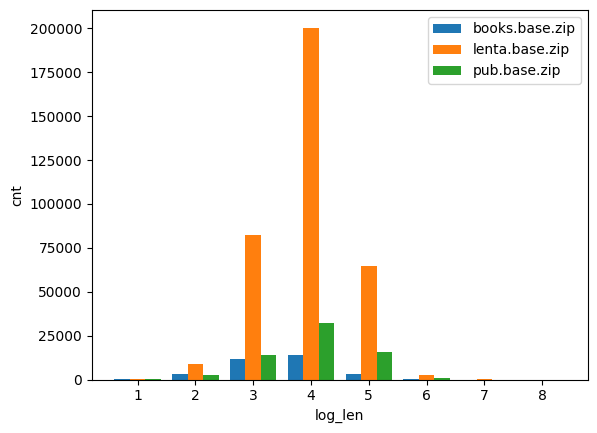

In [5]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

In [6]:
import numpy as np
df = buckets.copy()
df['random'] = np.random.rand(df.shape[0])
df = df.feed(fluq.add_ordering_column(['corpus_id', 'log_len'], 'random'))
df = df.loc[df.order<5000]
df.shape[0]

58292

In [7]:
builder.prepare(df)

2023-01-06 16:18:04.563763+00:00 INFO: Processed 22 words. 1/70404
2023-01-06 16:18:04.586722+00:00 INFO: Processed 44 words. 1/70404
2023-01-06 16:18:04.739294+00:00 INFO: Processed 110 words. 14/70404
2023-01-06 16:18:04.769181+00:00 INFO: Processed 176 words. 14/70404
2023-01-06 16:18:04.787770+00:00 INFO: Processed 242 words. 14/70404
2023-01-06 16:18:04.907247+00:00 INFO: Processed 267 words. 22/70404
2023-01-06 16:18:04.930890+00:00 INFO: Processed 292 words. 22/70404
2023-01-06 16:18:05.066993+00:00 INFO: Processed 315 words. 31/70404
2023-01-06 16:18:05.091723+00:00 INFO: Processed 338 words. 31/70404
2023-01-06 16:18:05.156826+00:00 INFO: Processed 361 words. 35/70404
2023-01-06 16:18:05.176394+00:00 INFO: Processed 384 words. 35/70404
2023-01-06 16:18:05.214661+00:00 INFO: Processed 413 words. 36/70404
2023-01-06 16:18:05.238006+00:00 INFO: Processed 442 words. 36/70404
2023-01-06 16:18:05.352711+00:00 INFO: Processed 461 words. 46/70404
2023-01-06 16:18:05.374988+00:00 INFO:

2023-01-06 16:18:12.005741+00:00 INFO: Processed 3513 words. 341/70404
2023-01-06 16:18:12.028712+00:00 INFO: Processed 3534 words. 341/70404
2023-01-06 16:18:12.079969+00:00 INFO: Processed 3544 words. 342/70404
2023-01-06 16:18:12.100605+00:00 INFO: Processed 3554 words. 342/70404
2023-01-06 16:18:12.161209+00:00 INFO: Processed 3574 words. 343/70404
2023-01-06 16:18:12.186957+00:00 INFO: Processed 3594 words. 343/70404
2023-01-06 16:18:12.249883+00:00 INFO: Processed 3601 words. 345/70404
2023-01-06 16:18:12.279458+00:00 INFO: Processed 3608 words. 345/70404
2023-01-06 16:18:12.334774+00:00 INFO: Processed 3653 words. 346/70404
2023-01-06 16:18:12.360508+00:00 INFO: Processed 3698 words. 346/70404
2023-01-06 16:18:12.415868+00:00 INFO: Processed 3746 words. 347/70404
2023-01-06 16:18:12.441821+00:00 INFO: Processed 3794 words. 347/70404
2023-01-06 16:18:12.640475+00:00 INFO: Processed 3862 words. 356/70404
2023-01-06 16:18:12.671785+00:00 INFO: Processed 3930 words. 356/70404
2023-0

2023-01-06 16:18:23.116278+00:00 INFO: Processed 7539 words. 662/70404
2023-01-06 16:18:23.137771+00:00 INFO: Processed 7546 words. 662/70404
2023-01-06 16:18:23.401544+00:00 INFO: Processed 7590 words. 686/70404
2023-01-06 16:18:23.423636+00:00 INFO: Processed 7634 words. 686/70404
2023-01-06 16:18:23.535634+00:00 INFO: Processed 7689 words. 691/70404
2023-01-06 16:18:23.563658+00:00 INFO: Processed 7744 words. 691/70404
2023-01-06 16:18:23.589304+00:00 INFO: Processed 7799 words. 691/70404
2023-01-06 16:18:23.660724+00:00 INFO: Processed 7811 words. 694/70404
2023-01-06 16:18:23.684641+00:00 INFO: Processed 7823 words. 694/70404
2023-01-06 16:18:23.748024+00:00 INFO: Processed 7836 words. 696/70404
2023-01-06 16:18:23.776636+00:00 INFO: Processed 7849 words. 696/70404
2023-01-06 16:18:23.836323+00:00 INFO: Processed 7864 words. 698/70404
2023-01-06 16:18:23.870986+00:00 INFO: Processed 7879 words. 698/70404
2023-01-06 16:18:23.945981+00:00 INFO: Processed 7888 words. 701/70404
2023-0

2023-01-06 16:18:30.282260+00:00 INFO: Processed 10802 words. 896/70404
2023-01-06 16:18:30.332269+00:00 INFO: Processed 10817 words. 896/70404
2023-01-06 16:18:30.482117+00:00 INFO: Processed 10925 words. 904/70404
2023-01-06 16:18:30.527100+00:00 INFO: Processed 11033 words. 904/70404
2023-01-06 16:18:30.568543+00:00 INFO: Processed 11141 words. 904/70404
2023-01-06 16:18:30.710469+00:00 INFO: Processed 11203 words. 909/70404
2023-01-06 16:18:30.731505+00:00 INFO: Processed 11265 words. 909/70404
2023-01-06 16:18:30.757457+00:00 INFO: Processed 11327 words. 909/70404
2023-01-06 16:18:30.862279+00:00 INFO: Processed 11360 words. 915/70404
2023-01-06 16:18:30.885237+00:00 INFO: Processed 11393 words. 915/70404
2023-01-06 16:18:30.935523+00:00 INFO: Processed 11435 words. 916/70404
2023-01-06 16:18:30.959686+00:00 INFO: Processed 11477 words. 916/70404
2023-01-06 16:18:31.027799+00:00 INFO: Processed 11511 words. 918/70404
2023-01-06 16:18:31.052227+00:00 INFO: Processed 11545 words. 91

2023-01-06 16:18:37.725692+00:00 INFO: Processed 16641 words. 1170/70404
2023-01-06 16:18:37.776351+00:00 INFO: Processed 16695 words. 1170/70404
2023-01-06 16:18:37.831779+00:00 INFO: Processed 16720 words. 1172/70404
2023-01-06 16:18:37.853714+00:00 INFO: Processed 16745 words. 1172/70404
2023-01-06 16:18:37.922901+00:00 INFO: Processed 16764 words. 1175/70404
2023-01-06 16:18:37.946463+00:00 INFO: Processed 16783 words. 1175/70404
2023-01-06 16:18:38.004271+00:00 INFO: Processed 16804 words. 1178/70404
2023-01-06 16:18:38.027639+00:00 INFO: Processed 16825 words. 1178/70404
2023-01-06 16:18:38.264051+00:00 INFO: Processed 16839 words. 1187/70404
2023-01-06 16:18:38.318474+00:00 INFO: Processed 16853 words. 1187/70404
2023-01-06 16:18:38.389896+00:00 INFO: Processed 16917 words. 1190/70404
2023-01-06 16:18:38.411642+00:00 INFO: Processed 16981 words. 1190/70404
2023-01-06 16:18:38.587054+00:00 INFO: Processed 17033 words. 1204/70404
2023-01-06 16:18:38.614374+00:00 INFO: Processed 17

2023-01-06 16:18:45.408449+00:00 INFO: Processed 20231 words. 1424/70404
2023-01-06 16:18:45.446776+00:00 INFO: Processed 20266 words. 1424/70404
2023-01-06 16:18:45.507415+00:00 INFO: Processed 20291 words. 1425/70404
2023-01-06 16:18:45.538093+00:00 INFO: Processed 20316 words. 1425/70404
2023-01-06 16:18:45.631749+00:00 INFO: Processed 20330 words. 1430/70404
2023-01-06 16:18:45.652629+00:00 INFO: Processed 20344 words. 1430/70404
2023-01-06 16:18:45.765874+00:00 INFO: Processed 20368 words. 1436/70404
2023-01-06 16:18:45.789453+00:00 INFO: Processed 20392 words. 1436/70404
2023-01-06 16:18:45.890302+00:00 INFO: Processed 20475 words. 1443/70404
2023-01-06 16:18:45.910399+00:00 INFO: Processed 20558 words. 1443/70404
2023-01-06 16:18:45.950123+00:00 INFO: Processed 20580 words. 1444/70404
2023-01-06 16:18:45.973783+00:00 INFO: Processed 20602 words. 1444/70404
2023-01-06 16:18:46.051673+00:00 INFO: Processed 20611 words. 1449/70404
2023-01-06 16:18:46.073536+00:00 INFO: Processed 20

2023-01-06 16:18:50.919589+00:00 INFO: Processed 24165 words. 1635/70404
2023-01-06 16:18:50.940710+00:00 INFO: Processed 24184 words. 1635/70404
2023-01-06 16:18:51.013810+00:00 INFO: Processed 24211 words. 1640/70404
2023-01-06 16:18:51.032244+00:00 INFO: Processed 24238 words. 1640/70404
2023-01-06 16:18:51.080203+00:00 INFO: Processed 24266 words. 1642/70404
2023-01-06 16:18:51.100176+00:00 INFO: Processed 24294 words. 1642/70404
2023-01-06 16:18:51.140675+00:00 INFO: Processed 24323 words. 1643/70404
2023-01-06 16:18:51.163462+00:00 INFO: Processed 24352 words. 1643/70404
2023-01-06 16:18:51.219320+00:00 INFO: Processed 24395 words. 1646/70404
2023-01-06 16:18:51.237791+00:00 INFO: Processed 24438 words. 1646/70404
2023-01-06 16:18:51.275977+00:00 INFO: Processed 24496 words. 1647/70404
2023-01-06 16:18:51.295212+00:00 INFO: Processed 24554 words. 1647/70404
2023-01-06 16:18:51.346449+00:00 INFO: Processed 24561 words. 1648/70404
2023-01-06 16:18:51.365347+00:00 INFO: Processed 24

2023-01-06 16:18:56.989268+00:00 INFO: Processed 27864 words. 1926/70404
2023-01-06 16:18:57.184877+00:00 INFO: Processed 27900 words. 1943/70404
2023-01-06 16:18:57.205154+00:00 INFO: Processed 27936 words. 1943/70404
2023-01-06 16:18:57.248613+00:00 INFO: Processed 27941 words. 1944/70404
2023-01-06 16:18:57.273790+00:00 INFO: Processed 27946 words. 1944/70404
2023-01-06 16:18:57.497504+00:00 INFO: Processed 27963 words. 1964/70404
2023-01-06 16:18:57.516315+00:00 INFO: Processed 27980 words. 1964/70404
2023-01-06 16:18:57.707779+00:00 INFO: Processed 28010 words. 1979/70404
2023-01-06 16:18:57.738151+00:00 INFO: Processed 28040 words. 1979/70404
2023-01-06 16:18:57.799145+00:00 INFO: Processed 28052 words. 1982/70404
2023-01-06 16:18:57.822986+00:00 INFO: Processed 28064 words. 1982/70404
2023-01-06 16:18:57.906465+00:00 INFO: Processed 28087 words. 1986/70404
2023-01-06 16:18:57.932801+00:00 INFO: Processed 28110 words. 1986/70404
2023-01-06 16:18:57.984418+00:00 INFO: Processed 28

2023-01-06 16:19:04.549076+00:00 INFO: Processed 31740 words. 2297/70404
2023-01-06 16:19:04.648330+00:00 INFO: Processed 31757 words. 2305/70404
2023-01-06 16:19:04.667229+00:00 INFO: Processed 31774 words. 2305/70404
2023-01-06 16:19:04.763825+00:00 INFO: Processed 31788 words. 2312/70404
2023-01-06 16:19:04.787018+00:00 INFO: Processed 31802 words. 2312/70404
2023-01-06 16:19:04.884510+00:00 INFO: Processed 31837 words. 2318/70404
2023-01-06 16:19:04.907505+00:00 INFO: Processed 31872 words. 2318/70404
2023-01-06 16:19:04.980425+00:00 INFO: Processed 31897 words. 2321/70404
2023-01-06 16:19:05.005787+00:00 INFO: Processed 31922 words. 2321/70404
2023-01-06 16:19:05.045745+00:00 INFO: Processed 31978 words. 2322/70404
2023-01-06 16:19:05.067412+00:00 INFO: Processed 32034 words. 2322/70404
2023-01-06 16:19:05.135741+00:00 INFO: Processed 32040 words. 2323/70404
2023-01-06 16:19:05.157031+00:00 INFO: Processed 32046 words. 2323/70404
2023-01-06 16:19:05.206242+00:00 INFO: Processed 32

2023-01-06 16:19:11.379060+00:00 INFO: Processed 35570 words. 2621/70404
2023-01-06 16:19:11.418091+00:00 INFO: Processed 35580 words. 2622/70404
2023-01-06 16:19:11.440942+00:00 INFO: Processed 35590 words. 2622/70404
2023-01-06 16:19:11.506450+00:00 INFO: Processed 35621 words. 2626/70404
2023-01-06 16:19:11.525861+00:00 INFO: Processed 35652 words. 2626/70404
2023-01-06 16:19:11.624048+00:00 INFO: Processed 35682 words. 2631/70404
2023-01-06 16:19:11.645794+00:00 INFO: Processed 35712 words. 2631/70404
2023-01-06 16:19:11.754220+00:00 INFO: Processed 35726 words. 2640/70404
2023-01-06 16:19:11.773881+00:00 INFO: Processed 35740 words. 2640/70404
2023-01-06 16:19:11.825143+00:00 INFO: Processed 35778 words. 2642/70404
2023-01-06 16:19:11.844771+00:00 INFO: Processed 35816 words. 2642/70404
2023-01-06 16:19:11.882963+00:00 INFO: Processed 35847 words. 2643/70404
2023-01-06 16:19:11.910990+00:00 INFO: Processed 35878 words. 2643/70404
2023-01-06 16:19:11.958924+00:00 INFO: Processed 35

2023-01-06 16:19:21.487011+00:00 INFO: Processed 39261 words. 2929/70404
2023-01-06 16:19:21.547677+00:00 INFO: Processed 39297 words. 2932/70404
2023-01-06 16:19:21.567095+00:00 INFO: Processed 39333 words. 2932/70404
2023-01-06 16:19:21.623185+00:00 INFO: Processed 39346 words. 2935/70404
2023-01-06 16:19:21.649399+00:00 INFO: Processed 39359 words. 2935/70404
2023-01-06 16:19:21.791337+00:00 INFO: Processed 39388 words. 2946/70404
2023-01-06 16:19:21.812530+00:00 INFO: Processed 39417 words. 2946/70404
2023-01-06 16:19:21.863092+00:00 INFO: Processed 39471 words. 2948/70404
2023-01-06 16:19:21.883100+00:00 INFO: Processed 39525 words. 2948/70404
2023-01-06 16:19:21.902820+00:00 INFO: Processed 39579 words. 2948/70404
2023-01-06 16:19:21.950700+00:00 INFO: Processed 39591 words. 2950/70404
2023-01-06 16:19:21.975818+00:00 INFO: Processed 39603 words. 2950/70404
2023-01-06 16:19:22.053296+00:00 INFO: Processed 39629 words. 2954/70404
2023-01-06 16:19:22.075206+00:00 INFO: Processed 39

2023-01-06 16:19:28.294597+00:00 INFO: Processed 42846 words. 3177/70404
2023-01-06 16:19:28.317674+00:00 INFO: Processed 42867 words. 3177/70404
2023-01-06 16:19:28.374632+00:00 INFO: Processed 42910 words. 3178/70404
2023-01-06 16:19:28.395471+00:00 INFO: Processed 42953 words. 3178/70404
2023-01-06 16:19:28.446486+00:00 INFO: Processed 43007 words. 3180/70404
2023-01-06 16:19:28.466920+00:00 INFO: Processed 43061 words. 3180/70404
2023-01-06 16:19:28.515839+00:00 INFO: Processed 43086 words. 3182/70404
2023-01-06 16:19:28.538506+00:00 INFO: Processed 43111 words. 3182/70404
2023-01-06 16:19:28.597495+00:00 INFO: Processed 43125 words. 3185/70404
2023-01-06 16:19:28.621657+00:00 INFO: Processed 43139 words. 3185/70404
2023-01-06 16:19:28.749050+00:00 INFO: Processed 43199 words. 3193/70404
2023-01-06 16:19:28.783094+00:00 INFO: Processed 43259 words. 3193/70404
2023-01-06 16:19:28.903027+00:00 INFO: Processed 43276 words. 3201/70404
2023-01-06 16:19:28.925048+00:00 INFO: Processed 43

2023-01-06 16:19:35.039243+00:00 INFO: Processed 46764 words. 3512/70404
2023-01-06 16:19:35.058855+00:00 INFO: Processed 46772 words. 3512/70404
2023-01-06 16:19:35.180934+00:00 INFO: Processed 46798 words. 3517/70404
2023-01-06 16:19:35.205447+00:00 INFO: Processed 46824 words. 3517/70404
2023-01-06 16:19:35.307545+00:00 INFO: Processed 46836 words. 3524/70404
2023-01-06 16:19:35.340013+00:00 INFO: Processed 46848 words. 3524/70404
2023-01-06 16:19:35.450126+00:00 INFO: Processed 46895 words. 3531/70404
2023-01-06 16:19:35.470993+00:00 INFO: Processed 46942 words. 3531/70404
2023-01-06 16:19:35.554129+00:00 INFO: Processed 46949 words. 3537/70404
2023-01-06 16:19:35.574146+00:00 INFO: Processed 46956 words. 3537/70404
2023-01-06 16:19:35.622189+00:00 INFO: Processed 46983 words. 3539/70404
2023-01-06 16:19:35.641524+00:00 INFO: Processed 47010 words. 3539/70404
2023-01-06 16:19:35.719124+00:00 INFO: Processed 47036 words. 3542/70404
2023-01-06 16:19:35.742262+00:00 INFO: Processed 47

2023-01-06 16:19:42.743806+00:00 INFO: Processed 50203 words. 3803/70404
2023-01-06 16:19:42.920444+00:00 INFO: Processed 50243 words. 3806/70404
2023-01-06 16:19:42.973662+00:00 INFO: Processed 50283 words. 3806/70404
2023-01-06 16:19:43.153002+00:00 INFO: Processed 50408 words. 3809/70404
2023-01-06 16:19:43.193944+00:00 INFO: Processed 50533 words. 3809/70404
2023-01-06 16:19:43.222646+00:00 INFO: Processed 50658 words. 3809/70404
2023-01-06 16:19:43.390007+00:00 INFO: Processed 50725 words. 3812/70404
2023-01-06 16:19:43.459033+00:00 INFO: Processed 50792 words. 3812/70404
2023-01-06 16:19:43.623329+00:00 INFO: Processed 50797 words. 3814/70404
2023-01-06 16:19:43.683781+00:00 INFO: Processed 50802 words. 3814/70404
2023-01-06 16:19:43.845065+00:00 INFO: Processed 50882 words. 3817/70404
2023-01-06 16:19:43.874295+00:00 INFO: Processed 50962 words. 3817/70404
2023-01-06 16:19:43.953623+00:00 INFO: Processed 50969 words. 3818/70404
2023-01-06 16:19:44.021886+00:00 INFO: Processed 50

2023-01-06 16:19:50.014682+00:00 INFO: Processed 54559 words. 4059/70404
2023-01-06 16:19:50.038121+00:00 INFO: Processed 54564 words. 4059/70404
2023-01-06 16:19:50.092177+00:00 INFO: Processed 54608 words. 4060/70404
2023-01-06 16:19:50.110245+00:00 INFO: Processed 54652 words. 4060/70404
2023-01-06 16:19:50.161237+00:00 INFO: Processed 54667 words. 4062/70404
2023-01-06 16:19:50.187648+00:00 INFO: Processed 54682 words. 4062/70404
2023-01-06 16:19:50.232544+00:00 INFO: Processed 54700 words. 4063/70404
2023-01-06 16:19:50.251129+00:00 INFO: Processed 54718 words. 4063/70404
2023-01-06 16:19:50.305101+00:00 INFO: Processed 54737 words. 4066/70404
2023-01-06 16:19:50.322717+00:00 INFO: Processed 54756 words. 4066/70404
2023-01-06 16:19:50.361832+00:00 INFO: Processed 54818 words. 4067/70404
2023-01-06 16:19:50.380855+00:00 INFO: Processed 54880 words. 4067/70404
2023-01-06 16:19:50.429732+00:00 INFO: Processed 54896 words. 4069/70404
2023-01-06 16:19:50.459401+00:00 INFO: Processed 54

2023-01-06 16:19:55.887653+00:00 INFO: Processed 58340 words. 4301/70404
2023-01-06 16:19:55.905508+00:00 INFO: Processed 58441 words. 4301/70404
2023-01-06 16:19:55.962393+00:00 INFO: Processed 58460 words. 4304/70404
2023-01-06 16:19:55.980843+00:00 INFO: Processed 58479 words. 4304/70404
2023-01-06 16:19:56.033615+00:00 INFO: Processed 58505 words. 4306/70404
2023-01-06 16:19:56.092393+00:00 INFO: Processed 58531 words. 4306/70404
2023-01-06 16:19:56.193902+00:00 INFO: Processed 58578 words. 4307/70404
2023-01-06 16:19:56.255417+00:00 INFO: Processed 58625 words. 4307/70404
2023-01-06 16:19:56.387025+00:00 INFO: Processed 58648 words. 4308/70404
2023-01-06 16:19:56.420308+00:00 INFO: Processed 58671 words. 4308/70404
2023-01-06 16:19:56.550130+00:00 INFO: Processed 58740 words. 4310/70404
2023-01-06 16:19:56.646751+00:00 INFO: Processed 58809 words. 4310/70404
2023-01-06 16:19:56.822306+00:00 INFO: Processed 58824 words. 4314/70404
2023-01-06 16:19:56.853452+00:00 INFO: Processed 58

2023-01-06 16:20:10.452971+00:00 INFO: Processed 61741 words. 4548/70404
2023-01-06 16:20:10.588643+00:00 INFO: Processed 61773 words. 4550/70404
2023-01-06 16:20:10.648619+00:00 INFO: Processed 61805 words. 4550/70404
2023-01-06 16:20:10.781332+00:00 INFO: Processed 61814 words. 4552/70404
2023-01-06 16:20:10.847813+00:00 INFO: Processed 61823 words. 4552/70404
2023-01-06 16:20:11.170992+00:00 INFO: Processed 61835 words. 4560/70404
2023-01-06 16:20:11.243093+00:00 INFO: Processed 61847 words. 4560/70404
2023-01-06 16:20:11.420949+00:00 INFO: Processed 61917 words. 4565/70404
2023-01-06 16:20:11.482895+00:00 INFO: Processed 61987 words. 4565/70404
2023-01-06 16:20:11.826936+00:00 INFO: Processed 62006 words. 4575/70404
2023-01-06 16:20:11.886669+00:00 INFO: Processed 62025 words. 4575/70404
2023-01-06 16:20:12.026215+00:00 INFO: Processed 62052 words. 4576/70404
2023-01-06 16:20:12.089829+00:00 INFO: Processed 62079 words. 4576/70404
2023-01-06 16:20:12.240263+00:00 INFO: Processed 62

2023-01-06 16:20:22.357084+00:00 INFO: Processed 65899 words. 4825/70404
2023-01-06 16:20:22.391651+00:00 INFO: Processed 65928 words. 4825/70404
2023-01-06 16:20:22.604145+00:00 INFO: Processed 65969 words. 4843/70404
2023-01-06 16:20:22.625491+00:00 INFO: Processed 66010 words. 4843/70404
2023-01-06 16:20:22.712249+00:00 INFO: Processed 66024 words. 4846/70404
2023-01-06 16:20:22.743827+00:00 INFO: Processed 66038 words. 4846/70404
2023-01-06 16:20:22.905482+00:00 INFO: Processed 66073 words. 4855/70404
2023-01-06 16:20:22.924931+00:00 INFO: Processed 66108 words. 4855/70404
2023-01-06 16:20:22.982142+00:00 INFO: Processed 66140 words. 4856/70404
2023-01-06 16:20:23.004340+00:00 INFO: Processed 66172 words. 4856/70404
2023-01-06 16:20:23.299176+00:00 INFO: Processed 66193 words. 4872/70404
2023-01-06 16:20:23.325724+00:00 INFO: Processed 66214 words. 4872/70404
2023-01-06 16:20:23.400624+00:00 INFO: Processed 66248 words. 4876/70404
2023-01-06 16:20:23.440612+00:00 INFO: Processed 66

2023-01-06 16:20:30.069934+00:00 INFO: Processed 68997 words. 5122/70404
2023-01-06 16:20:30.172331+00:00 INFO: Processed 69022 words. 5127/70404
2023-01-06 16:20:30.201614+00:00 INFO: Processed 69047 words. 5127/70404
2023-01-06 16:20:30.311425+00:00 INFO: Processed 69134 words. 5129/70404
2023-01-06 16:20:30.373606+00:00 INFO: Processed 69221 words. 5129/70404
2023-01-06 16:20:30.764608+00:00 INFO: Processed 69235 words. 5148/70404
2023-01-06 16:20:30.787019+00:00 INFO: Processed 69249 words. 5148/70404
2023-01-06 16:20:30.841116+00:00 INFO: Processed 69280 words. 5149/70404
2023-01-06 16:20:30.861724+00:00 INFO: Processed 69311 words. 5149/70404
2023-01-06 16:20:31.069647+00:00 INFO: Processed 69363 words. 5159/70404
2023-01-06 16:20:31.106128+00:00 INFO: Processed 69415 words. 5159/70404
2023-01-06 16:20:31.144808+00:00 INFO: Processed 69467 words. 5159/70404
2023-01-06 16:20:31.239186+00:00 INFO: Processed 69484 words. 5161/70404
2023-01-06 16:20:31.283434+00:00 INFO: Processed 69

2023-01-06 16:20:39.368719+00:00 INFO: Processed 72469 words. 5477/70404
2023-01-06 16:20:39.476718+00:00 INFO: Processed 72474 words. 5485/70404
2023-01-06 16:20:39.503548+00:00 INFO: Processed 72479 words. 5485/70404
2023-01-06 16:20:39.557026+00:00 INFO: Processed 72483 words. 5487/70404
2023-01-06 16:20:39.583337+00:00 INFO: Processed 72487 words. 5487/70404
2023-01-06 16:20:39.631685+00:00 INFO: Processed 72572 words. 5488/70404
2023-01-06 16:20:39.657348+00:00 INFO: Processed 72657 words. 5488/70404
2023-01-06 16:20:39.703460+00:00 INFO: Processed 72697 words. 5489/70404
2023-01-06 16:20:39.725680+00:00 INFO: Processed 72737 words. 5489/70404
2023-01-06 16:20:39.855926+00:00 INFO: Processed 72744 words. 5499/70404
2023-01-06 16:20:39.881338+00:00 INFO: Processed 72751 words. 5499/70404
2023-01-06 16:20:39.929777+00:00 INFO: Processed 72800 words. 5500/70404
2023-01-06 16:20:39.959636+00:00 INFO: Processed 72849 words. 5500/70404
2023-01-06 16:20:40.017619+00:00 INFO: Processed 72

2023-01-06 16:20:48.274683+00:00 INFO: Processed 76742 words. 5783/70404
2023-01-06 16:20:48.354308+00:00 INFO: Processed 76797 words. 5783/70404
2023-01-06 16:20:48.614716+00:00 INFO: Processed 76831 words. 5790/70404
2023-01-06 16:20:48.641447+00:00 INFO: Processed 76865 words. 5790/70404
2023-01-06 16:20:48.830587+00:00 INFO: Processed 76905 words. 5796/70404
2023-01-06 16:20:48.886496+00:00 INFO: Processed 76945 words. 5796/70404
2023-01-06 16:20:49.138819+00:00 INFO: Processed 77032 words. 5800/70404
2023-01-06 16:20:49.199130+00:00 INFO: Processed 77119 words. 5800/70404
2023-01-06 16:20:49.369656+00:00 INFO: Processed 77141 words. 5804/70404
2023-01-06 16:20:49.391597+00:00 INFO: Processed 77163 words. 5804/70404
2023-01-06 16:20:49.430877+00:00 INFO: Processed 77177 words. 5805/70404
2023-01-06 16:20:49.455032+00:00 INFO: Processed 77191 words. 5805/70404
2023-01-06 16:20:49.562913+00:00 INFO: Processed 77208 words. 5811/70404
2023-01-06 16:20:49.587161+00:00 INFO: Processed 77

2023-01-06 16:20:54.590100+00:00 INFO: Processed 80950 words. 6062/70404
2023-01-06 16:20:54.629433+00:00 INFO: Processed 80987 words. 6062/70404
2023-01-06 16:20:54.680843+00:00 INFO: Processed 81028 words. 6064/70404
2023-01-06 16:20:54.715591+00:00 INFO: Processed 81069 words. 6064/70404
2023-01-06 16:20:54.784493+00:00 INFO: Processed 81103 words. 6065/70404
2023-01-06 16:20:54.825367+00:00 INFO: Processed 81137 words. 6065/70404
2023-01-06 16:20:54.892448+00:00 INFO: Processed 81157 words. 6068/70404
2023-01-06 16:20:54.912504+00:00 INFO: Processed 81177 words. 6068/70404
2023-01-06 16:20:54.953144+00:00 INFO: Processed 81201 words. 6069/70404
2023-01-06 16:20:54.982283+00:00 INFO: Processed 81225 words. 6069/70404
2023-01-06 16:20:55.043312+00:00 INFO: Processed 81247 words. 6070/70404
2023-01-06 16:20:55.086698+00:00 INFO: Processed 81269 words. 6070/70404
2023-01-06 16:20:55.209367+00:00 INFO: Processed 81283 words. 6075/70404
2023-01-06 16:20:55.231236+00:00 INFO: Processed 81

2023-01-06 16:21:01.396658+00:00 INFO: Processed 84093 words. 6401/70404
2023-01-06 16:21:01.425618+00:00 INFO: Processed 84152 words. 6401/70404
2023-01-06 16:21:01.494697+00:00 INFO: Processed 84216 words. 6404/70404
2023-01-06 16:21:01.528300+00:00 INFO: Processed 84280 words. 6404/70404
2023-01-06 16:21:01.678864+00:00 INFO: Processed 84299 words. 6415/70404
2023-01-06 16:21:01.701580+00:00 INFO: Processed 84318 words. 6415/70404
2023-01-06 16:21:01.915367+00:00 INFO: Processed 84338 words. 6430/70404
2023-01-06 16:21:01.947796+00:00 INFO: Processed 84358 words. 6430/70404
2023-01-06 16:21:01.994063+00:00 INFO: Processed 84436 words. 6431/70404
2023-01-06 16:21:02.018849+00:00 INFO: Processed 84514 words. 6431/70404
2023-01-06 16:21:02.066547+00:00 INFO: Processed 84524 words. 6433/70404
2023-01-06 16:21:02.086136+00:00 INFO: Processed 84534 words. 6433/70404
2023-01-06 16:21:02.147214+00:00 INFO: Processed 84552 words. 6435/70404
2023-01-06 16:21:02.173275+00:00 INFO: Processed 84

2023-01-06 16:21:09.024278+00:00 INFO: Processed 88163 words. 6764/70404
2023-01-06 16:21:09.053039+00:00 INFO: Processed 88220 words. 6764/70404
2023-01-06 16:21:09.162659+00:00 INFO: Processed 88234 words. 6768/70404
2023-01-06 16:21:09.194855+00:00 INFO: Processed 88248 words. 6768/70404
2023-01-06 16:21:09.246547+00:00 INFO: Processed 88340 words. 6769/70404
2023-01-06 16:21:09.273735+00:00 INFO: Processed 88432 words. 6769/70404
2023-01-06 16:21:09.323049+00:00 INFO: Processed 88464 words. 6770/70404
2023-01-06 16:21:09.352106+00:00 INFO: Processed 88496 words. 6770/70404
2023-01-06 16:21:09.408078+00:00 INFO: Processed 88528 words. 6772/70404
2023-01-06 16:21:09.431735+00:00 INFO: Processed 88560 words. 6772/70404
2023-01-06 16:21:09.524575+00:00 INFO: Processed 88572 words. 6777/70404
2023-01-06 16:21:09.564142+00:00 INFO: Processed 88584 words. 6777/70404
2023-01-06 16:21:09.614302+00:00 INFO: Processed 88632 words. 6779/70404
2023-01-06 16:21:09.635438+00:00 INFO: Processed 88

2023-01-06 16:21:18.484800+00:00 INFO: Processed 91590 words. 7159/70404
2023-01-06 16:21:18.504872+00:00 INFO: Processed 91613 words. 7159/70404
2023-01-06 16:21:18.583592+00:00 INFO: Processed 91644 words. 7164/70404
2023-01-06 16:21:18.603220+00:00 INFO: Processed 91675 words. 7164/70404
2023-01-06 16:21:18.667184+00:00 INFO: Processed 91682 words. 7167/70404
2023-01-06 16:21:18.691894+00:00 INFO: Processed 91689 words. 7167/70404
2023-01-06 16:21:18.751382+00:00 INFO: Processed 91696 words. 7170/70404
2023-01-06 16:21:18.773431+00:00 INFO: Processed 91703 words. 7170/70404
2023-01-06 16:21:18.824542+00:00 INFO: Processed 91709 words. 7172/70404
2023-01-06 16:21:18.849781+00:00 INFO: Processed 91715 words. 7172/70404
2023-01-06 16:21:18.961922+00:00 INFO: Processed 91729 words. 7174/70404
2023-01-06 16:21:19.032152+00:00 INFO: Processed 91743 words. 7174/70404
2023-01-06 16:21:19.147691+00:00 INFO: Processed 91792 words. 7175/70404
2023-01-06 16:21:19.206619+00:00 INFO: Processed 91

2023-01-06 16:21:26.716606+00:00 INFO: Processed 95153 words. 7429/70404
2023-01-06 16:21:26.784342+00:00 INFO: Processed 95165 words. 7429/70404
2023-01-06 16:21:27.188823+00:00 INFO: Processed 95171 words. 7440/70404
2023-01-06 16:21:27.252257+00:00 INFO: Processed 95177 words. 7440/70404
2023-01-06 16:21:27.464959+00:00 INFO: Processed 95197 words. 7443/70404
2023-01-06 16:21:27.532732+00:00 INFO: Processed 95217 words. 7443/70404
2023-01-06 16:21:27.770451+00:00 INFO: Processed 95224 words. 7448/70404
2023-01-06 16:21:27.827848+00:00 INFO: Processed 95231 words. 7448/70404
2023-01-06 16:21:28.056766+00:00 INFO: Processed 95240 words. 7452/70404
2023-01-06 16:21:28.124173+00:00 INFO: Processed 95249 words. 7452/70404
2023-01-06 16:21:28.664993+00:00 INFO: Processed 95299 words. 7470/70404
2023-01-06 16:21:28.726591+00:00 INFO: Processed 95349 words. 7470/70404
2023-01-06 16:21:28.888257+00:00 INFO: Processed 95390 words. 7472/70404
2023-01-06 16:21:28.952712+00:00 INFO: Processed 95

2023-01-06 16:21:45.047125+00:00 INFO: Processed 98409 words. 7779/70404
2023-01-06 16:21:45.091782+00:00 INFO: Processed 98433 words. 7779/70404
2023-01-06 16:21:45.347762+00:00 INFO: Processed 98453 words. 7784/70404
2023-01-06 16:21:45.408242+00:00 INFO: Processed 98473 words. 7784/70404
2023-01-06 16:21:45.635676+00:00 INFO: Processed 98485 words. 7789/70404
2023-01-06 16:21:45.705987+00:00 INFO: Processed 98497 words. 7789/70404
2023-01-06 16:21:46.217596+00:00 INFO: Processed 98526 words. 7796/70404
2023-01-06 16:21:46.356348+00:00 INFO: Processed 98555 words. 7796/70404
2023-01-06 16:21:46.624087+00:00 INFO: Processed 98626 words. 7797/70404
2023-01-06 16:21:46.703385+00:00 INFO: Processed 98697 words. 7797/70404
2023-01-06 16:21:47.283747+00:00 INFO: Processed 98804 words. 7814/70404
2023-01-06 16:21:47.340723+00:00 INFO: Processed 98911 words. 7814/70404
2023-01-06 16:21:48.509052+00:00 INFO: Processed 98957 words. 7846/70404
2023-01-06 16:21:48.572887+00:00 INFO: Processed 99

2023-01-06 16:22:04.939863+00:00 INFO: Processed 101776 words. 8155/70404
2023-01-06 16:22:04.961113+00:00 INFO: Processed 101850 words. 8155/70404
2023-01-06 16:22:05.000904+00:00 INFO: Processed 101901 words. 8156/70404
2023-01-06 16:22:05.021371+00:00 INFO: Processed 101952 words. 8156/70404
2023-01-06 16:22:05.061245+00:00 INFO: Processed 101961 words. 8157/70404
2023-01-06 16:22:05.081171+00:00 INFO: Processed 101970 words. 8157/70404
2023-01-06 16:22:05.160806+00:00 INFO: Processed 101987 words. 8161/70404
2023-01-06 16:22:05.183888+00:00 INFO: Processed 102004 words. 8161/70404
2023-01-06 16:22:05.235665+00:00 INFO: Processed 102031 words. 8163/70404
2023-01-06 16:22:05.259060+00:00 INFO: Processed 102058 words. 8163/70404
2023-01-06 16:22:05.313893+00:00 INFO: Processed 102072 words. 8164/70404
2023-01-06 16:22:05.333209+00:00 INFO: Processed 102086 words. 8164/70404
2023-01-06 16:22:05.432037+00:00 INFO: Processed 102175 words. 8171/70404
2023-01-06 16:22:05.450333+00:00 INFO:

2023-01-06 16:22:11.694417+00:00 INFO: Processed 105367 words. 8451/70404
2023-01-06 16:22:11.839384+00:00 INFO: Processed 105433 words. 8454/70404
2023-01-06 16:22:11.872933+00:00 INFO: Processed 105499 words. 8454/70404
2023-01-06 16:22:11.936157+00:00 INFO: Processed 105510 words. 8456/70404
2023-01-06 16:22:11.959066+00:00 INFO: Processed 105521 words. 8456/70404
2023-01-06 16:22:12.159526+00:00 INFO: Processed 105551 words. 8474/70404
2023-01-06 16:22:12.184740+00:00 INFO: Processed 105581 words. 8474/70404
2023-01-06 16:22:12.378515+00:00 INFO: Processed 105592 words. 8491/70404
2023-01-06 16:22:12.402736+00:00 INFO: Processed 105603 words. 8491/70404
2023-01-06 16:22:12.451401+00:00 INFO: Processed 105625 words. 8492/70404
2023-01-06 16:22:12.473305+00:00 INFO: Processed 105647 words. 8492/70404
2023-01-06 16:22:12.527675+00:00 INFO: Processed 105668 words. 8494/70404
2023-01-06 16:22:12.553641+00:00 INFO: Processed 105689 words. 8494/70404
2023-01-06 16:22:12.662492+00:00 INFO:

2023-01-06 16:22:19.017464+00:00 INFO: Processed 109312 words. 8751/70404
2023-01-06 16:22:19.040620+00:00 INFO: Processed 109331 words. 8751/70404
2023-01-06 16:22:19.200592+00:00 INFO: Processed 109352 words. 8763/70404
2023-01-06 16:22:19.232243+00:00 INFO: Processed 109373 words. 8763/70404
2023-01-06 16:22:19.335483+00:00 INFO: Processed 109383 words. 8770/70404
2023-01-06 16:22:19.361387+00:00 INFO: Processed 109393 words. 8770/70404
2023-01-06 16:22:19.431341+00:00 INFO: Processed 109399 words. 8772/70404
2023-01-06 16:22:19.461566+00:00 INFO: Processed 109405 words. 8772/70404
2023-01-06 16:22:19.534511+00:00 INFO: Processed 109427 words. 8775/70404
2023-01-06 16:22:19.565731+00:00 INFO: Processed 109449 words. 8775/70404
2023-01-06 16:22:19.648445+00:00 INFO: Processed 109472 words. 8779/70404
2023-01-06 16:22:19.679992+00:00 INFO: Processed 109495 words. 8779/70404
2023-01-06 16:22:19.824160+00:00 INFO: Processed 109531 words. 8789/70404
2023-01-06 16:22:19.848356+00:00 INFO:

2023-01-06 16:22:25.526581+00:00 INFO: Processed 112544 words. 9010/70404
2023-01-06 16:22:25.600517+00:00 INFO: Processed 112602 words. 9013/70404
2023-01-06 16:22:25.632218+00:00 INFO: Processed 112660 words. 9013/70404
2023-01-06 16:22:25.696142+00:00 INFO: Processed 112672 words. 9015/70404
2023-01-06 16:22:25.721223+00:00 INFO: Processed 112684 words. 9015/70404
2023-01-06 16:22:25.837246+00:00 INFO: Processed 112708 words. 9022/70404
2023-01-06 16:22:25.859723+00:00 INFO: Processed 112732 words. 9022/70404
2023-01-06 16:22:26.067210+00:00 INFO: Processed 112765 words. 9041/70404
2023-01-06 16:22:26.092691+00:00 INFO: Processed 112798 words. 9041/70404
2023-01-06 16:22:26.261965+00:00 INFO: Processed 112884 words. 9056/70404
2023-01-06 16:22:26.288293+00:00 INFO: Processed 112970 words. 9056/70404
2023-01-06 16:22:26.344367+00:00 INFO: Processed 112987 words. 9058/70404
2023-01-06 16:22:26.365525+00:00 INFO: Processed 113004 words. 9058/70404
2023-01-06 16:22:26.409853+00:00 INFO:

2023-01-06 16:22:36.168104+00:00 INFO: Processed 115995 words. 9322/70404
2023-01-06 16:22:36.226884+00:00 INFO: Processed 116112 words. 9322/70404
2023-01-06 16:22:36.370941+00:00 INFO: Processed 116129 words. 9324/70404
2023-01-06 16:22:36.425352+00:00 INFO: Processed 116146 words. 9324/70404
2023-01-06 16:22:36.575474+00:00 INFO: Processed 116238 words. 9326/70404
2023-01-06 16:22:36.641270+00:00 INFO: Processed 116330 words. 9326/70404
2023-01-06 16:22:36.824613+00:00 INFO: Processed 116389 words. 9329/70404
2023-01-06 16:22:36.883602+00:00 INFO: Processed 116448 words. 9329/70404
2023-01-06 16:22:37.027231+00:00 INFO: Processed 116518 words. 9331/70404
2023-01-06 16:22:37.094061+00:00 INFO: Processed 116588 words. 9331/70404
2023-01-06 16:22:37.210040+00:00 INFO: Processed 116593 words. 9332/70404
2023-01-06 16:22:37.254859+00:00 INFO: Processed 116598 words. 9332/70404
2023-01-06 16:22:37.392362+00:00 INFO: Processed 116633 words. 9333/70404
2023-01-06 16:22:37.461074+00:00 INFO:

2023-01-06 16:22:46.720888+00:00 INFO: Processed 119189 words. 9606/70404
2023-01-06 16:22:46.856153+00:00 INFO: Processed 119204 words. 9616/70404
2023-01-06 16:22:46.877778+00:00 INFO: Processed 119219 words. 9616/70404
2023-01-06 16:22:47.059857+00:00 INFO: Processed 119261 words. 9631/70404
2023-01-06 16:22:47.078068+00:00 INFO: Processed 119303 words. 9631/70404
2023-01-06 16:22:47.260334+00:00 INFO: Processed 119311 words. 9633/70404
2023-01-06 16:22:47.296611+00:00 INFO: Processed 119319 words. 9633/70404
2023-01-06 16:22:47.460868+00:00 INFO: Processed 119352 words. 9645/70404
2023-01-06 16:22:47.486295+00:00 INFO: Processed 119385 words. 9645/70404
2023-01-06 16:22:47.570276+00:00 INFO: Processed 119402 words. 9651/70404
2023-01-06 16:22:47.591719+00:00 INFO: Processed 119419 words. 9651/70404
2023-01-06 16:22:47.647348+00:00 INFO: Processed 119441 words. 9654/70404
2023-01-06 16:22:47.671192+00:00 INFO: Processed 119463 words. 9654/70404
2023-01-06 16:22:47.806303+00:00 INFO:

2023-01-06 16:22:54.637028+00:00 INFO: Processed 122099 words. 9934/70404
2023-01-06 16:22:54.665976+00:00 INFO: Processed 122117 words. 9934/70404
2023-01-06 16:22:54.832621+00:00 INFO: Processed 122157 words. 9947/70404
2023-01-06 16:22:54.856100+00:00 INFO: Processed 122197 words. 9947/70404
2023-01-06 16:22:54.949839+00:00 INFO: Processed 122210 words. 9951/70404
2023-01-06 16:22:54.985369+00:00 INFO: Processed 122223 words. 9951/70404
2023-01-06 16:22:55.030391+00:00 INFO: Processed 122228 words. 9952/70404
2023-01-06 16:22:55.050763+00:00 INFO: Processed 122233 words. 9952/70404
2023-01-06 16:22:55.089209+00:00 INFO: Processed 122258 words. 9953/70404
2023-01-06 16:22:55.114106+00:00 INFO: Processed 122283 words. 9953/70404
2023-01-06 16:22:55.178954+00:00 INFO: Processed 122321 words. 9957/70404
2023-01-06 16:22:55.202529+00:00 INFO: Processed 122359 words. 9957/70404
2023-01-06 16:22:55.266984+00:00 INFO: Processed 122392 words. 9960/70404
2023-01-06 16:22:55.295113+00:00 INFO:

2023-01-06 16:23:09.559931+00:00 INFO: Processed 125388 words. 10234/70404
2023-01-06 16:23:09.625291+00:00 INFO: Processed 125445 words. 10234/70404
2023-01-06 16:23:09.812313+00:00 INFO: Processed 125465 words. 10236/70404
2023-01-06 16:23:09.905884+00:00 INFO: Processed 125485 words. 10236/70404
2023-01-06 16:23:10.042879+00:00 INFO: Processed 125537 words. 10237/70404
2023-01-06 16:23:10.116114+00:00 INFO: Processed 125589 words. 10237/70404
2023-01-06 16:23:10.244411+00:00 INFO: Processed 125612 words. 10238/70404
2023-01-06 16:23:10.303101+00:00 INFO: Processed 125635 words. 10238/70404
2023-01-06 16:23:10.570151+00:00 INFO: Processed 125664 words. 10242/70404
2023-01-06 16:23:10.642800+00:00 INFO: Processed 125693 words. 10242/70404
2023-01-06 16:23:11.076055+00:00 INFO: Processed 125762 words. 10257/70404
2023-01-06 16:23:11.135666+00:00 INFO: Processed 125831 words. 10257/70404
2023-01-06 16:23:11.537002+00:00 INFO: Processed 125856 words. 10270/70404
2023-01-06 16:23:11.59021

2023-01-06 16:23:18.430195+00:00 INFO: Processed 128770 words. 10480/70404
2023-01-06 16:23:18.456675+00:00 INFO: Processed 128785 words. 10480/70404
2023-01-06 16:23:18.507078+00:00 INFO: Processed 128791 words. 10481/70404
2023-01-06 16:23:18.531808+00:00 INFO: Processed 128797 words. 10481/70404
2023-01-06 16:23:18.640024+00:00 INFO: Processed 128839 words. 10488/70404
2023-01-06 16:23:18.664683+00:00 INFO: Processed 128881 words. 10488/70404
2023-01-06 16:23:18.720703+00:00 INFO: Processed 128886 words. 10490/70404
2023-01-06 16:23:18.746542+00:00 INFO: Processed 128891 words. 10490/70404
2023-01-06 16:23:18.818924+00:00 INFO: Processed 128902 words. 10493/70404
2023-01-06 16:23:18.841984+00:00 INFO: Processed 128913 words. 10493/70404
2023-01-06 16:23:18.940513+00:00 INFO: Processed 128954 words. 10499/70404
2023-01-06 16:23:18.972143+00:00 INFO: Processed 128995 words. 10499/70404
2023-01-06 16:23:19.080783+00:00 INFO: Processed 129007 words. 10507/70404
2023-01-06 16:23:19.10740

2023-01-06 16:23:25.530864+00:00 INFO: Processed 132360 words. 10807/70404
2023-01-06 16:23:25.603902+00:00 INFO: Processed 132375 words. 10809/70404
2023-01-06 16:23:25.629640+00:00 INFO: Processed 132390 words. 10809/70404
2023-01-06 16:23:25.745542+00:00 INFO: Processed 132402 words. 10816/70404
2023-01-06 16:23:25.775777+00:00 INFO: Processed 132414 words. 10816/70404
2023-01-06 16:23:25.912552+00:00 INFO: Processed 132519 words. 10826/70404
2023-01-06 16:23:25.947360+00:00 INFO: Processed 132624 words. 10826/70404
2023-01-06 16:23:26.017720+00:00 INFO: Processed 132628 words. 10829/70404
2023-01-06 16:23:26.043723+00:00 INFO: Processed 132632 words. 10829/70404
2023-01-06 16:23:26.100382+00:00 INFO: Processed 132655 words. 10830/70404
2023-01-06 16:23:26.131797+00:00 INFO: Processed 132678 words. 10830/70404
2023-01-06 16:23:26.197077+00:00 INFO: Processed 132714 words. 10832/70404
2023-01-06 16:23:26.230655+00:00 INFO: Processed 132750 words. 10832/70404
2023-01-06 16:23:26.30956

2023-01-06 16:23:33.223783+00:00 INFO: Processed 136559 words. 11064/70404
2023-01-06 16:23:33.296864+00:00 INFO: Processed 136606 words. 11064/70404
2023-01-06 16:23:33.725548+00:00 INFO: Processed 136618 words. 11076/70404
2023-01-06 16:23:33.756116+00:00 INFO: Processed 136630 words. 11076/70404
2023-01-06 16:23:33.804937+00:00 INFO: Processed 136694 words. 11077/70404
2023-01-06 16:23:33.825663+00:00 INFO: Processed 136758 words. 11077/70404
2023-01-06 16:23:33.878182+00:00 INFO: Processed 136773 words. 11078/70404
2023-01-06 16:23:33.909306+00:00 INFO: Processed 136788 words. 11078/70404
2023-01-06 16:23:33.950289+00:00 INFO: Processed 136853 words. 11079/70404
2023-01-06 16:23:33.972961+00:00 INFO: Processed 136918 words. 11079/70404
2023-01-06 16:23:34.023198+00:00 INFO: Processed 136966 words. 11081/70404
2023-01-06 16:23:34.043535+00:00 INFO: Processed 137014 words. 11081/70404
2023-01-06 16:23:34.088469+00:00 INFO: Processed 137037 words. 11082/70404
2023-01-06 16:23:34.12009

2023-01-06 16:23:39.941851+00:00 INFO: Processed 140719 words. 11326/70404
2023-01-06 16:23:40.000680+00:00 INFO: Processed 140741 words. 11329/70404
2023-01-06 16:23:40.022313+00:00 INFO: Processed 140763 words. 11329/70404
2023-01-06 16:23:40.068389+00:00 INFO: Processed 140795 words. 11330/70404
2023-01-06 16:23:40.096403+00:00 INFO: Processed 140827 words. 11330/70404
2023-01-06 16:23:40.211253+00:00 INFO: Processed 140849 words. 11331/70404
2023-01-06 16:23:40.259407+00:00 INFO: Processed 140871 words. 11331/70404
2023-01-06 16:23:40.355524+00:00 INFO: Processed 140913 words. 11335/70404
2023-01-06 16:23:40.375922+00:00 INFO: Processed 140955 words. 11335/70404
2023-01-06 16:23:40.426315+00:00 INFO: Processed 140964 words. 11337/70404
2023-01-06 16:23:40.451443+00:00 INFO: Processed 140973 words. 11337/70404
2023-01-06 16:23:40.583152+00:00 INFO: Processed 140987 words. 11346/70404
2023-01-06 16:23:40.615534+00:00 INFO: Processed 141001 words. 11346/70404
2023-01-06 16:23:40.69392

2023-01-06 16:23:47.499658+00:00 INFO: Processed 143837 words. 11599/70404
2023-01-06 16:23:47.655253+00:00 INFO: Processed 143863 words. 11613/70404
2023-01-06 16:23:47.681375+00:00 INFO: Processed 143889 words. 11613/70404
2023-01-06 16:23:47.716318+00:00 INFO: Processed 143915 words. 11613/70404
2023-01-06 16:23:47.768025+00:00 INFO: Processed 143947 words. 11615/70404
2023-01-06 16:23:47.788032+00:00 INFO: Processed 143979 words. 11615/70404
2023-01-06 16:23:47.876464+00:00 INFO: Processed 144051 words. 11620/70404
2023-01-06 16:23:47.907791+00:00 INFO: Processed 144123 words. 11620/70404
2023-01-06 16:23:48.029467+00:00 INFO: Processed 144164 words. 11625/70404
2023-01-06 16:23:48.081409+00:00 INFO: Processed 144205 words. 11625/70404
2023-01-06 16:23:48.201917+00:00 INFO: Processed 144247 words. 11634/70404
2023-01-06 16:23:48.226647+00:00 INFO: Processed 144289 words. 11634/70404
2023-01-06 16:23:48.309980+00:00 INFO: Processed 144338 words. 11638/70404
2023-01-06 16:23:48.33383

2023-01-06 16:23:53.936609+00:00 INFO: Processed 147144 words. 11835/70404
2023-01-06 16:23:53.960157+00:00 INFO: Processed 147162 words. 11835/70404
2023-01-06 16:23:54.023220+00:00 INFO: Processed 147170 words. 11837/70404
2023-01-06 16:23:54.067914+00:00 INFO: Processed 147178 words. 11837/70404
2023-01-06 16:23:54.216448+00:00 INFO: Processed 147200 words. 11843/70404
2023-01-06 16:23:54.259395+00:00 INFO: Processed 147222 words. 11843/70404
2023-01-06 16:23:54.325305+00:00 INFO: Processed 147232 words. 11844/70404
2023-01-06 16:23:54.366545+00:00 INFO: Processed 147242 words. 11844/70404
2023-01-06 16:23:54.435309+00:00 INFO: Processed 147254 words. 11845/70404
2023-01-06 16:23:54.464421+00:00 INFO: Processed 147266 words. 11845/70404
2023-01-06 16:23:54.533064+00:00 INFO: Processed 147276 words. 11848/70404
2023-01-06 16:23:54.563442+00:00 INFO: Processed 147286 words. 11848/70404
2023-01-06 16:23:54.755804+00:00 INFO: Processed 147319 words. 11853/70404
2023-01-06 16:23:54.83459

2023-01-06 16:24:06.865616+00:00 INFO: Processed 150372 words. 12114/70404
2023-01-06 16:24:06.941713+00:00 INFO: Processed 150390 words. 12114/70404
2023-01-06 16:24:07.336129+00:00 INFO: Processed 150404 words. 12119/70404
2023-01-06 16:24:07.418631+00:00 INFO: Processed 150418 words. 12119/70404
2023-01-06 16:24:07.482853+00:00 INFO: Processed 150432 words. 12119/70404
2023-01-06 16:24:07.683654+00:00 INFO: Processed 150463 words. 12127/70404
2023-01-06 16:24:07.707357+00:00 INFO: Processed 150494 words. 12127/70404
2023-01-06 16:24:07.725939+00:00 INFO: Processed 150525 words. 12127/70404
2023-01-06 16:24:07.792886+00:00 INFO: Processed 150569 words. 12130/70404
2023-01-06 16:24:07.829389+00:00 INFO: Processed 150613 words. 12130/70404
2023-01-06 16:24:07.861275+00:00 INFO: Processed 150657 words. 12130/70404
2023-01-06 16:24:07.969230+00:00 INFO: Processed 150730 words. 12137/70404
2023-01-06 16:24:07.991518+00:00 INFO: Processed 150803 words. 12137/70404
2023-01-06 16:24:08.07159

2023-01-06 16:24:14.283492+00:00 INFO: Processed 153667 words. 12351/70404
2023-01-06 16:24:14.311607+00:00 INFO: Processed 153694 words. 12351/70404
2023-01-06 16:24:14.457220+00:00 INFO: Processed 153730 words. 12364/70404
2023-01-06 16:24:14.475071+00:00 INFO: Processed 153766 words. 12364/70404
2023-01-06 16:24:14.594423+00:00 INFO: Processed 153885 words. 12374/70404
2023-01-06 16:24:14.613931+00:00 INFO: Processed 154004 words. 12374/70404
2023-01-06 16:24:14.709869+00:00 INFO: Processed 154046 words. 12382/70404
2023-01-06 16:24:14.727842+00:00 INFO: Processed 154088 words. 12382/70404
2023-01-06 16:24:14.792990+00:00 INFO: Processed 154098 words. 12386/70404
2023-01-06 16:24:14.810760+00:00 INFO: Processed 154108 words. 12386/70404
2023-01-06 16:24:14.851849+00:00 INFO: Processed 154120 words. 12387/70404
2023-01-06 16:24:14.873661+00:00 INFO: Processed 154132 words. 12387/70404
2023-01-06 16:24:14.944276+00:00 INFO: Processed 154167 words. 12389/70404
2023-01-06 16:24:14.96900

2023-01-06 16:24:25.595059+00:00 INFO: Processed 156701 words. 12655/70404
2023-01-06 16:24:25.613769+00:00 INFO: Processed 156783 words. 12655/70404
2023-01-06 16:24:25.835578+00:00 INFO: Processed 156853 words. 12663/70404
2023-01-06 16:24:25.881205+00:00 INFO: Processed 156923 words. 12663/70404
2023-01-06 16:24:25.935504+00:00 INFO: Processed 156993 words. 12663/70404
2023-01-06 16:24:26.084203+00:00 INFO: Processed 157003 words. 12666/70404
2023-01-06 16:24:26.130916+00:00 INFO: Processed 157013 words. 12666/70404
2023-01-06 16:24:26.264331+00:00 INFO: Processed 157031 words. 12668/70404
2023-01-06 16:24:26.307684+00:00 INFO: Processed 157049 words. 12668/70404
2023-01-06 16:24:26.440723+00:00 INFO: Processed 157072 words. 12670/70404
2023-01-06 16:24:26.490217+00:00 INFO: Processed 157095 words. 12670/70404
2023-01-06 16:24:26.573474+00:00 INFO: Processed 157102 words. 12671/70404
2023-01-06 16:24:26.625806+00:00 INFO: Processed 157109 words. 12671/70404
2023-01-06 16:24:26.75811

2023-01-06 16:24:32.503052+00:00 INFO: Processed 160259 words. 12916/70404
2023-01-06 16:24:32.619732+00:00 INFO: Processed 160272 words. 12924/70404
2023-01-06 16:24:32.641888+00:00 INFO: Processed 160285 words. 12924/70404
2023-01-06 16:24:32.753451+00:00 INFO: Processed 160351 words. 12930/70404
2023-01-06 16:24:32.779653+00:00 INFO: Processed 160417 words. 12930/70404
2023-01-06 16:24:32.891157+00:00 INFO: Processed 160444 words. 12938/70404
2023-01-06 16:24:32.909430+00:00 INFO: Processed 160471 words. 12938/70404
2023-01-06 16:24:32.983659+00:00 INFO: Processed 160540 words. 12943/70404
2023-01-06 16:24:33.001587+00:00 INFO: Processed 160609 words. 12943/70404
2023-01-06 16:24:33.110084+00:00 INFO: Processed 160616 words. 12952/70404
2023-01-06 16:24:33.128692+00:00 INFO: Processed 160623 words. 12952/70404
2023-01-06 16:24:33.168862+00:00 INFO: Processed 160630 words. 12953/70404
2023-01-06 16:24:33.187038+00:00 INFO: Processed 160637 words. 12953/70404
2023-01-06 16:24:33.24339

2023-01-06 16:24:38.134720+00:00 INFO: Processed 163810 words. 13168/70404
2023-01-06 16:24:38.157970+00:00 INFO: Processed 163848 words. 13168/70404
2023-01-06 16:24:38.207163+00:00 INFO: Processed 163854 words. 13170/70404
2023-01-06 16:24:38.225000+00:00 INFO: Processed 163860 words. 13170/70404
2023-01-06 16:24:38.269079+00:00 INFO: Processed 163929 words. 13171/70404
2023-01-06 16:24:38.288370+00:00 INFO: Processed 163998 words. 13171/70404
2023-01-06 16:24:38.433119+00:00 INFO: Processed 164054 words. 13183/70404
2023-01-06 16:24:38.452188+00:00 INFO: Processed 164110 words. 13183/70404
2023-01-06 16:24:38.532146+00:00 INFO: Processed 164129 words. 13189/70404
2023-01-06 16:24:38.550624+00:00 INFO: Processed 164148 words. 13189/70404
2023-01-06 16:24:38.628693+00:00 INFO: Processed 164276 words. 13194/70404
2023-01-06 16:24:38.648551+00:00 INFO: Processed 164404 words. 13194/70404
2023-01-06 16:24:38.729446+00:00 INFO: Processed 164418 words. 13200/70404
2023-01-06 16:24:38.74910

2023-01-06 16:24:43.701592+00:00 INFO: Processed 167284 words. 13434/70404
2023-01-06 16:24:43.852909+00:00 INFO: Processed 167291 words. 13446/70404
2023-01-06 16:24:43.875222+00:00 INFO: Processed 167298 words. 13446/70404
2023-01-06 16:24:43.914491+00:00 INFO: Processed 167309 words. 13447/70404
2023-01-06 16:24:43.933359+00:00 INFO: Processed 167320 words. 13447/70404
2023-01-06 16:24:43.988717+00:00 INFO: Processed 167329 words. 13450/70404
2023-01-06 16:24:44.011630+00:00 INFO: Processed 167338 words. 13450/70404
2023-01-06 16:24:44.049700+00:00 INFO: Processed 167351 words. 13451/70404
2023-01-06 16:24:44.071102+00:00 INFO: Processed 167364 words. 13451/70404
2023-01-06 16:24:44.119116+00:00 INFO: Processed 167372 words. 13453/70404
2023-01-06 16:24:44.137947+00:00 INFO: Processed 167380 words. 13453/70404
2023-01-06 16:24:44.187459+00:00 INFO: Processed 167406 words. 13455/70404
2023-01-06 16:24:44.206119+00:00 INFO: Processed 167432 words. 13455/70404
2023-01-06 16:24:44.26418

2023-01-06 16:24:56.815642+00:00 INFO: Processed 170791 words. 13725/70404
2023-01-06 16:24:57.367004+00:00 INFO: Processed 170830 words. 13747/70404
2023-01-06 16:24:57.421305+00:00 INFO: Processed 170869 words. 13747/70404
2023-01-06 16:24:57.517973+00:00 INFO: Processed 170873 words. 13748/70404
2023-01-06 16:24:57.571749+00:00 INFO: Processed 170877 words. 13748/70404
2023-01-06 16:24:57.673118+00:00 INFO: Processed 170904 words. 13749/70404
2023-01-06 16:24:57.727872+00:00 INFO: Processed 170931 words. 13749/70404
2023-01-06 16:24:57.853459+00:00 INFO: Processed 170979 words. 13752/70404
2023-01-06 16:24:57.894885+00:00 INFO: Processed 171027 words. 13752/70404
2023-01-06 16:24:58.266787+00:00 INFO: Processed 171033 words. 13763/70404
2023-01-06 16:24:58.292377+00:00 INFO: Processed 171039 words. 13763/70404
2023-01-06 16:24:58.528993+00:00 INFO: Processed 171061 words. 13771/70404
2023-01-06 16:24:58.588837+00:00 INFO: Processed 171083 words. 13771/70404
2023-01-06 16:24:58.82370

2023-01-06 16:25:08.827677+00:00 INFO: Processed 174152 words. 14020/70404
2023-01-06 16:25:08.889564+00:00 INFO: Processed 174197 words. 14020/70404
2023-01-06 16:25:09.154182+00:00 INFO: Processed 174244 words. 14026/70404
2023-01-06 16:25:09.224695+00:00 INFO: Processed 174291 words. 14026/70404
2023-01-06 16:25:09.345473+00:00 INFO: Processed 174315 words. 14027/70404
2023-01-06 16:25:09.413077+00:00 INFO: Processed 174339 words. 14027/70404
2023-01-06 16:25:09.561499+00:00 INFO: Processed 174352 words. 14029/70404
2023-01-06 16:25:09.638898+00:00 INFO: Processed 174365 words. 14029/70404
2023-01-06 16:25:10.318897+00:00 INFO: Processed 174417 words. 14050/70404
2023-01-06 16:25:10.379599+00:00 INFO: Processed 174469 words. 14050/70404
2023-01-06 16:25:10.508643+00:00 INFO: Processed 174489 words. 14051/70404
2023-01-06 16:25:10.566904+00:00 INFO: Processed 174509 words. 14051/70404
2023-01-06 16:25:10.718698+00:00 INFO: Processed 174524 words. 14053/70404
2023-01-06 16:25:10.77660

2023-01-06 16:25:18.437031+00:00 INFO: Processed 177704 words. 14288/70404
2023-01-06 16:25:18.467573+00:00 INFO: Processed 177746 words. 14288/70404
2023-01-06 16:25:18.522000+00:00 INFO: Processed 177772 words. 14290/70404
2023-01-06 16:25:18.542107+00:00 INFO: Processed 177798 words. 14290/70404
2023-01-06 16:25:18.684728+00:00 INFO: Processed 177826 words. 14301/70404
2023-01-06 16:25:18.707627+00:00 INFO: Processed 177854 words. 14301/70404
2023-01-06 16:25:18.747306+00:00 INFO: Processed 177880 words. 14302/70404
2023-01-06 16:25:18.766643+00:00 INFO: Processed 177906 words. 14302/70404
2023-01-06 16:25:18.840979+00:00 INFO: Processed 177935 words. 14307/70404
2023-01-06 16:25:18.860594+00:00 INFO: Processed 177964 words. 14307/70404
2023-01-06 16:25:18.999377+00:00 INFO: Processed 177970 words. 14316/70404
2023-01-06 16:25:19.021988+00:00 INFO: Processed 177976 words. 14316/70404
2023-01-06 16:25:19.071429+00:00 INFO: Processed 177998 words. 14317/70404
2023-01-06 16:25:19.09722

2023-01-06 16:25:28.135151+00:00 INFO: Processed 180872 words. 14614/70404
2023-01-06 16:25:28.440190+00:00 INFO: Processed 180882 words. 14624/70404
2023-01-06 16:25:28.526870+00:00 INFO: Processed 180892 words. 14624/70404
2023-01-06 16:25:28.940175+00:00 INFO: Processed 180963 words. 14634/70404
2023-01-06 16:25:29.004376+00:00 INFO: Processed 181034 words. 14634/70404
2023-01-06 16:25:29.161646+00:00 INFO: Processed 181041 words. 14636/70404
2023-01-06 16:25:29.233267+00:00 INFO: Processed 181048 words. 14636/70404
2023-01-06 16:25:29.526074+00:00 INFO: Processed 181077 words. 14643/70404
2023-01-06 16:25:29.608234+00:00 INFO: Processed 181106 words. 14643/70404
2023-01-06 16:25:29.962026+00:00 INFO: Processed 181119 words. 14652/70404
2023-01-06 16:25:30.025078+00:00 INFO: Processed 181132 words. 14652/70404
2023-01-06 16:25:30.402895+00:00 INFO: Processed 181146 words. 14665/70404
2023-01-06 16:25:30.455639+00:00 INFO: Processed 181160 words. 14665/70404
2023-01-06 16:25:30.74081

2023-01-06 16:25:38.341277+00:00 INFO: Processed 183726 words. 14916/70404
2023-01-06 16:25:38.368988+00:00 INFO: Processed 183746 words. 14916/70404
2023-01-06 16:25:38.423183+00:00 INFO: Processed 183789 words. 14918/70404
2023-01-06 16:25:38.444755+00:00 INFO: Processed 183832 words. 14918/70404
2023-01-06 16:25:38.471370+00:00 INFO: Processed 183875 words. 14918/70404
2023-01-06 16:25:38.526186+00:00 INFO: Processed 183915 words. 14920/70404
2023-01-06 16:25:38.550792+00:00 INFO: Processed 183955 words. 14920/70404
2023-01-06 16:25:38.605195+00:00 INFO: Processed 183975 words. 14921/70404
2023-01-06 16:25:38.634889+00:00 INFO: Processed 183995 words. 14921/70404
2023-01-06 16:25:38.765842+00:00 INFO: Processed 184040 words. 14926/70404
2023-01-06 16:25:38.789258+00:00 INFO: Processed 184085 words. 14926/70404
2023-01-06 16:25:38.881360+00:00 INFO: Processed 184111 words. 14933/70404
2023-01-06 16:25:38.904013+00:00 INFO: Processed 184137 words. 14933/70404
2023-01-06 16:25:39.01416

2023-01-06 16:25:44.628882+00:00 INFO: Processed 187265 words. 15208/70404
2023-01-06 16:25:44.710481+00:00 INFO: Processed 187280 words. 15212/70404
2023-01-06 16:25:44.730707+00:00 INFO: Processed 187295 words. 15212/70404
2023-01-06 16:25:44.783038+00:00 INFO: Processed 187301 words. 15214/70404
2023-01-06 16:25:44.809018+00:00 INFO: Processed 187307 words. 15214/70404
2023-01-06 16:25:44.880020+00:00 INFO: Processed 187354 words. 15217/70404
2023-01-06 16:25:44.905170+00:00 INFO: Processed 187401 words. 15217/70404
2023-01-06 16:25:44.960017+00:00 INFO: Processed 187469 words. 15219/70404
2023-01-06 16:25:44.988042+00:00 INFO: Processed 187537 words. 15219/70404
2023-01-06 16:25:45.062890+00:00 INFO: Processed 187548 words. 15222/70404
2023-01-06 16:25:45.098845+00:00 INFO: Processed 187559 words. 15222/70404
2023-01-06 16:25:45.219440+00:00 INFO: Processed 187570 words. 15230/70404
2023-01-06 16:25:45.243198+00:00 INFO: Processed 187581 words. 15230/70404
2023-01-06 16:25:45.29362

2023-01-06 16:25:50.340228+00:00 INFO: Processed 190898 words. 15429/70404
2023-01-06 16:25:50.361262+00:00 INFO: Processed 190976 words. 15429/70404
2023-01-06 16:25:50.472328+00:00 INFO: Processed 191060 words. 15437/70404
2023-01-06 16:25:50.492543+00:00 INFO: Processed 191144 words. 15437/70404
2023-01-06 16:25:50.604243+00:00 INFO: Processed 191190 words. 15446/70404
2023-01-06 16:25:50.625481+00:00 INFO: Processed 191236 words. 15446/70404
2023-01-06 16:25:50.788730+00:00 INFO: Processed 191269 words. 15461/70404
2023-01-06 16:25:50.808840+00:00 INFO: Processed 191302 words. 15461/70404
2023-01-06 16:25:50.848736+00:00 INFO: Processed 191335 words. 15462/70404
2023-01-06 16:25:50.870274+00:00 INFO: Processed 191368 words. 15462/70404
2023-01-06 16:25:50.909989+00:00 INFO: Processed 191384 words. 15463/70404
2023-01-06 16:25:50.932397+00:00 INFO: Processed 191400 words. 15463/70404
2023-01-06 16:25:50.989404+00:00 INFO: Processed 191410 words. 15466/70404
2023-01-06 16:25:51.00936

2023-01-06 16:25:58.368749+00:00 INFO: Processed 194167 words. 15869/70404
2023-01-06 16:25:58.394116+00:00 INFO: Processed 194210 words. 15869/70404
2023-01-06 16:25:58.467524+00:00 INFO: Processed 194238 words. 15873/70404
2023-01-06 16:25:58.490760+00:00 INFO: Processed 194266 words. 15873/70404
2023-01-06 16:25:58.637311+00:00 INFO: Processed 194287 words. 15884/70404
2023-01-06 16:25:58.671298+00:00 INFO: Processed 194308 words. 15884/70404
2023-01-06 16:25:58.767872+00:00 INFO: Processed 194341 words. 15887/70404
2023-01-06 16:25:58.794544+00:00 INFO: Processed 194374 words. 15887/70404
2023-01-06 16:25:58.857926+00:00 INFO: Processed 194407 words. 15889/70404
2023-01-06 16:25:58.880499+00:00 INFO: Processed 194440 words. 15889/70404
2023-01-06 16:25:58.927918+00:00 INFO: Processed 194446 words. 15891/70404
2023-01-06 16:25:58.953088+00:00 INFO: Processed 194452 words. 15891/70404
2023-01-06 16:25:59.032114+00:00 INFO: Processed 194463 words. 15895/70404
2023-01-06 16:25:59.05334

2023-01-06 16:26:04.473655+00:00 INFO: Processed 197855 words. 16129/70404
2023-01-06 16:26:04.622420+00:00 INFO: Processed 197860 words. 16140/70404
2023-01-06 16:26:04.653166+00:00 INFO: Processed 197865 words. 16140/70404
2023-01-06 16:26:04.878640+00:00 INFO: Processed 197902 words. 16158/70404
2023-01-06 16:26:04.904616+00:00 INFO: Processed 197939 words. 16158/70404
2023-01-06 16:26:05.022694+00:00 INFO: Processed 197959 words. 16166/70404
2023-01-06 16:26:05.052142+00:00 INFO: Processed 197979 words. 16166/70404
2023-01-06 16:26:05.114772+00:00 INFO: Processed 197994 words. 16169/70404
2023-01-06 16:26:05.135770+00:00 INFO: Processed 198009 words. 16169/70404
2023-01-06 16:26:05.194539+00:00 INFO: Processed 198020 words. 16172/70404
2023-01-06 16:26:05.219796+00:00 INFO: Processed 198031 words. 16172/70404
2023-01-06 16:26:05.470167+00:00 INFO: Processed 198038 words. 16177/70404
2023-01-06 16:26:05.495162+00:00 INFO: Processed 198045 words. 16177/70404
2023-01-06 16:26:05.68751

2023-01-06 16:26:12.113979+00:00 INFO: Processed 201612 words. 16422/70404
2023-01-06 16:26:12.193303+00:00 INFO: Processed 201648 words. 16426/70404
2023-01-06 16:26:12.214871+00:00 INFO: Processed 201684 words. 16426/70404
2023-01-06 16:26:12.261330+00:00 INFO: Processed 201714 words. 16428/70404
2023-01-06 16:26:12.279625+00:00 INFO: Processed 201744 words. 16428/70404
2023-01-06 16:26:12.328362+00:00 INFO: Processed 201823 words. 16430/70404
2023-01-06 16:26:12.351805+00:00 INFO: Processed 201902 words. 16430/70404
2023-01-06 16:26:12.504856+00:00 INFO: Processed 201913 words. 16442/70404
2023-01-06 16:26:12.526400+00:00 INFO: Processed 201924 words. 16442/70404
2023-01-06 16:26:12.566679+00:00 INFO: Processed 201950 words. 16443/70404
2023-01-06 16:26:12.586085+00:00 INFO: Processed 201976 words. 16443/70404
2023-01-06 16:26:12.797091+00:00 INFO: Processed 202016 words. 16461/70404
2023-01-06 16:26:12.818201+00:00 INFO: Processed 202056 words. 16461/70404
2023-01-06 16:26:12.93188

2023-01-06 16:26:17.504247+00:00 INFO: Processed 204952 words. 16639/70404
2023-01-06 16:26:17.572816+00:00 INFO: Processed 205088 words. 16642/70404
2023-01-06 16:26:17.597632+00:00 INFO: Processed 205224 words. 16642/70404
2023-01-06 16:26:17.636585+00:00 INFO: Processed 205264 words. 16643/70404
2023-01-06 16:26:17.659334+00:00 INFO: Processed 205304 words. 16643/70404
2023-01-06 16:26:17.751107+00:00 INFO: Processed 205355 words. 16648/70404
2023-01-06 16:26:17.769898+00:00 INFO: Processed 205406 words. 16648/70404
2023-01-06 16:26:17.825705+00:00 INFO: Processed 205427 words. 16650/70404
2023-01-06 16:26:17.850072+00:00 INFO: Processed 205448 words. 16650/70404
2023-01-06 16:26:17.892353+00:00 INFO: Processed 205567 words. 16651/70404
2023-01-06 16:26:17.921033+00:00 INFO: Processed 205686 words. 16651/70404
2023-01-06 16:26:17.994827+00:00 INFO: Processed 205733 words. 16655/70404
2023-01-06 16:26:18.020211+00:00 INFO: Processed 205780 words. 16655/70404
2023-01-06 16:26:18.13919

2023-01-06 16:26:23.252234+00:00 INFO: Processed 208584 words. 16918/70404
2023-01-06 16:26:23.330564+00:00 INFO: Processed 208664 words. 16922/70404
2023-01-06 16:26:23.351297+00:00 INFO: Processed 208744 words. 16922/70404
2023-01-06 16:26:23.404543+00:00 INFO: Processed 208773 words. 16924/70404
2023-01-06 16:26:23.426401+00:00 INFO: Processed 208802 words. 16924/70404
2023-01-06 16:26:23.505706+00:00 INFO: Processed 208820 words. 16928/70404
2023-01-06 16:26:23.527269+00:00 INFO: Processed 208838 words. 16928/70404
2023-01-06 16:26:23.586908+00:00 INFO: Processed 208912 words. 16930/70404
2023-01-06 16:26:23.605940+00:00 INFO: Processed 208986 words. 16930/70404
2023-01-06 16:26:23.644001+00:00 INFO: Processed 209044 words. 16931/70404
2023-01-06 16:26:23.662076+00:00 INFO: Processed 209102 words. 16931/70404
2023-01-06 16:26:23.758432+00:00 INFO: Processed 209140 words. 16936/70404
2023-01-06 16:26:23.786544+00:00 INFO: Processed 209178 words. 16936/70404
2023-01-06 16:26:23.84659

2023-01-06 16:26:28.446057+00:00 INFO: Processed 212166 words. 17132/70404
2023-01-06 16:26:28.468300+00:00 INFO: Processed 212233 words. 17132/70404
2023-01-06 16:26:28.528238+00:00 INFO: Processed 212282 words. 17134/70404
2023-01-06 16:26:28.547342+00:00 INFO: Processed 212331 words. 17134/70404
2023-01-06 16:26:28.643080+00:00 INFO: Processed 212334 words. 17138/70404
2023-01-06 16:26:28.662486+00:00 INFO: Processed 212337 words. 17138/70404
2023-01-06 16:26:28.718613+00:00 INFO: Processed 212350 words. 17141/70404
2023-01-06 16:26:28.736474+00:00 INFO: Processed 212363 words. 17141/70404
2023-01-06 16:26:28.797422+00:00 INFO: Processed 212374 words. 17144/70404
2023-01-06 16:26:28.821285+00:00 INFO: Processed 212385 words. 17144/70404
2023-01-06 16:26:28.891763+00:00 INFO: Processed 212403 words. 17147/70404
2023-01-06 16:26:28.921212+00:00 INFO: Processed 212421 words. 17147/70404
2023-01-06 16:26:28.973244+00:00 INFO: Processed 212446 words. 17149/70404
2023-01-06 16:26:29.00266

2023-01-06 16:26:35.411340+00:00 INFO: Processed 215669 words. 17427/70404
2023-01-06 16:26:35.546895+00:00 INFO: Processed 215697 words. 17427/70404
2023-01-06 16:26:35.651025+00:00 INFO: Processed 215725 words. 17427/70404
2023-01-06 16:26:35.785128+00:00 INFO: Processed 215739 words. 17429/70404
2023-01-06 16:26:35.818097+00:00 INFO: Processed 215753 words. 17429/70404
2023-01-06 16:26:35.930256+00:00 INFO: Processed 215816 words. 17431/70404
2023-01-06 16:26:35.960065+00:00 INFO: Processed 215879 words. 17431/70404
2023-01-06 16:26:36.061095+00:00 INFO: Processed 215960 words. 17435/70404
2023-01-06 16:26:36.088187+00:00 INFO: Processed 216041 words. 17435/70404
2023-01-06 16:26:36.586211+00:00 INFO: Processed 216170 words. 17454/70404
2023-01-06 16:26:36.669342+00:00 INFO: Processed 216299 words. 17454/70404
2023-01-06 16:26:36.748360+00:00 INFO: Processed 216428 words. 17454/70404
2023-01-06 16:26:37.066023+00:00 INFO: Processed 216440 words. 17463/70404
2023-01-06 16:26:37.08828

2023-01-06 16:26:42.127491+00:00 INFO: Processed 220095 words. 17696/70404
2023-01-06 16:26:42.177204+00:00 INFO: Processed 220104 words. 17698/70404
2023-01-06 16:26:42.200918+00:00 INFO: Processed 220113 words. 17698/70404
2023-01-06 16:26:42.250164+00:00 INFO: Processed 220155 words. 17699/70404
2023-01-06 16:26:42.273620+00:00 INFO: Processed 220197 words. 17699/70404
2023-01-06 16:26:42.347197+00:00 INFO: Processed 220231 words. 17702/70404
2023-01-06 16:26:42.370958+00:00 INFO: Processed 220265 words. 17702/70404
2023-01-06 16:26:42.511315+00:00 INFO: Processed 220336 words. 17712/70404
2023-01-06 16:26:42.539878+00:00 INFO: Processed 220407 words. 17712/70404
2023-01-06 16:26:42.614201+00:00 INFO: Processed 220431 words. 17717/70404
2023-01-06 16:26:42.635390+00:00 INFO: Processed 220455 words. 17717/70404
2023-01-06 16:26:42.758588+00:00 INFO: Processed 220475 words. 17725/70404
2023-01-06 16:26:42.782483+00:00 INFO: Processed 220495 words. 17725/70404
2023-01-06 16:26:42.87228

2023-01-06 16:26:49.224804+00:00 INFO: Processed 223441 words. 17984/70404
2023-01-06 16:26:49.251101+00:00 INFO: Processed 223476 words. 17984/70404
2023-01-06 16:26:49.362448+00:00 INFO: Processed 223491 words. 17992/70404
2023-01-06 16:26:49.381673+00:00 INFO: Processed 223506 words. 17992/70404
2023-01-06 16:26:49.552940+00:00 INFO: Processed 223556 words. 18006/70404
2023-01-06 16:26:49.576894+00:00 INFO: Processed 223606 words. 18006/70404
2023-01-06 16:26:49.635630+00:00 INFO: Processed 223702 words. 18008/70404
2023-01-06 16:26:49.665165+00:00 INFO: Processed 223798 words. 18008/70404
2023-01-06 16:26:49.759081+00:00 INFO: Processed 223888 words. 18013/70404
2023-01-06 16:26:49.789829+00:00 INFO: Processed 223978 words. 18013/70404
2023-01-06 16:26:49.901726+00:00 INFO: Processed 223999 words. 18018/70404
2023-01-06 16:26:49.929747+00:00 INFO: Processed 224020 words. 18018/70404
2023-01-06 16:26:50.042368+00:00 INFO: Processed 224047 words. 18025/70404
2023-01-06 16:26:50.06890

2023-01-06 16:26:56.963342+00:00 INFO: Processed 227596 words. 18353/70404
2023-01-06 16:26:57.046713+00:00 INFO: Processed 227603 words. 18355/70404
2023-01-06 16:26:57.072220+00:00 INFO: Processed 227610 words. 18355/70404
2023-01-06 16:26:57.139474+00:00 INFO: Processed 227630 words. 18357/70404
2023-01-06 16:26:57.165171+00:00 INFO: Processed 227650 words. 18357/70404
2023-01-06 16:26:57.212123+00:00 INFO: Processed 227680 words. 18358/70404
2023-01-06 16:26:57.240710+00:00 INFO: Processed 227710 words. 18358/70404
2023-01-06 16:26:57.358993+00:00 INFO: Processed 227757 words. 18366/70404
2023-01-06 16:26:57.387255+00:00 INFO: Processed 227804 words. 18366/70404
2023-01-06 16:26:57.466179+00:00 INFO: Processed 227819 words. 18369/70404
2023-01-06 16:26:57.511049+00:00 INFO: Processed 227834 words. 18369/70404
2023-01-06 16:26:57.661763+00:00 INFO: Processed 227847 words. 18374/70404
2023-01-06 16:26:57.747289+00:00 INFO: Processed 227860 words. 18374/70404
2023-01-06 16:26:57.92515

2023-01-06 16:27:03.447574+00:00 INFO: Processed 231767 words. 18613/70404
2023-01-06 16:27:03.529783+00:00 INFO: Processed 231798 words. 18618/70404
2023-01-06 16:27:03.549631+00:00 INFO: Processed 231829 words. 18618/70404
2023-01-06 16:27:03.676355+00:00 INFO: Processed 231843 words. 18627/70404
2023-01-06 16:27:03.706823+00:00 INFO: Processed 231857 words. 18627/70404
2023-01-06 16:27:03.803383+00:00 INFO: Processed 231913 words. 18633/70404
2023-01-06 16:27:03.827984+00:00 INFO: Processed 231969 words. 18633/70404
2023-01-06 16:27:04.005610+00:00 INFO: Processed 231992 words. 18645/70404
2023-01-06 16:27:04.026281+00:00 INFO: Processed 232015 words. 18645/70404
2023-01-06 16:27:04.069196+00:00 INFO: Processed 232057 words. 18646/70404
2023-01-06 16:27:04.094904+00:00 INFO: Processed 232099 words. 18646/70404
2023-01-06 16:27:04.145295+00:00 INFO: Processed 232148 words. 18648/70404
2023-01-06 16:27:04.165566+00:00 INFO: Processed 232197 words. 18648/70404
2023-01-06 16:27:04.24321

2023-01-06 16:27:10.274749+00:00 INFO: Processed 235584 words. 18890/70404
2023-01-06 16:27:10.396815+00:00 INFO: Processed 235646 words. 18896/70404
2023-01-06 16:27:10.421856+00:00 INFO: Processed 235708 words. 18896/70404
2023-01-06 16:27:10.538829+00:00 INFO: Processed 235712 words. 18906/70404
2023-01-06 16:27:10.561677+00:00 INFO: Processed 235716 words. 18906/70404
2023-01-06 16:27:10.601079+00:00 INFO: Processed 235728 words. 18907/70404
2023-01-06 16:27:10.619985+00:00 INFO: Processed 235740 words. 18907/70404
2023-01-06 16:27:10.709953+00:00 INFO: Processed 235801 words. 18913/70404
2023-01-06 16:27:10.729643+00:00 INFO: Processed 235862 words. 18913/70404
2023-01-06 16:27:10.753341+00:00 INFO: Processed 235923 words. 18913/70404
2023-01-06 16:27:10.775683+00:00 INFO: Processed 235984 words. 18913/70404
2023-01-06 16:27:10.842325+00:00 INFO: Processed 236025 words. 18917/70404
2023-01-06 16:27:10.862166+00:00 INFO: Processed 236066 words. 18917/70404
2023-01-06 16:27:10.92045

2023-01-06 16:27:16.651394+00:00 INFO: Processed 239320 words. 19215/70404
2023-01-06 16:27:16.674374+00:00 INFO: Processed 239334 words. 19215/70404
2023-01-06 16:27:16.732567+00:00 INFO: Processed 239413 words. 19218/70404
2023-01-06 16:27:16.753748+00:00 INFO: Processed 239492 words. 19218/70404
2023-01-06 16:27:16.832694+00:00 INFO: Processed 239498 words. 19224/70404
2023-01-06 16:27:16.854516+00:00 INFO: Processed 239504 words. 19224/70404
2023-01-06 16:27:16.902507+00:00 INFO: Processed 239524 words. 19226/70404
2023-01-06 16:27:16.921322+00:00 INFO: Processed 239544 words. 19226/70404
2023-01-06 16:27:17.024270+00:00 INFO: Processed 239571 words. 19234/70404
2023-01-06 16:27:17.046560+00:00 INFO: Processed 239598 words. 19234/70404
2023-01-06 16:27:17.086128+00:00 INFO: Processed 239627 words. 19235/70404
2023-01-06 16:27:17.110567+00:00 INFO: Processed 239656 words. 19235/70404
2023-01-06 16:27:17.162001+00:00 INFO: Processed 239732 words. 19237/70404
2023-01-06 16:27:17.18194

2023-01-06 16:27:22.886032+00:00 INFO: Processed 243142 words. 19500/70404
2023-01-06 16:27:22.955651+00:00 INFO: Processed 243158 words. 19504/70404
2023-01-06 16:27:22.996084+00:00 INFO: Processed 243174 words. 19504/70404
2023-01-06 16:27:23.052832+00:00 INFO: Processed 243206 words. 19506/70404
2023-01-06 16:27:23.076599+00:00 INFO: Processed 243238 words. 19506/70404
2023-01-06 16:27:23.128013+00:00 INFO: Processed 243274 words. 19508/70404
2023-01-06 16:27:23.149554+00:00 INFO: Processed 243310 words. 19508/70404
2023-01-06 16:27:23.269761+00:00 INFO: Processed 243331 words. 19515/70404
2023-01-06 16:27:23.346050+00:00 INFO: Processed 243352 words. 19515/70404
2023-01-06 16:27:23.602842+00:00 INFO: Processed 243360 words. 19520/70404
2023-01-06 16:27:23.646439+00:00 INFO: Processed 243368 words. 19520/70404
2023-01-06 16:27:23.855643+00:00 INFO: Processed 243390 words. 19524/70404
2023-01-06 16:27:23.911909+00:00 INFO: Processed 243412 words. 19524/70404
2023-01-06 16:27:24.01316

2023-01-06 16:27:28.573099+00:00 INFO: Processed 246906 words. 19709/70404
2023-01-06 16:27:28.637845+00:00 INFO: Processed 246939 words. 19713/70404
2023-01-06 16:27:28.657697+00:00 INFO: Processed 246972 words. 19713/70404
2023-01-06 16:27:28.787345+00:00 INFO: Processed 246993 words. 19724/70404
2023-01-06 16:27:28.809316+00:00 INFO: Processed 247014 words. 19724/70404
2023-01-06 16:27:28.877622+00:00 INFO: Processed 247046 words. 19728/70404
2023-01-06 16:27:28.897754+00:00 INFO: Processed 247078 words. 19728/70404
2023-01-06 16:27:29.034070+00:00 INFO: Processed 247105 words. 19740/70404
2023-01-06 16:27:29.058801+00:00 INFO: Processed 247132 words. 19740/70404
2023-01-06 16:27:29.098858+00:00 INFO: Processed 247139 words. 19741/70404
2023-01-06 16:27:29.118293+00:00 INFO: Processed 247146 words. 19741/70404
2023-01-06 16:27:29.184356+00:00 INFO: Processed 247179 words. 19745/70404
2023-01-06 16:27:29.208403+00:00 INFO: Processed 247212 words. 19745/70404
2023-01-06 16:27:29.25895

2023-01-06 16:27:36.837790+00:00 INFO: Processed 250683 words. 20007/70404
2023-01-06 16:27:36.997263+00:00 INFO: Processed 250729 words. 20018/70404
2023-01-06 16:27:37.017668+00:00 INFO: Processed 250775 words. 20018/70404
2023-01-06 16:27:37.058898+00:00 INFO: Processed 250825 words. 20019/70404
2023-01-06 16:27:37.078561+00:00 INFO: Processed 250875 words. 20019/70404
2023-01-06 16:27:37.096889+00:00 INFO: Processed 250925 words. 20019/70404
2023-01-06 16:27:37.163091+00:00 INFO: Processed 250972 words. 20021/70404
2023-01-06 16:27:37.183348+00:00 INFO: Processed 251019 words. 20021/70404
2023-01-06 16:27:37.224025+00:00 INFO: Processed 251050 words. 20022/70404
2023-01-06 16:27:37.243204+00:00 INFO: Processed 251081 words. 20022/70404
2023-01-06 16:27:37.282520+00:00 INFO: Processed 251125 words. 20023/70404
2023-01-06 16:27:37.301716+00:00 INFO: Processed 251169 words. 20023/70404
2023-01-06 16:27:37.350915+00:00 INFO: Processed 251173 words. 20025/70404
2023-01-06 16:27:37.36963

2023-01-06 16:27:50.770392+00:00 INFO: Processed 255077 words. 20326/70404
2023-01-06 16:27:50.833011+00:00 INFO: Processed 255084 words. 20330/70404
2023-01-06 16:27:50.886485+00:00 INFO: Processed 255091 words. 20330/70404
2023-01-06 16:27:51.058667+00:00 INFO: Processed 255101 words. 20331/70404
2023-01-06 16:27:51.140613+00:00 INFO: Processed 255111 words. 20331/70404
2023-01-06 16:27:51.534021+00:00 INFO: Processed 255201 words. 20337/70404
2023-01-06 16:27:51.651483+00:00 INFO: Processed 255291 words. 20337/70404
2023-01-06 16:27:51.894293+00:00 INFO: Processed 255300 words. 20338/70404
2023-01-06 16:27:51.989490+00:00 INFO: Processed 255309 words. 20338/70404
2023-01-06 16:27:52.930109+00:00 INFO: Processed 255314 words. 20360/70404
2023-01-06 16:27:52.994018+00:00 INFO: Processed 255319 words. 20360/70404
2023-01-06 16:27:53.164627+00:00 INFO: Processed 255332 words. 20362/70404
2023-01-06 16:27:53.256916+00:00 INFO: Processed 255345 words. 20362/70404
2023-01-06 16:27:53.49879

2023-01-06 16:28:09.337150+00:00 INFO: Processed 258084 words. 20638/70404
2023-01-06 16:28:09.406467+00:00 INFO: Processed 258123 words. 20642/70404
2023-01-06 16:28:09.433772+00:00 INFO: Processed 258162 words. 20642/70404
2023-01-06 16:28:09.525155+00:00 INFO: Processed 258189 words. 20648/70404
2023-01-06 16:28:09.551593+00:00 INFO: Processed 258216 words. 20648/70404
2023-01-06 16:28:09.619651+00:00 INFO: Processed 258254 words. 20651/70404
2023-01-06 16:28:09.639322+00:00 INFO: Processed 258292 words. 20651/70404
2023-01-06 16:28:09.691494+00:00 INFO: Processed 258332 words. 20652/70404
2023-01-06 16:28:09.711841+00:00 INFO: Processed 258372 words. 20652/70404
2023-01-06 16:28:09.762432+00:00 INFO: Processed 258396 words. 20654/70404
2023-01-06 16:28:09.792909+00:00 INFO: Processed 258420 words. 20654/70404
2023-01-06 16:28:09.843617+00:00 INFO: Processed 258456 words. 20656/70404
2023-01-06 16:28:09.861888+00:00 INFO: Processed 258492 words. 20656/70404
2023-01-06 16:28:09.90849

2023-01-06 16:28:18.717113+00:00 INFO: Processed 261936 words. 20978/70404
2023-01-06 16:28:18.741261+00:00 INFO: Processed 261976 words. 20978/70404
2023-01-06 16:28:18.891115+00:00 INFO: Processed 261992 words. 20988/70404
2023-01-06 16:28:18.921117+00:00 INFO: Processed 262008 words. 20988/70404
2023-01-06 16:28:19.081759+00:00 INFO: Processed 262041 words. 20996/70404
2023-01-06 16:28:19.114740+00:00 INFO: Processed 262074 words. 20996/70404
2023-01-06 16:28:19.314673+00:00 INFO: Processed 262097 words. 21004/70404
2023-01-06 16:28:19.342528+00:00 INFO: Processed 262120 words. 21004/70404
2023-01-06 16:28:19.393248+00:00 INFO: Processed 262125 words. 21006/70404
2023-01-06 16:28:19.413503+00:00 INFO: Processed 262130 words. 21006/70404
2023-01-06 16:28:19.617650+00:00 INFO: Processed 262141 words. 21025/70404
2023-01-06 16:28:19.636334+00:00 INFO: Processed 262152 words. 21025/70404
2023-01-06 16:28:19.685139+00:00 INFO: Processed 262199 words. 21027/70404
2023-01-06 16:28:19.70403

2023-01-06 16:28:28.028920+00:00 INFO: Processed 266386 words. 21349/70404
2023-01-06 16:28:28.075668+00:00 INFO: Processed 266418 words. 21351/70404
2023-01-06 16:28:28.099181+00:00 INFO: Processed 266450 words. 21351/70404
2023-01-06 16:28:28.240648+00:00 INFO: Processed 266473 words. 21363/70404
2023-01-06 16:28:28.258882+00:00 INFO: Processed 266496 words. 21363/70404
2023-01-06 16:28:28.317039+00:00 INFO: Processed 266536 words. 21366/70404
2023-01-06 16:28:28.343127+00:00 INFO: Processed 266576 words. 21366/70404
2023-01-06 16:28:28.495616+00:00 INFO: Processed 266604 words. 21369/70404
2023-01-06 16:28:28.555731+00:00 INFO: Processed 266632 words. 21369/70404
2023-01-06 16:28:28.861630+00:00 INFO: Processed 266716 words. 21376/70404
2023-01-06 16:28:28.915000+00:00 INFO: Processed 266800 words. 21376/70404
2023-01-06 16:28:28.967064+00:00 INFO: Processed 266884 words. 21376/70404
2023-01-06 16:28:29.118678+00:00 INFO: Processed 266914 words. 21379/70404
2023-01-06 16:28:29.15007

2023-01-06 16:28:35.073654+00:00 INFO: Processed 269779 words. 21675/70404
2023-01-06 16:28:35.093987+00:00 INFO: Processed 269793 words. 21675/70404
2023-01-06 16:28:35.239255+00:00 INFO: Processed 269820 words. 21686/70404
2023-01-06 16:28:35.270475+00:00 INFO: Processed 269847 words. 21686/70404
2023-01-06 16:28:35.341106+00:00 INFO: Processed 269884 words. 21689/70404
2023-01-06 16:28:35.372074+00:00 INFO: Processed 269921 words. 21689/70404
2023-01-06 16:28:35.462040+00:00 INFO: Processed 269949 words. 21694/70404
2023-01-06 16:28:35.487004+00:00 INFO: Processed 269977 words. 21694/70404
2023-01-06 16:28:35.570315+00:00 INFO: Processed 270030 words. 21699/70404
2023-01-06 16:28:35.595491+00:00 INFO: Processed 270083 words. 21699/70404
2023-01-06 16:28:35.638646+00:00 INFO: Processed 270108 words. 21700/70404
2023-01-06 16:28:35.673340+00:00 INFO: Processed 270133 words. 21700/70404
2023-01-06 16:28:35.765678+00:00 INFO: Processed 270163 words. 21706/70404
2023-01-06 16:28:35.78740

2023-01-06 16:28:40.714562+00:00 INFO: Processed 273435 words. 21923/70404
2023-01-06 16:28:40.762161+00:00 INFO: Processed 273454 words. 21924/70404
2023-01-06 16:28:40.788982+00:00 INFO: Processed 273473 words. 21924/70404
2023-01-06 16:28:40.980742+00:00 INFO: Processed 273547 words. 21940/70404
2023-01-06 16:28:41.012853+00:00 INFO: Processed 273621 words. 21940/70404
2023-01-06 16:28:41.090113+00:00 INFO: Processed 273650 words. 21943/70404
2023-01-06 16:28:41.113544+00:00 INFO: Processed 273679 words. 21943/70404
2023-01-06 16:28:41.167519+00:00 INFO: Processed 273713 words. 21945/70404
2023-01-06 16:28:41.195454+00:00 INFO: Processed 273747 words. 21945/70404
2023-01-06 16:28:41.306581+00:00 INFO: Processed 273785 words. 21952/70404
2023-01-06 16:28:41.331091+00:00 INFO: Processed 273823 words. 21952/70404
2023-01-06 16:28:41.388931+00:00 INFO: Processed 273843 words. 21955/70404
2023-01-06 16:28:41.412161+00:00 INFO: Processed 273863 words. 21955/70404
2023-01-06 16:28:41.70426

2023-01-06 16:28:47.097286+00:00 INFO: Processed 277169 words. 22231/70404
2023-01-06 16:28:47.123158+00:00 INFO: Processed 277176 words. 22231/70404
2023-01-06 16:28:47.199044+00:00 INFO: Processed 277261 words. 22234/70404
2023-01-06 16:28:47.220410+00:00 INFO: Processed 277346 words. 22234/70404
2023-01-06 16:28:47.290036+00:00 INFO: Processed 277350 words. 22237/70404
2023-01-06 16:28:47.316545+00:00 INFO: Processed 277354 words. 22237/70404
2023-01-06 16:28:47.358254+00:00 INFO: Processed 277361 words. 22238/70404
2023-01-06 16:28:47.377796+00:00 INFO: Processed 277368 words. 22238/70404
2023-01-06 16:28:47.431424+00:00 INFO: Processed 277445 words. 22240/70404
2023-01-06 16:28:47.454115+00:00 INFO: Processed 277522 words. 22240/70404
2023-01-06 16:28:47.511424+00:00 INFO: Processed 277609 words. 22243/70404
2023-01-06 16:28:47.531430+00:00 INFO: Processed 277696 words. 22243/70404
2023-01-06 16:28:47.580564+00:00 INFO: Processed 277710 words. 22245/70404
2023-01-06 16:28:47.60063

2023-01-06 16:28:53.926117+00:00 INFO: Processed 280444 words. 22564/70404
2023-01-06 16:28:54.112619+00:00 INFO: Processed 280483 words. 22578/70404
2023-01-06 16:28:54.133018+00:00 INFO: Processed 280522 words. 22578/70404
2023-01-06 16:28:54.233595+00:00 INFO: Processed 280562 words. 22583/70404
2023-01-06 16:28:54.264659+00:00 INFO: Processed 280602 words. 22583/70404
2023-01-06 16:28:54.311320+00:00 INFO: Processed 280628 words. 22584/70404
2023-01-06 16:28:54.344929+00:00 INFO: Processed 280654 words. 22584/70404
2023-01-06 16:28:54.555080+00:00 INFO: Processed 280707 words. 22597/70404
2023-01-06 16:28:54.582047+00:00 INFO: Processed 280760 words. 22597/70404
2023-01-06 16:28:54.713714+00:00 INFO: Processed 280823 words. 22601/70404
2023-01-06 16:28:54.757054+00:00 INFO: Processed 280886 words. 22601/70404
2023-01-06 16:28:54.892363+00:00 INFO: Processed 280955 words. 22609/70404
2023-01-06 16:28:54.932232+00:00 INFO: Processed 281024 words. 22609/70404
2023-01-06 16:28:55.00326

2023-01-06 16:29:00.953034+00:00 INFO: Processed 284322 words. 22831/70404
2023-01-06 16:29:01.064670+00:00 INFO: Processed 284346 words. 22838/70404
2023-01-06 16:29:01.086554+00:00 INFO: Processed 284370 words. 22838/70404
2023-01-06 16:29:01.128415+00:00 INFO: Processed 284416 words. 22839/70404
2023-01-06 16:29:01.148291+00:00 INFO: Processed 284462 words. 22839/70404
2023-01-06 16:29:01.190064+00:00 INFO: Processed 284473 words. 22840/70404
2023-01-06 16:29:01.209847+00:00 INFO: Processed 284484 words. 22840/70404
2023-01-06 16:29:01.309312+00:00 INFO: Processed 284496 words. 22846/70404
2023-01-06 16:29:01.331126+00:00 INFO: Processed 284508 words. 22846/70404
2023-01-06 16:29:01.370826+00:00 INFO: Processed 284525 words. 22847/70404
2023-01-06 16:29:01.392309+00:00 INFO: Processed 284542 words. 22847/70404
2023-01-06 16:29:01.545603+00:00 INFO: Processed 284556 words. 22860/70404
2023-01-06 16:29:01.566475+00:00 INFO: Processed 284570 words. 22860/70404
2023-01-06 16:29:01.65079

2023-01-06 16:29:07.383470+00:00 INFO: Processed 287736 words. 23208/70404
2023-01-06 16:29:07.500191+00:00 INFO: Processed 287798 words. 23217/70404
2023-01-06 16:29:07.522864+00:00 INFO: Processed 287860 words. 23217/70404
2023-01-06 16:29:07.545465+00:00 INFO: Processed 287922 words. 23217/70404
2023-01-06 16:29:07.587030+00:00 INFO: Processed 287934 words. 23218/70404
2023-01-06 16:29:07.608231+00:00 INFO: Processed 287946 words. 23218/70404
2023-01-06 16:29:07.680444+00:00 INFO: Processed 287991 words. 23220/70404
2023-01-06 16:29:07.702881+00:00 INFO: Processed 288036 words. 23220/70404
2023-01-06 16:29:07.803500+00:00 INFO: Processed 288060 words. 23227/70404
2023-01-06 16:29:07.841278+00:00 INFO: Processed 288084 words. 23227/70404
2023-01-06 16:29:07.988543+00:00 INFO: Processed 288141 words. 23228/70404
2023-01-06 16:29:08.063272+00:00 INFO: Processed 288198 words. 23228/70404
2023-01-06 16:29:08.142496+00:00 INFO: Processed 288255 words. 23228/70404
2023-01-06 16:29:08.31297

2023-01-06 16:29:15.529239+00:00 INFO: Processed 291444 words. 23503/70404
2023-01-06 16:29:15.556345+00:00 INFO: Processed 291452 words. 23503/70404
2023-01-06 16:29:15.670382+00:00 INFO: Processed 291482 words. 23510/70404
2023-01-06 16:29:15.699017+00:00 INFO: Processed 291512 words. 23510/70404
2023-01-06 16:29:15.745787+00:00 INFO: Processed 291531 words. 23511/70404
2023-01-06 16:29:15.773676+00:00 INFO: Processed 291550 words. 23511/70404
2023-01-06 16:29:15.831204+00:00 INFO: Processed 291575 words. 23513/70404
2023-01-06 16:29:15.861891+00:00 INFO: Processed 291600 words. 23513/70404
2023-01-06 16:29:15.922468+00:00 INFO: Processed 291615 words. 23514/70404
2023-01-06 16:29:15.946231+00:00 INFO: Processed 291630 words. 23514/70404
2023-01-06 16:29:15.996198+00:00 INFO: Processed 291660 words. 23516/70404
2023-01-06 16:29:16.021588+00:00 INFO: Processed 291690 words. 23516/70404
2023-01-06 16:29:16.094497+00:00 INFO: Processed 291720 words. 23519/70404
2023-01-06 16:29:16.11805

2023-01-06 16:29:21.806206+00:00 INFO: Processed 295292 words. 23815/70404
2023-01-06 16:29:21.878704+00:00 INFO: Processed 295312 words. 23819/70404
2023-01-06 16:29:21.910574+00:00 INFO: Processed 295332 words. 23819/70404
2023-01-06 16:29:22.045303+00:00 INFO: Processed 295347 words. 23828/70404
2023-01-06 16:29:22.071686+00:00 INFO: Processed 295362 words. 23828/70404
2023-01-06 16:29:22.138146+00:00 INFO: Processed 295397 words. 23832/70404
2023-01-06 16:29:22.158440+00:00 INFO: Processed 295432 words. 23832/70404
2023-01-06 16:29:22.212499+00:00 INFO: Processed 295471 words. 23834/70404
2023-01-06 16:29:22.245534+00:00 INFO: Processed 295510 words. 23834/70404
2023-01-06 16:29:22.384908+00:00 INFO: Processed 295528 words. 23844/70404
2023-01-06 16:29:22.409836+00:00 INFO: Processed 295546 words. 23844/70404
2023-01-06 16:29:22.491990+00:00 INFO: Processed 295570 words. 23848/70404
2023-01-06 16:29:22.513522+00:00 INFO: Processed 295594 words. 23848/70404
2023-01-06 16:29:22.55435

2023-01-06 16:29:28.280219+00:00 INFO: Processed 298962 words. 24074/70404
2023-01-06 16:29:28.322942+00:00 INFO: Processed 299009 words. 24075/70404
2023-01-06 16:29:28.346004+00:00 INFO: Processed 299056 words. 24075/70404
2023-01-06 16:29:28.507396+00:00 INFO: Processed 299067 words. 24088/70404
2023-01-06 16:29:28.528190+00:00 INFO: Processed 299078 words. 24088/70404
2023-01-06 16:29:28.580141+00:00 INFO: Processed 299093 words. 24089/70404
2023-01-06 16:29:28.607068+00:00 INFO: Processed 299108 words. 24089/70404
2023-01-06 16:29:28.700452+00:00 INFO: Processed 299142 words. 24095/70404
2023-01-06 16:29:28.724687+00:00 INFO: Processed 299176 words. 24095/70404
2023-01-06 16:29:28.842791+00:00 INFO: Processed 299209 words. 24101/70404
2023-01-06 16:29:28.876061+00:00 INFO: Processed 299242 words. 24101/70404
2023-01-06 16:29:28.947936+00:00 INFO: Processed 299279 words. 24105/70404
2023-01-06 16:29:28.981759+00:00 INFO: Processed 299316 words. 24105/70404
2023-01-06 16:29:29.13777

2023-01-06 16:29:35.663099+00:00 INFO: Processed 301832 words. 24332/70404
2023-01-06 16:29:35.681161+00:00 INFO: Processed 301840 words. 24332/70404
2023-01-06 16:29:35.762080+00:00 INFO: Processed 301877 words. 24337/70404
2023-01-06 16:29:35.791806+00:00 INFO: Processed 301914 words. 24337/70404
2023-01-06 16:29:35.850089+00:00 INFO: Processed 301950 words. 24340/70404
2023-01-06 16:29:35.880537+00:00 INFO: Processed 301986 words. 24340/70404
2023-01-06 16:29:35.946444+00:00 INFO: Processed 301996 words. 24344/70404
2023-01-06 16:29:35.964628+00:00 INFO: Processed 302006 words. 24344/70404
2023-01-06 16:29:36.004028+00:00 INFO: Processed 302039 words. 24345/70404
2023-01-06 16:29:36.022384+00:00 INFO: Processed 302072 words. 24345/70404
2023-01-06 16:29:36.079495+00:00 INFO: Processed 302081 words. 24348/70404
2023-01-06 16:29:36.102061+00:00 INFO: Processed 302090 words. 24348/70404
2023-01-06 16:29:36.149659+00:00 INFO: Processed 302149 words. 24350/70404
2023-01-06 16:29:36.16873

2023-01-06 16:29:40.519812+00:00 INFO: Processed 305930 words. 24550/70404
2023-01-06 16:29:40.567089+00:00 INFO: Processed 305943 words. 24552/70404
2023-01-06 16:29:40.585857+00:00 INFO: Processed 305956 words. 24552/70404
2023-01-06 16:29:40.643225+00:00 INFO: Processed 305970 words. 24555/70404
2023-01-06 16:29:40.672351+00:00 INFO: Processed 305984 words. 24555/70404
2023-01-06 16:29:40.713139+00:00 INFO: Processed 306013 words. 24556/70404
2023-01-06 16:29:40.731066+00:00 INFO: Processed 306042 words. 24556/70404
2023-01-06 16:29:40.770830+00:00 INFO: Processed 306067 words. 24557/70404
2023-01-06 16:29:40.788608+00:00 INFO: Processed 306092 words. 24557/70404
2023-01-06 16:29:40.825804+00:00 INFO: Processed 306106 words. 24558/70404
2023-01-06 16:29:40.843305+00:00 INFO: Processed 306120 words. 24558/70404
2023-01-06 16:29:40.935090+00:00 INFO: Processed 306237 words. 24565/70404
2023-01-06 16:29:40.955239+00:00 INFO: Processed 306354 words. 24565/70404
2023-01-06 16:29:41.03848

2023-01-06 16:29:46.442609+00:00 INFO: Processed 309035 words. 24889/70404
2023-01-06 16:29:46.516301+00:00 INFO: Processed 309050 words. 24894/70404
2023-01-06 16:29:46.540276+00:00 INFO: Processed 309065 words. 24894/70404
2023-01-06 16:29:46.682972+00:00 INFO: Processed 309107 words. 24906/70404
2023-01-06 16:29:46.702209+00:00 INFO: Processed 309149 words. 24906/70404
2023-01-06 16:29:46.769485+00:00 INFO: Processed 309164 words. 24910/70404
2023-01-06 16:29:46.790187+00:00 INFO: Processed 309179 words. 24910/70404
2023-01-06 16:29:46.852637+00:00 INFO: Processed 309209 words. 24914/70404
2023-01-06 16:29:46.872642+00:00 INFO: Processed 309239 words. 24914/70404
2023-01-06 16:29:46.930085+00:00 INFO: Processed 309358 words. 24917/70404
2023-01-06 16:29:46.949880+00:00 INFO: Processed 309477 words. 24917/70404
2023-01-06 16:29:47.069962+00:00 INFO: Processed 309488 words. 24927/70404
2023-01-06 16:29:47.089625+00:00 INFO: Processed 309499 words. 24927/70404
2023-01-06 16:29:47.13945

2023-01-06 16:29:56.441776+00:00 INFO: Processed 313000 words. 25180/70404
2023-01-06 16:29:56.645465+00:00 INFO: Processed 313041 words. 25185/70404
2023-01-06 16:29:56.705374+00:00 INFO: Processed 313082 words. 25185/70404
2023-01-06 16:29:56.809581+00:00 INFO: Processed 313129 words. 25186/70404
2023-01-06 16:29:56.880127+00:00 INFO: Processed 313176 words. 25186/70404
2023-01-06 16:29:57.027144+00:00 INFO: Processed 313204 words. 25188/70404
2023-01-06 16:29:57.091347+00:00 INFO: Processed 313232 words. 25188/70404
2023-01-06 16:29:57.265723+00:00 INFO: Processed 313245 words. 25192/70404
2023-01-06 16:29:57.325192+00:00 INFO: Processed 313258 words. 25192/70404
2023-01-06 16:29:57.577387+00:00 INFO: Processed 313312 words. 25200/70404
2023-01-06 16:29:57.636254+00:00 INFO: Processed 313366 words. 25200/70404
2023-01-06 16:29:58.014718+00:00 INFO: Processed 313404 words. 25212/70404
2023-01-06 16:29:58.069406+00:00 INFO: Processed 313442 words. 25212/70404
2023-01-06 16:29:58.26125

2023-01-06 16:30:14.396525+00:00 INFO: Processed 317126 words. 25533/70404
2023-01-06 16:30:14.512156+00:00 INFO: Processed 317151 words. 25534/70404
2023-01-06 16:30:14.552068+00:00 INFO: Processed 317176 words. 25534/70404
2023-01-06 16:30:14.734904+00:00 INFO: Processed 317208 words. 25536/70404
2023-01-06 16:30:14.792946+00:00 INFO: Processed 317240 words. 25536/70404
2023-01-06 16:30:14.941016+00:00 INFO: Processed 317255 words. 25538/70404
2023-01-06 16:30:15.003257+00:00 INFO: Processed 317270 words. 25538/70404
2023-01-06 16:30:15.191839+00:00 INFO: Processed 317285 words. 25541/70404
2023-01-06 16:30:15.257175+00:00 INFO: Processed 317300 words. 25541/70404
2023-01-06 16:30:15.728787+00:00 INFO: Processed 317319 words. 25544/70404
2023-01-06 16:30:15.790389+00:00 INFO: Processed 317338 words. 25544/70404
2023-01-06 16:30:15.953759+00:00 INFO: Processed 317344 words. 25546/70404
2023-01-06 16:30:16.023690+00:00 INFO: Processed 317350 words. 25546/70404
2023-01-06 16:30:16.24462

2023-01-06 16:30:23.115214+00:00 INFO: Processed 320331 words. 25814/70404
2023-01-06 16:30:23.604461+00:00 INFO: Processed 320341 words. 25830/70404
2023-01-06 16:30:23.626114+00:00 INFO: Processed 320351 words. 25830/70404
2023-01-06 16:30:23.792242+00:00 INFO: Processed 320381 words. 25843/70404
2023-01-06 16:30:23.823578+00:00 INFO: Processed 320411 words. 25843/70404
2023-01-06 16:30:23.951149+00:00 INFO: Processed 320420 words. 25851/70404
2023-01-06 16:30:23.970728+00:00 INFO: Processed 320429 words. 25851/70404
2023-01-06 16:30:24.085380+00:00 INFO: Processed 320432 words. 25856/70404
2023-01-06 16:30:24.107221+00:00 INFO: Processed 320435 words. 25856/70404
2023-01-06 16:30:24.256362+00:00 INFO: Processed 320449 words. 25866/70404
2023-01-06 16:30:24.274810+00:00 INFO: Processed 320463 words. 25866/70404
2023-01-06 16:30:24.326125+00:00 INFO: Processed 320571 words. 25868/70404
2023-01-06 16:30:24.348327+00:00 INFO: Processed 320679 words. 25868/70404
2023-01-06 16:30:24.42456

2023-01-06 16:30:29.932321+00:00 INFO: Processed 323713 words. 26125/70404
2023-01-06 16:30:29.963840+00:00 INFO: Processed 323758 words. 26125/70404
2023-01-06 16:30:30.025865+00:00 INFO: Processed 323811 words. 26126/70404
2023-01-06 16:30:30.047038+00:00 INFO: Processed 323864 words. 26126/70404
2023-01-06 16:30:30.070123+00:00 INFO: Processed 323917 words. 26126/70404
2023-01-06 16:30:30.120971+00:00 INFO: Processed 323944 words. 26128/70404
2023-01-06 16:30:30.145898+00:00 INFO: Processed 323971 words. 26128/70404
2023-01-06 16:30:30.230007+00:00 INFO: Processed 323994 words. 26133/70404
2023-01-06 16:30:30.250298+00:00 INFO: Processed 324017 words. 26133/70404
2023-01-06 16:30:30.316987+00:00 INFO: Processed 324022 words. 26137/70404
2023-01-06 16:30:30.347379+00:00 INFO: Processed 324027 words. 26137/70404
2023-01-06 16:30:30.418116+00:00 INFO: Processed 324081 words. 26140/70404
2023-01-06 16:30:30.443942+00:00 INFO: Processed 324135 words. 26140/70404
2023-01-06 16:30:30.49093

2023-01-06 16:30:35.276699+00:00 INFO: Processed 326739 words. 26331/70404
2023-01-06 16:30:35.306342+00:00 INFO: Processed 326777 words. 26331/70404
2023-01-06 16:30:35.395932+00:00 INFO: Processed 326804 words. 26333/70404
2023-01-06 16:30:35.419507+00:00 INFO: Processed 326831 words. 26333/70404
2023-01-06 16:30:35.498998+00:00 INFO: Processed 326848 words. 26337/70404
2023-01-06 16:30:35.518579+00:00 INFO: Processed 326865 words. 26337/70404
2023-01-06 16:30:35.586689+00:00 INFO: Processed 326896 words. 26341/70404
2023-01-06 16:30:35.608913+00:00 INFO: Processed 326927 words. 26341/70404
2023-01-06 16:30:35.630339+00:00 INFO: Processed 326958 words. 26341/70404
2023-01-06 16:30:35.686440+00:00 INFO: Processed 326992 words. 26342/70404
2023-01-06 16:30:35.709359+00:00 INFO: Processed 327026 words. 26342/70404
2023-01-06 16:30:35.759630+00:00 INFO: Processed 327047 words. 26344/70404
2023-01-06 16:30:35.780277+00:00 INFO: Processed 327068 words. 26344/70404
2023-01-06 16:30:35.85876

2023-01-06 16:30:41.579563+00:00 INFO: Processed 329920 words. 26560/70404
2023-01-06 16:30:41.625926+00:00 INFO: Processed 329952 words. 26562/70404
2023-01-06 16:30:41.645996+00:00 INFO: Processed 329984 words. 26562/70404
2023-01-06 16:30:42.154883+00:00 INFO: Processed 330002 words. 26607/70404
2023-01-06 16:30:42.180772+00:00 INFO: Processed 330020 words. 26607/70404
2023-01-06 16:30:42.301285+00:00 INFO: Processed 330035 words. 26614/70404
2023-01-06 16:30:42.327921+00:00 INFO: Processed 330050 words. 26614/70404
2023-01-06 16:30:42.415131+00:00 INFO: Processed 330067 words. 26618/70404
2023-01-06 16:30:42.435977+00:00 INFO: Processed 330084 words. 26618/70404
2023-01-06 16:30:42.475264+00:00 INFO: Processed 330135 words. 26619/70404
2023-01-06 16:30:42.494469+00:00 INFO: Processed 330186 words. 26619/70404
2023-01-06 16:30:42.534383+00:00 INFO: Processed 330212 words. 26620/70404
2023-01-06 16:30:42.554156+00:00 INFO: Processed 330238 words. 26620/70404
2023-01-06 16:30:42.63919

2023-01-06 16:30:48.362130+00:00 INFO: Processed 332553 words. 26831/70404
2023-01-06 16:30:48.410417+00:00 INFO: Processed 332567 words. 26833/70404
2023-01-06 16:30:48.432229+00:00 INFO: Processed 332581 words. 26833/70404
2023-01-06 16:30:48.473175+00:00 INFO: Processed 332590 words. 26834/70404
2023-01-06 16:30:48.497247+00:00 INFO: Processed 332599 words. 26834/70404
2023-01-06 16:30:48.614329+00:00 INFO: Processed 332622 words. 26840/70404
2023-01-06 16:30:48.637443+00:00 INFO: Processed 332645 words. 26840/70404
2023-01-06 16:30:48.683491+00:00 INFO: Processed 332711 words. 26841/70404
2023-01-06 16:30:48.708979+00:00 INFO: Processed 332777 words. 26841/70404
2023-01-06 16:30:48.899334+00:00 INFO: Processed 332825 words. 26852/70404
2023-01-06 16:30:48.974299+00:00 INFO: Processed 332873 words. 26852/70404
2023-01-06 16:30:49.077645+00:00 INFO: Processed 332884 words. 26853/70404
2023-01-06 16:30:49.138020+00:00 INFO: Processed 332895 words. 26853/70404
2023-01-06 16:30:49.22188

2023-01-06 16:30:56.288744+00:00 INFO: Processed 335999 words. 27141/70404
2023-01-06 16:30:56.308974+00:00 INFO: Processed 336028 words. 27141/70404
2023-01-06 16:30:56.369269+00:00 INFO: Processed 336065 words. 27144/70404
2023-01-06 16:30:56.390023+00:00 INFO: Processed 336102 words. 27144/70404
2023-01-06 16:30:56.447409+00:00 INFO: Processed 336131 words. 27147/70404
2023-01-06 16:30:56.466985+00:00 INFO: Processed 336160 words. 27147/70404
2023-01-06 16:30:56.515510+00:00 INFO: Processed 336219 words. 27149/70404
2023-01-06 16:30:56.535609+00:00 INFO: Processed 336278 words. 27149/70404
2023-01-06 16:30:56.773953+00:00 INFO: Processed 336295 words. 27173/70404
2023-01-06 16:30:56.796151+00:00 INFO: Processed 336312 words. 27173/70404
2023-01-06 16:30:56.855387+00:00 INFO: Processed 336411 words. 27176/70404
2023-01-06 16:30:56.875645+00:00 INFO: Processed 336510 words. 27176/70404
2023-01-06 16:30:57.010035+00:00 INFO: Processed 336561 words. 27188/70404
2023-01-06 16:30:57.02979

2023-01-06 16:31:03.549606+00:00 INFO: Processed 338930 words. 27555/70404
2023-01-06 16:31:03.621422+00:00 INFO: Processed 339017 words. 27555/70404
2023-01-06 16:31:04.034141+00:00 INFO: Processed 339060 words. 27572/70404
2023-01-06 16:31:04.130816+00:00 INFO: Processed 339103 words. 27572/70404
2023-01-06 16:31:04.391555+00:00 INFO: Processed 339136 words. 27577/70404
2023-01-06 16:31:04.447880+00:00 INFO: Processed 339169 words. 27577/70404
2023-01-06 16:31:04.579938+00:00 INFO: Processed 339183 words. 27578/70404
2023-01-06 16:31:04.648618+00:00 INFO: Processed 339197 words. 27578/70404
2023-01-06 16:31:04.874865+00:00 INFO: Processed 339276 words. 27586/70404
2023-01-06 16:31:04.894458+00:00 INFO: Processed 339355 words. 27586/70404
2023-01-06 16:31:05.067059+00:00 INFO: Processed 339379 words. 27595/70404
2023-01-06 16:31:05.123603+00:00 INFO: Processed 339403 words. 27595/70404
2023-01-06 16:31:05.289197+00:00 INFO: Processed 339446 words. 27603/70404
2023-01-06 16:31:05.31283

2023-01-06 16:31:11.834990+00:00 INFO: Processed 343615 words. 27868/70404
2023-01-06 16:31:11.874933+00:00 INFO: Processed 343624 words. 27869/70404
2023-01-06 16:31:11.902790+00:00 INFO: Processed 343633 words. 27869/70404
2023-01-06 16:31:12.117686+00:00 INFO: Processed 343640 words. 27871/70404
2023-01-06 16:31:12.153642+00:00 INFO: Processed 343647 words. 27871/70404
2023-01-06 16:31:12.209581+00:00 INFO: Processed 343660 words. 27873/70404
2023-01-06 16:31:12.252538+00:00 INFO: Processed 343673 words. 27873/70404
2023-01-06 16:31:12.378422+00:00 INFO: Processed 343700 words. 27874/70404
2023-01-06 16:31:12.439443+00:00 INFO: Processed 343727 words. 27874/70404
2023-01-06 16:31:12.647493+00:00 INFO: Processed 343761 words. 27877/70404
2023-01-06 16:31:12.713980+00:00 INFO: Processed 343795 words. 27877/70404
2023-01-06 16:31:12.882005+00:00 INFO: Processed 343816 words. 27880/70404
2023-01-06 16:31:12.909346+00:00 INFO: Processed 343837 words. 27880/70404
2023-01-06 16:31:12.99753

2023-01-06 16:31:19.611197+00:00 INFO: Processed 347153 words. 28156/70404
2023-01-06 16:31:19.764212+00:00 INFO: Processed 347160 words. 28157/70404
2023-01-06 16:31:19.822112+00:00 INFO: Processed 347167 words. 28157/70404
2023-01-06 16:31:20.188010+00:00 INFO: Processed 347190 words. 28170/70404
2023-01-06 16:31:20.219865+00:00 INFO: Processed 347213 words. 28170/70404
2023-01-06 16:31:20.267054+00:00 INFO: Processed 347236 words. 28171/70404
2023-01-06 16:31:20.290433+00:00 INFO: Processed 347259 words. 28171/70404
2023-01-06 16:31:20.381283+00:00 INFO: Processed 347272 words. 28176/70404
2023-01-06 16:31:20.427815+00:00 INFO: Processed 347285 words. 28176/70404
2023-01-06 16:31:20.565892+00:00 INFO: Processed 347297 words. 28180/70404
2023-01-06 16:31:20.612192+00:00 INFO: Processed 347309 words. 28180/70404
2023-01-06 16:31:20.703229+00:00 INFO: Processed 347345 words. 28185/70404
2023-01-06 16:31:20.730707+00:00 INFO: Processed 347381 words. 28185/70404
2023-01-06 16:31:20.78281

2023-01-06 16:31:29.527721+00:00 INFO: Processed 350839 words. 28409/70404
2023-01-06 16:31:29.696930+00:00 INFO: Processed 350852 words. 28411/70404
2023-01-06 16:31:29.724313+00:00 INFO: Processed 350865 words. 28411/70404
2023-01-06 16:31:29.772327+00:00 INFO: Processed 350891 words. 28412/70404
2023-01-06 16:31:29.790768+00:00 INFO: Processed 350917 words. 28412/70404
2023-01-06 16:31:29.890003+00:00 INFO: Processed 350944 words. 28415/70404
2023-01-06 16:31:29.944987+00:00 INFO: Processed 350971 words. 28415/70404
2023-01-06 16:31:30.094471+00:00 INFO: Processed 351014 words. 28419/70404
2023-01-06 16:31:30.113335+00:00 INFO: Processed 351057 words. 28419/70404
2023-01-06 16:31:30.172931+00:00 INFO: Processed 351065 words. 28421/70404
2023-01-06 16:31:30.192293+00:00 INFO: Processed 351073 words. 28421/70404
2023-01-06 16:31:30.277666+00:00 INFO: Processed 351081 words. 28427/70404
2023-01-06 16:31:30.322811+00:00 INFO: Processed 351089 words. 28427/70404
2023-01-06 16:31:30.55423

2023-01-06 16:31:35.076627+00:00 INFO: Processed 354601 words. 28609/70404
2023-01-06 16:31:35.095211+00:00 INFO: Processed 354616 words. 28609/70404
2023-01-06 16:31:35.152342+00:00 INFO: Processed 354638 words. 28612/70404
2023-01-06 16:31:35.170393+00:00 INFO: Processed 354660 words. 28612/70404
2023-01-06 16:31:35.222122+00:00 INFO: Processed 354706 words. 28614/70404
2023-01-06 16:31:35.241902+00:00 INFO: Processed 354752 words. 28614/70404
2023-01-06 16:31:35.350987+00:00 INFO: Processed 354796 words. 28622/70404
2023-01-06 16:31:35.369406+00:00 INFO: Processed 354840 words. 28622/70404
2023-01-06 16:31:35.423848+00:00 INFO: Processed 354881 words. 28625/70404
2023-01-06 16:31:35.441706+00:00 INFO: Processed 354922 words. 28625/70404
2023-01-06 16:31:35.611050+00:00 INFO: Processed 354937 words. 28641/70404
2023-01-06 16:31:35.631025+00:00 INFO: Processed 354952 words. 28641/70404
2023-01-06 16:31:35.686575+00:00 INFO: Processed 354970 words. 28644/70404
2023-01-06 16:31:35.70703

2023-01-06 16:31:40.742675+00:00 INFO: Processed 357186 words. 28936/70404
2023-01-06 16:31:40.761247+00:00 INFO: Processed 357222 words. 28936/70404
2023-01-06 16:31:40.799111+00:00 INFO: Processed 357246 words. 28937/70404
2023-01-06 16:31:40.816576+00:00 INFO: Processed 357270 words. 28937/70404
2023-01-06 16:31:40.853819+00:00 INFO: Processed 357276 words. 28938/70404
2023-01-06 16:31:40.871010+00:00 INFO: Processed 357282 words. 28938/70404
2023-01-06 16:31:40.942029+00:00 INFO: Processed 357291 words. 28943/70404
2023-01-06 16:31:40.960835+00:00 INFO: Processed 357300 words. 28943/70404
2023-01-06 16:31:41.026052+00:00 INFO: Processed 357318 words. 28947/70404
2023-01-06 16:31:41.046048+00:00 INFO: Processed 357336 words. 28947/70404
2023-01-06 16:31:41.093824+00:00 INFO: Processed 357347 words. 28949/70404
2023-01-06 16:31:41.114309+00:00 INFO: Processed 357358 words. 28949/70404
2023-01-06 16:31:41.233266+00:00 INFO: Processed 357375 words. 28959/70404
2023-01-06 16:31:41.25285

2023-01-06 16:31:45.796835+00:00 INFO: Processed 361102 words. 29184/70404
2023-01-06 16:31:45.826326+00:00 INFO: Processed 361113 words. 29184/70404
2023-01-06 16:31:45.857870+00:00 INFO: Processed 361124 words. 29184/70404
2023-01-06 16:31:45.953157+00:00 INFO: Processed 361143 words. 29188/70404
2023-01-06 16:31:45.978738+00:00 INFO: Processed 361162 words. 29188/70404
2023-01-06 16:31:46.050344+00:00 INFO: Processed 361195 words. 29191/70404
2023-01-06 16:31:46.070572+00:00 INFO: Processed 361228 words. 29191/70404
2023-01-06 16:31:46.161743+00:00 INFO: Processed 361249 words. 29196/70404
2023-01-06 16:31:46.183096+00:00 INFO: Processed 361270 words. 29196/70404
2023-01-06 16:31:46.205643+00:00 INFO: Processed 361291 words. 29196/70404
2023-01-06 16:31:46.302957+00:00 INFO: Processed 361310 words. 29202/70404
2023-01-06 16:31:46.325154+00:00 INFO: Processed 361329 words. 29202/70404
2023-01-06 16:31:46.450208+00:00 INFO: Processed 361349 words. 29213/70404
2023-01-06 16:31:46.46946

2023-01-06 16:31:52.737620+00:00 INFO: Processed 363954 words. 29602/70404
2023-01-06 16:31:52.762621+00:00 INFO: Processed 363989 words. 29602/70404
2023-01-06 16:31:52.971802+00:00 INFO: Processed 364011 words. 29622/70404
2023-01-06 16:31:52.990838+00:00 INFO: Processed 364033 words. 29622/70404
2023-01-06 16:31:53.037083+00:00 INFO: Processed 364077 words. 29624/70404
2023-01-06 16:31:53.056199+00:00 INFO: Processed 364121 words. 29624/70404
2023-01-06 16:31:53.137278+00:00 INFO: Processed 364135 words. 29629/70404
2023-01-06 16:31:53.160004+00:00 INFO: Processed 364149 words. 29629/70404
2023-01-06 16:31:53.219993+00:00 INFO: Processed 364193 words. 29632/70404
2023-01-06 16:31:53.241497+00:00 INFO: Processed 364237 words. 29632/70404
2023-01-06 16:31:53.280019+00:00 INFO: Processed 364255 words. 29633/70404
2023-01-06 16:31:53.299472+00:00 INFO: Processed 364273 words. 29633/70404
2023-01-06 16:31:53.436442+00:00 INFO: Processed 364312 words. 29644/70404
2023-01-06 16:31:53.47429

2023-01-06 16:31:59.018278+00:00 INFO: Processed 367785 words. 29970/70404
2023-01-06 16:31:59.037432+00:00 INFO: Processed 367796 words. 29970/70404
2023-01-06 16:31:59.093587+00:00 INFO: Processed 367803 words. 29973/70404
2023-01-06 16:31:59.113520+00:00 INFO: Processed 367810 words. 29973/70404
2023-01-06 16:31:59.174385+00:00 INFO: Processed 367816 words. 29976/70404
2023-01-06 16:31:59.196063+00:00 INFO: Processed 367822 words. 29976/70404
2023-01-06 16:31:59.345818+00:00 INFO: Processed 367828 words. 29988/70404
2023-01-06 16:31:59.364666+00:00 INFO: Processed 367834 words. 29988/70404
2023-01-06 16:31:59.444648+00:00 INFO: Processed 367839 words. 29994/70404
2023-01-06 16:31:59.468815+00:00 INFO: Processed 367844 words. 29994/70404
2023-01-06 16:31:59.548718+00:00 INFO: Processed 367878 words. 30000/70404
2023-01-06 16:31:59.567333+00:00 INFO: Processed 367912 words. 30000/70404
2023-01-06 16:31:59.658958+00:00 INFO: Processed 367982 words. 30007/70404
2023-01-06 16:31:59.68053

2023-01-06 16:32:03.921842+00:00 INFO: Processed 371073 words. 30199/70404
2023-01-06 16:32:03.941232+00:00 INFO: Processed 371144 words. 30199/70404
2023-01-06 16:32:04.017546+00:00 INFO: Processed 371177 words. 30204/70404
2023-01-06 16:32:04.038492+00:00 INFO: Processed 371210 words. 30204/70404
2023-01-06 16:32:04.089203+00:00 INFO: Processed 371268 words. 30206/70404
2023-01-06 16:32:04.118620+00:00 INFO: Processed 371326 words. 30206/70404
2023-01-06 16:32:04.235147+00:00 INFO: Processed 371387 words. 30214/70404
2023-01-06 16:32:04.254357+00:00 INFO: Processed 371448 words. 30214/70404
2023-01-06 16:32:04.275650+00:00 INFO: Processed 371509 words. 30214/70404
2023-01-06 16:32:04.317248+00:00 INFO: Processed 371549 words. 30215/70404
2023-01-06 16:32:04.338778+00:00 INFO: Processed 371589 words. 30215/70404
2023-01-06 16:32:04.398026+00:00 INFO: Processed 371655 words. 30218/70404
2023-01-06 16:32:04.417660+00:00 INFO: Processed 371721 words. 30218/70404
2023-01-06 16:32:04.50399

2023-01-06 16:32:09.172020+00:00 INFO: Processed 374962 words. 30445/70404
2023-01-06 16:32:09.219713+00:00 INFO: Processed 374993 words. 30447/70404
2023-01-06 16:32:09.242875+00:00 INFO: Processed 375024 words. 30447/70404
2023-01-06 16:32:09.323240+00:00 INFO: Processed 375027 words. 30452/70404
2023-01-06 16:32:09.346798+00:00 INFO: Processed 375030 words. 30452/70404
2023-01-06 16:32:09.421791+00:00 INFO: Processed 375052 words. 30457/70404
2023-01-06 16:32:09.440429+00:00 INFO: Processed 375074 words. 30457/70404
2023-01-06 16:32:09.490958+00:00 INFO: Processed 375121 words. 30459/70404
2023-01-06 16:32:09.514005+00:00 INFO: Processed 375168 words. 30459/70404
2023-01-06 16:32:09.606249+00:00 INFO: Processed 375192 words. 30465/70404
2023-01-06 16:32:09.625480+00:00 INFO: Processed 375216 words. 30465/70404
2023-01-06 16:32:09.674102+00:00 INFO: Processed 375235 words. 30467/70404
2023-01-06 16:32:09.695260+00:00 INFO: Processed 375254 words. 30467/70404
2023-01-06 16:32:09.79786

2023-01-06 16:32:14.655911+00:00 INFO: Processed 378604 words. 30731/70404
2023-01-06 16:32:14.695355+00:00 INFO: Processed 378644 words. 30732/70404
2023-01-06 16:32:14.715134+00:00 INFO: Processed 378684 words. 30732/70404
2023-01-06 16:32:14.896234+00:00 INFO: Processed 378727 words. 30749/70404
2023-01-06 16:32:14.928951+00:00 INFO: Processed 378770 words. 30749/70404
2023-01-06 16:32:14.996498+00:00 INFO: Processed 378786 words. 30753/70404
2023-01-06 16:32:15.016209+00:00 INFO: Processed 378802 words. 30753/70404
2023-01-06 16:32:15.056160+00:00 INFO: Processed 378843 words. 30754/70404
2023-01-06 16:32:15.077372+00:00 INFO: Processed 378884 words. 30754/70404
2023-01-06 16:32:15.134241+00:00 INFO: Processed 378890 words. 30757/70404
2023-01-06 16:32:15.153760+00:00 INFO: Processed 378896 words. 30757/70404
2023-01-06 16:32:15.254814+00:00 INFO: Processed 378967 words. 30765/70404
2023-01-06 16:32:15.275033+00:00 INFO: Processed 379038 words. 30765/70404
2023-01-06 16:32:15.29474

2023-01-06 16:32:20.188299+00:00 INFO: Processed 382298 words. 31021/70404
2023-01-06 16:32:20.208531+00:00 INFO: Processed 382325 words. 31021/70404
2023-01-06 16:32:20.275650+00:00 INFO: Processed 382438 words. 31025/70404
2023-01-06 16:32:20.296004+00:00 INFO: Processed 382551 words. 31025/70404
2023-01-06 16:32:20.373379+00:00 INFO: Processed 382567 words. 31029/70404
2023-01-06 16:32:20.394536+00:00 INFO: Processed 382583 words. 31029/70404
2023-01-06 16:32:20.447761+00:00 INFO: Processed 382620 words. 31031/70404
2023-01-06 16:32:20.473612+00:00 INFO: Processed 382657 words. 31031/70404
2023-01-06 16:32:20.523718+00:00 INFO: Processed 382677 words. 31033/70404
2023-01-06 16:32:20.543363+00:00 INFO: Processed 382697 words. 31033/70404
2023-01-06 16:32:20.650164+00:00 INFO: Processed 382738 words. 31042/70404
2023-01-06 16:32:20.669456+00:00 INFO: Processed 382779 words. 31042/70404
2023-01-06 16:32:20.815034+00:00 INFO: Processed 382786 words. 31055/70404
2023-01-06 16:32:20.83643

2023-01-06 16:32:26.066646+00:00 INFO: Processed 385661 words. 31354/70404
2023-01-06 16:32:26.097327+00:00 INFO: Processed 385785 words. 31354/70404
2023-01-06 16:32:26.210827+00:00 INFO: Processed 385835 words. 31363/70404
2023-01-06 16:32:26.232623+00:00 INFO: Processed 385885 words. 31363/70404
2023-01-06 16:32:26.283242+00:00 INFO: Processed 385953 words. 31365/70404
2023-01-06 16:32:26.307503+00:00 INFO: Processed 386021 words. 31365/70404
2023-01-06 16:32:26.374824+00:00 INFO: Processed 386045 words. 31368/70404
2023-01-06 16:32:26.395347+00:00 INFO: Processed 386069 words. 31368/70404
2023-01-06 16:32:26.462253+00:00 INFO: Processed 386094 words. 31372/70404
2023-01-06 16:32:26.486153+00:00 INFO: Processed 386119 words. 31372/70404
2023-01-06 16:32:26.572119+00:00 INFO: Processed 386126 words. 31378/70404
2023-01-06 16:32:26.591696+00:00 INFO: Processed 386133 words. 31378/70404
2023-01-06 16:32:26.682931+00:00 INFO: Processed 386155 words. 31385/70404
2023-01-06 16:32:26.70594

2023-01-06 16:32:31.868086+00:00 INFO: Processed 389417 words. 31667/70404
2023-01-06 16:32:31.887974+00:00 INFO: Processed 389460 words. 31667/70404
2023-01-06 16:32:31.988414+00:00 INFO: Processed 389490 words. 31675/70404
2023-01-06 16:32:32.010059+00:00 INFO: Processed 389520 words. 31675/70404
2023-01-06 16:32:32.060255+00:00 INFO: Processed 389547 words. 31677/70404
2023-01-06 16:32:32.084954+00:00 INFO: Processed 389574 words. 31677/70404
2023-01-06 16:32:32.125265+00:00 INFO: Processed 389611 words. 31678/70404
2023-01-06 16:32:32.145539+00:00 INFO: Processed 389648 words. 31678/70404
2023-01-06 16:32:32.188942+00:00 INFO: Processed 389705 words. 31679/70404
2023-01-06 16:32:32.212137+00:00 INFO: Processed 389762 words. 31679/70404
2023-01-06 16:32:32.231934+00:00 INFO: Processed 389819 words. 31679/70404
2023-01-06 16:32:32.423950+00:00 INFO: Processed 389855 words. 31696/70404
2023-01-06 16:32:32.447598+00:00 INFO: Processed 389891 words. 31696/70404
2023-01-06 16:32:32.48833

2023-01-06 16:32:36.967617+00:00 INFO: Processed 391909 words. 31907/70404
2023-01-06 16:32:36.990721+00:00 INFO: Processed 391937 words. 31907/70404
2023-01-06 16:32:37.047369+00:00 INFO: Processed 391946 words. 31910/70404
2023-01-06 16:32:37.067663+00:00 INFO: Processed 391955 words. 31910/70404
2023-01-06 16:32:37.144533+00:00 INFO: Processed 391964 words. 31914/70404
2023-01-06 16:32:37.169126+00:00 INFO: Processed 391973 words. 31914/70404
2023-01-06 16:32:37.218226+00:00 INFO: Processed 392000 words. 31916/70404
2023-01-06 16:32:37.242138+00:00 INFO: Processed 392027 words. 31916/70404
2023-01-06 16:32:37.324123+00:00 INFO: Processed 392039 words. 31922/70404
2023-01-06 16:32:37.345953+00:00 INFO: Processed 392051 words. 31922/70404
2023-01-06 16:32:37.445460+00:00 INFO: Processed 392074 words. 31930/70404
2023-01-06 16:32:37.464910+00:00 INFO: Processed 392097 words. 31930/70404
2023-01-06 16:32:37.582238+00:00 INFO: Processed 392111 words. 31940/70404
2023-01-06 16:32:37.60403

2023-01-06 16:32:42.815254+00:00 INFO: Processed 395313 words. 32195/70404
2023-01-06 16:32:42.893541+00:00 INFO: Processed 395354 words. 32200/70404
2023-01-06 16:32:42.915510+00:00 INFO: Processed 395395 words. 32200/70404
2023-01-06 16:32:42.955006+00:00 INFO: Processed 395409 words. 32201/70404
2023-01-06 16:32:42.975435+00:00 INFO: Processed 395423 words. 32201/70404
2023-01-06 16:32:43.017031+00:00 INFO: Processed 395462 words. 32202/70404
2023-01-06 16:32:43.038230+00:00 INFO: Processed 395501 words. 32202/70404
2023-01-06 16:32:43.078962+00:00 INFO: Processed 395529 words. 32203/70404
2023-01-06 16:32:43.099553+00:00 INFO: Processed 395557 words. 32203/70404
2023-01-06 16:32:43.162969+00:00 INFO: Processed 395601 words. 32205/70404
2023-01-06 16:32:43.183368+00:00 INFO: Processed 395645 words. 32205/70404
2023-01-06 16:32:43.224752+00:00 INFO: Processed 395652 words. 32206/70404
2023-01-06 16:32:43.247892+00:00 INFO: Processed 395659 words. 32206/70404
2023-01-06 16:32:43.31729

2023-01-06 16:32:48.158895+00:00 INFO: Processed 398594 words. 32450/70404
2023-01-06 16:32:48.179241+00:00 INFO: Processed 398604 words. 32450/70404
2023-01-06 16:32:48.294967+00:00 INFO: Processed 398665 words. 32459/70404
2023-01-06 16:32:48.316288+00:00 INFO: Processed 398726 words. 32459/70404
2023-01-06 16:32:48.366871+00:00 INFO: Processed 398785 words. 32461/70404
2023-01-06 16:32:48.392724+00:00 INFO: Processed 398844 words. 32461/70404
2023-01-06 16:32:48.459502+00:00 INFO: Processed 398905 words. 32465/70404
2023-01-06 16:32:48.480187+00:00 INFO: Processed 398966 words. 32465/70404
2023-01-06 16:32:48.589521+00:00 INFO: Processed 398972 words. 32473/70404
2023-01-06 16:32:48.614585+00:00 INFO: Processed 398978 words. 32473/70404
2023-01-06 16:32:48.699794+00:00 INFO: Processed 399025 words. 32479/70404
2023-01-06 16:32:48.725267+00:00 INFO: Processed 399072 words. 32479/70404
2023-01-06 16:32:48.828018+00:00 INFO: Processed 399107 words. 32487/70404
2023-01-06 16:32:48.84974

2023-01-06 16:32:54.473573+00:00 INFO: Processed 402498 words. 32715/70404
2023-01-06 16:32:54.522904+00:00 INFO: Processed 402518 words. 32716/70404
2023-01-06 16:32:54.553426+00:00 INFO: Processed 402538 words. 32716/70404
2023-01-06 16:32:54.698179+00:00 INFO: Processed 402560 words. 32727/70404
2023-01-06 16:32:54.717704+00:00 INFO: Processed 402582 words. 32727/70404
2023-01-06 16:32:54.981285+00:00 INFO: Processed 402626 words. 32751/70404
2023-01-06 16:32:54.999264+00:00 INFO: Processed 402670 words. 32751/70404
2023-01-06 16:32:55.063968+00:00 INFO: Processed 402680 words. 32755/70404
2023-01-06 16:32:55.081755+00:00 INFO: Processed 402690 words. 32755/70404
2023-01-06 16:32:55.132898+00:00 INFO: Processed 402698 words. 32756/70404
2023-01-06 16:32:55.152086+00:00 INFO: Processed 402706 words. 32756/70404
2023-01-06 16:32:55.191974+00:00 INFO: Processed 402717 words. 32757/70404
2023-01-06 16:32:55.211709+00:00 INFO: Processed 402728 words. 32757/70404
2023-01-06 16:32:55.25685

2023-01-06 16:32:59.873104+00:00 INFO: Processed 406012 words. 32992/70404
2023-01-06 16:32:59.893333+00:00 INFO: Processed 406147 words. 32992/70404
2023-01-06 16:32:59.961894+00:00 INFO: Processed 406153 words. 32995/70404
2023-01-06 16:32:59.982151+00:00 INFO: Processed 406159 words. 32995/70404
2023-01-06 16:33:00.029701+00:00 INFO: Processed 406175 words. 32996/70404
2023-01-06 16:33:00.169823+00:00 INFO: Processed 406191 words. 32996/70404
2023-01-06 16:33:00.197355+00:00 INFO: Processed 406207 words. 32996/70404
2023-01-06 16:33:00.295004+00:00 INFO: Processed 406258 words. 33001/70404
2023-01-06 16:33:00.313523+00:00 INFO: Processed 406309 words. 33001/70404
2023-01-06 16:33:00.380604+00:00 INFO: Processed 406401 words. 33005/70404
2023-01-06 16:33:00.399645+00:00 INFO: Processed 406493 words. 33005/70404
2023-01-06 16:33:00.457027+00:00 INFO: Processed 406531 words. 33008/70404
2023-01-06 16:33:00.474282+00:00 INFO: Processed 406569 words. 33008/70404
2023-01-06 16:33:00.55812

2023-01-06 16:33:05.667602+00:00 INFO: Processed 410357 words. 33310/70404
2023-01-06 16:33:05.689241+00:00 INFO: Processed 410364 words. 33310/70404
2023-01-06 16:33:05.744563+00:00 INFO: Processed 410386 words. 33313/70404
2023-01-06 16:33:05.767359+00:00 INFO: Processed 410408 words. 33313/70404
2023-01-06 16:33:05.825848+00:00 INFO: Processed 410448 words. 33316/70404
2023-01-06 16:33:05.846831+00:00 INFO: Processed 410488 words. 33316/70404
2023-01-06 16:33:05.916377+00:00 INFO: Processed 410536 words. 33320/70404
2023-01-06 16:33:05.941593+00:00 INFO: Processed 410584 words. 33320/70404
2023-01-06 16:33:06.013395+00:00 INFO: Processed 410599 words. 33325/70404
2023-01-06 16:33:06.032264+00:00 INFO: Processed 410614 words. 33325/70404
2023-01-06 16:33:06.123582+00:00 INFO: Processed 410650 words. 33332/70404
2023-01-06 16:33:06.141452+00:00 INFO: Processed 410686 words. 33332/70404
2023-01-06 16:33:06.196092+00:00 INFO: Processed 410696 words. 33335/70404
2023-01-06 16:33:06.21447

2023-01-06 16:33:11.273927+00:00 INFO: Processed 413835 words. 33624/70404
2023-01-06 16:33:11.294086+00:00 INFO: Processed 413864 words. 33624/70404
2023-01-06 16:33:11.364392+00:00 INFO: Processed 413876 words. 33627/70404
2023-01-06 16:33:11.383058+00:00 INFO: Processed 413888 words. 33627/70404
2023-01-06 16:33:11.421512+00:00 INFO: Processed 413964 words. 33628/70404
2023-01-06 16:33:11.444218+00:00 INFO: Processed 414040 words. 33628/70404
2023-01-06 16:33:11.510823+00:00 INFO: Processed 414081 words. 33632/70404
2023-01-06 16:33:11.531639+00:00 INFO: Processed 414122 words. 33632/70404
2023-01-06 16:33:11.578940+00:00 INFO: Processed 414149 words. 33634/70404
2023-01-06 16:33:11.599199+00:00 INFO: Processed 414176 words. 33634/70404
2023-01-06 16:33:11.691711+00:00 INFO: Processed 414180 words. 33641/70404
2023-01-06 16:33:11.715318+00:00 INFO: Processed 414184 words. 33641/70404
2023-01-06 16:33:11.765529+00:00 INFO: Processed 414199 words. 33643/70404
2023-01-06 16:33:11.78419

2023-01-06 16:33:16.501906+00:00 INFO: Processed 417814 words. 33892/70404
2023-01-06 16:33:16.594060+00:00 INFO: Processed 417826 words. 33899/70404
2023-01-06 16:33:16.614949+00:00 INFO: Processed 417838 words. 33899/70404
2023-01-06 16:33:16.672757+00:00 INFO: Processed 417868 words. 33902/70404
2023-01-06 16:33:16.695272+00:00 INFO: Processed 417898 words. 33902/70404
2023-01-06 16:33:16.748199+00:00 INFO: Processed 417925 words. 33903/70404
2023-01-06 16:33:16.766504+00:00 INFO: Processed 417952 words. 33903/70404
2023-01-06 16:33:16.805100+00:00 INFO: Processed 417960 words. 33904/70404
2023-01-06 16:33:16.823421+00:00 INFO: Processed 417968 words. 33904/70404
2023-01-06 16:33:16.905733+00:00 INFO: Processed 417980 words. 33910/70404
2023-01-06 16:33:16.928923+00:00 INFO: Processed 417992 words. 33910/70404
2023-01-06 16:33:17.001424+00:00 INFO: Processed 418040 words. 33915/70404
2023-01-06 16:33:17.024392+00:00 INFO: Processed 418088 words. 33915/70404
2023-01-06 16:33:17.06363

2023-01-06 16:33:21.831675+00:00 INFO: Processed 421104 words. 34142/70404
2023-01-06 16:33:21.850441+00:00 INFO: Processed 421150 words. 34142/70404
2023-01-06 16:33:21.889442+00:00 INFO: Processed 421167 words. 34143/70404
2023-01-06 16:33:21.912586+00:00 INFO: Processed 421184 words. 34143/70404
2023-01-06 16:33:21.989540+00:00 INFO: Processed 421191 words. 34148/70404
2023-01-06 16:33:22.008585+00:00 INFO: Processed 421198 words. 34148/70404
2023-01-06 16:33:22.057095+00:00 INFO: Processed 421256 words. 34150/70404
2023-01-06 16:33:22.076314+00:00 INFO: Processed 421314 words. 34150/70404
2023-01-06 16:33:22.217992+00:00 INFO: Processed 421331 words. 34161/70404
2023-01-06 16:33:22.242261+00:00 INFO: Processed 421348 words. 34161/70404
2023-01-06 16:33:22.343609+00:00 INFO: Processed 421370 words. 34168/70404
2023-01-06 16:33:22.364621+00:00 INFO: Processed 421392 words. 34168/70404
2023-01-06 16:33:22.404063+00:00 INFO: Processed 421420 words. 34169/70404
2023-01-06 16:33:22.42352

2023-01-06 16:33:28.233577+00:00 INFO: Processed 424474 words. 34410/70404
2023-01-06 16:33:28.361897+00:00 INFO: Processed 424496 words. 34412/70404
2023-01-06 16:33:28.412973+00:00 INFO: Processed 424518 words. 34412/70404
2023-01-06 16:33:28.547733+00:00 INFO: Processed 424525 words. 34414/70404
2023-01-06 16:33:28.598842+00:00 INFO: Processed 424532 words. 34414/70404
2023-01-06 16:33:28.727837+00:00 INFO: Processed 424565 words. 34416/70404
2023-01-06 16:33:28.773399+00:00 INFO: Processed 424598 words. 34416/70404
2023-01-06 16:33:28.876696+00:00 INFO: Processed 424631 words. 34417/70404
2023-01-06 16:33:28.931686+00:00 INFO: Processed 424664 words. 34417/70404
2023-01-06 16:33:29.078774+00:00 INFO: Processed 424708 words. 34419/70404
2023-01-06 16:33:29.131924+00:00 INFO: Processed 424752 words. 34419/70404
2023-01-06 16:33:29.264840+00:00 INFO: Processed 424782 words. 34421/70404
2023-01-06 16:33:29.300011+00:00 INFO: Processed 424812 words. 34421/70404
2023-01-06 16:33:29.41755

2023-01-06 16:33:42.584086+00:00 INFO: Processed 427684 words. 34688/70404
2023-01-06 16:33:42.900301+00:00 INFO: Processed 427706 words. 34695/70404
2023-01-06 16:33:42.972627+00:00 INFO: Processed 427728 words. 34695/70404
2023-01-06 16:33:43.278590+00:00 INFO: Processed 427740 words. 34706/70404
2023-01-06 16:33:43.329324+00:00 INFO: Processed 427752 words. 34706/70404
2023-01-06 16:33:43.433538+00:00 INFO: Processed 427801 words. 34707/70404
2023-01-06 16:33:43.495718+00:00 INFO: Processed 427850 words. 34707/70404
2023-01-06 16:33:43.554706+00:00 INFO: Processed 427886 words. 34708/70404
2023-01-06 16:33:43.574255+00:00 INFO: Processed 427922 words. 34708/70404
2023-01-06 16:33:43.620665+00:00 INFO: Processed 427958 words. 34710/70404
2023-01-06 16:33:43.641994+00:00 INFO: Processed 427994 words. 34710/70404
2023-01-06 16:33:43.681467+00:00 INFO: Processed 428044 words. 34711/70404
2023-01-06 16:33:43.700874+00:00 INFO: Processed 428094 words. 34711/70404
2023-01-06 16:33:43.85201

2023-01-06 16:33:48.965124+00:00 INFO: Processed 431008 words. 34967/70404
2023-01-06 16:33:48.988909+00:00 INFO: Processed 431057 words. 34967/70404
2023-01-06 16:33:49.099823+00:00 INFO: Processed 431065 words. 34976/70404
2023-01-06 16:33:49.130470+00:00 INFO: Processed 431073 words. 34976/70404
2023-01-06 16:33:49.186800+00:00 INFO: Processed 431086 words. 34979/70404
2023-01-06 16:33:49.208515+00:00 INFO: Processed 431099 words. 34979/70404
2023-01-06 16:33:49.323854+00:00 INFO: Processed 431117 words. 34989/70404
2023-01-06 16:33:49.343715+00:00 INFO: Processed 431135 words. 34989/70404
2023-01-06 16:33:49.399765+00:00 INFO: Processed 431146 words. 34992/70404
2023-01-06 16:33:49.421576+00:00 INFO: Processed 431157 words. 34992/70404
2023-01-06 16:33:49.476202+00:00 INFO: Processed 431174 words. 34995/70404
2023-01-06 16:33:49.499512+00:00 INFO: Processed 431191 words. 34995/70404
2023-01-06 16:33:49.572678+00:00 INFO: Processed 431211 words. 34999/70404
2023-01-06 16:33:49.59230

2023-01-06 16:33:54.171252+00:00 INFO: Processed 434635 words. 35220/70404
2023-01-06 16:33:54.212178+00:00 INFO: Processed 434653 words. 35221/70404
2023-01-06 16:33:54.234084+00:00 INFO: Processed 434671 words. 35221/70404
2023-01-06 16:33:54.275047+00:00 INFO: Processed 434722 words. 35222/70404
2023-01-06 16:33:54.295599+00:00 INFO: Processed 434773 words. 35222/70404
2023-01-06 16:33:54.334399+00:00 INFO: Processed 434813 words. 35223/70404
2023-01-06 16:33:54.354449+00:00 INFO: Processed 434853 words. 35223/70404
2023-01-06 16:33:54.436444+00:00 INFO: Processed 434882 words. 35229/70404
2023-01-06 16:33:54.456158+00:00 INFO: Processed 434911 words. 35229/70404
2023-01-06 16:33:54.562491+00:00 INFO: Processed 434919 words. 35236/70404
2023-01-06 16:33:54.582274+00:00 INFO: Processed 434927 words. 35236/70404
2023-01-06 16:33:54.622573+00:00 INFO: Processed 434937 words. 35237/70404
2023-01-06 16:33:54.642224+00:00 INFO: Processed 434947 words. 35237/70404
2023-01-06 16:33:54.77133

2023-01-06 16:34:00.158258+00:00 INFO: Processed 437340 words. 35550/70404
2023-01-06 16:34:00.199132+00:00 INFO: Processed 437358 words. 35551/70404
2023-01-06 16:34:00.221337+00:00 INFO: Processed 437376 words. 35551/70404
2023-01-06 16:34:00.269743+00:00 INFO: Processed 437415 words. 35553/70404
2023-01-06 16:34:00.289554+00:00 INFO: Processed 437454 words. 35553/70404
2023-01-06 16:34:00.339872+00:00 INFO: Processed 437511 words. 35555/70404
2023-01-06 16:34:00.362016+00:00 INFO: Processed 437568 words. 35555/70404
2023-01-06 16:34:00.449423+00:00 INFO: Processed 437575 words. 35561/70404
2023-01-06 16:34:00.469004+00:00 INFO: Processed 437582 words. 35561/70404
2023-01-06 16:34:00.509837+00:00 INFO: Processed 437594 words. 35562/70404
2023-01-06 16:34:00.539075+00:00 INFO: Processed 437606 words. 35562/70404
2023-01-06 16:34:00.578658+00:00 INFO: Processed 437710 words. 35563/70404
2023-01-06 16:34:00.600973+00:00 INFO: Processed 437814 words. 35563/70404
2023-01-06 16:34:00.64849

2023-01-06 16:34:05.459577+00:00 INFO: Processed 440449 words. 35809/70404
2023-01-06 16:34:05.498632+00:00 INFO: Processed 440464 words. 35810/70404
2023-01-06 16:34:05.520446+00:00 INFO: Processed 440479 words. 35810/70404
2023-01-06 16:34:05.561318+00:00 INFO: Processed 440486 words. 35811/70404
2023-01-06 16:34:05.582959+00:00 INFO: Processed 440493 words. 35811/70404
2023-01-06 16:34:05.638792+00:00 INFO: Processed 440502 words. 35814/70404
2023-01-06 16:34:05.661446+00:00 INFO: Processed 440511 words. 35814/70404
2023-01-06 16:34:05.719610+00:00 INFO: Processed 440578 words. 35817/70404
2023-01-06 16:34:05.744473+00:00 INFO: Processed 440645 words. 35817/70404
2023-01-06 16:34:05.838235+00:00 INFO: Processed 440651 words. 35824/70404
2023-01-06 16:34:05.857912+00:00 INFO: Processed 440657 words. 35824/70404
2023-01-06 16:34:05.897168+00:00 INFO: Processed 440718 words. 35825/70404
2023-01-06 16:34:05.928451+00:00 INFO: Processed 440779 words. 35825/70404
2023-01-06 16:34:06.04795

2023-01-06 16:34:11.726699+00:00 INFO: Processed 443547 words. 36115/70404
2023-01-06 16:34:11.747356+00:00 INFO: Processed 443560 words. 36115/70404
2023-01-06 16:34:11.851786+00:00 INFO: Processed 443610 words. 36123/70404
2023-01-06 16:34:11.872980+00:00 INFO: Processed 443660 words. 36123/70404
2023-01-06 16:34:12.050105+00:00 INFO: Processed 443733 words. 36138/70404
2023-01-06 16:34:12.072983+00:00 INFO: Processed 443806 words. 36138/70404
2023-01-06 16:34:12.122886+00:00 INFO: Processed 443816 words. 36140/70404
2023-01-06 16:34:12.143033+00:00 INFO: Processed 443826 words. 36140/70404
2023-01-06 16:34:12.200148+00:00 INFO: Processed 443846 words. 36143/70404
2023-01-06 16:34:12.221787+00:00 INFO: Processed 443866 words. 36143/70404
2023-01-06 16:34:12.276557+00:00 INFO: Processed 443921 words. 36145/70404
2023-01-06 16:34:12.307251+00:00 INFO: Processed 443976 words. 36145/70404
2023-01-06 16:34:12.378246+00:00 INFO: Processed 444018 words. 36149/70404
2023-01-06 16:34:12.39846

2023-01-06 16:34:16.880810+00:00 INFO: Processed 447059 words. 36353/70404
2023-01-06 16:34:16.928764+00:00 INFO: Processed 447098 words. 36355/70404
2023-01-06 16:34:16.950108+00:00 INFO: Processed 447137 words. 36355/70404
2023-01-06 16:34:16.999871+00:00 INFO: Processed 447244 words. 36357/70404
2023-01-06 16:34:17.020694+00:00 INFO: Processed 447351 words. 36357/70404
2023-01-06 16:34:17.070018+00:00 INFO: Processed 447366 words. 36359/70404
2023-01-06 16:34:17.094771+00:00 INFO: Processed 447381 words. 36359/70404
2023-01-06 16:34:17.186685+00:00 INFO: Processed 447388 words. 36366/70404
2023-01-06 16:34:17.210480+00:00 INFO: Processed 447395 words. 36366/70404
2023-01-06 16:34:17.267515+00:00 INFO: Processed 447438 words. 36369/70404
2023-01-06 16:34:17.290858+00:00 INFO: Processed 447481 words. 36369/70404
2023-01-06 16:34:17.478569+00:00 INFO: Processed 447549 words. 36385/70404
2023-01-06 16:34:17.501392+00:00 INFO: Processed 447617 words. 36385/70404
2023-01-06 16:34:17.63521

2023-01-06 16:34:23.690927+00:00 INFO: Processed 450393 words. 36607/70404
2023-01-06 16:34:23.712766+00:00 INFO: Processed 450411 words. 36607/70404
2023-01-06 16:34:23.755756+00:00 INFO: Processed 450426 words. 36608/70404
2023-01-06 16:34:23.773157+00:00 INFO: Processed 450441 words. 36608/70404
2023-01-06 16:34:23.880286+00:00 INFO: Processed 450501 words. 36617/70404
2023-01-06 16:34:23.898251+00:00 INFO: Processed 450561 words. 36617/70404
2023-01-06 16:34:24.027531+00:00 INFO: Processed 450588 words. 36627/70404
2023-01-06 16:34:24.046579+00:00 INFO: Processed 450615 words. 36627/70404
2023-01-06 16:34:24.094629+00:00 INFO: Processed 450622 words. 36629/70404
2023-01-06 16:34:24.112698+00:00 INFO: Processed 450629 words. 36629/70404
2023-01-06 16:34:24.195444+00:00 INFO: Processed 450640 words. 36635/70404
2023-01-06 16:34:24.215004+00:00 INFO: Processed 450651 words. 36635/70404
2023-01-06 16:34:24.293346+00:00 INFO: Processed 450661 words. 36640/70404
2023-01-06 16:34:24.31512

2023-01-06 16:34:28.785219+00:00 INFO: Processed 453807 words. 36863/70404
2023-01-06 16:34:28.882244+00:00 INFO: Processed 453822 words. 36871/70404
2023-01-06 16:34:28.899819+00:00 INFO: Processed 453837 words. 36871/70404
2023-01-06 16:34:28.943693+00:00 INFO: Processed 453951 words. 36872/70404
2023-01-06 16:34:28.961855+00:00 INFO: Processed 454065 words. 36872/70404
2023-01-06 16:34:28.980695+00:00 INFO: Processed 454179 words. 36872/70404
2023-01-06 16:34:29.055943+00:00 INFO: Processed 454229 words. 36877/70404
2023-01-06 16:34:29.077647+00:00 INFO: Processed 454279 words. 36877/70404
2023-01-06 16:34:29.145353+00:00 INFO: Processed 454315 words. 36881/70404
2023-01-06 16:34:29.163315+00:00 INFO: Processed 454351 words. 36881/70404
2023-01-06 16:34:29.183595+00:00 INFO: Processed 454387 words. 36881/70404
2023-01-06 16:34:29.363876+00:00 INFO: Processed 454439 words. 36883/70404
2023-01-06 16:34:29.382045+00:00 INFO: Processed 454491 words. 36883/70404
2023-01-06 16:34:29.42770

2023-01-06 16:34:34.915885+00:00 INFO: Processed 457965 words. 37232/70404
2023-01-06 16:34:34.934281+00:00 INFO: Processed 458091 words. 37232/70404
2023-01-06 16:34:34.985467+00:00 INFO: Processed 458267 words. 37234/70404
2023-01-06 16:34:35.006416+00:00 INFO: Processed 458443 words. 37234/70404
2023-01-06 16:34:35.061455+00:00 INFO: Processed 458464 words. 37237/70404
2023-01-06 16:34:35.081234+00:00 INFO: Processed 458485 words. 37237/70404
2023-01-06 16:34:35.156050+00:00 INFO: Processed 458558 words. 37242/70404
2023-01-06 16:34:35.174356+00:00 INFO: Processed 458631 words. 37242/70404
2023-01-06 16:34:35.269880+00:00 INFO: Processed 458645 words. 37249/70404
2023-01-06 16:34:35.288582+00:00 INFO: Processed 458659 words. 37249/70404
2023-01-06 16:34:35.381217+00:00 INFO: Processed 458680 words. 37255/70404
2023-01-06 16:34:35.401490+00:00 INFO: Processed 458701 words. 37255/70404
2023-01-06 16:34:35.447444+00:00 INFO: Processed 458709 words. 37257/70404
2023-01-06 16:34:35.46532

2023-01-06 16:34:40.113189+00:00 INFO: Processed 462119 words. 37501/70404
2023-01-06 16:34:40.138901+00:00 INFO: Processed 462157 words. 37501/70404
2023-01-06 16:34:40.214537+00:00 INFO: Processed 462182 words. 37506/70404
2023-01-06 16:34:40.234634+00:00 INFO: Processed 462207 words. 37506/70404
2023-01-06 16:34:40.277752+00:00 INFO: Processed 462250 words. 37507/70404
2023-01-06 16:34:40.297058+00:00 INFO: Processed 462293 words. 37507/70404
2023-01-06 16:34:40.336025+00:00 INFO: Processed 462304 words. 37508/70404
2023-01-06 16:34:40.354807+00:00 INFO: Processed 462315 words. 37508/70404
2023-01-06 16:34:40.493433+00:00 INFO: Processed 462320 words. 37520/70404
2023-01-06 16:34:40.511561+00:00 INFO: Processed 462325 words. 37520/70404
2023-01-06 16:34:40.568200+00:00 INFO: Processed 462353 words. 37523/70404
2023-01-06 16:34:40.589865+00:00 INFO: Processed 462381 words. 37523/70404
2023-01-06 16:34:40.772746+00:00 INFO: Processed 462396 words. 37539/70404
2023-01-06 16:34:40.79053

2023-01-06 16:34:44.959525+00:00 INFO: Processed 465700 words. 37730/70404
2023-01-06 16:34:45.032401+00:00 INFO: Processed 465756 words. 37735/70404
2023-01-06 16:34:45.050793+00:00 INFO: Processed 465812 words. 37735/70404
2023-01-06 16:34:45.124713+00:00 INFO: Processed 465861 words. 37740/70404
2023-01-06 16:34:45.143732+00:00 INFO: Processed 465910 words. 37740/70404
2023-01-06 16:34:45.259840+00:00 INFO: Processed 465950 words. 37750/70404
2023-01-06 16:34:45.281894+00:00 INFO: Processed 465990 words. 37750/70404
2023-01-06 16:34:45.354435+00:00 INFO: Processed 466078 words. 37755/70404
2023-01-06 16:34:45.374663+00:00 INFO: Processed 466166 words. 37755/70404
2023-01-06 16:34:45.412594+00:00 INFO: Processed 466202 words. 37756/70404
2023-01-06 16:34:45.431567+00:00 INFO: Processed 466238 words. 37756/70404
2023-01-06 16:34:45.480198+00:00 INFO: Processed 466314 words. 37758/70404
2023-01-06 16:34:45.500256+00:00 INFO: Processed 466390 words. 37758/70404
2023-01-06 16:34:45.55750

2023-01-06 16:34:50.072111+00:00 INFO: Processed 469472 words. 37988/70404
2023-01-06 16:34:50.191570+00:00 INFO: Processed 469485 words. 37998/70404
2023-01-06 16:34:50.213342+00:00 INFO: Processed 469498 words. 37998/70404
2023-01-06 16:34:50.342974+00:00 INFO: Processed 469520 words. 38008/70404
2023-01-06 16:34:50.364739+00:00 INFO: Processed 469542 words. 38008/70404
2023-01-06 16:34:50.452984+00:00 INFO: Processed 469559 words. 38015/70404
2023-01-06 16:34:50.476514+00:00 INFO: Processed 469576 words. 38015/70404
2023-01-06 16:34:50.515466+00:00 INFO: Processed 469614 words. 38016/70404
2023-01-06 16:34:50.534513+00:00 INFO: Processed 469652 words. 38016/70404
2023-01-06 16:34:50.643085+00:00 INFO: Processed 469664 words. 38025/70404
2023-01-06 16:34:50.664805+00:00 INFO: Processed 469676 words. 38025/70404
2023-01-06 16:34:50.781855+00:00 INFO: Processed 469718 words. 38035/70404
2023-01-06 16:34:50.800368+00:00 INFO: Processed 469760 words. 38035/70404
2023-01-06 16:34:50.86040

2023-01-06 16:34:55.934681+00:00 INFO: Processed 472908 words. 38290/70404
2023-01-06 16:34:55.953678+00:00 INFO: Processed 472913 words. 38290/70404
2023-01-06 16:34:56.000875+00:00 INFO: Processed 472929 words. 38292/70404
2023-01-06 16:34:56.020308+00:00 INFO: Processed 472945 words. 38292/70404
2023-01-06 16:34:56.069206+00:00 INFO: Processed 472950 words. 38294/70404
2023-01-06 16:34:56.088766+00:00 INFO: Processed 472955 words. 38294/70404
2023-01-06 16:34:56.135877+00:00 INFO: Processed 472992 words. 38296/70404
2023-01-06 16:34:56.154670+00:00 INFO: Processed 473029 words. 38296/70404
2023-01-06 16:34:56.194048+00:00 INFO: Processed 473034 words. 38297/70404
2023-01-06 16:34:56.213623+00:00 INFO: Processed 473039 words. 38297/70404
2023-01-06 16:34:56.260949+00:00 INFO: Processed 473044 words. 38299/70404
2023-01-06 16:34:56.280703+00:00 INFO: Processed 473049 words. 38299/70404
2023-01-06 16:34:56.330548+00:00 INFO: Processed 473054 words. 38300/70404
2023-01-06 16:34:56.34998

2023-01-06 16:35:00.871804+00:00 INFO: Processed 475853 words. 38521/70404
2023-01-06 16:35:00.894823+00:00 INFO: Processed 475895 words. 38521/70404
2023-01-06 16:35:00.914201+00:00 INFO: Processed 475937 words. 38521/70404
2023-01-06 16:35:00.952826+00:00 INFO: Processed 475942 words. 38522/70404
2023-01-06 16:35:00.974389+00:00 INFO: Processed 475947 words. 38522/70404
2023-01-06 16:35:01.031566+00:00 INFO: Processed 475965 words. 38525/70404
2023-01-06 16:35:01.050421+00:00 INFO: Processed 475983 words. 38525/70404
2023-01-06 16:35:01.108466+00:00 INFO: Processed 475990 words. 38528/70404
2023-01-06 16:35:01.137046+00:00 INFO: Processed 475997 words. 38528/70404
2023-01-06 16:35:01.177628+00:00 INFO: Processed 476000 words. 38529/70404
2023-01-06 16:35:01.198697+00:00 INFO: Processed 476003 words. 38529/70404
2023-01-06 16:35:01.238280+00:00 INFO: Processed 476017 words. 38530/70404
2023-01-06 16:35:01.258831+00:00 INFO: Processed 476031 words. 38530/70404
2023-01-06 16:35:01.36877

2023-01-06 16:35:06.291461+00:00 INFO: Processed 479163 words. 38804/70404
2023-01-06 16:35:06.348102+00:00 INFO: Processed 479210 words. 38807/70404
2023-01-06 16:35:06.368029+00:00 INFO: Processed 479257 words. 38807/70404
2023-01-06 16:35:06.441348+00:00 INFO: Processed 479293 words. 38812/70404
2023-01-06 16:35:06.462418+00:00 INFO: Processed 479329 words. 38812/70404
2023-01-06 16:35:06.572230+00:00 INFO: Processed 479364 words. 38820/70404
2023-01-06 16:35:06.590853+00:00 INFO: Processed 479399 words. 38820/70404
2023-01-06 16:35:06.638846+00:00 INFO: Processed 479462 words. 38822/70404
2023-01-06 16:35:06.660788+00:00 INFO: Processed 479525 words. 38822/70404
2023-01-06 16:35:06.728327+00:00 INFO: Processed 479531 words. 38826/70404
2023-01-06 16:35:06.750112+00:00 INFO: Processed 479537 words. 38826/70404
2023-01-06 16:35:06.791640+00:00 INFO: Processed 479557 words. 38827/70404
2023-01-06 16:35:06.810803+00:00 INFO: Processed 479577 words. 38827/70404
2023-01-06 16:35:06.89427

2023-01-06 16:35:12.119749+00:00 INFO: Processed 482070 words. 39133/70404
2023-01-06 16:35:12.166921+00:00 INFO: Processed 482135 words. 39135/70404
2023-01-06 16:35:12.186796+00:00 INFO: Processed 482200 words. 39135/70404
2023-01-06 16:35:12.233981+00:00 INFO: Processed 482213 words. 39137/70404
2023-01-06 16:35:12.253022+00:00 INFO: Processed 482226 words. 39137/70404
2023-01-06 16:35:12.303322+00:00 INFO: Processed 482275 words. 39139/70404
2023-01-06 16:35:12.324427+00:00 INFO: Processed 482324 words. 39139/70404
2023-01-06 16:35:12.365318+00:00 INFO: Processed 482385 words. 39140/70404
2023-01-06 16:35:12.386316+00:00 INFO: Processed 482446 words. 39140/70404
2023-01-06 16:35:12.450318+00:00 INFO: Processed 482486 words. 39143/70404
2023-01-06 16:35:12.474893+00:00 INFO: Processed 482526 words. 39143/70404
2023-01-06 16:35:12.496474+00:00 INFO: Processed 482566 words. 39143/70404
2023-01-06 16:35:12.556692+00:00 INFO: Processed 482576 words. 39145/70404
2023-01-06 16:35:12.57629

2023-01-06 16:35:17.219511+00:00 INFO: Processed 485829 words. 39348/70404
2023-01-06 16:35:17.244011+00:00 INFO: Processed 485885 words. 39348/70404
2023-01-06 16:35:17.327317+00:00 INFO: Processed 485892 words. 39353/70404
2023-01-06 16:35:17.348924+00:00 INFO: Processed 485899 words. 39353/70404
2023-01-06 16:35:17.425739+00:00 INFO: Processed 485909 words. 39358/70404
2023-01-06 16:35:17.447100+00:00 INFO: Processed 485919 words. 39358/70404
2023-01-06 16:35:17.504656+00:00 INFO: Processed 485952 words. 39361/70404
2023-01-06 16:35:17.528660+00:00 INFO: Processed 485985 words. 39361/70404
2023-01-06 16:35:17.652864+00:00 INFO: Processed 486077 words. 39372/70404
2023-01-06 16:35:17.672409+00:00 INFO: Processed 486169 words. 39372/70404
2023-01-06 16:35:17.736262+00:00 INFO: Processed 486232 words. 39376/70404
2023-01-06 16:35:17.759010+00:00 INFO: Processed 486295 words. 39376/70404
2023-01-06 16:35:17.857020+00:00 INFO: Processed 486326 words. 39384/70404
2023-01-06 16:35:17.87677

2023-01-06 16:35:23.296464+00:00 INFO: Processed 489545 words. 39690/70404
2023-01-06 16:35:23.328476+00:00 INFO: Processed 489578 words. 39690/70404
2023-01-06 16:35:23.445480+00:00 INFO: Processed 489600 words. 39699/70404
2023-01-06 16:35:23.469022+00:00 INFO: Processed 489622 words. 39699/70404
2023-01-06 16:35:23.511488+00:00 INFO: Processed 489652 words. 39700/70404
2023-01-06 16:35:23.531269+00:00 INFO: Processed 489682 words. 39700/70404
2023-01-06 16:35:23.580395+00:00 INFO: Processed 489703 words. 39702/70404
2023-01-06 16:35:23.600270+00:00 INFO: Processed 489724 words. 39702/70404
2023-01-06 16:35:23.640174+00:00 INFO: Processed 489732 words. 39703/70404
2023-01-06 16:35:23.660434+00:00 INFO: Processed 489740 words. 39703/70404
2023-01-06 16:35:23.732976+00:00 INFO: Processed 489761 words. 39708/70404
2023-01-06 16:35:23.757814+00:00 INFO: Processed 489782 words. 39708/70404
2023-01-06 16:35:23.797885+00:00 INFO: Processed 489802 words. 39709/70404
2023-01-06 16:35:23.81761

2023-01-06 16:35:29.258526+00:00 INFO: Processed 493493 words. 40004/70404
2023-01-06 16:35:29.400273+00:00 INFO: Processed 493629 words. 40015/70404
2023-01-06 16:35:29.421014+00:00 INFO: Processed 493765 words. 40015/70404
2023-01-06 16:35:29.463310+00:00 INFO: Processed 493827 words. 40016/70404
2023-01-06 16:35:29.482968+00:00 INFO: Processed 493889 words. 40016/70404
2023-01-06 16:35:29.523398+00:00 INFO: Processed 493936 words. 40017/70404
2023-01-06 16:35:29.544192+00:00 INFO: Processed 493983 words. 40017/70404
2023-01-06 16:35:29.584269+00:00 INFO: Processed 493995 words. 40018/70404
2023-01-06 16:35:29.604142+00:00 INFO: Processed 494007 words. 40018/70404
2023-01-06 16:35:29.644759+00:00 INFO: Processed 494014 words. 40019/70404
2023-01-06 16:35:29.666579+00:00 INFO: Processed 494021 words. 40019/70404
2023-01-06 16:35:29.746413+00:00 INFO: Processed 494034 words. 40024/70404
2023-01-06 16:35:29.767154+00:00 INFO: Processed 494047 words. 40024/70404
2023-01-06 16:35:29.83549

2023-01-06 16:35:34.980564+00:00 INFO: Processed 497084 words. 40303/70404
2023-01-06 16:35:35.036721+00:00 INFO: Processed 497093 words. 40306/70404
2023-01-06 16:35:35.057960+00:00 INFO: Processed 497102 words. 40306/70404
2023-01-06 16:35:35.186083+00:00 INFO: Processed 497135 words. 40317/70404
2023-01-06 16:35:35.207352+00:00 INFO: Processed 497168 words. 40317/70404
2023-01-06 16:35:35.268711+00:00 INFO: Processed 497187 words. 40320/70404
2023-01-06 16:35:35.291979+00:00 INFO: Processed 497206 words. 40320/70404
2023-01-06 16:35:35.382412+00:00 INFO: Processed 497235 words. 40325/70404
2023-01-06 16:35:35.405639+00:00 INFO: Processed 497264 words. 40325/70404
2023-01-06 16:35:35.490767+00:00 INFO: Processed 497306 words. 40331/70404
2023-01-06 16:35:35.514351+00:00 INFO: Processed 497348 words. 40331/70404
2023-01-06 16:35:35.609679+00:00 INFO: Processed 497362 words. 40338/70404
2023-01-06 16:35:35.629575+00:00 INFO: Processed 497376 words. 40338/70404
2023-01-06 16:35:35.68647

2023-01-06 16:35:41.202998+00:00 INFO: Processed 501404 words. 40560/70404
2023-01-06 16:35:41.275411+00:00 INFO: Processed 501412 words. 40565/70404
2023-01-06 16:35:41.292986+00:00 INFO: Processed 501420 words. 40565/70404
2023-01-06 16:35:41.348689+00:00 INFO: Processed 501427 words. 40567/70404
2023-01-06 16:35:41.369266+00:00 INFO: Processed 501434 words. 40567/70404
2023-01-06 16:35:41.415818+00:00 INFO: Processed 501446 words. 40569/70404
2023-01-06 16:35:41.433577+00:00 INFO: Processed 501458 words. 40569/70404
2023-01-06 16:35:41.470815+00:00 INFO: Processed 501462 words. 40570/70404
2023-01-06 16:35:41.488087+00:00 INFO: Processed 501466 words. 40570/70404
2023-01-06 16:35:41.583159+00:00 INFO: Processed 501488 words. 40577/70404
2023-01-06 16:35:41.602373+00:00 INFO: Processed 501510 words. 40577/70404
2023-01-06 16:35:41.689677+00:00 INFO: Processed 501549 words. 40583/70404
2023-01-06 16:35:41.706777+00:00 INFO: Processed 501588 words. 40583/70404
2023-01-06 16:35:41.76681

2023-01-06 16:35:53.943868+00:00 INFO: Processed 504785 words. 40967/70404
2023-01-06 16:35:54.301328+00:00 INFO: Processed 504818 words. 40981/70404
2023-01-06 16:35:54.323233+00:00 INFO: Processed 504851 words. 40981/70404
2023-01-06 16:35:54.441699+00:00 INFO: Processed 504889 words. 40983/70404
2023-01-06 16:35:54.493971+00:00 INFO: Processed 504927 words. 40983/70404
2023-01-06 16:35:54.592822+00:00 INFO: Processed 504983 words. 40984/70404
2023-01-06 16:35:54.636299+00:00 INFO: Processed 505039 words. 40984/70404
2023-01-06 16:35:54.795204+00:00 INFO: Processed 505051 words. 40988/70404
2023-01-06 16:35:54.842147+00:00 INFO: Processed 505063 words. 40988/70404
2023-01-06 16:35:55.026982+00:00 INFO: Processed 505093 words. 40992/70404
2023-01-06 16:35:55.098913+00:00 INFO: Processed 505123 words. 40992/70404
2023-01-06 16:35:55.890869+00:00 INFO: Processed 505134 words. 41015/70404
2023-01-06 16:35:55.944061+00:00 INFO: Processed 505145 words. 41015/70404
2023-01-06 16:35:56.07900

2023-01-06 16:36:03.979668+00:00 INFO: Processed 508153 words. 41308/70404
2023-01-06 16:36:04.042510+00:00 INFO: Processed 508169 words. 41312/70404
2023-01-06 16:36:04.060825+00:00 INFO: Processed 508185 words. 41312/70404
2023-01-06 16:36:04.120020+00:00 INFO: Processed 508191 words. 41315/70404
2023-01-06 16:36:04.143634+00:00 INFO: Processed 508197 words. 41315/70404
2023-01-06 16:36:04.181965+00:00 INFO: Processed 508229 words. 41316/70404
2023-01-06 16:36:04.200840+00:00 INFO: Processed 508261 words. 41316/70404
2023-01-06 16:36:04.238208+00:00 INFO: Processed 508303 words. 41317/70404
2023-01-06 16:36:04.259377+00:00 INFO: Processed 508345 words. 41317/70404
2023-01-06 16:36:04.330460+00:00 INFO: Processed 508386 words. 41322/70404
2023-01-06 16:36:04.350196+00:00 INFO: Processed 508427 words. 41322/70404
2023-01-06 16:36:04.408218+00:00 INFO: Processed 508455 words. 41325/70404
2023-01-06 16:36:04.427878+00:00 INFO: Processed 508483 words. 41325/70404
2023-01-06 16:36:04.44555

2023-01-06 16:36:08.748449+00:00 INFO: Processed 511090 words. 41529/70404
2023-01-06 16:36:08.819649+00:00 INFO: Processed 511102 words. 41534/70404
2023-01-06 16:36:08.837965+00:00 INFO: Processed 511114 words. 41534/70404
2023-01-06 16:36:08.876296+00:00 INFO: Processed 511155 words. 41535/70404
2023-01-06 16:36:08.894831+00:00 INFO: Processed 511196 words. 41535/70404
2023-01-06 16:36:08.979729+00:00 INFO: Processed 511207 words. 41540/70404
2023-01-06 16:36:09.000141+00:00 INFO: Processed 511218 words. 41540/70404
2023-01-06 16:36:09.038247+00:00 INFO: Processed 511233 words. 41541/70404
2023-01-06 16:36:09.057143+00:00 INFO: Processed 511248 words. 41541/70404
2023-01-06 16:36:09.095535+00:00 INFO: Processed 511270 words. 41542/70404
2023-01-06 16:36:09.115976+00:00 INFO: Processed 511292 words. 41542/70404
2023-01-06 16:36:09.188019+00:00 INFO: Processed 511325 words. 41547/70404
2023-01-06 16:36:09.209953+00:00 INFO: Processed 511358 words. 41547/70404
2023-01-06 16:36:09.25572

2023-01-06 16:36:13.424130+00:00 INFO: Processed 515196 words. 41737/70404
2023-01-06 16:36:13.442074+00:00 INFO: Processed 515208 words. 41737/70404
2023-01-06 16:36:13.584155+00:00 INFO: Processed 515246 words. 41749/70404
2023-01-06 16:36:13.603213+00:00 INFO: Processed 515284 words. 41749/70404
2023-01-06 16:36:13.777579+00:00 INFO: Processed 515316 words. 41764/70404
2023-01-06 16:36:13.796374+00:00 INFO: Processed 515348 words. 41764/70404
2023-01-06 16:36:13.854869+00:00 INFO: Processed 515413 words. 41767/70404
2023-01-06 16:36:13.876720+00:00 INFO: Processed 515478 words. 41767/70404
2023-01-06 16:36:13.927614+00:00 INFO: Processed 515544 words. 41769/70404
2023-01-06 16:36:13.947078+00:00 INFO: Processed 515610 words. 41769/70404
2023-01-06 16:36:13.970159+00:00 INFO: Processed 515676 words. 41769/70404
2023-01-06 16:36:14.010831+00:00 INFO: Processed 515795 words. 41770/70404
2023-01-06 16:36:14.029769+00:00 INFO: Processed 515914 words. 41770/70404
2023-01-06 16:36:14.09534

2023-01-06 16:36:19.862786+00:00 INFO: Processed 519083 words. 42129/70404
2023-01-06 16:36:19.881691+00:00 INFO: Processed 519117 words. 42129/70404
2023-01-06 16:36:19.944796+00:00 INFO: Processed 519155 words. 42133/70404
2023-01-06 16:36:19.967599+00:00 INFO: Processed 519193 words. 42133/70404
2023-01-06 16:36:20.022087+00:00 INFO: Processed 519229 words. 42136/70404
2023-01-06 16:36:20.043875+00:00 INFO: Processed 519265 words. 42136/70404
2023-01-06 16:36:20.162448+00:00 INFO: Processed 519277 words. 42146/70404
2023-01-06 16:36:20.182494+00:00 INFO: Processed 519289 words. 42146/70404
2023-01-06 16:36:20.247081+00:00 INFO: Processed 519318 words. 42150/70404
2023-01-06 16:36:20.265890+00:00 INFO: Processed 519347 words. 42150/70404
2023-01-06 16:36:20.332532+00:00 INFO: Processed 519363 words. 42153/70404
2023-01-06 16:36:20.352554+00:00 INFO: Processed 519379 words. 42153/70404
2023-01-06 16:36:20.401692+00:00 INFO: Processed 519415 words. 42155/70404
2023-01-06 16:36:20.42532

2023-01-06 16:36:25.278592+00:00 INFO: Processed 522371 words. 42403/70404
2023-01-06 16:36:25.299512+00:00 INFO: Processed 522405 words. 42403/70404
2023-01-06 16:36:25.354899+00:00 INFO: Processed 522420 words. 42406/70404
2023-01-06 16:36:25.378148+00:00 INFO: Processed 522435 words. 42406/70404
2023-01-06 16:36:25.468508+00:00 INFO: Processed 522465 words. 42413/70404
2023-01-06 16:36:25.489471+00:00 INFO: Processed 522495 words. 42413/70404
2023-01-06 16:36:25.530049+00:00 INFO: Processed 522505 words. 42414/70404
2023-01-06 16:36:25.555071+00:00 INFO: Processed 522515 words. 42414/70404
2023-01-06 16:36:25.612042+00:00 INFO: Processed 522529 words. 42417/70404
2023-01-06 16:36:25.630474+00:00 INFO: Processed 522543 words. 42417/70404
2023-01-06 16:36:25.714303+00:00 INFO: Processed 522577 words. 42423/70404
2023-01-06 16:36:25.745912+00:00 INFO: Processed 522611 words. 42423/70404
2023-01-06 16:36:25.847046+00:00 INFO: Processed 522630 words. 42429/70404
2023-01-06 16:36:25.87048

2023-01-06 16:36:30.589948+00:00 INFO: Processed 526006 words. 42672/70404
2023-01-06 16:36:30.664725+00:00 INFO: Processed 526033 words. 42677/70404
2023-01-06 16:36:30.684286+00:00 INFO: Processed 526060 words. 42677/70404
2023-01-06 16:36:30.724191+00:00 INFO: Processed 526088 words. 42678/70404
2023-01-06 16:36:30.747356+00:00 INFO: Processed 526116 words. 42678/70404
2023-01-06 16:36:30.794613+00:00 INFO: Processed 526157 words. 42680/70404
2023-01-06 16:36:30.817874+00:00 INFO: Processed 526198 words. 42680/70404
2023-01-06 16:36:30.874043+00:00 INFO: Processed 526237 words. 42683/70404
2023-01-06 16:36:30.894889+00:00 INFO: Processed 526276 words. 42683/70404
2023-01-06 16:36:31.020383+00:00 INFO: Processed 526307 words. 42694/70404
2023-01-06 16:36:31.039180+00:00 INFO: Processed 526338 words. 42694/70404
2023-01-06 16:36:31.339405+00:00 INFO: Processed 526370 words. 42717/70404
2023-01-06 16:36:31.372821+00:00 INFO: Processed 526402 words. 42717/70404
2023-01-06 16:36:31.44766

2023-01-06 16:36:37.266469+00:00 INFO: Processed 530144 words. 42938/70404
2023-01-06 16:36:37.286032+00:00 INFO: Processed 530155 words. 42938/70404
2023-01-06 16:36:37.333364+00:00 INFO: Processed 530201 words. 42939/70404
2023-01-06 16:36:37.358522+00:00 INFO: Processed 530247 words. 42939/70404
2023-01-06 16:36:37.483798+00:00 INFO: Processed 530392 words. 42948/70404
2023-01-06 16:36:37.511639+00:00 INFO: Processed 530537 words. 42948/70404
2023-01-06 16:36:37.557449+00:00 INFO: Processed 530604 words. 42949/70404
2023-01-06 16:36:37.580475+00:00 INFO: Processed 530671 words. 42949/70404
2023-01-06 16:36:37.695353+00:00 INFO: Processed 530676 words. 42957/70404
2023-01-06 16:36:37.733921+00:00 INFO: Processed 530681 words. 42957/70404
2023-01-06 16:36:37.833394+00:00 INFO: Processed 530686 words. 42963/70404
2023-01-06 16:36:37.853628+00:00 INFO: Processed 530691 words. 42963/70404
2023-01-06 16:36:37.926685+00:00 INFO: Processed 530694 words. 42967/70404
2023-01-06 16:36:37.95375

2023-01-06 16:36:42.959483+00:00 INFO: Processed 533372 words. 43206/70404
2023-01-06 16:36:43.006890+00:00 INFO: Processed 533400 words. 43208/70404
2023-01-06 16:36:43.030730+00:00 INFO: Processed 533428 words. 43208/70404
2023-01-06 16:36:43.088685+00:00 INFO: Processed 533456 words. 43211/70404
2023-01-06 16:36:43.108733+00:00 INFO: Processed 533484 words. 43211/70404
2023-01-06 16:36:43.212332+00:00 INFO: Processed 533493 words. 43218/70404
2023-01-06 16:36:43.232770+00:00 INFO: Processed 533502 words. 43218/70404
2023-01-06 16:36:43.279384+00:00 INFO: Processed 533551 words. 43220/70404
2023-01-06 16:36:43.302421+00:00 INFO: Processed 533600 words. 43220/70404
2023-01-06 16:36:43.367944+00:00 INFO: Processed 533603 words. 43224/70404
2023-01-06 16:36:43.386583+00:00 INFO: Processed 533606 words. 43224/70404
2023-01-06 16:36:43.604579+00:00 INFO: Processed 533615 words. 43246/70404
2023-01-06 16:36:43.624245+00:00 INFO: Processed 533624 words. 43246/70404
2023-01-06 16:36:43.71088

2023-01-06 16:36:48.168939+00:00 INFO: Processed 536885 words. 43484/70404
2023-01-06 16:36:48.190022+00:00 INFO: Processed 536905 words. 43484/70404
2023-01-06 16:36:48.249349+00:00 INFO: Processed 536920 words. 43487/70404
2023-01-06 16:36:48.272564+00:00 INFO: Processed 536935 words. 43487/70404
2023-01-06 16:36:48.590629+00:00 INFO: Processed 537013 words. 43519/70404
2023-01-06 16:36:48.612359+00:00 INFO: Processed 537091 words. 43519/70404
2023-01-06 16:36:48.652660+00:00 INFO: Processed 537097 words. 43520/70404
2023-01-06 16:36:48.675526+00:00 INFO: Processed 537103 words. 43520/70404
2023-01-06 16:36:48.729528+00:00 INFO: Processed 537123 words. 43523/70404
2023-01-06 16:36:48.755199+00:00 INFO: Processed 537143 words. 43523/70404
2023-01-06 16:36:48.796255+00:00 INFO: Processed 537177 words. 43524/70404
2023-01-06 16:36:48.815014+00:00 INFO: Processed 537211 words. 43524/70404
2023-01-06 16:36:48.853828+00:00 INFO: Processed 537249 words. 43525/70404
2023-01-06 16:36:48.87270

2023-01-06 16:36:53.990593+00:00 INFO: Processed 541303 words. 43794/70404
2023-01-06 16:36:54.062338+00:00 INFO: Processed 541336 words. 43799/70404
2023-01-06 16:36:54.087301+00:00 INFO: Processed 541369 words. 43799/70404
2023-01-06 16:36:54.158132+00:00 INFO: Processed 541389 words. 43804/70404
2023-01-06 16:36:54.177093+00:00 INFO: Processed 541409 words. 43804/70404
2023-01-06 16:36:54.263703+00:00 INFO: Processed 541423 words. 43811/70404
2023-01-06 16:36:54.282870+00:00 INFO: Processed 541437 words. 43811/70404
2023-01-06 16:36:54.321836+00:00 INFO: Processed 541461 words. 43812/70404
2023-01-06 16:36:54.340872+00:00 INFO: Processed 541485 words. 43812/70404
2023-01-06 16:36:54.442916+00:00 INFO: Processed 541508 words. 43819/70404
2023-01-06 16:36:54.472462+00:00 INFO: Processed 541531 words. 43819/70404
2023-01-06 16:36:54.553880+00:00 INFO: Processed 541564 words. 43823/70404
2023-01-06 16:36:54.574619+00:00 INFO: Processed 541597 words. 43823/70404
2023-01-06 16:36:54.59771

2023-01-06 16:36:59.557844+00:00 INFO: Processed 545123 words. 44086/70404
2023-01-06 16:36:59.620199+00:00 INFO: Processed 545141 words. 44090/70404
2023-01-06 16:36:59.646405+00:00 INFO: Processed 545159 words. 44090/70404
2023-01-06 16:36:59.753483+00:00 INFO: Processed 545206 words. 44094/70404
2023-01-06 16:36:59.783964+00:00 INFO: Processed 545253 words. 44094/70404
2023-01-06 16:36:59.844877+00:00 INFO: Processed 545322 words. 44095/70404
2023-01-06 16:36:59.875181+00:00 INFO: Processed 545391 words. 44095/70404
2023-01-06 16:36:59.947170+00:00 INFO: Processed 545437 words. 44096/70404
2023-01-06 16:36:59.966265+00:00 INFO: Processed 545483 words. 44096/70404
2023-01-06 16:37:00.051922+00:00 INFO: Processed 545490 words. 44101/70404
2023-01-06 16:37:00.076501+00:00 INFO: Processed 545497 words. 44101/70404
2023-01-06 16:37:00.133869+00:00 INFO: Processed 545537 words. 44104/70404
2023-01-06 16:37:00.152602+00:00 INFO: Processed 545577 words. 44104/70404
2023-01-06 16:37:00.27404

2023-01-06 16:37:05.477386+00:00 INFO: Processed 548578 words. 44431/70404
2023-01-06 16:37:05.497242+00:00 INFO: Processed 548636 words. 44431/70404
2023-01-06 16:37:05.578065+00:00 INFO: Processed 548676 words. 44437/70404
2023-01-06 16:37:05.598045+00:00 INFO: Processed 548716 words. 44437/70404
2023-01-06 16:37:05.645273+00:00 INFO: Processed 548748 words. 44439/70404
2023-01-06 16:37:05.664829+00:00 INFO: Processed 548780 words. 44439/70404
2023-01-06 16:37:05.819740+00:00 INFO: Processed 548839 words. 44453/70404
2023-01-06 16:37:05.842149+00:00 INFO: Processed 548898 words. 44453/70404
2023-01-06 16:37:05.884056+00:00 INFO: Processed 548973 words. 44454/70404
2023-01-06 16:37:05.909381+00:00 INFO: Processed 549048 words. 44454/70404
2023-01-06 16:37:05.947819+00:00 INFO: Processed 549084 words. 44455/70404
2023-01-06 16:37:05.968810+00:00 INFO: Processed 549120 words. 44455/70404
2023-01-06 16:37:06.016799+00:00 INFO: Processed 549167 words. 44457/70404
2023-01-06 16:37:06.03649

2023-01-06 16:37:11.001598+00:00 INFO: Processed 552247 words. 44650/70404
2023-01-06 16:37:11.023199+00:00 INFO: Processed 552312 words. 44650/70404
2023-01-06 16:37:11.104194+00:00 INFO: Processed 552327 words. 44656/70404
2023-01-06 16:37:11.121063+00:00 INFO: Processed 552342 words. 44656/70404
2023-01-06 16:37:11.305540+00:00 INFO: Processed 552389 words. 44675/70404
2023-01-06 16:37:11.323020+00:00 INFO: Processed 552436 words. 44675/70404
2023-01-06 16:37:11.368679+00:00 INFO: Processed 552495 words. 44677/70404
2023-01-06 16:37:11.385183+00:00 INFO: Processed 552554 words. 44677/70404
2023-01-06 16:37:11.452941+00:00 INFO: Processed 552574 words. 44682/70404
2023-01-06 16:37:11.472911+00:00 INFO: Processed 552594 words. 44682/70404
2023-01-06 16:37:11.512135+00:00 INFO: Processed 552656 words. 44683/70404
2023-01-06 16:37:11.529362+00:00 INFO: Processed 552718 words. 44683/70404
2023-01-06 16:37:11.547072+00:00 INFO: Processed 552780 words. 44683/70404
2023-01-06 16:37:11.58412

2023-01-06 16:37:16.276141+00:00 INFO: Processed 556158 words. 44961/70404
2023-01-06 16:37:16.294876+00:00 INFO: Processed 556209 words. 44961/70404
2023-01-06 16:37:16.363030+00:00 INFO: Processed 556230 words. 44966/70404
2023-01-06 16:37:16.383797+00:00 INFO: Processed 556251 words. 44966/70404
2023-01-06 16:37:16.428170+00:00 INFO: Processed 556322 words. 44968/70404
2023-01-06 16:37:16.445519+00:00 INFO: Processed 556393 words. 44968/70404
2023-01-06 16:37:16.572636+00:00 INFO: Processed 556440 words. 44980/70404
2023-01-06 16:37:16.590190+00:00 INFO: Processed 556487 words. 44980/70404
2023-01-06 16:37:16.667822+00:00 INFO: Processed 556522 words. 44986/70404
2023-01-06 16:37:16.689520+00:00 INFO: Processed 556557 words. 44986/70404
2023-01-06 16:37:16.773655+00:00 INFO: Processed 556608 words. 44992/70404
2023-01-06 16:37:16.793672+00:00 INFO: Processed 556659 words. 44992/70404
2023-01-06 16:37:16.932778+00:00 INFO: Processed 556666 words. 45005/70404
2023-01-06 16:37:16.95265

2023-01-06 16:37:21.477121+00:00 INFO: Processed 559335 words. 45271/70404
2023-01-06 16:37:21.531672+00:00 INFO: Processed 559375 words. 45274/70404
2023-01-06 16:37:21.549603+00:00 INFO: Processed 559415 words. 45274/70404
2023-01-06 16:37:21.594046+00:00 INFO: Processed 559437 words. 45276/70404
2023-01-06 16:37:21.611388+00:00 INFO: Processed 559459 words. 45276/70404
2023-01-06 16:37:21.656312+00:00 INFO: Processed 559490 words. 45278/70404
2023-01-06 16:37:21.677613+00:00 INFO: Processed 559521 words. 45278/70404
2023-01-06 16:37:21.742049+00:00 INFO: Processed 559577 words. 45282/70404
2023-01-06 16:37:21.763636+00:00 INFO: Processed 559633 words. 45282/70404
2023-01-06 16:37:21.891556+00:00 INFO: Processed 559640 words. 45294/70404
2023-01-06 16:37:21.908764+00:00 INFO: Processed 559647 words. 45294/70404
2023-01-06 16:37:21.998066+00:00 INFO: Processed 559680 words. 45301/70404
2023-01-06 16:37:22.015673+00:00 INFO: Processed 559713 words. 45301/70404
2023-01-06 16:37:22.15351

2023-01-06 16:37:26.311974+00:00 INFO: Processed 562550 words. 45533/70404
2023-01-06 16:37:26.389115+00:00 INFO: Processed 562564 words. 45539/70404
2023-01-06 16:37:26.406452+00:00 INFO: Processed 562578 words. 45539/70404
2023-01-06 16:37:26.477404+00:00 INFO: Processed 562638 words. 45544/70404
2023-01-06 16:37:26.495017+00:00 INFO: Processed 562698 words. 45544/70404
2023-01-06 16:37:26.533411+00:00 INFO: Processed 562745 words. 45545/70404
2023-01-06 16:37:26.556055+00:00 INFO: Processed 562792 words. 45545/70404
2023-01-06 16:37:26.675363+00:00 INFO: Processed 562824 words. 45556/70404
2023-01-06 16:37:26.697575+00:00 INFO: Processed 562856 words. 45556/70404
2023-01-06 16:37:26.766705+00:00 INFO: Processed 562910 words. 45560/70404
2023-01-06 16:37:26.784536+00:00 INFO: Processed 562964 words. 45560/70404
2023-01-06 16:37:26.889139+00:00 INFO: Processed 563004 words. 45569/70404
2023-01-06 16:37:26.907457+00:00 INFO: Processed 563044 words. 45569/70404
2023-01-06 16:37:27.05849

2023-01-06 16:37:30.913442+00:00 INFO: Processed 566771 words. 45764/70404
2023-01-06 16:37:30.931325+00:00 INFO: Processed 566837 words. 45764/70404
2023-01-06 16:37:31.026196+00:00 INFO: Processed 566955 words. 45772/70404
2023-01-06 16:37:31.046488+00:00 INFO: Processed 567073 words. 45772/70404
2023-01-06 16:37:31.224639+00:00 INFO: Processed 567079 words. 45790/70404
2023-01-06 16:37:31.247490+00:00 INFO: Processed 567085 words. 45790/70404
2023-01-06 16:37:31.284604+00:00 INFO: Processed 567116 words. 45791/70404
2023-01-06 16:37:31.307470+00:00 INFO: Processed 567147 words. 45791/70404
2023-01-06 16:37:31.352894+00:00 INFO: Processed 567169 words. 45793/70404
2023-01-06 16:37:31.370178+00:00 INFO: Processed 567191 words. 45793/70404
2023-01-06 16:37:31.418916+00:00 INFO: Processed 567213 words. 45795/70404
2023-01-06 16:37:31.437029+00:00 INFO: Processed 567235 words. 45795/70404
2023-01-06 16:37:31.482222+00:00 INFO: Processed 567249 words. 45797/70404
2023-01-06 16:37:31.50247

2023-01-06 16:37:35.859831+00:00 INFO: Processed 571057 words. 46040/70404
2023-01-06 16:37:36.017845+00:00 INFO: Processed 571063 words. 46056/70404
2023-01-06 16:37:36.035516+00:00 INFO: Processed 571069 words. 46056/70404
2023-01-06 16:37:36.162393+00:00 INFO: Processed 571085 words. 46068/70404
2023-01-06 16:37:36.180155+00:00 INFO: Processed 571101 words. 46068/70404
2023-01-06 16:37:36.258716+00:00 INFO: Processed 571116 words. 46074/70404
2023-01-06 16:37:36.278061+00:00 INFO: Processed 571131 words. 46074/70404
2023-01-06 16:37:36.331452+00:00 INFO: Processed 571169 words. 46077/70404
2023-01-06 16:37:36.351842+00:00 INFO: Processed 571207 words. 46077/70404
2023-01-06 16:37:36.388276+00:00 INFO: Processed 571234 words. 46078/70404
2023-01-06 16:37:36.406303+00:00 INFO: Processed 571261 words. 46078/70404
2023-01-06 16:37:36.452678+00:00 INFO: Processed 571285 words. 46080/70404
2023-01-06 16:37:36.474885+00:00 INFO: Processed 571309 words. 46080/70404
2023-01-06 16:37:36.51320

2023-01-06 16:37:40.977234+00:00 INFO: Processed 573875 words. 46312/70404
2023-01-06 16:37:40.995736+00:00 INFO: Processed 573882 words. 46312/70404
2023-01-06 16:37:41.032802+00:00 INFO: Processed 573889 words. 46313/70404
2023-01-06 16:37:41.050191+00:00 INFO: Processed 573896 words. 46313/70404
2023-01-06 16:37:41.215318+00:00 INFO: Processed 573908 words. 46329/70404
2023-01-06 16:37:41.234353+00:00 INFO: Processed 573920 words. 46329/70404
2023-01-06 16:37:41.352491+00:00 INFO: Processed 573937 words. 46340/70404
2023-01-06 16:37:41.370244+00:00 INFO: Processed 573954 words. 46340/70404
2023-01-06 16:37:41.415767+00:00 INFO: Processed 573991 words. 46342/70404
2023-01-06 16:37:41.434882+00:00 INFO: Processed 574028 words. 46342/70404
2023-01-06 16:37:41.480629+00:00 INFO: Processed 574066 words. 46344/70404
2023-01-06 16:37:41.503361+00:00 INFO: Processed 574104 words. 46344/70404
2023-01-06 16:37:41.541088+00:00 INFO: Processed 574111 words. 46345/70404
2023-01-06 16:37:41.55906

2023-01-06 16:37:46.105023+00:00 INFO: Processed 577191 words. 46601/70404
2023-01-06 16:37:46.123164+00:00 INFO: Processed 577208 words. 46601/70404
2023-01-06 16:37:46.159832+00:00 INFO: Processed 577221 words. 46602/70404
2023-01-06 16:37:46.178242+00:00 INFO: Processed 577234 words. 46602/70404
2023-01-06 16:37:46.232660+00:00 INFO: Processed 577279 words. 46605/70404
2023-01-06 16:37:46.251224+00:00 INFO: Processed 577324 words. 46605/70404
2023-01-06 16:37:46.332058+00:00 INFO: Processed 577350 words. 46610/70404
2023-01-06 16:37:46.355189+00:00 INFO: Processed 577376 words. 46610/70404
2023-01-06 16:37:46.408059+00:00 INFO: Processed 577391 words. 46613/70404
2023-01-06 16:37:46.426882+00:00 INFO: Processed 577406 words. 46613/70404
2023-01-06 16:37:46.466425+00:00 INFO: Processed 577427 words. 46614/70404
2023-01-06 16:37:46.486965+00:00 INFO: Processed 577448 words. 46614/70404
2023-01-06 16:37:46.505795+00:00 INFO: Processed 577469 words. 46614/70404
2023-01-06 16:37:46.54794

2023-01-06 16:37:50.893330+00:00 INFO: Processed 580501 words. 46809/70404
2023-01-06 16:37:50.940186+00:00 INFO: Processed 580540 words. 46810/70404
2023-01-06 16:37:50.962879+00:00 INFO: Processed 580579 words. 46810/70404
2023-01-06 16:37:51.035524+00:00 INFO: Processed 580655 words. 46815/70404
2023-01-06 16:37:51.055854+00:00 INFO: Processed 580731 words. 46815/70404
2023-01-06 16:37:51.132508+00:00 INFO: Processed 580775 words. 46820/70404
2023-01-06 16:37:51.152126+00:00 INFO: Processed 580819 words. 46820/70404
2023-01-06 16:37:51.274817+00:00 INFO: Processed 580825 words. 46830/70404
2023-01-06 16:37:51.297570+00:00 INFO: Processed 580831 words. 46830/70404
2023-01-06 16:37:51.363096+00:00 INFO: Processed 580839 words. 46833/70404
2023-01-06 16:37:51.395719+00:00 INFO: Processed 580847 words. 46833/70404
2023-01-06 16:37:51.433568+00:00 INFO: Processed 580854 words. 46834/70404
2023-01-06 16:37:51.456630+00:00 INFO: Processed 580861 words. 46834/70404
2023-01-06 16:37:51.53195

2023-01-06 16:37:56.487139+00:00 INFO: Processed 584092 words. 47101/70404
2023-01-06 16:37:56.508753+00:00 INFO: Processed 584127 words. 47101/70404
2023-01-06 16:37:56.532352+00:00 INFO: Processed 584162 words. 47101/70404
2023-01-06 16:37:56.615097+00:00 INFO: Processed 584176 words. 47107/70404
2023-01-06 16:37:56.634046+00:00 INFO: Processed 584190 words. 47107/70404
2023-01-06 16:37:56.680044+00:00 INFO: Processed 584226 words. 47109/70404
2023-01-06 16:37:56.699148+00:00 INFO: Processed 584262 words. 47109/70404
2023-01-06 16:37:56.756292+00:00 INFO: Processed 584325 words. 47112/70404
2023-01-06 16:37:56.775894+00:00 INFO: Processed 584388 words. 47112/70404
2023-01-06 16:37:56.840307+00:00 INFO: Processed 584392 words. 47116/70404
2023-01-06 16:37:56.860684+00:00 INFO: Processed 584396 words. 47116/70404
2023-01-06 16:37:56.901603+00:00 INFO: Processed 584440 words. 47117/70404
2023-01-06 16:37:56.927130+00:00 INFO: Processed 584484 words. 47117/70404
2023-01-06 16:37:57.06177

2023-01-06 16:38:01.519774+00:00 INFO: Processed 587394 words. 47334/70404
2023-01-06 16:38:01.540882+00:00 INFO: Processed 587475 words. 47334/70404
2023-01-06 16:38:01.607032+00:00 INFO: Processed 587520 words. 47338/70404
2023-01-06 16:38:01.626536+00:00 INFO: Processed 587565 words. 47338/70404
2023-01-06 16:38:01.729479+00:00 INFO: Processed 587603 words. 47345/70404
2023-01-06 16:38:01.749057+00:00 INFO: Processed 587641 words. 47345/70404
2023-01-06 16:38:01.773982+00:00 INFO: Processed 587679 words. 47345/70404
2023-01-06 16:38:01.945295+00:00 INFO: Processed 587721 words. 47361/70404
2023-01-06 16:38:01.969280+00:00 INFO: Processed 587763 words. 47361/70404
2023-01-06 16:38:02.007091+00:00 INFO: Processed 587769 words. 47362/70404
2023-01-06 16:38:02.032231+00:00 INFO: Processed 587775 words. 47362/70404
2023-01-06 16:38:02.079146+00:00 INFO: Processed 587782 words. 47364/70404
2023-01-06 16:38:02.099870+00:00 INFO: Processed 587789 words. 47364/70404
2023-01-06 16:38:02.25815

2023-01-06 16:38:07.335481+00:00 INFO: Processed 591051 words. 47679/70404
2023-01-06 16:38:07.400465+00:00 INFO: Processed 591221 words. 47683/70404
2023-01-06 16:38:07.422586+00:00 INFO: Processed 591391 words. 47683/70404
2023-01-06 16:38:07.468866+00:00 INFO: Processed 591404 words. 47685/70404
2023-01-06 16:38:07.488825+00:00 INFO: Processed 591417 words. 47685/70404
2023-01-06 16:38:07.590949+00:00 INFO: Processed 591424 words. 47694/70404
2023-01-06 16:38:07.610216+00:00 INFO: Processed 591431 words. 47694/70404
2023-01-06 16:38:07.665843+00:00 INFO: Processed 591511 words. 47697/70404
2023-01-06 16:38:07.688820+00:00 INFO: Processed 591591 words. 47697/70404
2023-01-06 16:38:07.726525+00:00 INFO: Processed 591624 words. 47698/70404
2023-01-06 16:38:07.755918+00:00 INFO: Processed 591657 words. 47698/70404
2023-01-06 16:38:07.813232+00:00 INFO: Processed 591686 words. 47701/70404
2023-01-06 16:38:07.831725+00:00 INFO: Processed 591715 words. 47701/70404
2023-01-06 16:38:07.87983

2023-01-06 16:38:12.957751+00:00 INFO: Processed 594721 words. 47968/70404
2023-01-06 16:38:13.004648+00:00 INFO: Processed 594749 words. 47970/70404
2023-01-06 16:38:13.024389+00:00 INFO: Processed 594777 words. 47970/70404
2023-01-06 16:38:13.108540+00:00 INFO: Processed 594857 words. 47975/70404
2023-01-06 16:38:13.127784+00:00 INFO: Processed 594937 words. 47975/70404
2023-01-06 16:38:13.240537+00:00 INFO: Processed 594970 words. 47985/70404
2023-01-06 16:38:13.264574+00:00 INFO: Processed 595003 words. 47985/70404
2023-01-06 16:38:13.450665+00:00 INFO: Processed 595009 words. 48004/70404
2023-01-06 16:38:13.470216+00:00 INFO: Processed 595015 words. 48004/70404
2023-01-06 16:38:13.561405+00:00 INFO: Processed 595039 words. 48010/70404
2023-01-06 16:38:13.580686+00:00 INFO: Processed 595063 words. 48010/70404
2023-01-06 16:38:13.619356+00:00 INFO: Processed 595070 words. 48011/70404
2023-01-06 16:38:13.638487+00:00 INFO: Processed 595077 words. 48011/70404
2023-01-06 16:38:13.73231

2023-01-06 16:38:18.805938+00:00 INFO: Processed 598322 words. 48296/70404
2023-01-06 16:38:18.831719+00:00 INFO: Processed 598373 words. 48296/70404
2023-01-06 16:38:18.886679+00:00 INFO: Processed 598407 words. 48299/70404
2023-01-06 16:38:18.906654+00:00 INFO: Processed 598441 words. 48299/70404
2023-01-06 16:38:19.035746+00:00 INFO: Processed 598523 words. 48311/70404
2023-01-06 16:38:19.056743+00:00 INFO: Processed 598605 words. 48311/70404
2023-01-06 16:38:19.102958+00:00 INFO: Processed 598615 words. 48313/70404
2023-01-06 16:38:19.122277+00:00 INFO: Processed 598625 words. 48313/70404
2023-01-06 16:38:19.215491+00:00 INFO: Processed 598631 words. 48321/70404
2023-01-06 16:38:19.238576+00:00 INFO: Processed 598637 words. 48321/70404
2023-01-06 16:38:19.397630+00:00 INFO: Processed 598724 words. 48336/70404
2023-01-06 16:38:19.417456+00:00 INFO: Processed 598811 words. 48336/70404
2023-01-06 16:38:19.437066+00:00 INFO: Processed 598898 words. 48336/70404
2023-01-06 16:38:19.52003

2023-01-06 16:38:25.310595+00:00 INFO: Processed 602083 words. 48597/70404
2023-01-06 16:38:25.329662+00:00 INFO: Processed 602121 words. 48597/70404
2023-01-06 16:38:25.480092+00:00 INFO: Processed 602232 words. 48612/70404
2023-01-06 16:38:25.497256+00:00 INFO: Processed 602343 words. 48612/70404
2023-01-06 16:38:25.566455+00:00 INFO: Processed 602394 words. 48617/70404
2023-01-06 16:38:25.585409+00:00 INFO: Processed 602445 words. 48617/70404
2023-01-06 16:38:25.638376+00:00 INFO: Processed 602453 words. 48620/70404
2023-01-06 16:38:25.660334+00:00 INFO: Processed 602461 words. 48620/70404
2023-01-06 16:38:25.722886+00:00 INFO: Processed 602477 words. 48624/70404
2023-01-06 16:38:25.745367+00:00 INFO: Processed 602493 words. 48624/70404
2023-01-06 16:38:25.915301+00:00 INFO: Processed 602540 words. 48641/70404
2023-01-06 16:38:25.932382+00:00 INFO: Processed 602587 words. 48641/70404
2023-01-06 16:38:26.001479+00:00 INFO: Processed 602655 words. 48646/70404
2023-01-06 16:38:26.01861

2023-01-06 16:38:31.101834+00:00 INFO: Processed 606605 words. 48968/70404
2023-01-06 16:38:31.119182+00:00 INFO: Processed 606631 words. 48968/70404
2023-01-06 16:38:31.241802+00:00 INFO: Processed 606679 words. 48980/70404
2023-01-06 16:38:31.259131+00:00 INFO: Processed 606727 words. 48980/70404
2023-01-06 16:38:31.326099+00:00 INFO: Processed 606755 words. 48985/70404
2023-01-06 16:38:31.345376+00:00 INFO: Processed 606783 words. 48985/70404
2023-01-06 16:38:31.500807+00:00 INFO: Processed 606805 words. 49000/70404
2023-01-06 16:38:31.522425+00:00 INFO: Processed 606827 words. 49000/70404
2023-01-06 16:38:31.575569+00:00 INFO: Processed 606879 words. 49003/70404
2023-01-06 16:38:31.592583+00:00 INFO: Processed 606931 words. 49003/70404
2023-01-06 16:38:31.628833+00:00 INFO: Processed 606992 words. 49004/70404
2023-01-06 16:38:31.647990+00:00 INFO: Processed 607053 words. 49004/70404
2023-01-06 16:38:31.685194+00:00 INFO: Processed 607089 words. 49005/70404
2023-01-06 16:38:31.70469

2023-01-06 16:38:36.229781+00:00 INFO: Processed 610040 words. 49270/70404
2023-01-06 16:38:36.265847+00:00 INFO: Processed 610072 words. 49271/70404
2023-01-06 16:38:36.282961+00:00 INFO: Processed 610104 words. 49271/70404
2023-01-06 16:38:36.357129+00:00 INFO: Processed 610160 words. 49276/70404
2023-01-06 16:38:36.375732+00:00 INFO: Processed 610216 words. 49276/70404
2023-01-06 16:38:36.468239+00:00 INFO: Processed 610290 words. 49284/70404
2023-01-06 16:38:36.485906+00:00 INFO: Processed 610364 words. 49284/70404
2023-01-06 16:38:36.562611+00:00 INFO: Processed 610385 words. 49290/70404
2023-01-06 16:38:36.584890+00:00 INFO: Processed 610406 words. 49290/70404
2023-01-06 16:38:36.630722+00:00 INFO: Processed 610424 words. 49292/70404
2023-01-06 16:38:36.653070+00:00 INFO: Processed 610442 words. 49292/70404
2023-01-06 16:38:36.706677+00:00 INFO: Processed 610458 words. 49295/70404
2023-01-06 16:38:36.723977+00:00 INFO: Processed 610474 words. 49295/70404
2023-01-06 16:38:36.78610

2023-01-06 16:38:40.870224+00:00 INFO: Processed 614222 words. 49510/70404
2023-01-06 16:38:40.961896+00:00 INFO: Processed 614257 words. 49518/70404
2023-01-06 16:38:40.979600+00:00 INFO: Processed 614292 words. 49518/70404
2023-01-06 16:38:41.082149+00:00 INFO: Processed 614299 words. 49527/70404
2023-01-06 16:38:41.100956+00:00 INFO: Processed 614306 words. 49527/70404
2023-01-06 16:38:41.145501+00:00 INFO: Processed 614332 words. 49529/70404
2023-01-06 16:38:41.162684+00:00 INFO: Processed 614358 words. 49529/70404
2023-01-06 16:38:41.207962+00:00 INFO: Processed 614393 words. 49531/70404
2023-01-06 16:38:41.227190+00:00 INFO: Processed 614428 words. 49531/70404
2023-01-06 16:38:41.297256+00:00 INFO: Processed 614435 words. 49536/70404
2023-01-06 16:38:41.315163+00:00 INFO: Processed 614442 words. 49536/70404
2023-01-06 16:38:41.354094+00:00 INFO: Processed 614456 words. 49537/70404
2023-01-06 16:38:41.376389+00:00 INFO: Processed 614470 words. 49537/70404
2023-01-06 16:38:41.41470

2023-01-06 16:38:45.297880+00:00 INFO: Processed 617392 words. 49725/70404
2023-01-06 16:38:45.334037+00:00 INFO: Processed 617404 words. 49726/70404
2023-01-06 16:38:45.352206+00:00 INFO: Processed 617416 words. 49726/70404
2023-01-06 16:38:45.388736+00:00 INFO: Processed 617426 words. 49727/70404
2023-01-06 16:38:45.408177+00:00 INFO: Processed 617436 words. 49727/70404
2023-01-06 16:38:45.445041+00:00 INFO: Processed 617445 words. 49728/70404
2023-01-06 16:38:45.465251+00:00 INFO: Processed 617454 words. 49728/70404
2023-01-06 16:38:45.512113+00:00 INFO: Processed 617507 words. 49730/70404
2023-01-06 16:38:45.531707+00:00 INFO: Processed 617560 words. 49730/70404
2023-01-06 16:38:45.586258+00:00 INFO: Processed 617602 words. 49733/70404
2023-01-06 16:38:45.604348+00:00 INFO: Processed 617644 words. 49733/70404
2023-01-06 16:38:45.812216+00:00 INFO: Processed 617697 words. 49754/70404
2023-01-06 16:38:45.830578+00:00 INFO: Processed 617750 words. 49754/70404
2023-01-06 16:38:45.87471

2023-01-06 16:38:49.835300+00:00 INFO: Processed 621260 words. 49949/70404
2023-01-06 16:38:49.888950+00:00 INFO: Processed 621292 words. 49952/70404
2023-01-06 16:38:49.907797+00:00 INFO: Processed 621324 words. 49952/70404
2023-01-06 16:38:50.132757+00:00 INFO: Processed 621343 words. 49976/70404
2023-01-06 16:38:50.153761+00:00 INFO: Processed 621362 words. 49976/70404
2023-01-06 16:38:50.367955+00:00 INFO: Processed 621375 words. 49999/70404
2023-01-06 16:38:50.390000+00:00 INFO: Processed 621388 words. 49999/70404
2023-01-06 16:38:50.451928+00:00 INFO: Processed 621449 words. 50003/70404
2023-01-06 16:38:50.472094+00:00 INFO: Processed 621510 words. 50003/70404
2023-01-06 16:38:50.589191+00:00 INFO: Processed 621518 words. 50014/70404
2023-01-06 16:38:50.606943+00:00 INFO: Processed 621526 words. 50014/70404
2023-01-06 16:38:50.646120+00:00 INFO: Processed 621539 words. 50015/70404
2023-01-06 16:38:50.667692+00:00 INFO: Processed 621552 words. 50015/70404
2023-01-06 16:38:50.74050

2023-01-06 16:38:55.526561+00:00 INFO: Processed 624271 words. 50282/70404
2023-01-06 16:38:55.549261+00:00 INFO: Processed 624280 words. 50282/70404
2023-01-06 16:38:55.602476+00:00 INFO: Processed 624286 words. 50285/70404
2023-01-06 16:38:55.620749+00:00 INFO: Processed 624292 words. 50285/70404
2023-01-06 16:38:55.657690+00:00 INFO: Processed 624307 words. 50286/70404
2023-01-06 16:38:55.675571+00:00 INFO: Processed 624322 words. 50286/70404
2023-01-06 16:38:55.720006+00:00 INFO: Processed 624333 words. 50288/70404
2023-01-06 16:38:55.749656+00:00 INFO: Processed 624344 words. 50288/70404
2023-01-06 16:38:55.794498+00:00 INFO: Processed 624353 words. 50290/70404
2023-01-06 16:38:55.816105+00:00 INFO: Processed 624362 words. 50290/70404
2023-01-06 16:38:55.852798+00:00 INFO: Processed 624379 words. 50291/70404
2023-01-06 16:38:55.875294+00:00 INFO: Processed 624396 words. 50291/70404
2023-01-06 16:38:55.930828+00:00 INFO: Processed 624409 words. 50294/70404
2023-01-06 16:38:55.94880

2023-01-06 16:39:00.669030+00:00 INFO: Processed 627393 words. 50574/70404
2023-01-06 16:39:00.787572+00:00 INFO: Processed 627564 words. 50583/70404
2023-01-06 16:39:00.807015+00:00 INFO: Processed 627735 words. 50583/70404
2023-01-06 16:39:00.826036+00:00 INFO: Processed 627906 words. 50583/70404
2023-01-06 16:39:00.898393+00:00 INFO: Processed 627972 words. 50588/70404
2023-01-06 16:39:00.917032+00:00 INFO: Processed 628038 words. 50588/70404
2023-01-06 16:39:00.954599+00:00 INFO: Processed 628074 words. 50589/70404
2023-01-06 16:39:00.975005+00:00 INFO: Processed 628110 words. 50589/70404
2023-01-06 16:39:01.061156+00:00 INFO: Processed 628123 words. 50596/70404
2023-01-06 16:39:01.084512+00:00 INFO: Processed 628136 words. 50596/70404
2023-01-06 16:39:01.130000+00:00 INFO: Processed 628146 words. 50598/70404
2023-01-06 16:39:01.149839+00:00 INFO: Processed 628156 words. 50598/70404
2023-01-06 16:39:01.343697+00:00 INFO: Processed 628175 words. 50618/70404
2023-01-06 16:39:01.36313

2023-01-06 16:39:05.961611+00:00 INFO: Processed 630903 words. 50877/70404
2023-01-06 16:39:05.985977+00:00 INFO: Processed 630909 words. 50877/70404
2023-01-06 16:39:06.064530+00:00 INFO: Processed 630933 words. 50883/70404
2023-01-06 16:39:06.083977+00:00 INFO: Processed 630957 words. 50883/70404
2023-01-06 16:39:06.121161+00:00 INFO: Processed 631028 words. 50884/70404
2023-01-06 16:39:06.139606+00:00 INFO: Processed 631099 words. 50884/70404
2023-01-06 16:39:06.182736+00:00 INFO: Processed 631146 words. 50885/70404
2023-01-06 16:39:06.201585+00:00 INFO: Processed 631193 words. 50885/70404
2023-01-06 16:39:06.219795+00:00 INFO: Processed 631240 words. 50885/70404
2023-01-06 16:39:06.242201+00:00 INFO: Processed 631287 words. 50885/70404
2023-01-06 16:39:06.299502+00:00 INFO: Processed 631307 words. 50888/70404
2023-01-06 16:39:06.318202+00:00 INFO: Processed 631327 words. 50888/70404
2023-01-06 16:39:06.590928+00:00 INFO: Processed 631368 words. 50917/70404
2023-01-06 16:39:06.60935

2023-01-06 16:39:11.589621+00:00 INFO: Processed 635266 words. 51222/70404
2023-01-06 16:39:11.627020+00:00 INFO: Processed 635305 words. 51223/70404
2023-01-06 16:39:11.646780+00:00 INFO: Processed 635344 words. 51223/70404
2023-01-06 16:39:11.759404+00:00 INFO: Processed 635418 words. 51232/70404
2023-01-06 16:39:11.779795+00:00 INFO: Processed 635492 words. 51232/70404
2023-01-06 16:39:11.825175+00:00 INFO: Processed 635556 words. 51234/70404
2023-01-06 16:39:11.844312+00:00 INFO: Processed 635620 words. 51234/70404
2023-01-06 16:39:11.893628+00:00 INFO: Processed 635680 words. 51236/70404
2023-01-06 16:39:11.912446+00:00 INFO: Processed 635740 words. 51236/70404
2023-01-06 16:39:12.034908+00:00 INFO: Processed 635752 words. 51247/70404
2023-01-06 16:39:12.053220+00:00 INFO: Processed 635764 words. 51247/70404
2023-01-06 16:39:12.122379+00:00 INFO: Processed 635794 words. 51252/70404
2023-01-06 16:39:12.141677+00:00 INFO: Processed 635824 words. 51252/70404
2023-01-06 16:39:12.20367

2023-01-06 16:39:16.975885+00:00 INFO: Processed 638846 words. 51536/70404
2023-01-06 16:39:17.013370+00:00 INFO: Processed 638854 words. 51537/70404
2023-01-06 16:39:17.036134+00:00 INFO: Processed 638862 words. 51537/70404
2023-01-06 16:39:17.073466+00:00 INFO: Processed 638874 words. 51538/70404
2023-01-06 16:39:17.092571+00:00 INFO: Processed 638886 words. 51538/70404
2023-01-06 16:39:17.131102+00:00 INFO: Processed 638899 words. 51539/70404
2023-01-06 16:39:17.150141+00:00 INFO: Processed 638912 words. 51539/70404
2023-01-06 16:39:17.189612+00:00 INFO: Processed 638948 words. 51540/70404
2023-01-06 16:39:17.208213+00:00 INFO: Processed 638984 words. 51540/70404
2023-01-06 16:39:17.247052+00:00 INFO: Processed 639034 words. 51541/70404
2023-01-06 16:39:17.265417+00:00 INFO: Processed 639084 words. 51541/70404
2023-01-06 16:39:17.345393+00:00 INFO: Processed 639107 words. 51547/70404
2023-01-06 16:39:17.364719+00:00 INFO: Processed 639130 words. 51547/70404
2023-01-06 16:39:17.43639

2023-01-06 16:39:21.821332+00:00 INFO: Processed 642873 words. 51779/70404
2023-01-06 16:39:21.860712+00:00 INFO: Processed 642921 words. 51780/70404
2023-01-06 16:39:21.885189+00:00 INFO: Processed 642969 words. 51780/70404
2023-01-06 16:39:21.957903+00:00 INFO: Processed 642982 words. 51785/70404
2023-01-06 16:39:21.977747+00:00 INFO: Processed 642995 words. 51785/70404
2023-01-06 16:39:22.162440+00:00 INFO: Processed 643048 words. 51786/70404
2023-01-06 16:39:22.182969+00:00 INFO: Processed 643101 words. 51786/70404
2023-01-06 16:39:22.337410+00:00 INFO: Processed 643112 words. 51801/70404
2023-01-06 16:39:22.361603+00:00 INFO: Processed 643123 words. 51801/70404
2023-01-06 16:39:22.417823+00:00 INFO: Processed 643191 words. 51804/70404
2023-01-06 16:39:22.437028+00:00 INFO: Processed 643259 words. 51804/70404
2023-01-06 16:39:22.499550+00:00 INFO: Processed 643314 words. 51808/70404
2023-01-06 16:39:22.518992+00:00 INFO: Processed 643369 words. 51808/70404
2023-01-06 16:39:22.57258

2023-01-06 16:39:26.788730+00:00 INFO: Processed 646716 words. 52021/70404
2023-01-06 16:39:26.827637+00:00 INFO: Processed 646727 words. 52022/70404
2023-01-06 16:39:26.846293+00:00 INFO: Processed 646738 words. 52022/70404
2023-01-06 16:39:26.962079+00:00 INFO: Processed 646820 words. 52032/70404
2023-01-06 16:39:26.981622+00:00 INFO: Processed 646902 words. 52032/70404
2023-01-06 16:39:27.003557+00:00 INFO: Processed 646984 words. 52032/70404
2023-01-06 16:39:27.425345+00:00 INFO: Processed 647018 words. 52081/70404
2023-01-06 16:39:27.449947+00:00 INFO: Processed 647052 words. 52081/70404
2023-01-06 16:39:27.537467+00:00 INFO: Processed 647070 words. 52088/70404
2023-01-06 16:39:27.561183+00:00 INFO: Processed 647088 words. 52088/70404
2023-01-06 16:39:27.623902+00:00 INFO: Processed 647108 words. 52092/70404
2023-01-06 16:39:27.646526+00:00 INFO: Processed 647128 words. 52092/70404
2023-01-06 16:39:27.725957+00:00 INFO: Processed 647235 words. 52098/70404
2023-01-06 16:39:27.75268

2023-01-06 16:39:33.421520+00:00 INFO: Processed 650153 words. 52359/70404
2023-01-06 16:39:33.440224+00:00 INFO: Processed 650270 words. 52359/70404
2023-01-06 16:39:33.508235+00:00 INFO: Processed 650277 words. 52364/70404
2023-01-06 16:39:33.525180+00:00 INFO: Processed 650284 words. 52364/70404
2023-01-06 16:39:33.637650+00:00 INFO: Processed 650290 words. 52374/70404
2023-01-06 16:39:33.659993+00:00 INFO: Processed 650296 words. 52374/70404
2023-01-06 16:39:33.723512+00:00 INFO: Processed 650316 words. 52378/70404
2023-01-06 16:39:33.754560+00:00 INFO: Processed 650336 words. 52378/70404
2023-01-06 16:39:33.860382+00:00 INFO: Processed 650351 words. 52387/70404
2023-01-06 16:39:33.877051+00:00 INFO: Processed 650366 words. 52387/70404
2023-01-06 16:39:33.912577+00:00 INFO: Processed 650385 words. 52388/70404
2023-01-06 16:39:33.929620+00:00 INFO: Processed 650404 words. 52388/70404
2023-01-06 16:39:34.005414+00:00 INFO: Processed 650410 words. 52394/70404
2023-01-06 16:39:34.02414

2023-01-06 16:39:38.596617+00:00 INFO: Processed 654247 words. 52670/70404
2023-01-06 16:39:38.632975+00:00 INFO: Processed 654294 words. 52671/70404
2023-01-06 16:39:38.651163+00:00 INFO: Processed 654341 words. 52671/70404
2023-01-06 16:39:38.702866+00:00 INFO: Processed 654400 words. 52673/70404
2023-01-06 16:39:38.720967+00:00 INFO: Processed 654459 words. 52673/70404
2023-01-06 16:39:38.797846+00:00 INFO: Processed 654503 words. 52678/70404
2023-01-06 16:39:38.814826+00:00 INFO: Processed 654547 words. 52678/70404
2023-01-06 16:39:38.866858+00:00 INFO: Processed 654566 words. 52681/70404
2023-01-06 16:39:38.885740+00:00 INFO: Processed 654585 words. 52681/70404
2023-01-06 16:39:38.929722+00:00 INFO: Processed 654597 words. 52683/70404
2023-01-06 16:39:38.948649+00:00 INFO: Processed 654609 words. 52683/70404
2023-01-06 16:39:38.985466+00:00 INFO: Processed 654620 words. 52684/70404
2023-01-06 16:39:39.002351+00:00 INFO: Processed 654631 words. 52684/70404
2023-01-06 16:39:39.05451

2023-01-06 16:39:43.252090+00:00 INFO: Processed 659084 words. 52899/70404
2023-01-06 16:39:43.368944+00:00 INFO: Processed 659091 words. 52910/70404
2023-01-06 16:39:43.385949+00:00 INFO: Processed 659098 words. 52910/70404
2023-01-06 16:39:43.429518+00:00 INFO: Processed 659123 words. 52912/70404
2023-01-06 16:39:43.449973+00:00 INFO: Processed 659148 words. 52912/70404
2023-01-06 16:39:43.488536+00:00 INFO: Processed 659215 words. 52913/70404
2023-01-06 16:39:43.506770+00:00 INFO: Processed 659282 words. 52913/70404
2023-01-06 16:39:43.616999+00:00 INFO: Processed 659301 words. 52923/70404
2023-01-06 16:39:43.633815+00:00 INFO: Processed 659320 words. 52923/70404
2023-01-06 16:39:43.678226+00:00 INFO: Processed 659327 words. 52925/70404
2023-01-06 16:39:43.695319+00:00 INFO: Processed 659334 words. 52925/70404
2023-01-06 16:39:43.805103+00:00 INFO: Processed 659371 words. 52933/70404
2023-01-06 16:39:43.828192+00:00 INFO: Processed 659408 words. 52933/70404
2023-01-06 16:39:43.94741

2023-01-06 16:39:48.037915+00:00 INFO: Processed 662995 words. 53152/70404
2023-01-06 16:39:48.055763+00:00 INFO: Processed 663020 words. 53152/70404
2023-01-06 16:39:48.077578+00:00 INFO: Processed 663045 words. 53152/70404
2023-01-06 16:39:48.114243+00:00 INFO: Processed 663059 words. 53153/70404
2023-01-06 16:39:48.134047+00:00 INFO: Processed 663073 words. 53153/70404
2023-01-06 16:39:48.180121+00:00 INFO: Processed 663116 words. 53155/70404
2023-01-06 16:39:48.202546+00:00 INFO: Processed 663159 words. 53155/70404
2023-01-06 16:39:48.481314+00:00 INFO: Processed 663173 words. 53185/70404
2023-01-06 16:39:48.502922+00:00 INFO: Processed 663187 words. 53185/70404
2023-01-06 16:39:48.540047+00:00 INFO: Processed 663223 words. 53186/70404
2023-01-06 16:39:48.558009+00:00 INFO: Processed 663259 words. 53186/70404
2023-01-06 16:39:48.649903+00:00 INFO: Processed 663307 words. 53194/70404
2023-01-06 16:39:48.668309+00:00 INFO: Processed 663355 words. 53194/70404
2023-01-06 16:39:48.72197

2023-01-06 16:39:53.240398+00:00 INFO: Processed 666904 words. 53456/70404
2023-01-06 16:39:53.258510+00:00 INFO: Processed 666908 words. 53456/70404
2023-01-06 16:39:53.366345+00:00 INFO: Processed 666936 words. 53466/70404
2023-01-06 16:39:53.384196+00:00 INFO: Processed 666964 words. 53466/70404
2023-01-06 16:39:53.503151+00:00 INFO: Processed 667003 words. 53477/70404
2023-01-06 16:39:53.521578+00:00 INFO: Processed 667042 words. 53477/70404
2023-01-06 16:39:53.619357+00:00 INFO: Processed 667078 words. 53484/70404
2023-01-06 16:39:53.641955+00:00 INFO: Processed 667114 words. 53484/70404
2023-01-06 16:39:53.695714+00:00 INFO: Processed 667191 words. 53487/70404
2023-01-06 16:39:53.713668+00:00 INFO: Processed 667268 words. 53487/70404
2023-01-06 16:39:53.778472+00:00 INFO: Processed 667274 words. 53490/70404
2023-01-06 16:39:53.795484+00:00 INFO: Processed 667280 words. 53490/70404
2023-01-06 16:39:53.959898+00:00 INFO: Processed 667322 words. 53506/70404
2023-01-06 16:39:53.97922

2023-01-06 16:39:58.255204+00:00 INFO: Processed 670661 words. 53728/70404
2023-01-06 16:39:58.277209+00:00 INFO: Processed 670674 words. 53728/70404
2023-01-06 16:39:58.354607+00:00 INFO: Processed 670710 words. 53734/70404
2023-01-06 16:39:58.372422+00:00 INFO: Processed 670746 words. 53734/70404
2023-01-06 16:39:58.408752+00:00 INFO: Processed 670786 words. 53735/70404
2023-01-06 16:39:58.429596+00:00 INFO: Processed 670826 words. 53735/70404
2023-01-06 16:39:58.540660+00:00 INFO: Processed 670835 words. 53745/70404
2023-01-06 16:39:58.560454+00:00 INFO: Processed 670844 words. 53745/70404
2023-01-06 16:39:58.621820+00:00 INFO: Processed 670877 words. 53749/70404
2023-01-06 16:39:58.643144+00:00 INFO: Processed 670910 words. 53749/70404
2023-01-06 16:39:58.680063+00:00 INFO: Processed 670949 words. 53750/70404
2023-01-06 16:39:58.700258+00:00 INFO: Processed 670988 words. 53750/70404
2023-01-06 16:39:58.823096+00:00 INFO: Processed 671011 words. 53760/70404
2023-01-06 16:39:58.84095

2023-01-06 16:40:03.154088+00:00 INFO: Processed 674566 words. 53971/70404
2023-01-06 16:40:03.176196+00:00 INFO: Processed 674594 words. 53971/70404
2023-01-06 16:40:03.503398+00:00 INFO: Processed 674626 words. 54007/70404
2023-01-06 16:40:03.521215+00:00 INFO: Processed 674658 words. 54007/70404
2023-01-06 16:40:03.557382+00:00 INFO: Processed 674691 words. 54008/70404
2023-01-06 16:40:03.577616+00:00 INFO: Processed 674724 words. 54008/70404
2023-01-06 16:40:03.630096+00:00 INFO: Processed 674758 words. 54011/70404
2023-01-06 16:40:03.647821+00:00 INFO: Processed 674792 words. 54011/70404
2023-01-06 16:40:03.791864+00:00 INFO: Processed 674812 words. 54023/70404
2023-01-06 16:40:03.810105+00:00 INFO: Processed 674832 words. 54023/70404
2023-01-06 16:40:03.879239+00:00 INFO: Processed 674875 words. 54028/70404
2023-01-06 16:40:03.897279+00:00 INFO: Processed 674918 words. 54028/70404
2023-01-06 16:40:03.974579+00:00 INFO: Processed 674925 words. 54034/70404
2023-01-06 16:40:03.99240

2023-01-06 16:40:08.608820+00:00 INFO: Processed 680525 words. 54286/70404
2023-01-06 16:40:08.645863+00:00 INFO: Processed 680547 words. 54287/70404
2023-01-06 16:40:08.663950+00:00 INFO: Processed 680569 words. 54287/70404
2023-01-06 16:40:08.710973+00:00 INFO: Processed 680574 words. 54289/70404
2023-01-06 16:40:08.729840+00:00 INFO: Processed 680579 words. 54289/70404
2023-01-06 16:40:08.758941+00:00 INFO: Processed 680584 words. 54289/70404
2023-01-06 16:40:08.820502+00:00 INFO: Processed 680608 words. 54293/70404
2023-01-06 16:40:08.839162+00:00 INFO: Processed 680632 words. 54293/70404
2023-01-06 16:40:08.875885+00:00 INFO: Processed 680645 words. 54294/70404
2023-01-06 16:40:08.897629+00:00 INFO: Processed 680658 words. 54294/70404
2023-01-06 16:40:08.943364+00:00 INFO: Processed 680686 words. 54296/70404
2023-01-06 16:40:08.961711+00:00 INFO: Processed 680714 words. 54296/70404
2023-01-06 16:40:09.057128+00:00 INFO: Processed 680723 words. 54304/70404
2023-01-06 16:40:09.07615

2023-01-06 16:40:14.295068+00:00 INFO: Processed 684279 words. 54634/70404
2023-01-06 16:40:14.313051+00:00 INFO: Processed 684288 words. 54634/70404
2023-01-06 16:40:14.375217+00:00 INFO: Processed 684303 words. 54638/70404
2023-01-06 16:40:14.393472+00:00 INFO: Processed 684318 words. 54638/70404
2023-01-06 16:40:14.440882+00:00 INFO: Processed 684343 words. 54640/70404
2023-01-06 16:40:14.459694+00:00 INFO: Processed 684368 words. 54640/70404
2023-01-06 16:40:14.515824+00:00 INFO: Processed 684400 words. 54643/70404
2023-01-06 16:40:14.533798+00:00 INFO: Processed 684432 words. 54643/70404
2023-01-06 16:40:14.570843+00:00 INFO: Processed 684470 words. 54644/70404
2023-01-06 16:40:14.593647+00:00 INFO: Processed 684508 words. 54644/70404
2023-01-06 16:40:14.631289+00:00 INFO: Processed 684514 words. 54645/70404
2023-01-06 16:40:14.654355+00:00 INFO: Processed 684520 words. 54645/70404
2023-01-06 16:40:14.705804+00:00 INFO: Processed 684615 words. 54647/70404
2023-01-06 16:40:14.72625

2023-01-06 16:40:18.848683+00:00 INFO: Processed 687215 words. 54852/70404
2023-01-06 16:40:18.871709+00:00 INFO: Processed 687224 words. 54852/70404
2023-01-06 16:40:18.965804+00:00 INFO: Processed 687238 words. 54859/70404
2023-01-06 16:40:18.984448+00:00 INFO: Processed 687252 words. 54859/70404
2023-01-06 16:40:19.029550+00:00 INFO: Processed 687278 words. 54861/70404
2023-01-06 16:40:19.050509+00:00 INFO: Processed 687304 words. 54861/70404
2023-01-06 16:40:19.231608+00:00 INFO: Processed 687337 words. 54879/70404
2023-01-06 16:40:19.250038+00:00 INFO: Processed 687370 words. 54879/70404
2023-01-06 16:40:19.319476+00:00 INFO: Processed 687376 words. 54884/70404
2023-01-06 16:40:19.337966+00:00 INFO: Processed 687382 words. 54884/70404
2023-01-06 16:40:19.400707+00:00 INFO: Processed 687438 words. 54888/70404
2023-01-06 16:40:19.422031+00:00 INFO: Processed 687494 words. 54888/70404
2023-01-06 16:40:19.478174+00:00 INFO: Processed 687524 words. 54891/70404
2023-01-06 16:40:19.49909

2023-01-06 16:40:24.271201+00:00 INFO: Processed 690900 words. 55165/70404
2023-01-06 16:40:24.291220+00:00 INFO: Processed 690908 words. 55165/70404
2023-01-06 16:40:24.426418+00:00 INFO: Processed 691007 words. 55178/70404
2023-01-06 16:40:24.445174+00:00 INFO: Processed 691106 words. 55178/70404
2023-01-06 16:40:24.491839+00:00 INFO: Processed 691179 words. 55180/70404
2023-01-06 16:40:24.518048+00:00 INFO: Processed 691252 words. 55180/70404
2023-01-06 16:40:24.631229+00:00 INFO: Processed 691327 words. 55190/70404
2023-01-06 16:40:24.650745+00:00 INFO: Processed 691402 words. 55190/70404
2023-01-06 16:40:24.708460+00:00 INFO: Processed 691470 words. 55193/70404
2023-01-06 16:40:24.729531+00:00 INFO: Processed 691538 words. 55193/70404
2023-01-06 16:40:24.803305+00:00 INFO: Processed 691606 words. 55197/70404
2023-01-06 16:40:24.824357+00:00 INFO: Processed 691674 words. 55197/70404
2023-01-06 16:40:24.886931+00:00 INFO: Processed 691729 words. 55201/70404
2023-01-06 16:40:24.90586

2023-01-06 16:40:28.943474+00:00 INFO: Processed 695510 words. 55387/70404
2023-01-06 16:40:28.981527+00:00 INFO: Processed 695543 words. 55388/70404
2023-01-06 16:40:29.002423+00:00 INFO: Processed 695576 words. 55388/70404
2023-01-06 16:40:29.049414+00:00 INFO: Processed 695603 words. 55390/70404
2023-01-06 16:40:29.072538+00:00 INFO: Processed 695630 words. 55390/70404
2023-01-06 16:40:29.129295+00:00 INFO: Processed 695660 words. 55393/70404
2023-01-06 16:40:29.147887+00:00 INFO: Processed 695690 words. 55393/70404
2023-01-06 16:40:29.195920+00:00 INFO: Processed 695780 words. 55395/70404
2023-01-06 16:40:29.217141+00:00 INFO: Processed 695870 words. 55395/70404
2023-01-06 16:40:29.271302+00:00 INFO: Processed 695947 words. 55398/70404
2023-01-06 16:40:29.290563+00:00 INFO: Processed 696024 words. 55398/70404
2023-01-06 16:40:29.328410+00:00 INFO: Processed 696032 words. 55399/70404
2023-01-06 16:40:29.351117+00:00 INFO: Processed 696040 words. 55399/70404
2023-01-06 16:40:29.38967

2023-01-06 16:40:34.410081+00:00 INFO: Processed 699988 words. 55586/70404
2023-01-06 16:40:34.436722+00:00 INFO: Processed 700064 words. 55586/70404
2023-01-06 16:40:34.460837+00:00 INFO: Processed 700140 words. 55586/70404
2023-01-06 16:40:34.486948+00:00 INFO: Processed 700216 words. 55586/70404
2023-01-06 16:40:34.540651+00:00 INFO: Processed 700235 words. 55588/70404
2023-01-06 16:40:34.561829+00:00 INFO: Processed 700254 words. 55588/70404
2023-01-06 16:40:34.673909+00:00 INFO: Processed 700322 words. 55598/70404
2023-01-06 16:40:34.690667+00:00 INFO: Processed 700390 words. 55598/70404
2023-01-06 16:40:34.736937+00:00 INFO: Processed 700427 words. 55600/70404
2023-01-06 16:40:34.764522+00:00 INFO: Processed 700464 words. 55600/70404
2023-01-06 16:40:34.835143+00:00 INFO: Processed 700504 words. 55605/70404
2023-01-06 16:40:34.854138+00:00 INFO: Processed 700544 words. 55605/70404
2023-01-06 16:40:34.920796+00:00 INFO: Processed 700681 words. 55609/70404
2023-01-06 16:40:34.93922

2023-01-06 16:40:38.494257+00:00 INFO: Processed 705647 words. 55760/70404
2023-01-06 16:40:38.637650+00:00 INFO: Processed 705681 words. 55774/70404
2023-01-06 16:40:38.659602+00:00 INFO: Processed 705715 words. 55774/70404
2023-01-06 16:40:38.699503+00:00 INFO: Processed 705734 words. 55775/70404
2023-01-06 16:40:38.716475+00:00 INFO: Processed 705753 words. 55775/70404
2023-01-06 16:40:38.761549+00:00 INFO: Processed 705827 words. 55776/70404
2023-01-06 16:40:38.779587+00:00 INFO: Processed 705901 words. 55776/70404
2023-01-06 16:40:38.848675+00:00 INFO: Processed 705923 words. 55781/70404
2023-01-06 16:40:38.869612+00:00 INFO: Processed 705945 words. 55781/70404
2023-01-06 16:40:38.909136+00:00 INFO: Processed 705966 words. 55782/70404
2023-01-06 16:40:38.932479+00:00 INFO: Processed 705987 words. 55782/70404
2023-01-06 16:40:38.949455+00:00 INFO: Processed 706008 words. 55782/70404
2023-01-06 16:40:39.050658+00:00 INFO: Processed 706035 words. 55791/70404
2023-01-06 16:40:39.06762

2023-01-06 16:40:42.477124+00:00 INFO: Processed 710350 words. 55921/70404
2023-01-06 16:40:42.496587+00:00 INFO: Processed 710384 words. 55921/70404
2023-01-06 16:40:42.549279+00:00 INFO: Processed 710427 words. 55923/70404
2023-01-06 16:40:42.566641+00:00 INFO: Processed 710470 words. 55923/70404
2023-01-06 16:40:42.611013+00:00 INFO: Processed 710492 words. 55925/70404
2023-01-06 16:40:42.628676+00:00 INFO: Processed 710514 words. 55925/70404
2023-01-06 16:40:42.701331+00:00 INFO: Processed 710592 words. 55930/70404
2023-01-06 16:40:42.718592+00:00 INFO: Processed 710670 words. 55930/70404
2023-01-06 16:40:42.738943+00:00 INFO: Processed 710748 words. 55930/70404
2023-01-06 16:40:42.782313+00:00 INFO: Processed 710779 words. 55931/70404
2023-01-06 16:40:42.801952+00:00 INFO: Processed 710810 words. 55931/70404
2023-01-06 16:40:42.859445+00:00 INFO: Processed 710869 words. 55934/70404
2023-01-06 16:40:42.877885+00:00 INFO: Processed 710928 words. 55934/70404
2023-01-06 16:40:42.89468

2023-01-06 16:40:46.509647+00:00 INFO: Processed 715235 words. 56087/70404
2023-01-06 16:40:46.527408+00:00 INFO: Processed 715293 words. 56087/70404
2023-01-06 16:40:46.591618+00:00 INFO: Processed 715350 words. 56091/70404
2023-01-06 16:40:46.611727+00:00 INFO: Processed 715407 words. 56091/70404
2023-01-06 16:40:46.664328+00:00 INFO: Processed 715432 words. 56094/70404
2023-01-06 16:40:46.681434+00:00 INFO: Processed 715457 words. 56094/70404
2023-01-06 16:40:46.768776+00:00 INFO: Processed 715463 words. 56100/70404
2023-01-06 16:40:46.788323+00:00 INFO: Processed 715469 words. 56100/70404
2023-01-06 16:40:46.864415+00:00 INFO: Processed 715528 words. 56101/70404
2023-01-06 16:40:46.891971+00:00 INFO: Processed 715587 words. 56101/70404
2023-01-06 16:40:46.961749+00:00 INFO: Processed 715631 words. 56106/70404
2023-01-06 16:40:46.979751+00:00 INFO: Processed 715675 words. 56106/70404
2023-01-06 16:40:47.084283+00:00 INFO: Processed 715684 words. 56115/70404
2023-01-06 16:40:47.10637

2023-01-06 16:40:50.664594+00:00 INFO: Processed 720361 words. 56256/70404
2023-01-06 16:40:50.746189+00:00 INFO: Processed 720373 words. 56261/70404
2023-01-06 16:40:50.766427+00:00 INFO: Processed 720385 words. 56261/70404
2023-01-06 16:40:50.820857+00:00 INFO: Processed 720416 words. 56264/70404
2023-01-06 16:40:50.838539+00:00 INFO: Processed 720447 words. 56264/70404
2023-01-06 16:40:50.901346+00:00 INFO: Processed 720466 words. 56268/70404
2023-01-06 16:40:50.919008+00:00 INFO: Processed 720485 words. 56268/70404
2023-01-06 16:40:50.981074+00:00 INFO: Processed 720500 words. 56272/70404
2023-01-06 16:40:50.998680+00:00 INFO: Processed 720515 words. 56272/70404
2023-01-06 16:40:51.057134+00:00 INFO: Processed 720577 words. 56275/70404
2023-01-06 16:40:51.078988+00:00 INFO: Processed 720639 words. 56275/70404
2023-01-06 16:40:51.184155+00:00 INFO: Processed 720700 words. 56284/70404
2023-01-06 16:40:51.202327+00:00 INFO: Processed 720761 words. 56284/70404
2023-01-06 16:40:51.25429

2023-01-06 16:40:55.427748+00:00 INFO: Processed 724825 words. 56446/70404
2023-01-06 16:40:55.500099+00:00 INFO: Processed 724845 words. 56450/70404
2023-01-06 16:40:55.526724+00:00 INFO: Processed 724865 words. 56450/70404
2023-01-06 16:40:55.573115+00:00 INFO: Processed 724882 words. 56451/70404
2023-01-06 16:40:55.599353+00:00 INFO: Processed 724899 words. 56451/70404
2023-01-06 16:40:55.666825+00:00 INFO: Processed 724917 words. 56455/70404
2023-01-06 16:40:55.685836+00:00 INFO: Processed 724935 words. 56455/70404
2023-01-06 16:40:55.733970+00:00 INFO: Processed 725018 words. 56456/70404
2023-01-06 16:40:55.753376+00:00 INFO: Processed 725101 words. 56456/70404
2023-01-06 16:40:55.792031+00:00 INFO: Processed 725140 words. 56457/70404
2023-01-06 16:40:55.815411+00:00 INFO: Processed 725179 words. 56457/70404
2023-01-06 16:40:55.914818+00:00 INFO: Processed 725224 words. 56465/70404
2023-01-06 16:40:55.934284+00:00 INFO: Processed 725269 words. 56465/70404
2023-01-06 16:40:56.05291

2023-01-06 16:41:01.042751+00:00 INFO: Processed 729390 words. 56625/70404
2023-01-06 16:41:01.153831+00:00 INFO: Processed 729404 words. 56628/70404
2023-01-06 16:41:01.190863+00:00 INFO: Processed 729418 words. 56628/70404
2023-01-06 16:41:01.287115+00:00 INFO: Processed 729470 words. 56630/70404
2023-01-06 16:41:01.323176+00:00 INFO: Processed 729522 words. 56630/70404
2023-01-06 16:41:01.441289+00:00 INFO: Processed 729580 words. 56633/70404
2023-01-06 16:41:01.480488+00:00 INFO: Processed 729638 words. 56633/70404
2023-01-06 16:41:01.557666+00:00 INFO: Processed 729647 words. 56634/70404
2023-01-06 16:41:01.597890+00:00 INFO: Processed 729656 words. 56634/70404
2023-01-06 16:41:01.732213+00:00 INFO: Processed 729669 words. 56638/70404
2023-01-06 16:41:01.774369+00:00 INFO: Processed 729682 words. 56638/70404
2023-01-06 16:41:01.888817+00:00 INFO: Processed 729716 words. 56642/70404
2023-01-06 16:41:01.918375+00:00 INFO: Processed 729750 words. 56642/70404
2023-01-06 16:41:02.00478

2023-01-06 16:41:08.815353+00:00 INFO: Processed 733920 words. 56828/70404
2023-01-06 16:41:08.854103+00:00 INFO: Processed 733954 words. 56829/70404
2023-01-06 16:41:08.874360+00:00 INFO: Processed 733988 words. 56829/70404
2023-01-06 16:41:08.992450+00:00 INFO: Processed 734008 words. 56839/70404
2023-01-06 16:41:09.010513+00:00 INFO: Processed 734028 words. 56839/70404
2023-01-06 16:41:09.061478+00:00 INFO: Processed 734078 words. 56841/70404
2023-01-06 16:41:09.083564+00:00 INFO: Processed 734128 words. 56841/70404
2023-01-06 16:41:09.103373+00:00 INFO: Processed 734178 words. 56841/70404
2023-01-06 16:41:09.166691+00:00 INFO: Processed 734187 words. 56845/70404
2023-01-06 16:41:09.185358+00:00 INFO: Processed 734196 words. 56845/70404
2023-01-06 16:41:09.223819+00:00 INFO: Processed 734205 words. 56846/70404
2023-01-06 16:41:09.246364+00:00 INFO: Processed 734214 words. 56846/70404
2023-01-06 16:41:09.346225+00:00 INFO: Processed 734227 words. 56854/70404
2023-01-06 16:41:09.37071

2023-01-06 16:41:13.401489+00:00 INFO: Processed 739273 words. 57024/70404
2023-01-06 16:41:13.443732+00:00 INFO: Processed 739290 words. 57025/70404
2023-01-06 16:41:13.462539+00:00 INFO: Processed 739307 words. 57025/70404
2023-01-06 16:41:13.563674+00:00 INFO: Processed 739354 words. 57033/70404
2023-01-06 16:41:13.587564+00:00 INFO: Processed 739401 words. 57033/70404
2023-01-06 16:41:13.645185+00:00 INFO: Processed 739455 words. 57036/70404
2023-01-06 16:41:13.664981+00:00 INFO: Processed 739509 words. 57036/70404
2023-01-06 16:41:13.712836+00:00 INFO: Processed 739588 words. 57038/70404
2023-01-06 16:41:13.732144+00:00 INFO: Processed 739667 words. 57038/70404
2023-01-06 16:41:13.784319+00:00 INFO: Processed 739886 words. 57039/70404
2023-01-06 16:41:13.803729+00:00 INFO: Processed 740105 words. 57039/70404
2023-01-06 16:41:13.861043+00:00 INFO: Processed 740152 words. 57042/70404
2023-01-06 16:41:13.883414+00:00 INFO: Processed 740199 words. 57042/70404
2023-01-06 16:41:14.00173

2023-01-06 16:41:18.336747+00:00 INFO: Processed 744985 words. 57229/70404
2023-01-06 16:41:18.356075+00:00 INFO: Processed 745031 words. 57229/70404
2023-01-06 16:41:18.413691+00:00 INFO: Processed 745069 words. 57232/70404
2023-01-06 16:41:18.434296+00:00 INFO: Processed 745107 words. 57232/70404
2023-01-06 16:41:18.545613+00:00 INFO: Processed 745134 words. 57238/70404
2023-01-06 16:41:18.568540+00:00 INFO: Processed 745161 words. 57238/70404
2023-01-06 16:41:18.777036+00:00 INFO: Processed 745174 words. 57257/70404
2023-01-06 16:41:18.796153+00:00 INFO: Processed 745187 words. 57257/70404
2023-01-06 16:41:18.846292+00:00 INFO: Processed 745228 words. 57259/70404
2023-01-06 16:41:18.870033+00:00 INFO: Processed 745269 words. 57259/70404
2023-01-06 16:41:18.929742+00:00 INFO: Processed 745284 words. 57262/70404
2023-01-06 16:41:18.952862+00:00 INFO: Processed 745299 words. 57262/70404
2023-01-06 16:41:18.995474+00:00 INFO: Processed 745303 words. 57263/70404
2023-01-06 16:41:19.01924

2023-01-06 16:41:23.553429+00:00 INFO: Processed 749316 words. 57438/70404
2023-01-06 16:41:23.603511+00:00 INFO: Processed 749340 words. 57440/70404
2023-01-06 16:41:23.625249+00:00 INFO: Processed 749364 words. 57440/70404
2023-01-06 16:41:23.699189+00:00 INFO: Processed 749398 words. 57444/70404
2023-01-06 16:41:23.718879+00:00 INFO: Processed 749432 words. 57444/70404
2023-01-06 16:41:23.773371+00:00 INFO: Processed 749506 words. 57445/70404
2023-01-06 16:41:23.795494+00:00 INFO: Processed 749580 words. 57445/70404
2023-01-06 16:41:23.815709+00:00 INFO: Processed 749654 words. 57445/70404
2023-01-06 16:41:23.901548+00:00 INFO: Processed 749733 words. 57451/70404
2023-01-06 16:41:24.641614+00:00 INFO: Writing 1112 frames, 50052 words, to write 49973, to keep 79
2023-01-06 16:41:24.757426+00:00 INFO: Processed 749812 words. 57451/70404
2023-01-06 16:41:24.880440+00:00 INFO: Processed 749909 words. 57455/70404
2023-01-06 16:41:24.902628+00:00 INFO: Processed 750006 words. 57455/70404


2023-01-06 16:41:28.905646+00:00 INFO: Processed 755096 words. 57610/70404
2023-01-06 16:41:28.943084+00:00 INFO: Processed 755140 words. 57611/70404
2023-01-06 16:41:28.962926+00:00 INFO: Processed 755184 words. 57611/70404
2023-01-06 16:41:29.012220+00:00 INFO: Processed 755206 words. 57613/70404
2023-01-06 16:41:29.030133+00:00 INFO: Processed 755228 words. 57613/70404
2023-01-06 16:41:29.068844+00:00 INFO: Processed 755249 words. 57614/70404
2023-01-06 16:41:29.089028+00:00 INFO: Processed 755270 words. 57614/70404
2023-01-06 16:41:29.129110+00:00 INFO: Processed 755320 words. 57615/70404
2023-01-06 16:41:29.147456+00:00 INFO: Processed 755370 words. 57615/70404
2023-01-06 16:41:29.167695+00:00 INFO: Processed 755420 words. 57615/70404
2023-01-06 16:41:29.224451+00:00 INFO: Processed 755446 words. 57618/70404
2023-01-06 16:41:29.246159+00:00 INFO: Processed 755472 words. 57618/70404
2023-01-06 16:41:29.285250+00:00 INFO: Processed 755504 words. 57619/70404
2023-01-06 16:41:29.30371

2023-01-06 16:41:33.168898+00:00 INFO: Processed 760081 words. 57798/70404
2023-01-06 16:41:33.228559+00:00 INFO: Processed 760097 words. 57802/70404
2023-01-06 16:41:33.245647+00:00 INFO: Processed 760113 words. 57802/70404
2023-01-06 16:41:33.299085+00:00 INFO: Processed 760125 words. 57805/70404
2023-01-06 16:41:33.316233+00:00 INFO: Processed 760137 words. 57805/70404
2023-01-06 16:41:33.368333+00:00 INFO: Processed 760170 words. 57808/70404
2023-01-06 16:41:33.385261+00:00 INFO: Processed 760203 words. 57808/70404
2023-01-06 16:41:33.421403+00:00 INFO: Processed 760274 words. 57809/70404
2023-01-06 16:41:33.440606+00:00 INFO: Processed 760345 words. 57809/70404
2023-01-06 16:41:33.476799+00:00 INFO: Processed 760361 words. 57810/70404
2023-01-06 16:41:33.498997+00:00 INFO: Processed 760377 words. 57810/70404
2023-01-06 16:41:33.552059+00:00 INFO: Processed 760391 words. 57813/70404
2023-01-06 16:41:33.569373+00:00 INFO: Processed 760405 words. 57813/70404
2023-01-06 16:41:33.61863

2023-01-06 16:41:37.373676+00:00 INFO: Processed 763793 words. 57987/70404
2023-01-06 16:41:37.410400+00:00 INFO: Processed 763902 words. 57988/70404
2023-01-06 16:41:37.433844+00:00 INFO: Processed 764011 words. 57988/70404
2023-01-06 16:41:37.470514+00:00 INFO: Processed 764115 words. 57989/70404
2023-01-06 16:41:37.488160+00:00 INFO: Processed 764219 words. 57989/70404
2023-01-06 16:41:37.524658+00:00 INFO: Processed 764248 words. 57990/70404
2023-01-06 16:41:37.541476+00:00 INFO: Processed 764277 words. 57990/70404
2023-01-06 16:41:37.602674+00:00 INFO: Processed 764312 words. 57994/70404
2023-01-06 16:41:37.624924+00:00 INFO: Processed 764347 words. 57994/70404
2023-01-06 16:41:37.669009+00:00 INFO: Processed 764384 words. 57996/70404
2023-01-06 16:41:37.686891+00:00 INFO: Processed 764421 words. 57996/70404
2023-01-06 16:41:37.743476+00:00 INFO: Processed 764449 words. 57999/70404
2023-01-06 16:41:37.763177+00:00 INFO: Processed 764477 words. 57999/70404
2023-01-06 16:41:37.80764

2023-01-06 16:41:41.490024+00:00 INFO: Processed 768487 words. 58150/70404
2023-01-06 16:41:41.529585+00:00 INFO: Processed 768500 words. 58151/70404
2023-01-06 16:41:41.547354+00:00 INFO: Processed 768513 words. 58151/70404
2023-01-06 16:41:41.564836+00:00 INFO: Processed 768526 words. 58151/70404
2023-01-06 16:41:41.620052+00:00 INFO: Processed 768588 words. 58154/70404
2023-01-06 16:41:41.641257+00:00 INFO: Processed 768650 words. 58154/70404
2023-01-06 16:41:41.678165+00:00 INFO: Processed 768673 words. 58155/70404
2023-01-06 16:41:41.695964+00:00 INFO: Processed 768696 words. 58155/70404
2023-01-06 16:41:41.760362+00:00 INFO: Processed 768715 words. 58158/70404
2023-01-06 16:41:41.782205+00:00 INFO: Processed 768734 words. 58158/70404
2023-01-06 16:41:41.867925+00:00 INFO: Processed 768748 words. 58165/70404
2023-01-06 16:41:41.889030+00:00 INFO: Processed 768762 words. 58165/70404
2023-01-06 16:41:41.950091+00:00 INFO: Processed 768790 words. 58169/70404
2023-01-06 16:41:41.97236

2023-01-06 16:41:45.666526+00:00 INFO: Processed 774475 words. 58323/70404
2023-01-06 16:41:45.704728+00:00 INFO: Processed 774489 words. 58324/70404
2023-01-06 16:41:45.722614+00:00 INFO: Processed 774503 words. 58324/70404
2023-01-06 16:41:45.766385+00:00 INFO: Processed 774542 words. 58325/70404
2023-01-06 16:41:45.784160+00:00 INFO: Processed 774581 words. 58325/70404
2023-01-06 16:41:45.836900+00:00 INFO: Processed 774622 words. 58328/70404
2023-01-06 16:41:45.854987+00:00 INFO: Processed 774663 words. 58328/70404
2023-01-06 16:41:46.049937+00:00 INFO: Processed 774736 words. 58347/70404
2023-01-06 16:41:46.068170+00:00 INFO: Processed 774809 words. 58347/70404
2023-01-06 16:41:46.179046+00:00 INFO: Processed 774848 words. 58357/70404
2023-01-06 16:41:46.196461+00:00 INFO: Processed 774887 words. 58357/70404
2023-01-06 16:41:46.233168+00:00 INFO: Processed 774906 words. 58358/70404
2023-01-06 16:41:46.255995+00:00 INFO: Processed 774925 words. 58358/70404
2023-01-06 16:41:46.30513

2023-01-06 16:41:50.238235+00:00 INFO: Processed 778446 words. 58542/70404
2023-01-06 16:41:50.290662+00:00 INFO: Processed 778478 words. 58545/70404
2023-01-06 16:41:50.309312+00:00 INFO: Processed 778510 words. 58545/70404
2023-01-06 16:41:50.428512+00:00 INFO: Processed 778515 words. 58556/70404
2023-01-06 16:41:50.447759+00:00 INFO: Processed 778520 words. 58556/70404
2023-01-06 16:41:50.492617+00:00 INFO: Processed 778544 words. 58558/70404
2023-01-06 16:41:50.510898+00:00 INFO: Processed 778568 words. 58558/70404
2023-01-06 16:41:50.547851+00:00 INFO: Processed 778580 words. 58559/70404
2023-01-06 16:41:50.565218+00:00 INFO: Processed 778592 words. 58559/70404
2023-01-06 16:41:50.649454+00:00 INFO: Processed 778609 words. 58565/70404
2023-01-06 16:41:50.667148+00:00 INFO: Processed 778626 words. 58565/70404
2023-01-06 16:41:50.919863+00:00 INFO: Processed 778658 words. 58591/70404
2023-01-06 16:41:50.939295+00:00 INFO: Processed 778690 words. 58591/70404
2023-01-06 16:41:51.00881

2023-01-06 16:41:54.891964+00:00 INFO: Processed 785489 words. 58756/70404
2023-01-06 16:41:54.911017+00:00 INFO: Processed 785520 words. 58756/70404
2023-01-06 16:41:54.950460+00:00 INFO: Processed 785546 words. 58757/70404
2023-01-06 16:41:54.968891+00:00 INFO: Processed 785572 words. 58757/70404
2023-01-06 16:41:54.987165+00:00 INFO: Processed 785598 words. 58757/70404
2023-01-06 16:41:55.035118+00:00 INFO: Processed 785685 words. 58759/70404
2023-01-06 16:41:55.056776+00:00 INFO: Processed 785772 words. 58759/70404
2023-01-06 16:41:55.139476+00:00 INFO: Processed 785848 words. 58765/70404
2023-01-06 16:41:55.159993+00:00 INFO: Processed 785924 words. 58765/70404
2023-01-06 16:41:55.221888+00:00 INFO: Processed 785980 words. 58769/70404
2023-01-06 16:41:55.240407+00:00 INFO: Processed 786036 words. 58769/70404
2023-01-06 16:41:55.277446+00:00 INFO: Processed 786064 words. 58770/70404
2023-01-06 16:41:55.300207+00:00 INFO: Processed 786092 words. 58770/70404
2023-01-06 16:41:55.35626

2023-01-06 16:41:59.058225+00:00 INFO: Processed 791188 words. 58926/70404
2023-01-06 16:41:59.076952+00:00 INFO: Processed 791215 words. 58926/70404
2023-01-06 16:41:59.095077+00:00 INFO: Processed 791242 words. 58926/70404
2023-01-06 16:41:59.141232+00:00 INFO: Processed 791262 words. 58928/70404
2023-01-06 16:41:59.164121+00:00 INFO: Processed 791282 words. 58928/70404
2023-01-06 16:41:59.210392+00:00 INFO: Processed 791295 words. 58930/70404
2023-01-06 16:41:59.228689+00:00 INFO: Processed 791308 words. 58930/70404
2023-01-06 16:41:59.265451+00:00 INFO: Processed 791346 words. 58931/70404
2023-01-06 16:41:59.284255+00:00 INFO: Processed 791384 words. 58931/70404
2023-01-06 16:41:59.381018+00:00 INFO: Processed 791429 words. 58939/70404
2023-01-06 16:41:59.403816+00:00 INFO: Processed 791474 words. 58939/70404
2023-01-06 16:41:59.450501+00:00 INFO: Processed 791506 words. 58941/70404
2023-01-06 16:41:59.468845+00:00 INFO: Processed 791538 words. 58941/70404
2023-01-06 16:41:59.59077

2023-01-06 16:42:03.645563+00:00 INFO: Processed 795809 words. 59120/70404
2023-01-06 16:42:03.725703+00:00 INFO: Processed 795901 words. 59126/70404
2023-01-06 16:42:03.754811+00:00 INFO: Processed 795993 words. 59126/70404
2023-01-06 16:42:03.792616+00:00 INFO: Processed 796012 words. 59127/70404
2023-01-06 16:42:03.811190+00:00 INFO: Processed 796031 words. 59127/70404
2023-01-06 16:42:03.849353+00:00 INFO: Processed 796083 words. 59128/70404
2023-01-06 16:42:03.869677+00:00 INFO: Processed 796135 words. 59128/70404
2023-01-06 16:42:03.966150+00:00 INFO: Processed 796156 words. 59133/70404
2023-01-06 16:42:03.998046+00:00 INFO: Processed 796177 words. 59133/70404
2023-01-06 16:42:04.051677+00:00 INFO: Processed 796234 words. 59134/70404
2023-01-06 16:42:04.070440+00:00 INFO: Processed 796291 words. 59134/70404
2023-01-06 16:42:04.107836+00:00 INFO: Processed 796331 words. 59135/70404
2023-01-06 16:42:04.127610+00:00 INFO: Processed 796371 words. 59135/70404
2023-01-06 16:42:04.17416

2023-01-06 16:42:08.479450+00:00 INFO: Processed 800751 words. 59275/70404
2023-01-06 16:42:08.515530+00:00 INFO: Processed 800780 words. 59276/70404
2023-01-06 16:42:08.536978+00:00 INFO: Processed 800809 words. 59276/70404
2023-01-06 16:42:08.690500+00:00 INFO: Processed 800851 words. 59291/70404
2023-01-06 16:42:08.707761+00:00 INFO: Processed 800893 words. 59291/70404
2023-01-06 16:42:08.793030+00:00 INFO: Processed 800910 words. 59297/70404
2023-01-06 16:42:08.815880+00:00 INFO: Processed 800927 words. 59297/70404
2023-01-06 16:42:08.911345+00:00 INFO: Processed 801046 words. 59305/70404
2023-01-06 16:42:08.929027+00:00 INFO: Processed 801165 words. 59305/70404
2023-01-06 16:42:08.981015+00:00 INFO: Processed 801187 words. 59308/70404
2023-01-06 16:42:08.997405+00:00 INFO: Processed 801209 words. 59308/70404
2023-01-06 16:42:09.054373+00:00 INFO: Processed 801215 words. 59311/70404
2023-01-06 16:42:09.070881+00:00 INFO: Processed 801221 words. 59311/70404
2023-01-06 16:42:09.11495

2023-01-06 16:42:12.530815+00:00 INFO: Processed 806119 words. 59446/70404
2023-01-06 16:42:12.590842+00:00 INFO: Processed 806134 words. 59450/70404
2023-01-06 16:42:12.607611+00:00 INFO: Processed 806149 words. 59450/70404
2023-01-06 16:42:12.643481+00:00 INFO: Processed 806169 words. 59451/70404
2023-01-06 16:42:12.660855+00:00 INFO: Processed 806189 words. 59451/70404
2023-01-06 16:42:12.712893+00:00 INFO: Processed 806222 words. 59454/70404
2023-01-06 16:42:12.734764+00:00 INFO: Processed 806255 words. 59454/70404
2023-01-06 16:42:12.822956+00:00 INFO: Processed 806283 words. 59460/70404
2023-01-06 16:42:12.839981+00:00 INFO: Processed 806311 words. 59460/70404
2023-01-06 16:42:12.884054+00:00 INFO: Processed 806321 words. 59462/70404
2023-01-06 16:42:12.904375+00:00 INFO: Processed 806331 words. 59462/70404
2023-01-06 16:42:12.942065+00:00 INFO: Processed 806375 words. 59463/70404
2023-01-06 16:42:12.959228+00:00 INFO: Processed 806419 words. 59463/70404
2023-01-06 16:42:12.99576

2023-01-06 16:42:16.825502+00:00 INFO: Processed 809653 words. 59643/70404
2023-01-06 16:42:16.982918+00:00 INFO: Processed 809709 words. 59658/70404
2023-01-06 16:42:17.000348+00:00 INFO: Processed 809765 words. 59658/70404
2023-01-06 16:42:17.060861+00:00 INFO: Processed 809796 words. 59662/70404
2023-01-06 16:42:17.078773+00:00 INFO: Processed 809827 words. 59662/70404
2023-01-06 16:42:17.124722+00:00 INFO: Processed 809877 words. 59664/70404
2023-01-06 16:42:17.144696+00:00 INFO: Processed 809927 words. 59664/70404
2023-01-06 16:42:17.202597+00:00 INFO: Processed 809963 words. 59667/70404
2023-01-06 16:42:17.219625+00:00 INFO: Processed 809999 words. 59667/70404
2023-01-06 16:42:17.271690+00:00 INFO: Processed 810019 words. 59670/70404
2023-01-06 16:42:17.289555+00:00 INFO: Processed 810039 words. 59670/70404
2023-01-06 16:42:17.342947+00:00 INFO: Processed 810061 words. 59673/70404
2023-01-06 16:42:17.364851+00:00 INFO: Processed 810083 words. 59673/70404
2023-01-06 16:42:17.43285

2023-01-06 16:42:21.505789+00:00 INFO: Processed 813666 words. 59874/70404
2023-01-06 16:42:21.592838+00:00 INFO: Processed 813721 words. 59881/70404
2023-01-06 16:42:21.610317+00:00 INFO: Processed 813776 words. 59881/70404
2023-01-06 16:42:21.655752+00:00 INFO: Processed 813807 words. 59883/70404
2023-01-06 16:42:21.674488+00:00 INFO: Processed 813838 words. 59883/70404
2023-01-06 16:42:21.756865+00:00 INFO: Processed 813915 words. 59888/70404
2023-01-06 16:42:21.774804+00:00 INFO: Processed 813992 words. 59888/70404
2023-01-06 16:42:21.844989+00:00 INFO: Processed 814007 words. 59893/70404
2023-01-06 16:42:21.864356+00:00 INFO: Processed 814022 words. 59893/70404
2023-01-06 16:42:21.926294+00:00 INFO: Processed 814076 words. 59897/70404
2023-01-06 16:42:21.945557+00:00 INFO: Processed 814130 words. 59897/70404
2023-01-06 16:42:22.013497+00:00 INFO: Processed 814166 words. 59902/70404
2023-01-06 16:42:22.031362+00:00 INFO: Processed 814202 words. 59902/70404
2023-01-06 16:42:22.08540

2023-01-06 16:42:25.670539+00:00 INFO: Processed 818628 words. 60052/70404
2023-01-06 16:42:25.688411+00:00 INFO: Processed 818663 words. 60052/70404
2023-01-06 16:42:25.725082+00:00 INFO: Processed 818699 words. 60053/70404
2023-01-06 16:42:25.749828+00:00 INFO: Processed 818735 words. 60053/70404
2023-01-06 16:42:25.813742+00:00 INFO: Processed 818750 words. 60057/70404
2023-01-06 16:42:25.834361+00:00 INFO: Processed 818765 words. 60057/70404
2023-01-06 16:42:25.855953+00:00 INFO: Processed 818780 words. 60057/70404
2023-01-06 16:42:25.912310+00:00 INFO: Processed 818816 words. 60060/70404
2023-01-06 16:42:25.929855+00:00 INFO: Processed 818852 words. 60060/70404
2023-01-06 16:42:25.947431+00:00 INFO: Processed 818888 words. 60060/70404
2023-01-06 16:42:25.992838+00:00 INFO: Processed 818902 words. 60062/70404
2023-01-06 16:42:26.010149+00:00 INFO: Processed 818916 words. 60062/70404
2023-01-06 16:42:26.046447+00:00 INFO: Processed 818938 words. 60063/70404
2023-01-06 16:42:26.06399

2023-01-06 16:42:29.739885+00:00 INFO: Processed 823598 words. 60220/70404
2023-01-06 16:42:29.762564+00:00 INFO: Processed 823620 words. 60220/70404
2023-01-06 16:42:29.817068+00:00 INFO: Processed 823635 words. 60223/70404
2023-01-06 16:42:29.834299+00:00 INFO: Processed 823650 words. 60223/70404
2023-01-06 16:42:29.917555+00:00 INFO: Processed 823735 words. 60229/70404
2023-01-06 16:42:29.935387+00:00 INFO: Processed 823820 words. 60229/70404
2023-01-06 16:42:29.953774+00:00 INFO: Processed 823905 words. 60229/70404
2023-01-06 16:42:29.972887+00:00 INFO: Processed 823990 words. 60229/70404
2023-01-06 16:42:30.010620+00:00 INFO: Processed 824110 words. 60230/70404
2023-01-06 16:42:30.028584+00:00 INFO: Processed 824230 words. 60230/70404
2023-01-06 16:42:30.064645+00:00 INFO: Processed 824236 words. 60231/70404
2023-01-06 16:42:30.084927+00:00 INFO: Processed 824242 words. 60231/70404
2023-01-06 16:42:30.164606+00:00 INFO: Processed 824277 words. 60237/70404
2023-01-06 16:42:30.18353

2023-01-06 16:42:34.253937+00:00 INFO: Processed 827480 words. 60434/70404
2023-01-06 16:42:34.272462+00:00 INFO: Processed 827509 words. 60434/70404
2023-01-06 16:42:34.320674+00:00 INFO: Processed 827572 words. 60436/70404
2023-01-06 16:42:34.340623+00:00 INFO: Processed 827635 words. 60436/70404
2023-01-06 16:42:34.403995+00:00 INFO: Processed 827683 words. 60440/70404
2023-01-06 16:42:34.422602+00:00 INFO: Processed 827731 words. 60440/70404
2023-01-06 16:42:34.460255+00:00 INFO: Processed 827768 words. 60441/70404
2023-01-06 16:42:34.478250+00:00 INFO: Processed 827805 words. 60441/70404
2023-01-06 16:42:34.523413+00:00 INFO: Processed 827831 words. 60443/70404
2023-01-06 16:42:34.541190+00:00 INFO: Processed 827857 words. 60443/70404
2023-01-06 16:42:34.586781+00:00 INFO: Processed 827865 words. 60445/70404
2023-01-06 16:42:34.607772+00:00 INFO: Processed 827873 words. 60445/70404
2023-01-06 16:42:34.712068+00:00 INFO: Processed 827903 words. 60454/70404
2023-01-06 16:42:34.73191

2023-01-06 16:42:38.308950+00:00 INFO: Processed 832371 words. 60594/70404
2023-01-06 16:42:38.353803+00:00 INFO: Processed 832386 words. 60596/70404
2023-01-06 16:42:38.371779+00:00 INFO: Processed 832401 words. 60596/70404
2023-01-06 16:42:38.426908+00:00 INFO: Processed 832437 words. 60599/70404
2023-01-06 16:42:38.445234+00:00 INFO: Processed 832473 words. 60599/70404
2023-01-06 16:42:38.481752+00:00 INFO: Processed 832498 words. 60600/70404
2023-01-06 16:42:38.504038+00:00 INFO: Processed 832523 words. 60600/70404
2023-01-06 16:42:38.566707+00:00 INFO: Processed 832559 words. 60604/70404
2023-01-06 16:42:38.585012+00:00 INFO: Processed 832595 words. 60604/70404
2023-01-06 16:42:38.632236+00:00 INFO: Processed 832628 words. 60606/70404
2023-01-06 16:42:38.650241+00:00 INFO: Processed 832661 words. 60606/70404
2023-01-06 16:42:38.688778+00:00 INFO: Processed 832668 words. 60607/70404
2023-01-06 16:42:38.706446+00:00 INFO: Processed 832675 words. 60607/70404
2023-01-06 16:42:38.75020

2023-01-06 16:42:42.974682+00:00 INFO: Processed 836715 words. 60805/70404
2023-01-06 16:42:42.994936+00:00 INFO: Processed 836942 words. 60805/70404
2023-01-06 16:42:43.032894+00:00 INFO: Processed 837024 words. 60806/70404
2023-01-06 16:42:43.051720+00:00 INFO: Processed 837106 words. 60806/70404
2023-01-06 16:42:43.115612+00:00 INFO: Processed 837112 words. 60810/70404
2023-01-06 16:42:43.133765+00:00 INFO: Processed 837118 words. 60810/70404
2023-01-06 16:42:43.172584+00:00 INFO: Processed 837124 words. 60811/70404
2023-01-06 16:42:43.190567+00:00 INFO: Processed 837130 words. 60811/70404
2023-01-06 16:42:43.259724+00:00 INFO: Processed 837178 words. 60815/70404
2023-01-06 16:42:43.277963+00:00 INFO: Processed 837226 words. 60815/70404
2023-01-06 16:42:43.314404+00:00 INFO: Processed 837239 words. 60816/70404
2023-01-06 16:42:43.332584+00:00 INFO: Processed 837252 words. 60816/70404
2023-01-06 16:42:43.394639+00:00 INFO: Processed 837318 words. 60820/70404
2023-01-06 16:42:43.41284

2023-01-06 16:42:47.040196+00:00 INFO: Processed 842413 words. 60962/70404
2023-01-06 16:42:47.058919+00:00 INFO: Processed 842461 words. 60962/70404
2023-01-06 16:42:47.147125+00:00 INFO: Processed 842467 words. 60969/70404
2023-01-06 16:42:47.170466+00:00 INFO: Processed 842473 words. 60969/70404
2023-01-06 16:42:47.209395+00:00 INFO: Processed 842625 words. 60970/70404
2023-01-06 16:42:47.227947+00:00 INFO: Processed 842777 words. 60970/70404
2023-01-06 16:42:47.275707+00:00 INFO: Processed 842797 words. 60972/70404
2023-01-06 16:42:47.299230+00:00 INFO: Processed 842817 words. 60972/70404
2023-01-06 16:42:47.403603+00:00 INFO: Processed 842839 words. 60981/70404
2023-01-06 16:42:47.427847+00:00 INFO: Processed 842861 words. 60981/70404
2023-01-06 16:42:47.465456+00:00 INFO: Processed 842922 words. 60982/70404
2023-01-06 16:42:47.486858+00:00 INFO: Processed 842983 words. 60982/70404
2023-01-06 16:42:47.576939+00:00 INFO: Processed 843049 words. 60989/70404
2023-01-06 16:42:47.59553

2023-01-06 16:42:51.361764+00:00 INFO: Processed 847711 words. 61151/70404
2023-01-06 16:42:51.408510+00:00 INFO: Processed 847719 words. 61153/70404
2023-01-06 16:42:51.427144+00:00 INFO: Processed 847727 words. 61153/70404
2023-01-06 16:42:51.465096+00:00 INFO: Processed 847739 words. 61154/70404
2023-01-06 16:42:51.488236+00:00 INFO: Processed 847751 words. 61154/70404
2023-01-06 16:42:51.650417+00:00 INFO: Processed 847788 words. 61170/70404
2023-01-06 16:42:51.671477+00:00 INFO: Processed 847825 words. 61170/70404
2023-01-06 16:42:51.726486+00:00 INFO: Processed 847859 words. 61173/70404
2023-01-06 16:42:51.756386+00:00 INFO: Processed 847893 words. 61173/70404
2023-01-06 16:42:51.827710+00:00 INFO: Processed 848003 words. 61178/70404
2023-01-06 16:42:51.846743+00:00 INFO: Processed 848113 words. 61178/70404
2023-01-06 16:42:51.909969+00:00 INFO: Processed 848121 words. 61182/70404
2023-01-06 16:42:51.928993+00:00 INFO: Processed 848129 words. 61182/70404
2023-01-06 16:42:51.96800

2023-01-06 16:42:56.743988+00:00 INFO: Processed 852356 words. 61374/70404
2023-01-06 16:42:56.783901+00:00 INFO: Processed 852363 words. 61375/70404
2023-01-06 16:42:56.804006+00:00 INFO: Processed 852370 words. 61375/70404
2023-01-06 16:42:56.864578+00:00 INFO: Processed 852384 words. 61379/70404
2023-01-06 16:42:56.880978+00:00 INFO: Processed 852398 words. 61379/70404
2023-01-06 16:42:56.963397+00:00 INFO: Processed 852455 words. 61385/70404
2023-01-06 16:42:56.984329+00:00 INFO: Processed 852512 words. 61385/70404
2023-01-06 16:42:57.038556+00:00 INFO: Processed 852535 words. 61388/70404
2023-01-06 16:42:57.055467+00:00 INFO: Processed 852558 words. 61388/70404
2023-01-06 16:42:57.214818+00:00 INFO: Processed 852588 words. 61391/70404
2023-01-06 16:42:57.231995+00:00 INFO: Processed 852618 words. 61391/70404
2023-01-06 16:42:57.292693+00:00 INFO: Processed 852699 words. 61395/70404
2023-01-06 16:42:57.309745+00:00 INFO: Processed 852780 words. 61395/70404
2023-01-06 16:42:57.37991

2023-01-06 16:43:01.622393+00:00 INFO: Processed 856831 words. 61634/70404
2023-01-06 16:43:01.640916+00:00 INFO: Processed 857031 words. 61634/70404
2023-01-06 16:43:01.814342+00:00 INFO: Processed 857044 words. 61651/70404
2023-01-06 16:43:01.832040+00:00 INFO: Processed 857057 words. 61651/70404
2023-01-06 16:43:01.958009+00:00 INFO: Processed 857091 words. 61663/70404
2023-01-06 16:43:01.977026+00:00 INFO: Processed 857125 words. 61663/70404
2023-01-06 16:43:02.020747+00:00 INFO: Processed 857130 words. 61665/70404
2023-01-06 16:43:02.038492+00:00 INFO: Processed 857135 words. 61665/70404
2023-01-06 16:43:02.157133+00:00 INFO: Processed 857172 words. 61676/70404
2023-01-06 16:43:02.178261+00:00 INFO: Processed 857209 words. 61676/70404
2023-01-06 16:43:02.239075+00:00 INFO: Processed 857229 words. 61680/70404
2023-01-06 16:43:02.257443+00:00 INFO: Processed 857249 words. 61680/70404
2023-01-06 16:43:02.322743+00:00 INFO: Processed 857263 words. 61684/70404
2023-01-06 16:43:02.33978

2023-01-06 16:43:06.337250+00:00 INFO: Processed 861406 words. 61884/70404
2023-01-06 16:43:06.355579+00:00 INFO: Processed 861436 words. 61884/70404
2023-01-06 16:43:06.391684+00:00 INFO: Processed 861444 words. 61885/70404
2023-01-06 16:43:06.409242+00:00 INFO: Processed 861452 words. 61885/70404
2023-01-06 16:43:06.445766+00:00 INFO: Processed 861458 words. 61886/70404
2023-01-06 16:43:06.464947+00:00 INFO: Processed 861464 words. 61886/70404
2023-01-06 16:43:06.525103+00:00 INFO: Processed 861501 words. 61890/70404
2023-01-06 16:43:06.547450+00:00 INFO: Processed 861538 words. 61890/70404
2023-01-06 16:43:06.594695+00:00 INFO: Processed 861651 words. 61892/70404
2023-01-06 16:43:06.614066+00:00 INFO: Processed 861764 words. 61892/70404
2023-01-06 16:43:06.710158+00:00 INFO: Processed 861802 words. 61900/70404
2023-01-06 16:43:06.732206+00:00 INFO: Processed 861840 words. 61900/70404
2023-01-06 16:43:06.776515+00:00 INFO: Processed 861928 words. 61901/70404
2023-01-06 16:43:06.79425

2023-01-06 16:43:10.580689+00:00 INFO: Processed 866081 words. 62075/70404
2023-01-06 16:43:10.601008+00:00 INFO: Processed 866096 words. 62075/70404
2023-01-06 16:43:10.642093+00:00 INFO: Processed 866121 words. 62076/70404
2023-01-06 16:43:10.665235+00:00 INFO: Processed 866146 words. 62076/70404
2023-01-06 16:43:10.709990+00:00 INFO: Processed 866184 words. 62078/70404
2023-01-06 16:43:10.728682+00:00 INFO: Processed 866222 words. 62078/70404
2023-01-06 16:43:10.772602+00:00 INFO: Processed 866245 words. 62079/70404
2023-01-06 16:43:10.794477+00:00 INFO: Processed 866268 words. 62079/70404
2023-01-06 16:43:10.840537+00:00 INFO: Processed 866300 words. 62081/70404
2023-01-06 16:43:10.859091+00:00 INFO: Processed 866332 words. 62081/70404
2023-01-06 16:43:10.896662+00:00 INFO: Processed 866379 words. 62082/70404
2023-01-06 16:43:10.915607+00:00 INFO: Processed 866426 words. 62082/70404
2023-01-06 16:43:10.993121+00:00 INFO: Processed 866447 words. 62088/70404
2023-01-06 16:43:11.01296

2023-01-06 16:43:14.727075+00:00 INFO: Processed 870671 words. 62248/70404
2023-01-06 16:43:14.752805+00:00 INFO: Processed 870909 words. 62248/70404
2023-01-06 16:43:14.815726+00:00 INFO: Processed 870944 words. 62252/70404
2023-01-06 16:43:14.833682+00:00 INFO: Processed 870979 words. 62252/70404
2023-01-06 16:43:14.949057+00:00 INFO: Processed 871013 words. 62262/70404
2023-01-06 16:43:14.968150+00:00 INFO: Processed 871047 words. 62262/70404
2023-01-06 16:43:15.004123+00:00 INFO: Processed 871057 words. 62263/70404
2023-01-06 16:43:15.022746+00:00 INFO: Processed 871067 words. 62263/70404
2023-01-06 16:43:15.062743+00:00 INFO: Processed 871071 words. 62264/70404
2023-01-06 16:43:15.085066+00:00 INFO: Processed 871075 words. 62264/70404
2023-01-06 16:43:15.123854+00:00 INFO: Processed 871328 words. 62265/70404
2023-01-06 16:43:15.143004+00:00 INFO: Processed 871581 words. 62265/70404
2023-01-06 16:43:15.268965+00:00 INFO: Processed 871700 words. 62277/70404
2023-01-06 16:43:15.28658

2023-01-06 16:43:19.123111+00:00 INFO: Processed 878674 words. 62433/70404
2023-01-06 16:43:19.141452+00:00 INFO: Processed 878693 words. 62433/70404
2023-01-06 16:43:19.202625+00:00 INFO: Processed 878706 words. 62437/70404
2023-01-06 16:43:19.225313+00:00 INFO: Processed 878719 words. 62437/70404
2023-01-06 16:43:19.273159+00:00 INFO: Processed 879007 words. 62439/70404
2023-01-06 16:43:19.293208+00:00 INFO: Processed 879295 words. 62439/70404
2023-01-06 16:43:19.365269+00:00 INFO: Processed 879308 words. 62444/70404
2023-01-06 16:43:19.383082+00:00 INFO: Processed 879321 words. 62444/70404
2023-01-06 16:43:19.594495+00:00 INFO: Processed 879330 words. 62465/70404
2023-01-06 16:43:19.617369+00:00 INFO: Processed 879339 words. 62465/70404
2023-01-06 16:43:19.729097+00:00 INFO: Processed 879385 words. 62475/70404
2023-01-06 16:43:19.755130+00:00 INFO: Processed 879431 words. 62475/70404
2023-01-06 16:43:19.815811+00:00 INFO: Processed 879444 words. 62479/70404
2023-01-06 16:43:19.83482

2023-01-06 16:43:24.245061+00:00 INFO: Processed 883487 words. 62721/70404
2023-01-06 16:43:24.263091+00:00 INFO: Processed 883546 words. 62721/70404
2023-01-06 16:43:24.365928+00:00 INFO: Processed 883561 words. 62730/70404
2023-01-06 16:43:24.384603+00:00 INFO: Processed 883576 words. 62730/70404
2023-01-06 16:43:24.462059+00:00 INFO: Processed 883638 words. 62736/70404
2023-01-06 16:43:24.480640+00:00 INFO: Processed 883700 words. 62736/70404
2023-01-06 16:43:24.569418+00:00 INFO: Processed 883767 words. 62743/70404
2023-01-06 16:43:24.587581+00:00 INFO: Processed 883834 words. 62743/70404
2023-01-06 16:43:24.633360+00:00 INFO: Processed 883902 words. 62745/70404
2023-01-06 16:43:24.651406+00:00 INFO: Processed 883970 words. 62745/70404
2023-01-06 16:43:24.689121+00:00 INFO: Processed 884007 words. 62746/70404
2023-01-06 16:43:24.706784+00:00 INFO: Processed 884044 words. 62746/70404
2023-01-06 16:43:24.795521+00:00 INFO: Processed 884086 words. 62752/70404
2023-01-06 16:43:24.81780

2023-01-06 16:43:28.897600+00:00 INFO: Processed 888341 words. 62952/70404
2023-01-06 16:43:28.950580+00:00 INFO: Processed 888368 words. 62955/70404
2023-01-06 16:43:28.969226+00:00 INFO: Processed 888395 words. 62955/70404
2023-01-06 16:43:29.116997+00:00 INFO: Processed 888432 words. 62969/70404
2023-01-06 16:43:29.140082+00:00 INFO: Processed 888469 words. 62969/70404
2023-01-06 16:43:29.158909+00:00 INFO: Processed 888506 words. 62969/70404
2023-01-06 16:43:29.216652+00:00 INFO: Processed 888529 words. 62972/70404
2023-01-06 16:43:29.235312+00:00 INFO: Processed 888552 words. 62972/70404
2023-01-06 16:43:29.274573+00:00 INFO: Processed 888636 words. 62973/70404
2023-01-06 16:43:29.293087+00:00 INFO: Processed 888720 words. 62973/70404
2023-01-06 16:43:29.314339+00:00 INFO: Processed 888804 words. 62973/70404
2023-01-06 16:43:29.359642+00:00 INFO: Processed 888839 words. 62975/70404
2023-01-06 16:43:29.378095+00:00 INFO: Processed 888874 words. 62975/70404
2023-01-06 16:43:29.45005

2023-01-06 16:43:32.993483+00:00 INFO: Processed 893262 words. 63117/70404
2023-01-06 16:43:33.057985+00:00 INFO: Processed 893317 words. 63121/70404
2023-01-06 16:43:33.080624+00:00 INFO: Processed 893372 words. 63121/70404
2023-01-06 16:43:33.119375+00:00 INFO: Processed 893405 words. 63122/70404
2023-01-06 16:43:33.142074+00:00 INFO: Processed 893438 words. 63122/70404
2023-01-06 16:43:33.196302+00:00 INFO: Processed 893482 words. 63125/70404
2023-01-06 16:43:33.214382+00:00 INFO: Processed 893526 words. 63125/70404
2023-01-06 16:43:33.292221+00:00 INFO: Processed 893537 words. 63131/70404
2023-01-06 16:43:33.312320+00:00 INFO: Processed 893548 words. 63131/70404
2023-01-06 16:43:33.350511+00:00 INFO: Processed 893566 words. 63132/70404
2023-01-06 16:43:33.368774+00:00 INFO: Processed 893584 words. 63132/70404
2023-01-06 16:43:33.448881+00:00 INFO: Processed 893634 words. 63138/70404
2023-01-06 16:43:33.470150+00:00 INFO: Processed 893684 words. 63138/70404
2023-01-06 16:43:33.53230

2023-01-06 16:43:37.575002+00:00 INFO: Processed 897672 words. 63334/70404
2023-01-06 16:43:37.593857+00:00 INFO: Processed 897690 words. 63334/70404
2023-01-06 16:43:37.658667+00:00 INFO: Processed 897730 words. 63338/70404
2023-01-06 16:43:37.677630+00:00 INFO: Processed 897770 words. 63338/70404
2023-01-06 16:43:37.754299+00:00 INFO: Processed 897844 words. 63343/70404
2023-01-06 16:43:37.772820+00:00 INFO: Processed 897918 words. 63343/70404
2023-01-06 16:43:37.812295+00:00 INFO: Processed 897935 words. 63344/70404
2023-01-06 16:43:37.835535+00:00 INFO: Processed 897952 words. 63344/70404
2023-01-06 16:43:37.874103+00:00 INFO: Processed 898004 words. 63345/70404
2023-01-06 16:43:37.893007+00:00 INFO: Processed 898056 words. 63345/70404
2023-01-06 16:43:37.931350+00:00 INFO: Processed 898162 words. 63346/70404
2023-01-06 16:43:37.950609+00:00 INFO: Processed 898268 words. 63346/70404
2023-01-06 16:43:38.065423+00:00 INFO: Processed 898283 words. 63356/70404
2023-01-06 16:43:38.08514

2023-01-06 16:43:42.803309+00:00 INFO: Processed 902363 words. 63538/70404
2023-01-06 16:43:42.848088+00:00 INFO: Processed 902473 words. 63540/70404
2023-01-06 16:43:42.865309+00:00 INFO: Processed 902583 words. 63540/70404
2023-01-06 16:43:42.901170+00:00 INFO: Processed 902654 words. 63541/70404
2023-01-06 16:43:42.918257+00:00 INFO: Processed 902725 words. 63541/70404
2023-01-06 16:43:42.982198+00:00 INFO: Processed 902742 words. 63545/70404
2023-01-06 16:43:42.999424+00:00 INFO: Processed 902759 words. 63545/70404
2023-01-06 16:43:43.089488+00:00 INFO: Processed 902834 words. 63552/70404
2023-01-06 16:43:43.108309+00:00 INFO: Processed 902909 words. 63552/70404
2023-01-06 16:43:43.152372+00:00 INFO: Processed 902924 words. 63554/70404
2023-01-06 16:43:43.168977+00:00 INFO: Processed 902939 words. 63554/70404
2023-01-06 16:43:43.214867+00:00 INFO: Processed 902976 words. 63556/70404
2023-01-06 16:43:43.233098+00:00 INFO: Processed 903013 words. 63556/70404
2023-01-06 16:43:43.27315

2023-01-06 16:43:46.993528+00:00 INFO: Processed 909997 words. 63722/70404
2023-01-06 16:43:47.011024+00:00 INFO: Processed 910038 words. 63722/70404
2023-01-06 16:43:47.050250+00:00 INFO: Processed 910051 words. 63723/70404
2023-01-06 16:43:47.068943+00:00 INFO: Processed 910064 words. 63723/70404
2023-01-06 16:43:47.086991+00:00 INFO: Processed 910077 words. 63723/70404
2023-01-06 16:43:47.123843+00:00 INFO: Processed 910168 words. 63724/70404
2023-01-06 16:43:47.143732+00:00 INFO: Processed 910259 words. 63724/70404
2023-01-06 16:43:47.188118+00:00 INFO: Processed 910275 words. 63726/70404
2023-01-06 16:43:47.207650+00:00 INFO: Processed 910291 words. 63726/70404
2023-01-06 16:43:47.271358+00:00 INFO: Processed 910324 words. 63730/70404
2023-01-06 16:43:47.289246+00:00 INFO: Processed 910357 words. 63730/70404
2023-01-06 16:43:47.333188+00:00 INFO: Processed 910383 words. 63732/70404
2023-01-06 16:43:47.350388+00:00 INFO: Processed 910409 words. 63732/70404
2023-01-06 16:43:47.38590

2023-01-06 16:43:51.335044+00:00 INFO: Processed 916389 words. 63928/70404
2023-01-06 16:43:51.354079+00:00 INFO: Processed 916433 words. 63928/70404
2023-01-06 16:43:51.442737+00:00 INFO: Processed 916456 words. 63935/70404
2023-01-06 16:43:51.460228+00:00 INFO: Processed 916479 words. 63935/70404
2023-01-06 16:43:51.502530+00:00 INFO: Processed 916510 words. 63936/70404
2023-01-06 16:43:51.520010+00:00 INFO: Processed 916541 words. 63936/70404
2023-01-06 16:43:51.538725+00:00 INFO: Processed 916572 words. 63936/70404
2023-01-06 16:43:51.574598+00:00 INFO: Processed 916612 words. 63937/70404
2023-01-06 16:43:51.591663+00:00 INFO: Processed 916652 words. 63937/70404
2023-01-06 16:43:51.674186+00:00 INFO: Processed 916678 words. 63939/70404
2023-01-06 16:43:51.698961+00:00 INFO: Processed 916704 words. 63939/70404
2023-01-06 16:43:51.778870+00:00 INFO: Processed 916750 words. 63944/70404
2023-01-06 16:43:51.796934+00:00 INFO: Processed 916796 words. 63944/70404
2023-01-06 16:43:51.81932

2023-01-06 16:43:55.861685+00:00 INFO: Processed 922430 words. 64130/70404
2023-01-06 16:43:55.879185+00:00 INFO: Processed 922494 words. 64130/70404
2023-01-06 16:43:55.915411+00:00 INFO: Processed 922512 words. 64131/70404
2023-01-06 16:43:55.936777+00:00 INFO: Processed 922530 words. 64131/70404
2023-01-06 16:43:55.998086+00:00 INFO: Processed 922554 words. 64135/70404
2023-01-06 16:43:56.017426+00:00 INFO: Processed 922578 words. 64135/70404
2023-01-06 16:43:56.066696+00:00 INFO: Processed 922586 words. 64137/70404
2023-01-06 16:43:56.084486+00:00 INFO: Processed 922594 words. 64137/70404
2023-01-06 16:43:56.120177+00:00 INFO: Processed 922612 words. 64138/70404
2023-01-06 16:43:56.138664+00:00 INFO: Processed 922630 words. 64138/70404
2023-01-06 16:43:56.175192+00:00 INFO: Processed 922655 words. 64139/70404
2023-01-06 16:43:56.194787+00:00 INFO: Processed 922680 words. 64139/70404
2023-01-06 16:43:56.258314+00:00 INFO: Processed 922693 words. 64143/70404
2023-01-06 16:43:56.27694

2023-01-06 16:44:00.030298+00:00 INFO: Processed 927513 words. 64307/70404
2023-01-06 16:44:00.050485+00:00 INFO: Processed 927544 words. 64307/70404
2023-01-06 16:44:00.095921+00:00 INFO: Processed 927568 words. 64309/70404
2023-01-06 16:44:00.113531+00:00 INFO: Processed 927592 words. 64309/70404
2023-01-06 16:44:00.166446+00:00 INFO: Processed 927664 words. 64312/70404
2023-01-06 16:44:00.188421+00:00 INFO: Processed 927736 words. 64312/70404
2023-01-06 16:44:00.236448+00:00 INFO: Processed 927976 words. 64314/70404
2023-01-06 16:44:00.254731+00:00 INFO: Processed 928216 words. 64314/70404
2023-01-06 16:44:00.315570+00:00 INFO: Processed 928239 words. 64318/70404
2023-01-06 16:44:00.336393+00:00 INFO: Processed 928262 words. 64318/70404
2023-01-06 16:44:00.413610+00:00 INFO: Processed 928281 words. 64324/70404
2023-01-06 16:44:00.434164+00:00 INFO: Processed 928300 words. 64324/70404
2023-01-06 16:44:00.480156+00:00 INFO: Processed 928316 words. 64326/70404
2023-01-06 16:44:00.49873

2023-01-06 16:44:04.682065+00:00 INFO: Processed 932507 words. 64526/70404
2023-01-06 16:44:04.731119+00:00 INFO: Processed 932519 words. 64527/70404
2023-01-06 16:44:04.762309+00:00 INFO: Processed 932531 words. 64527/70404
2023-01-06 16:44:04.812646+00:00 INFO: Processed 932632 words. 64529/70404
2023-01-06 16:44:04.832392+00:00 INFO: Processed 932733 words. 64529/70404
2023-01-06 16:44:04.890997+00:00 INFO: Processed 932747 words. 64532/70404
2023-01-06 16:44:05.043588+00:00 INFO: Processed 932761 words. 64532/70404
2023-01-06 16:44:05.182301+00:00 INFO: Processed 932788 words. 64545/70404
2023-01-06 16:44:05.200752+00:00 INFO: Processed 932815 words. 64545/70404
2023-01-06 16:44:05.246932+00:00 INFO: Processed 932957 words. 64547/70404
2023-01-06 16:44:05.265911+00:00 INFO: Processed 933099 words. 64547/70404
2023-01-06 16:44:05.309883+00:00 INFO: Processed 933105 words. 64549/70404
2023-01-06 16:44:05.332143+00:00 INFO: Processed 933111 words. 64549/70404
2023-01-06 16:44:05.38676

2023-01-06 16:44:09.058464+00:00 INFO: Processed 936620 words. 64703/70404
2023-01-06 16:44:09.123887+00:00 INFO: Processed 936721 words. 64707/70404
2023-01-06 16:44:09.142428+00:00 INFO: Processed 936822 words. 64707/70404
2023-01-06 16:44:09.180402+00:00 INFO: Processed 936847 words. 64708/70404
2023-01-06 16:44:09.198692+00:00 INFO: Processed 936872 words. 64708/70404
2023-01-06 16:44:09.258512+00:00 INFO: Processed 936880 words. 64711/70404
2023-01-06 16:44:09.278185+00:00 INFO: Processed 936888 words. 64711/70404
2023-01-06 16:44:09.314770+00:00 INFO: Processed 936922 words. 64712/70404
2023-01-06 16:44:09.336353+00:00 INFO: Processed 936956 words. 64712/70404
2023-01-06 16:44:09.457623+00:00 INFO: Processed 937036 words. 64723/70404
2023-01-06 16:44:09.480388+00:00 INFO: Processed 937116 words. 64723/70404
2023-01-06 16:44:09.498498+00:00 INFO: Processed 937196 words. 64723/70404
2023-01-06 16:44:09.544193+00:00 INFO: Processed 937207 words. 64725/70404
2023-01-06 16:44:09.56388

2023-01-06 16:44:13.498872+00:00 INFO: Processed 941507 words. 64905/70404
2023-01-06 16:44:13.517416+00:00 INFO: Processed 941519 words. 64905/70404
2023-01-06 16:44:13.554644+00:00 INFO: Processed 941595 words. 64906/70404
2023-01-06 16:44:13.575478+00:00 INFO: Processed 941671 words. 64906/70404
2023-01-06 16:44:13.614497+00:00 INFO: Processed 941791 words. 64907/70404
2023-01-06 16:44:13.636977+00:00 INFO: Processed 941911 words. 64907/70404
2023-01-06 16:44:13.687463+00:00 INFO: Processed 942141 words. 64909/70404
2023-01-06 16:44:13.706523+00:00 INFO: Processed 942371 words. 64909/70404
2023-01-06 16:44:13.725160+00:00 INFO: Processed 942601 words. 64909/70404
2023-01-06 16:44:13.789313+00:00 INFO: Processed 942638 words. 64912/70404
2023-01-06 16:44:13.812599+00:00 INFO: Processed 942675 words. 64912/70404
2023-01-06 16:44:13.862177+00:00 INFO: Processed 942694 words. 64914/70404
2023-01-06 16:44:13.884341+00:00 INFO: Processed 942713 words. 64914/70404
2023-01-06 16:44:13.93001

2023-01-06 16:44:17.927081+00:00 INFO: Processed 947813 words. 65104/70404
2023-01-06 16:44:18.015121+00:00 INFO: Processed 947841 words. 65111/70404
2023-01-06 16:44:18.033756+00:00 INFO: Processed 947869 words. 65111/70404
2023-01-06 16:44:18.075042+00:00 INFO: Processed 947882 words. 65112/70404
2023-01-06 16:44:18.094337+00:00 INFO: Processed 947895 words. 65112/70404
2023-01-06 16:44:18.135676+00:00 INFO: Processed 947904 words. 65113/70404
2023-01-06 16:44:18.153816+00:00 INFO: Processed 947913 words. 65113/70404
2023-01-06 16:44:18.208026+00:00 INFO: Processed 947925 words. 65116/70404
2023-01-06 16:44:18.230732+00:00 INFO: Processed 947937 words. 65116/70404
2023-01-06 16:44:18.271836+00:00 INFO: Processed 947988 words. 65117/70404
2023-01-06 16:44:18.298151+00:00 INFO: Processed 948039 words. 65117/70404
2023-01-06 16:44:18.344687+00:00 INFO: Processed 948052 words. 65119/70404
2023-01-06 16:44:18.366816+00:00 INFO: Processed 948065 words. 65119/70404
2023-01-06 16:44:18.48529

2023-01-06 16:44:23.066810+00:00 INFO: Processed 954207 words. 65293/70404
2023-01-06 16:44:23.104061+00:00 INFO: Processed 954233 words. 65294/70404
2023-01-06 16:44:23.121680+00:00 INFO: Processed 954259 words. 65294/70404
2023-01-06 16:44:23.202171+00:00 INFO: Processed 954267 words. 65300/70404
2023-01-06 16:44:23.219073+00:00 INFO: Processed 954275 words. 65300/70404
2023-01-06 16:44:23.264788+00:00 INFO: Processed 954343 words. 65302/70404
2023-01-06 16:44:23.286136+00:00 INFO: Processed 954411 words. 65302/70404
2023-01-06 16:44:23.354896+00:00 INFO: Processed 954445 words. 65307/70404
2023-01-06 16:44:23.376389+00:00 INFO: Processed 954479 words. 65307/70404
2023-01-06 16:44:23.445304+00:00 INFO: Processed 954494 words. 65312/70404
2023-01-06 16:44:23.466323+00:00 INFO: Processed 954509 words. 65312/70404
2023-01-06 16:44:23.510489+00:00 INFO: Processed 954544 words. 65314/70404
2023-01-06 16:44:23.527236+00:00 INFO: Processed 954579 words. 65314/70404
2023-01-06 16:44:23.57990

2023-01-06 16:44:27.458479+00:00 INFO: Processed 960048 words. 65506/70404
2023-01-06 16:44:27.475559+00:00 INFO: Processed 960116 words. 65506/70404
2023-01-06 16:44:27.520420+00:00 INFO: Processed 960150 words. 65508/70404
2023-01-06 16:44:27.537724+00:00 INFO: Processed 960184 words. 65508/70404
2023-01-06 16:44:27.582151+00:00 INFO: Processed 960245 words. 65510/70404
2023-01-06 16:44:27.604248+00:00 INFO: Processed 960306 words. 65510/70404
2023-01-06 16:44:27.640263+00:00 INFO: Processed 960358 words. 65511/70404
2023-01-06 16:44:27.657747+00:00 INFO: Processed 960410 words. 65511/70404
2023-01-06 16:44:27.694105+00:00 INFO: Processed 960436 words. 65512/70404
2023-01-06 16:44:27.713380+00:00 INFO: Processed 960462 words. 65512/70404
2023-01-06 16:44:27.791786+00:00 INFO: Processed 960781 words. 65517/70404
2023-01-06 16:44:27.810281+00:00 INFO: Processed 961100 words. 65517/70404
2023-01-06 16:44:27.846683+00:00 INFO: Processed 961137 words. 65518/70404
2023-01-06 16:44:27.86379

2023-01-06 16:44:31.517511+00:00 INFO: Processed 966934 words. 65676/70404
2023-01-06 16:44:31.535519+00:00 INFO: Processed 966941 words. 65676/70404
2023-01-06 16:44:31.571342+00:00 INFO: Processed 966958 words. 65677/70404
2023-01-06 16:44:31.593129+00:00 INFO: Processed 966975 words. 65677/70404
2023-01-06 16:44:31.655335+00:00 INFO: Processed 967004 words. 65681/70404
2023-01-06 16:44:31.672339+00:00 INFO: Processed 967033 words. 65681/70404
2023-01-06 16:44:31.806264+00:00 INFO: Processed 967102 words. 65692/70404
2023-01-06 16:44:31.827928+00:00 INFO: Processed 967171 words. 65692/70404
2023-01-06 16:44:31.876644+00:00 INFO: Processed 967191 words. 65694/70404
2023-01-06 16:44:31.900266+00:00 INFO: Processed 967211 words. 65694/70404
2023-01-06 16:44:31.952855+00:00 INFO: Processed 967291 words. 65697/70404
2023-01-06 16:44:31.969849+00:00 INFO: Processed 967371 words. 65697/70404
2023-01-06 16:44:32.039306+00:00 INFO: Processed 967441 words. 65702/70404
2023-01-06 16:44:32.05712

2023-01-06 16:44:35.676596+00:00 INFO: Processed 971572 words. 65859/70404
2023-01-06 16:44:35.753067+00:00 INFO: Processed 971593 words. 65864/70404
2023-01-06 16:44:35.771886+00:00 INFO: Processed 971614 words. 65864/70404
2023-01-06 16:44:35.828219+00:00 INFO: Processed 971679 words. 65867/70404
2023-01-06 16:44:35.848236+00:00 INFO: Processed 971744 words. 65867/70404
2023-01-06 16:44:35.884520+00:00 INFO: Processed 971809 words. 65868/70404
2023-01-06 16:44:35.902204+00:00 INFO: Processed 971874 words. 65868/70404
2023-01-06 16:44:35.939250+00:00 INFO: Processed 971940 words. 65869/70404
2023-01-06 16:44:35.961171+00:00 INFO: Processed 972006 words. 65869/70404
2023-01-06 16:44:36.058697+00:00 INFO: Processed 972080 words. 65877/70404
2023-01-06 16:44:36.081733+00:00 INFO: Processed 972154 words. 65877/70404
2023-01-06 16:44:36.129387+00:00 INFO: Processed 972209 words. 65879/70404
2023-01-06 16:44:36.147363+00:00 INFO: Processed 972264 words. 65879/70404
2023-01-06 16:44:36.16471

2023-01-06 16:44:40.120575+00:00 INFO: Processed 975903 words. 66071/70404
2023-01-06 16:44:40.190130+00:00 INFO: Processed 975920 words. 66076/70404
2023-01-06 16:44:40.207318+00:00 INFO: Processed 975937 words. 66076/70404
2023-01-06 16:44:40.331676+00:00 INFO: Processed 975946 words. 66087/70404
2023-01-06 16:44:40.350194+00:00 INFO: Processed 975955 words. 66087/70404
2023-01-06 16:44:40.387256+00:00 INFO: Processed 976068 words. 66088/70404
2023-01-06 16:44:40.408258+00:00 INFO: Processed 976181 words. 66088/70404
2023-01-06 16:44:40.517917+00:00 INFO: Processed 976188 words. 66098/70404
2023-01-06 16:44:40.535513+00:00 INFO: Processed 976195 words. 66098/70404
2023-01-06 16:44:40.592639+00:00 INFO: Processed 976240 words. 66101/70404
2023-01-06 16:44:40.611107+00:00 INFO: Processed 976285 words. 66101/70404
2023-01-06 16:44:40.649938+00:00 INFO: Processed 976298 words. 66102/70404
2023-01-06 16:44:40.667782+00:00 INFO: Processed 976311 words. 66102/70404
2023-01-06 16:44:40.68560

2023-01-06 16:44:45.095424+00:00 INFO: Processed 982330 words. 66290/70404
2023-01-06 16:44:45.186818+00:00 INFO: Processed 982364 words. 66295/70404
2023-01-06 16:44:45.206381+00:00 INFO: Processed 982398 words. 66295/70404
2023-01-06 16:44:45.256584+00:00 INFO: Processed 982427 words. 66297/70404
2023-01-06 16:44:45.279319+00:00 INFO: Processed 982456 words. 66297/70404
2023-01-06 16:44:45.322520+00:00 INFO: Processed 982486 words. 66298/70404
2023-01-06 16:44:45.343978+00:00 INFO: Processed 982516 words. 66298/70404
2023-01-06 16:44:45.388066+00:00 INFO: Processed 982617 words. 66299/70404
2023-01-06 16:44:45.408268+00:00 INFO: Processed 982718 words. 66299/70404
2023-01-06 16:44:45.450916+00:00 INFO: Processed 982723 words. 66300/70404
2023-01-06 16:44:45.476502+00:00 INFO: Processed 982728 words. 66300/70404
2023-01-06 16:44:45.561142+00:00 INFO: Processed 982926 words. 66304/70404
2023-01-06 16:44:45.583565+00:00 INFO: Processed 983124 words. 66304/70404
2023-01-06 16:44:45.60403

2023-01-06 16:44:50.155629+00:00 INFO: Processed 988270 words. 66442/70404
2023-01-06 16:44:50.256983+00:00 INFO: Processed 988396 words. 66448/70404
2023-01-06 16:44:50.280263+00:00 INFO: Processed 988522 words. 66448/70404
2023-01-06 16:44:50.349163+00:00 INFO: Processed 988537 words. 66450/70404
2023-01-06 16:44:50.375866+00:00 INFO: Processed 988552 words. 66450/70404
2023-01-06 16:44:50.424700+00:00 INFO: Processed 988677 words. 66451/70404
2023-01-06 16:44:50.450508+00:00 INFO: Processed 988802 words. 66451/70404
2023-01-06 16:44:50.555161+00:00 INFO: Processed 988821 words. 66455/70404
2023-01-06 16:44:50.579566+00:00 INFO: Processed 988840 words. 66455/70404
2023-01-06 16:44:50.638123+00:00 INFO: Processed 988874 words. 66457/70404
2023-01-06 16:44:50.659801+00:00 INFO: Processed 988908 words. 66457/70404
2023-01-06 16:44:50.709098+00:00 INFO: Processed 988915 words. 66459/70404
2023-01-06 16:44:50.729058+00:00 INFO: Processed 988922 words. 66459/70404
2023-01-06 16:44:50.85063

2023-01-06 16:44:56.006249+00:00 INFO: Processed 993525 words. 66652/70404
2023-01-06 16:44:56.029751+00:00 INFO: Processed 993556 words. 66652/70404
2023-01-06 16:44:56.081891+00:00 INFO: Processed 993582 words. 66654/70404
2023-01-06 16:44:56.105918+00:00 INFO: Processed 993608 words. 66654/70404
2023-01-06 16:44:56.223884+00:00 INFO: Processed 993637 words. 66664/70404
2023-01-06 16:44:56.243086+00:00 INFO: Processed 993666 words. 66664/70404
2023-01-06 16:44:56.284289+00:00 INFO: Processed 993714 words. 66665/70404
2023-01-06 16:44:56.302742+00:00 INFO: Processed 993762 words. 66665/70404
2023-01-06 16:44:56.323987+00:00 INFO: Processed 993810 words. 66665/70404
2023-01-06 16:44:56.372219+00:00 INFO: Processed 993893 words. 66667/70404
2023-01-06 16:44:56.393121+00:00 INFO: Processed 993976 words. 66667/70404
2023-01-06 16:44:56.450187+00:00 INFO: Processed 994009 words. 66670/70404
2023-01-06 16:44:56.469739+00:00 INFO: Processed 994042 words. 66670/70404
2023-01-06 16:44:56.56229

2023-01-06 16:45:01.202560+00:00 INFO: Processed 1000743 words. 66845/70404
2023-01-06 16:45:01.222796+00:00 INFO: Processed 1000802 words. 66845/70404
2023-01-06 16:45:01.285004+00:00 INFO: Processed 1000811 words. 66849/70404
2023-01-06 16:45:01.304967+00:00 INFO: Processed 1000820 words. 66849/70404
2023-01-06 16:45:01.351295+00:00 INFO: Processed 1000837 words. 66851/70404
2023-01-06 16:45:01.369727+00:00 INFO: Processed 1000854 words. 66851/70404
2023-01-06 16:45:01.434499+00:00 INFO: Processed 1000878 words. 66855/70404
2023-01-06 16:45:01.451652+00:00 INFO: Processed 1000902 words. 66855/70404
2023-01-06 16:45:01.506302+00:00 INFO: Processed 1000978 words. 66858/70404
2023-01-06 16:45:01.524264+00:00 INFO: Processed 1001054 words. 66858/70404
2023-01-06 16:45:01.563224+00:00 INFO: Processed 1001134 words. 66859/70404
2023-01-06 16:45:01.584712+00:00 INFO: Processed 1001214 words. 66859/70404
2023-01-06 16:45:01.630959+00:00 INFO: Processed 1001273 words. 66861/70404
2023-01-06 1

2023-01-06 16:45:04.685212+00:00 INFO: Processed 1016684 words. 66920/70404
2023-01-06 16:45:04.704770+00:00 INFO: Processed 1016883 words. 66920/70404
2023-01-06 16:45:04.723062+00:00 INFO: Processed 1017082 words. 66920/70404
2023-01-06 16:45:04.745652+00:00 INFO: Processed 1017281 words. 66920/70404
2023-01-06 16:45:04.787850+00:00 INFO: Processed 1017438 words. 66921/70404
2023-01-06 16:45:04.806703+00:00 INFO: Processed 1017595 words. 66921/70404
2023-01-06 16:45:04.850490+00:00 INFO: Processed 1017906 words. 66922/70404
2023-01-06 16:45:04.870950+00:00 INFO: Processed 1018217 words. 66922/70404
2023-01-06 16:45:04.915326+00:00 INFO: Processed 1018381 words. 66923/70404
2023-01-06 16:45:04.937927+00:00 INFO: Processed 1018545 words. 66923/70404
2023-01-06 16:45:04.980576+00:00 INFO: Processed 1018785 words. 66924/70404
2023-01-06 16:45:04.999552+00:00 INFO: Processed 1019025 words. 66924/70404
2023-01-06 16:45:05.043568+00:00 INFO: Processed 1019182 words. 66925/70404
2023-01-06 1

2023-01-06 16:45:08.596762+00:00 INFO: Processed 1030601 words. 66973/70404
2023-01-06 16:45:08.616914+00:00 INFO: Processed 1030680 words. 66973/70404
2023-01-06 16:45:08.673471+00:00 INFO: Processed 1030843 words. 66974/70404
2023-01-06 16:45:08.693700+00:00 INFO: Processed 1031006 words. 66974/70404
2023-01-06 16:45:08.733102+00:00 INFO: Processed 1031063 words. 66975/70404
2023-01-06 16:45:08.751161+00:00 INFO: Processed 1031120 words. 66975/70404
2023-01-06 16:45:08.791221+00:00 INFO: Processed 1031153 words. 66976/70404
2023-01-06 16:45:08.809711+00:00 INFO: Processed 1031186 words. 66976/70404
2023-01-06 16:45:08.855397+00:00 INFO: Processed 1031244 words. 66977/70404
2023-01-06 16:45:08.882707+00:00 INFO: Processed 1031302 words. 66977/70404
2023-01-06 16:45:08.931662+00:00 INFO: Processed 1031417 words. 66978/70404
2023-01-06 16:45:08.951985+00:00 INFO: Processed 1031532 words. 66978/70404
2023-01-06 16:45:09.030291+00:00 INFO: Processed 1031634 words. 66979/70404
2023-01-06 1

2023-01-06 16:45:14.165807+00:00 INFO: Processed 1040076 words. 67048/70404
2023-01-06 16:45:14.187907+00:00 INFO: Processed 1040088 words. 67048/70404
2023-01-06 16:45:14.226862+00:00 INFO: Processed 1040092 words. 67049/70404
2023-01-06 16:45:14.247644+00:00 INFO: Processed 1040096 words. 67049/70404
2023-01-06 16:45:14.287029+00:00 INFO: Processed 1040132 words. 67050/70404
2023-01-06 16:45:14.307983+00:00 INFO: Processed 1040168 words. 67050/70404
2023-01-06 16:45:14.348179+00:00 INFO: Processed 1040184 words. 67051/70404
2023-01-06 16:45:14.366917+00:00 INFO: Processed 1040200 words. 67051/70404
2023-01-06 16:45:14.415996+00:00 INFO: Processed 1040267 words. 67053/70404
2023-01-06 16:45:14.439850+00:00 INFO: Processed 1040334 words. 67053/70404
2023-01-06 16:45:14.489500+00:00 INFO: Processed 1040369 words. 67055/70404
2023-01-06 16:45:14.522805+00:00 INFO: Processed 1040404 words. 67055/70404
2023-01-06 16:45:14.668072+00:00 INFO: Processed 1040409 words. 67057/70404
2023-01-06 1

2023-01-06 16:45:17.804867+00:00 INFO: Processed 1045875 words. 67119/70404
2023-01-06 16:45:17.823776+00:00 INFO: Processed 1045935 words. 67119/70404
2023-01-06 16:45:17.871990+00:00 INFO: Processed 1045981 words. 67121/70404
2023-01-06 16:45:17.895340+00:00 INFO: Processed 1046027 words. 67121/70404
2023-01-06 16:45:17.933138+00:00 INFO: Processed 1046075 words. 67122/70404
2023-01-06 16:45:17.953355+00:00 INFO: Processed 1046123 words. 67122/70404
2023-01-06 16:45:17.990407+00:00 INFO: Processed 1046137 words. 67123/70404
2023-01-06 16:45:18.009681+00:00 INFO: Processed 1046151 words. 67123/70404
2023-01-06 16:45:18.055606+00:00 INFO: Processed 1046168 words. 67125/70404
2023-01-06 16:45:18.077144+00:00 INFO: Processed 1046185 words. 67125/70404
2023-01-06 16:45:18.118444+00:00 INFO: Processed 1046195 words. 67126/70404
2023-01-06 16:45:18.140025+00:00 INFO: Processed 1046205 words. 67126/70404
2023-01-06 16:45:18.186776+00:00 INFO: Processed 1046229 words. 67128/70404
2023-01-06 1

2023-01-06 16:45:21.650287+00:00 INFO: Processed 1053943 words. 67175/70404
2023-01-06 16:45:21.690139+00:00 INFO: Processed 1054130 words. 67176/70404
2023-01-06 16:45:21.708980+00:00 INFO: Processed 1054317 words. 67176/70404
2023-01-06 16:45:21.747871+00:00 INFO: Processed 1054325 words. 67177/70404
2023-01-06 16:45:21.765340+00:00 INFO: Processed 1054333 words. 67177/70404
2023-01-06 16:45:21.806072+00:00 INFO: Processed 1054432 words. 67178/70404
2023-01-06 16:45:21.828089+00:00 INFO: Processed 1054531 words. 67178/70404
2023-01-06 16:45:21.868445+00:00 INFO: Processed 1054633 words. 67179/70404
2023-01-06 16:45:21.887044+00:00 INFO: Processed 1054735 words. 67179/70404
2023-01-06 16:45:21.929036+00:00 INFO: Processed 1054831 words. 67180/70404
2023-01-06 16:45:21.947552+00:00 INFO: Processed 1054927 words. 67180/70404
2023-01-06 16:45:21.988533+00:00 INFO: Processed 1054976 words. 67181/70404
2023-01-06 16:45:22.006739+00:00 INFO: Processed 1055025 words. 67181/70404
2023-01-06 1

2023-01-06 16:45:28.096499+00:00 INFO: Processed 1064555 words. 67245/70404
2023-01-06 16:45:28.119836+00:00 INFO: Processed 1064617 words. 67245/70404
2023-01-06 16:45:28.158948+00:00 INFO: Processed 1064667 words. 67246/70404
2023-01-06 16:45:28.180641+00:00 INFO: Processed 1064717 words. 67246/70404
2023-01-06 16:45:28.217639+00:00 INFO: Processed 1064734 words. 67247/70404
2023-01-06 16:45:28.234848+00:00 INFO: Processed 1064751 words. 67247/70404
2023-01-06 16:45:28.279509+00:00 INFO: Processed 1064926 words. 67248/70404
2023-01-06 16:45:28.299944+00:00 INFO: Processed 1065101 words. 67248/70404
2023-01-06 16:45:28.338625+00:00 INFO: Processed 1065174 words. 67249/70404
2023-01-06 16:45:28.356598+00:00 INFO: Processed 1065247 words. 67249/70404
2023-01-06 16:45:28.421418+00:00 INFO: Processed 1065415 words. 67250/70404
2023-01-06 16:45:28.483369+00:00 INFO: Processed 1065583 words. 67250/70404
2023-01-06 16:45:28.611383+00:00 INFO: Processed 1065731 words. 67251/70404
2023-01-06 1

2023-01-06 16:45:32.000195+00:00 INFO: Processed 1081704 words. 67296/70404
2023-01-06 16:45:32.051177+00:00 INFO: Processed 1081841 words. 67297/70404
2023-01-06 16:45:32.073888+00:00 INFO: Processed 1081978 words. 67297/70404
2023-01-06 16:45:32.103136+00:00 INFO: Processed 1082115 words. 67297/70404
2023-01-06 16:45:32.154023+00:00 INFO: Processed 1082362 words. 67298/70404
2023-01-06 16:45:32.174918+00:00 INFO: Processed 1082609 words. 67298/70404
2023-01-06 16:45:32.227758+00:00 INFO: Processed 1082794 words. 67299/70404
2023-01-06 16:45:32.250537+00:00 INFO: Processed 1082979 words. 67299/70404
2023-01-06 16:45:32.280299+00:00 INFO: Processed 1083164 words. 67299/70404
2023-01-06 16:45:32.352848+00:00 INFO: Processed 1083484 words. 67300/70404
2023-01-06 16:45:32.376846+00:00 INFO: Processed 1083804 words. 67300/70404
2023-01-06 16:45:32.424200+00:00 INFO: Processed 1084015 words. 67301/70404
2023-01-06 16:45:32.445683+00:00 INFO: Processed 1084226 words. 67301/70404
2023-01-06 1

2023-01-06 16:45:36.343229+00:00 INFO: Processed 1100961 words. 67343/70404
2023-01-06 16:45:36.384590+00:00 INFO: Processed 1101017 words. 67344/70404
2023-01-06 16:45:36.404574+00:00 INFO: Processed 1101073 words. 67344/70404
2023-01-06 16:45:36.453523+00:00 INFO: Processed 1101089 words. 67345/70404
2023-01-06 16:45:36.476361+00:00 INFO: Processed 1101105 words. 67345/70404
2023-01-06 16:45:36.529253+00:00 INFO: Processed 1101492 words. 67346/70404
2023-01-06 16:45:36.578032+00:00 INFO: Processed 1101879 words. 67346/70404
2023-01-06 16:45:36.638802+00:00 INFO: Processed 1102053 words. 67347/70404
2023-01-06 16:45:36.662925+00:00 INFO: Processed 1102227 words. 67347/70404
2023-01-06 16:45:36.682504+00:00 INFO: Processed 1102401 words. 67347/70404
2023-01-06 16:45:36.726920+00:00 INFO: Processed 1102514 words. 67348/70404
2023-01-06 16:45:36.747034+00:00 INFO: Processed 1102627 words. 67348/70404
2023-01-06 16:45:36.790852+00:00 INFO: Processed 1102764 words. 67349/70404
2023-01-06 1

2023-01-06 16:45:40.170291+00:00 INFO: Processed 1117813 words. 67390/70404
2023-01-06 16:45:40.213758+00:00 INFO: Processed 1117844 words. 67391/70404
2023-01-06 16:45:40.232211+00:00 INFO: Processed 1117875 words. 67391/70404
2023-01-06 16:45:40.251051+00:00 INFO: Processed 1117906 words. 67391/70404
2023-01-06 16:45:40.318037+00:00 INFO: Processed 1117978 words. 67392/70404
2023-01-06 16:45:40.341430+00:00 INFO: Processed 1118050 words. 67392/70404
2023-01-06 16:45:40.387273+00:00 INFO: Processed 1118099 words. 67393/70404
2023-01-06 16:45:40.414996+00:00 INFO: Processed 1118148 words. 67393/70404
2023-01-06 16:45:40.442917+00:00 INFO: Processed 1118197 words. 67393/70404
2023-01-06 16:45:40.487283+00:00 INFO: Processed 1118290 words. 67394/70404
2023-01-06 16:45:40.507324+00:00 INFO: Processed 1118383 words. 67394/70404
2023-01-06 16:45:40.551404+00:00 INFO: Processed 1118650 words. 67395/70404
2023-01-06 16:45:40.571583+00:00 INFO: Processed 1118917 words. 67395/70404
2023-01-06 1

2023-01-06 16:45:44.568630+00:00 INFO: Processed 1134520 words. 67439/70404
2023-01-06 16:45:44.631735+00:00 INFO: Processed 1134550 words. 67441/70404
2023-01-06 16:45:44.650437+00:00 INFO: Processed 1134580 words. 67441/70404
2023-01-06 16:45:44.698265+00:00 INFO: Processed 1134602 words. 67443/70404
2023-01-06 16:45:44.722826+00:00 INFO: Processed 1134624 words. 67443/70404
2023-01-06 16:45:44.793915+00:00 INFO: Processed 1134652 words. 67445/70404
2023-01-06 16:45:44.815200+00:00 INFO: Processed 1134680 words. 67445/70404
2023-01-06 16:45:44.867207+00:00 INFO: Processed 1134714 words. 67447/70404
2023-01-06 16:45:44.885849+00:00 INFO: Processed 1134748 words. 67447/70404
2023-01-06 16:45:44.941046+00:00 INFO: Processed 1134762 words. 67449/70404
2023-01-06 16:45:44.965630+00:00 INFO: Processed 1134776 words. 67449/70404
2023-01-06 16:45:44.986235+00:00 INFO: Processed 1134790 words. 67449/70404
2023-01-06 16:45:45.071200+00:00 INFO: Processed 1134818 words. 67453/70404
2023-01-06 1

2023-01-06 16:45:49.713104+00:00 INFO: Processed 1146840 words. 67504/70404
2023-01-06 16:45:49.737226+00:00 INFO: Processed 1147163 words. 67504/70404
2023-01-06 16:45:49.799102+00:00 INFO: Processed 1147294 words. 67505/70404
2023-01-06 16:45:49.828215+00:00 INFO: Processed 1147425 words. 67505/70404
2023-01-06 16:45:49.852944+00:00 INFO: Processed 1147556 words. 67505/70404
2023-01-06 16:45:49.907544+00:00 INFO: Processed 1147613 words. 67506/70404
2023-01-06 16:45:49.927597+00:00 INFO: Processed 1147670 words. 67506/70404
2023-01-06 16:45:49.985303+00:00 INFO: Processed 1147706 words. 67507/70404
2023-01-06 16:45:50.005428+00:00 INFO: Processed 1147742 words. 67507/70404
2023-01-06 16:45:50.054893+00:00 INFO: Processed 1147797 words. 67508/70404
2023-01-06 16:45:50.079321+00:00 INFO: Processed 1147852 words. 67508/70404
2023-01-06 16:45:50.134681+00:00 INFO: Processed 1147977 words. 67509/70404
2023-01-06 16:45:50.159559+00:00 INFO: Processed 1148102 words. 67509/70404
2023-01-06 1

2023-01-06 16:45:54.799888+00:00 INFO: Processed 1168889 words. 67550/70404
2023-01-06 16:45:54.871654+00:00 INFO: Processed 1169069 words. 67551/70404
2023-01-06 16:45:54.917489+00:00 INFO: Processed 1169249 words. 67551/70404
2023-01-06 16:45:55.007652+00:00 INFO: Processed 1169538 words. 67552/70404
2023-01-06 16:45:55.039595+00:00 INFO: Processed 1169827 words. 67552/70404
2023-01-06 16:45:55.201718+00:00 INFO: Processed 1169904 words. 67553/70404
2023-01-06 16:45:55.223601+00:00 INFO: Processed 1169981 words. 67553/70404
2023-01-06 16:45:55.247647+00:00 INFO: Processed 1170058 words. 67553/70404
2023-01-06 16:45:55.316132+00:00 INFO: Processed 1170243 words. 67554/70404
2023-01-06 16:45:55.344216+00:00 INFO: Processed 1170428 words. 67554/70404
2023-01-06 16:45:55.372587+00:00 INFO: Processed 1170613 words. 67554/70404
2023-01-06 16:45:55.441189+00:00 INFO: Processed 1170994 words. 67555/70404
2023-01-06 16:45:55.474664+00:00 INFO: Processed 1171375 words. 67555/70404
2023-01-06 1

2023-01-06 16:45:59.971094+00:00 INFO: Processed 1206279 words. 67591/70404
2023-01-06 16:45:59.992309+00:00 INFO: Processed 1206392 words. 67591/70404
2023-01-06 16:46:00.049967+00:00 INFO: Processed 1206483 words. 67592/70404
2023-01-06 16:46:00.082416+00:00 INFO: Processed 1206574 words. 67592/70404
2023-01-06 16:46:00.145623+00:00 INFO: Processed 1206736 words. 67593/70404
2023-01-06 16:46:00.168678+00:00 INFO: Processed 1206898 words. 67593/70404
2023-01-06 16:46:00.194820+00:00 INFO: Processed 1207060 words. 67593/70404
2023-01-06 16:46:00.247243+00:00 INFO: Processed 1207226 words. 67594/70404
2023-01-06 16:46:00.269214+00:00 INFO: Processed 1207392 words. 67594/70404
2023-01-06 16:46:00.315752+00:00 INFO: Processed 1207426 words. 67595/70404
2023-01-06 16:46:00.340987+00:00 INFO: Processed 1207460 words. 67595/70404
2023-01-06 16:46:00.389799+00:00 INFO: Processed 1207617 words. 67596/70404
2023-01-06 16:46:00.413021+00:00 INFO: Processed 1207774 words. 67596/70404
2023-01-06 1

2023-01-06 16:46:04.214944+00:00 INFO: Processed 1227851 words. 67642/70404
2023-01-06 16:46:04.237848+00:00 INFO: Processed 1228218 words. 67642/70404
2023-01-06 16:46:04.264022+00:00 INFO: Processed 1228585 words. 67642/70404
2023-01-06 16:46:04.323173+00:00 INFO: Processed 1228770 words. 67643/70404
2023-01-06 16:46:04.348403+00:00 INFO: Processed 1228955 words. 67643/70404
2023-01-06 16:46:04.410738+00:00 INFO: Processed 1229447 words. 67644/70404
2023-01-06 16:46:04.436058+00:00 INFO: Processed 1229939 words. 67644/70404
2023-01-06 16:46:04.462521+00:00 INFO: Processed 1230431 words. 67644/70404
2023-01-06 16:46:04.533724+00:00 INFO: Processed 1230724 words. 67645/70404
2023-01-06 16:46:04.555671+00:00 INFO: Processed 1231017 words. 67645/70404
2023-01-06 16:46:04.584920+00:00 INFO: Processed 1231310 words. 67645/70404
2023-01-06 16:46:04.651088+00:00 INFO: Processed 1231660 words. 67646/70404
2023-01-06 16:46:04.685968+00:00 INFO: Processed 1232010 words. 67646/70404
2023-01-06 1

2023-01-06 16:46:09.366378+00:00 INFO: Processed 1251415 words. 67695/70404
2023-01-06 16:46:09.444861+00:00 INFO: Processed 1251617 words. 67697/70404
2023-01-06 16:46:09.488739+00:00 INFO: Processed 1251819 words. 67697/70404
2023-01-06 16:46:09.519622+00:00 INFO: Processed 1252021 words. 67697/70404
2023-01-06 16:46:09.589572+00:00 INFO: Processed 1252142 words. 67698/70404
2023-01-06 16:46:09.617702+00:00 INFO: Processed 1252263 words. 67698/70404
2023-01-06 16:46:09.668980+00:00 INFO: Processed 1252491 words. 67699/70404
2023-01-06 16:46:09.690055+00:00 INFO: Processed 1252719 words. 67699/70404
2023-01-06 16:46:09.752107+00:00 INFO: Processed 1252910 words. 67702/70404
2023-01-06 16:46:09.772373+00:00 INFO: Processed 1253101 words. 67702/70404
2023-01-06 16:46:09.816900+00:00 INFO: Processed 1253202 words. 67703/70404
2023-01-06 16:46:09.848460+00:00 INFO: Processed 1253303 words. 67703/70404
2023-01-06 16:46:09.911990+00:00 INFO: Processed 1253369 words. 67704/70404
2023-01-06 1

2023-01-06 16:46:14.581133+00:00 INFO: Processed 1264467 words. 67756/70404
2023-01-06 16:46:14.603402+00:00 INFO: Processed 1264776 words. 67756/70404
2023-01-06 16:46:14.628707+00:00 INFO: Processed 1265085 words. 67756/70404
2023-01-06 16:46:14.679619+00:00 INFO: Processed 1265162 words. 67757/70404
2023-01-06 16:46:14.698486+00:00 INFO: Processed 1265239 words. 67757/70404
2023-01-06 16:46:14.740832+00:00 INFO: Processed 1265403 words. 67758/70404
2023-01-06 16:46:14.764692+00:00 INFO: Processed 1265567 words. 67758/70404
2023-01-06 16:46:14.804299+00:00 INFO: Processed 1265589 words. 67759/70404
2023-01-06 16:46:14.822984+00:00 INFO: Processed 1265611 words. 67759/70404
2023-01-06 16:46:14.865510+00:00 INFO: Processed 1265706 words. 67760/70404
2023-01-06 16:46:14.892038+00:00 INFO: Processed 1265801 words. 67760/70404
2023-01-06 16:46:14.945758+00:00 INFO: Processed 1265834 words. 67761/70404
2023-01-06 16:46:14.972646+00:00 INFO: Processed 1265867 words. 67761/70404
2023-01-06 1

2023-01-06 16:46:18.241270+00:00 INFO: Processed 1282490 words. 67807/70404
2023-01-06 16:46:18.297500+00:00 INFO: Processed 1282980 words. 67808/70404
2023-01-06 16:46:18.353069+00:00 INFO: Processed 1283470 words. 67808/70404
2023-01-06 16:46:18.374273+00:00 INFO: Processed 1283960 words. 67808/70404
2023-01-06 16:46:18.421979+00:00 INFO: Processed 1284320 words. 67809/70404
2023-01-06 16:46:18.451011+00:00 INFO: Processed 1284680 words. 67809/70404
2023-01-06 16:46:18.478572+00:00 INFO: Processed 1285040 words. 67809/70404
2023-01-06 16:46:18.528995+00:00 INFO: Processed 1285168 words. 67810/70404
2023-01-06 16:46:18.556726+00:00 INFO: Processed 1285296 words. 67810/70404
2023-01-06 16:46:18.597423+00:00 INFO: Processed 1285347 words. 67811/70404
2023-01-06 16:46:18.616037+00:00 INFO: Processed 1285398 words. 67811/70404
2023-01-06 16:46:18.655982+00:00 INFO: Processed 1285595 words. 67812/70404
2023-01-06 16:46:18.677947+00:00 INFO: Processed 1285792 words. 67812/70404
2023-01-06 1

2023-01-06 16:46:23.358273+00:00 INFO: Processed 1306516 words. 67866/70404
2023-01-06 16:46:23.477168+00:00 INFO: Processed 1306889 words. 67866/70404
2023-01-06 16:46:23.701939+00:00 INFO: Processed 1307222 words. 67867/70404
2023-01-06 16:46:23.837771+00:00 INFO: Processed 1307555 words. 67867/70404
2023-01-06 16:46:23.921993+00:00 INFO: Processed 1307888 words. 67867/70404
2023-01-06 16:46:24.049785+00:00 INFO: Processed 1308144 words. 67868/70404
2023-01-06 16:46:24.105523+00:00 INFO: Processed 1308400 words. 67868/70404
2023-01-06 16:46:24.128581+00:00 INFO: Processed 1308656 words. 67868/70404
2023-01-06 16:46:24.190240+00:00 INFO: Processed 1308957 words. 67869/70404
2023-01-06 16:46:24.220843+00:00 INFO: Processed 1309258 words. 67869/70404
2023-01-06 16:46:24.264153+00:00 INFO: Processed 1309333 words. 67870/70404
2023-01-06 16:46:24.283086+00:00 INFO: Processed 1309408 words. 67870/70404
2023-01-06 16:46:24.331362+00:00 INFO: Processed 1309718 words. 67871/70404
2023-01-06 1

2023-01-06 16:46:27.852740+00:00 INFO: Processed 1332932 words. 67916/70404
2023-01-06 16:46:27.906836+00:00 INFO: Processed 1333304 words. 67916/70404
2023-01-06 16:46:28.004287+00:00 INFO: Processed 1333336 words. 67917/70404
2023-01-06 16:46:28.026296+00:00 INFO: Processed 1333368 words. 67917/70404
2023-01-06 16:46:28.076650+00:00 INFO: Processed 1333847 words. 67918/70404
2023-01-06 16:46:28.096379+00:00 INFO: Processed 1334326 words. 67918/70404
2023-01-06 16:46:28.115868+00:00 INFO: Processed 1334805 words. 67918/70404
2023-01-06 16:46:28.168919+00:00 INFO: Processed 1335240 words. 67919/70404
2023-01-06 16:46:28.189068+00:00 INFO: Processed 1335675 words. 67919/70404
2023-01-06 16:46:28.208823+00:00 INFO: Processed 1336110 words. 67919/70404
2023-01-06 16:46:28.251078+00:00 INFO: Processed 1336265 words. 67920/70404
2023-01-06 16:46:28.271516+00:00 INFO: Processed 1336420 words. 67920/70404
2023-01-06 16:46:28.291136+00:00 INFO: Processed 1336575 words. 67920/70404
2023-01-06 1

2023-01-06 16:46:32.650719+00:00 INFO: Processed 1348058 words. 67965/70404
2023-01-06 16:46:32.692033+00:00 INFO: Processed 1348247 words. 67966/70404
2023-01-06 16:46:32.710846+00:00 INFO: Processed 1348436 words. 67966/70404
2023-01-06 16:46:32.752945+00:00 INFO: Processed 1348658 words. 67967/70404
2023-01-06 16:46:32.771744+00:00 INFO: Processed 1348880 words. 67967/70404
2023-01-06 16:46:32.834830+00:00 INFO: Processed 1349043 words. 67968/70404
2023-01-06 16:46:32.888349+00:00 INFO: Processed 1349206 words. 67968/70404
2023-01-06 16:46:33.046385+00:00 INFO: Processed 1349400 words. 67970/70404
2023-01-06 16:46:33.256581+00:00 INFO: Writing 244 frames, 50184 words, to write 49990, to keep 194
2023-01-06 16:46:33.340368+00:00 INFO: Processed 1349594 words. 67970/70404
2023-01-06 16:46:33.360213+00:00 INFO: Processed 1349788 words. 67970/70404
2023-01-06 16:46:33.462067+00:00 INFO: Processed 1349845 words. 67971/70404
2023-01-06 16:46:33.539922+00:00 INFO: Processed 1349902 words. 

2023-01-06 16:46:37.140127+00:00 INFO: Processed 1360110 words. 68018/70404
2023-01-06 16:46:37.158017+00:00 INFO: Processed 1360184 words. 68018/70404
2023-01-06 16:46:37.200759+00:00 INFO: Processed 1360349 words. 68019/70404
2023-01-06 16:46:37.219241+00:00 INFO: Processed 1360514 words. 68019/70404
2023-01-06 16:46:37.259544+00:00 INFO: Processed 1360647 words. 68020/70404
2023-01-06 16:46:37.283691+00:00 INFO: Processed 1360780 words. 68020/70404
2023-01-06 16:46:37.405252+00:00 INFO: Processed 1360979 words. 68021/70404
2023-01-06 16:46:37.467885+00:00 INFO: Processed 1361178 words. 68021/70404
2023-01-06 16:46:37.550582+00:00 INFO: Processed 1361269 words. 68022/70404
2023-01-06 16:46:37.572632+00:00 INFO: Processed 1361360 words. 68022/70404
2023-01-06 16:46:37.613565+00:00 INFO: Processed 1361420 words. 68023/70404
2023-01-06 16:46:37.632429+00:00 INFO: Processed 1361480 words. 68023/70404
2023-01-06 16:46:37.671740+00:00 INFO: Processed 1361506 words. 68024/70404
2023-01-06 1

2023-01-06 16:46:42.500873+00:00 INFO: Processed 1374581 words. 68071/70404
2023-01-06 16:46:42.541335+00:00 INFO: Processed 1374690 words. 68072/70404
2023-01-06 16:46:42.563521+00:00 INFO: Processed 1374799 words. 68072/70404
2023-01-06 16:46:42.604794+00:00 INFO: Processed 1374888 words. 68073/70404
2023-01-06 16:46:42.623606+00:00 INFO: Processed 1374977 words. 68073/70404
2023-01-06 16:46:42.664108+00:00 INFO: Processed 1375013 words. 68074/70404
2023-01-06 16:46:42.683015+00:00 INFO: Processed 1375049 words. 68074/70404
2023-01-06 16:46:42.723422+00:00 INFO: Processed 1375150 words. 68075/70404
2023-01-06 16:46:42.742583+00:00 INFO: Processed 1375251 words. 68075/70404
2023-01-06 16:46:42.789672+00:00 INFO: Processed 1375379 words. 68076/70404
2023-01-06 16:46:42.807484+00:00 INFO: Processed 1375507 words. 68076/70404
2023-01-06 16:46:42.829211+00:00 INFO: Processed 1375635 words. 68076/70404
2023-01-06 16:46:42.868775+00:00 INFO: Processed 1375646 words. 68077/70404
2023-01-06 1

2023-01-06 16:46:47.891729+00:00 INFO: Processed 1382580 words. 68129/70404
2023-01-06 16:46:47.960110+00:00 INFO: Processed 1382600 words. 68129/70404
2023-01-06 16:46:48.119497+00:00 INFO: Processed 1382683 words. 68130/70404
2023-01-06 16:46:48.185913+00:00 INFO: Processed 1382766 words. 68130/70404
2023-01-06 16:46:48.308743+00:00 INFO: Processed 1382823 words. 68131/70404
2023-01-06 16:46:48.375305+00:00 INFO: Processed 1382880 words. 68131/70404
2023-01-06 16:46:48.537537+00:00 INFO: Processed 1382900 words. 68132/70404
2023-01-06 16:46:48.606182+00:00 INFO: Processed 1382920 words. 68132/70404
2023-01-06 16:46:48.742959+00:00 INFO: Processed 1382948 words. 68133/70404
2023-01-06 16:46:48.811067+00:00 INFO: Processed 1382976 words. 68133/70404
2023-01-06 16:46:48.940863+00:00 INFO: Processed 1383014 words. 68134/70404
2023-01-06 16:46:48.983946+00:00 INFO: Processed 1383052 words. 68134/70404
2023-01-06 16:46:49.124193+00:00 INFO: Processed 1383106 words. 68135/70404
2023-01-06 1

2023-01-06 16:46:58.474095+00:00 INFO: Processed 1388455 words. 68186/70404
2023-01-06 16:46:58.516306+00:00 INFO: Processed 1388493 words. 68186/70404
2023-01-06 16:46:58.618186+00:00 INFO: Processed 1388514 words. 68187/70404
2023-01-06 16:46:58.681521+00:00 INFO: Processed 1388535 words. 68187/70404
2023-01-06 16:46:58.791146+00:00 INFO: Processed 1388556 words. 68188/70404
2023-01-06 16:46:58.851860+00:00 INFO: Processed 1388577 words. 68188/70404
2023-01-06 16:46:58.957876+00:00 INFO: Processed 1388647 words. 68189/70404
2023-01-06 16:46:59.021577+00:00 INFO: Processed 1388717 words. 68189/70404
2023-01-06 16:46:59.167685+00:00 INFO: Processed 1388782 words. 68191/70404
2023-01-06 16:46:59.220780+00:00 INFO: Processed 1388847 words. 68191/70404
2023-01-06 16:46:59.341064+00:00 INFO: Processed 1388867 words. 68192/70404
2023-01-06 16:46:59.412179+00:00 INFO: Processed 1388887 words. 68192/70404
2023-01-06 16:46:59.552663+00:00 INFO: Processed 1388925 words. 68193/70404
2023-01-06 1

2023-01-06 16:47:05.165307+00:00 INFO: Processed 1392580 words. 68249/70404
2023-01-06 16:47:05.230605+00:00 INFO: Processed 1392652 words. 68250/70404
2023-01-06 16:47:05.264754+00:00 INFO: Processed 1392724 words. 68250/70404
2023-01-06 16:47:05.345964+00:00 INFO: Processed 1392803 words. 68252/70404
2023-01-06 16:47:05.369584+00:00 INFO: Processed 1392882 words. 68252/70404
2023-01-06 16:47:05.432026+00:00 INFO: Processed 1392889 words. 68253/70404
2023-01-06 16:47:05.470131+00:00 INFO: Processed 1392896 words. 68253/70404
2023-01-06 16:47:05.529907+00:00 INFO: Processed 1392917 words. 68254/70404
2023-01-06 16:47:05.557325+00:00 INFO: Processed 1392938 words. 68254/70404
2023-01-06 16:47:05.626826+00:00 INFO: Processed 1392952 words. 68255/70404
2023-01-06 16:47:05.658131+00:00 INFO: Processed 1392966 words. 68255/70404
2023-01-06 16:47:05.716826+00:00 INFO: Processed 1392972 words. 68256/70404
2023-01-06 16:47:05.749341+00:00 INFO: Processed 1392978 words. 68256/70404
2023-01-06 1

2023-01-06 16:47:10.462252+00:00 INFO: Processed 1395706 words. 68342/70404
2023-01-06 16:47:10.490228+00:00 INFO: Processed 1395723 words. 68342/70404
2023-01-06 16:47:10.567013+00:00 INFO: Processed 1395746 words. 68346/70404
2023-01-06 16:47:10.595511+00:00 INFO: Processed 1395769 words. 68346/70404
2023-01-06 16:47:10.651849+00:00 INFO: Processed 1395778 words. 68348/70404
2023-01-06 16:47:10.679592+00:00 INFO: Processed 1395787 words. 68348/70404
2023-01-06 16:47:10.739243+00:00 INFO: Processed 1395802 words. 68350/70404
2023-01-06 16:47:10.765977+00:00 INFO: Processed 1395817 words. 68350/70404
2023-01-06 16:47:10.818380+00:00 INFO: Processed 1395850 words. 68351/70404
2023-01-06 16:47:10.843016+00:00 INFO: Processed 1395883 words. 68351/70404
2023-01-06 16:47:10.905702+00:00 INFO: Processed 1395898 words. 68352/70404
2023-01-06 16:47:10.940590+00:00 INFO: Processed 1395913 words. 68352/70404
2023-01-06 16:47:11.046082+00:00 INFO: Processed 1396017 words. 68355/70404
2023-01-06 1

2023-01-06 16:47:18.537330+00:00 INFO: Processed 1404028 words. 68412/70404
2023-01-06 16:47:18.557361+00:00 INFO: Processed 1404045 words. 68412/70404
2023-01-06 16:47:18.612643+00:00 INFO: Processed 1404076 words. 68413/70404
2023-01-06 16:47:18.637897+00:00 INFO: Processed 1404107 words. 68413/70404
2023-01-06 16:47:18.696909+00:00 INFO: Processed 1404247 words. 68414/70404
2023-01-06 16:47:18.725988+00:00 INFO: Processed 1404387 words. 68414/70404
2023-01-06 16:47:18.754503+00:00 INFO: Processed 1404527 words. 68414/70404
2023-01-06 16:47:18.807127+00:00 INFO: Processed 1404587 words. 68415/70404
2023-01-06 16:47:18.829241+00:00 INFO: Processed 1404647 words. 68415/70404
2023-01-06 16:47:18.889500+00:00 INFO: Processed 1404832 words. 68416/70404
2023-01-06 16:47:18.918458+00:00 INFO: Processed 1405017 words. 68416/70404
2023-01-06 16:47:18.978336+00:00 INFO: Processed 1405176 words. 68417/70404
2023-01-06 16:47:19.000332+00:00 INFO: Processed 1405335 words. 68417/70404
2023-01-06 1

2023-01-06 16:47:23.195224+00:00 INFO: Processed 1411776 words. 68463/70404
2023-01-06 16:47:23.929353+00:00 INFO: Processed 1411805 words. 68513/70404
2023-01-06 16:47:23.970322+00:00 INFO: Processed 1411834 words. 68513/70404
2023-01-06 16:47:24.030939+00:00 INFO: Processed 1411972 words. 68514/70404
2023-01-06 16:47:24.057009+00:00 INFO: Processed 1412110 words. 68514/70404
2023-01-06 16:47:24.108804+00:00 INFO: Processed 1412236 words. 68515/70404
2023-01-06 16:47:24.129710+00:00 INFO: Processed 1412362 words. 68515/70404
2023-01-06 16:47:24.190718+00:00 INFO: Processed 1412421 words. 68516/70404
2023-01-06 16:47:24.216989+00:00 INFO: Processed 1412480 words. 68516/70404
2023-01-06 16:47:24.240930+00:00 INFO: Processed 1412539 words. 68516/70404
2023-01-06 16:47:24.293252+00:00 INFO: Processed 1412555 words. 68517/70404
2023-01-06 16:47:24.318683+00:00 INFO: Processed 1412571 words. 68517/70404
2023-01-06 16:47:24.373868+00:00 INFO: Processed 1412647 words. 68518/70404
2023-01-06 1

2023-01-06 16:47:28.950722+00:00 INFO: Processed 1420686 words. 68562/70404
2023-01-06 16:47:28.999197+00:00 INFO: Processed 1420733 words. 68562/70404
2023-01-06 16:47:29.057009+00:00 INFO: Processed 1420773 words. 68563/70404
2023-01-06 16:47:29.081147+00:00 INFO: Processed 1420813 words. 68563/70404
2023-01-06 16:47:29.131941+00:00 INFO: Processed 1420825 words. 68564/70404
2023-01-06 16:47:29.157293+00:00 INFO: Processed 1420837 words. 68564/70404
2023-01-06 16:47:29.215440+00:00 INFO: Processed 1420935 words. 68565/70404
2023-01-06 16:47:29.240625+00:00 INFO: Processed 1421033 words. 68565/70404
2023-01-06 16:47:29.288859+00:00 INFO: Processed 1421047 words. 68566/70404
2023-01-06 16:47:29.316120+00:00 INFO: Processed 1421061 words. 68566/70404
2023-01-06 16:47:29.370649+00:00 INFO: Processed 1421151 words. 68567/70404
2023-01-06 16:47:29.393314+00:00 INFO: Processed 1421241 words. 68567/70404
2023-01-06 16:47:29.429373+00:00 INFO: Processed 1421331 words. 68567/70404
2023-01-06 1

2023-01-06 16:47:34.319737+00:00 INFO: Processed 1428667 words. 68700/70404
2023-01-06 16:47:34.346416+00:00 INFO: Processed 1428692 words. 68700/70404
2023-01-06 16:47:34.410909+00:00 INFO: Processed 1428750 words. 68702/70404
2023-01-06 16:47:34.439006+00:00 INFO: Processed 1428808 words. 68702/70404
2023-01-06 16:47:34.493490+00:00 INFO: Processed 1428929 words. 68703/70404
2023-01-06 16:47:34.514395+00:00 INFO: Processed 1429050 words. 68703/70404
2023-01-06 16:47:34.564548+00:00 INFO: Processed 1429082 words. 68704/70404
2023-01-06 16:47:34.590422+00:00 INFO: Processed 1429114 words. 68704/70404
2023-01-06 16:47:34.640682+00:00 INFO: Processed 1429198 words. 68705/70404
2023-01-06 16:47:34.666607+00:00 INFO: Processed 1429282 words. 68705/70404
2023-01-06 16:47:34.742075+00:00 INFO: Processed 1429302 words. 68707/70404
2023-01-06 16:47:34.765670+00:00 INFO: Processed 1429322 words. 68707/70404
2023-01-06 16:47:34.801108+00:00 INFO: Processed 1429342 words. 68707/70404
2023-01-06 1

2023-01-06 16:47:43.090591+00:00 INFO: Processed 1435228 words. 68755/70404
2023-01-06 16:47:43.218030+00:00 INFO: Processed 1435249 words. 68756/70404
2023-01-06 16:47:43.281570+00:00 INFO: Processed 1435270 words. 68756/70404
2023-01-06 16:47:43.396892+00:00 INFO: Processed 1435285 words. 68757/70404
2023-01-06 16:47:43.442660+00:00 INFO: Processed 1435300 words. 68757/70404
2023-01-06 16:47:43.536990+00:00 INFO: Processed 1435347 words. 68758/70404
2023-01-06 16:47:43.586257+00:00 INFO: Processed 1435394 words. 68758/70404
2023-01-06 16:47:43.706461+00:00 INFO: Processed 1435469 words. 68759/70404
2023-01-06 16:47:43.759166+00:00 INFO: Processed 1435544 words. 68759/70404
2023-01-06 16:47:43.822597+00:00 INFO: Processed 1435619 words. 68759/70404
2023-01-06 16:47:43.876068+00:00 INFO: Processed 1435694 words. 68759/70404
2023-01-06 16:47:43.989602+00:00 INFO: Processed 1435817 words. 68760/70404
2023-01-06 16:47:44.071534+00:00 INFO: Processed 1435940 words. 68760/70404
2023-01-06 1

2023-01-06 16:47:48.545968+00:00 INFO: Processed 1444851 words. 68807/70404
2023-01-06 16:47:48.587184+00:00 INFO: Processed 1444883 words. 68808/70404
2023-01-06 16:47:48.605906+00:00 INFO: Processed 1444915 words. 68808/70404
2023-01-06 16:47:48.656336+00:00 INFO: Processed 1445013 words. 68809/70404
2023-01-06 16:47:48.683539+00:00 INFO: Processed 1445111 words. 68809/70404
2023-01-06 16:47:48.729236+00:00 INFO: Processed 1445152 words. 68810/70404
2023-01-06 16:47:48.748555+00:00 INFO: Processed 1445193 words. 68810/70404
2023-01-06 16:47:48.766880+00:00 INFO: Processed 1445234 words. 68810/70404
2023-01-06 16:47:48.813788+00:00 INFO: Processed 1445310 words. 68811/70404
2023-01-06 16:47:48.842035+00:00 INFO: Processed 1445386 words. 68811/70404
2023-01-06 16:47:48.892672+00:00 INFO: Processed 1445468 words. 68812/70404
2023-01-06 16:47:48.911547+00:00 INFO: Processed 1445550 words. 68812/70404
2023-01-06 16:47:48.954650+00:00 INFO: Processed 1445605 words. 68813/70404
2023-01-06 1

2023-01-06 16:47:53.045903+00:00 INFO: Processed 1453799 words. 68874/70404
2023-01-06 16:47:53.085617+00:00 INFO: Processed 1453864 words. 68875/70404
2023-01-06 16:47:53.107777+00:00 INFO: Processed 1453929 words. 68875/70404
2023-01-06 16:47:53.172701+00:00 INFO: Processed 1454024 words. 68876/70404
2023-01-06 16:47:53.216794+00:00 INFO: Processed 1454119 words. 68876/70404
2023-01-06 16:47:53.268162+00:00 INFO: Processed 1454413 words. 68877/70404
2023-01-06 16:47:53.289131+00:00 INFO: Processed 1454707 words. 68877/70404
2023-01-06 16:47:53.308312+00:00 INFO: Processed 1455001 words. 68877/70404
2023-01-06 16:47:53.347725+00:00 INFO: Processed 1455115 words. 68878/70404
2023-01-06 16:47:53.366628+00:00 INFO: Processed 1455229 words. 68878/70404
2023-01-06 16:47:53.406414+00:00 INFO: Processed 1455369 words. 68879/70404
2023-01-06 16:47:53.427292+00:00 INFO: Processed 1455509 words. 68879/70404
2023-01-06 16:47:53.465440+00:00 INFO: Processed 1455570 words. 68880/70404
2023-01-06 1

2023-01-06 16:48:02.960015+00:00 INFO: Processed 1467485 words. 68926/70404
2023-01-06 16:48:03.020530+00:00 INFO: Processed 1467542 words. 68926/70404
2023-01-06 16:48:03.178423+00:00 INFO: Processed 1467627 words. 68927/70404
2023-01-06 16:48:03.240958+00:00 INFO: Processed 1467712 words. 68927/70404
2023-01-06 16:48:03.331681+00:00 INFO: Processed 1467798 words. 68928/70404
2023-01-06 16:48:03.399400+00:00 INFO: Processed 1467884 words. 68928/70404
2023-01-06 16:48:03.519992+00:00 INFO: Processed 1468023 words. 68929/70404
2023-01-06 16:48:03.583700+00:00 INFO: Processed 1468162 words. 68929/70404
2023-01-06 16:48:03.710727+00:00 INFO: Processed 1468205 words. 68930/70404
2023-01-06 16:48:03.774340+00:00 INFO: Processed 1468248 words. 68930/70404
2023-01-06 16:48:03.888128+00:00 INFO: Processed 1468300 words. 68931/70404
2023-01-06 16:48:03.966450+00:00 INFO: Processed 1468352 words. 68931/70404
2023-01-06 16:48:04.143507+00:00 INFO: Processed 1468814 words. 68932/70404
2023-01-06 1

2023-01-06 16:48:12.141989+00:00 INFO: Processed 1501903 words. 68974/70404
2023-01-06 16:48:12.187913+00:00 INFO: Processed 1501986 words. 68975/70404
2023-01-06 16:48:12.209140+00:00 INFO: Processed 1502069 words. 68975/70404
2023-01-06 16:48:12.254430+00:00 INFO: Processed 1502352 words. 68976/70404
2023-01-06 16:48:12.274866+00:00 INFO: Processed 1502635 words. 68976/70404
2023-01-06 16:48:12.331527+00:00 INFO: Processed 1502764 words. 68977/70404
2023-01-06 16:48:12.350614+00:00 INFO: Processed 1502893 words. 68977/70404
2023-01-06 16:48:12.393967+00:00 INFO: Processed 1503001 words. 68978/70404
2023-01-06 16:48:12.412739+00:00 INFO: Processed 1503109 words. 68978/70404
2023-01-06 16:48:12.432270+00:00 INFO: Processed 1503217 words. 68978/70404
2023-01-06 16:48:12.483734+00:00 INFO: Processed 1503304 words. 68979/70404
2023-01-06 16:48:12.519841+00:00 INFO: Processed 1503391 words. 68979/70404
2023-01-06 16:48:12.568751+00:00 INFO: Processed 1503478 words. 68979/70404
2023-01-06 1

2023-01-06 16:48:16.248880+00:00 INFO: Processed 1518076 words. 69027/70404
2023-01-06 16:48:16.293528+00:00 INFO: Processed 1518228 words. 69028/70404
2023-01-06 16:48:16.313374+00:00 INFO: Processed 1518380 words. 69028/70404
2023-01-06 16:48:16.382737+00:00 INFO: Processed 1518473 words. 69030/70404
2023-01-06 16:48:16.406204+00:00 INFO: Processed 1518566 words. 69030/70404
2023-01-06 16:48:16.455497+00:00 INFO: Processed 1518602 words. 69031/70404
2023-01-06 16:48:16.473589+00:00 INFO: Processed 1518638 words. 69031/70404
2023-01-06 16:48:16.525559+00:00 INFO: Processed 1518681 words. 69032/70404
2023-01-06 16:48:16.558066+00:00 INFO: Processed 1518724 words. 69032/70404
2023-01-06 16:48:16.615038+00:00 INFO: Processed 1518823 words. 69033/70404
2023-01-06 16:48:16.634885+00:00 INFO: Processed 1518922 words. 69033/70404
2023-01-06 16:48:16.683664+00:00 INFO: Processed 1519064 words. 69034/70404
2023-01-06 16:48:16.707254+00:00 INFO: Processed 1519206 words. 69034/70404
2023-01-06 1

2023-01-06 16:48:20.142736+00:00 INFO: Processed 1533320 words. 69082/70404
2023-01-06 16:48:20.217239+00:00 INFO: Processed 1534269 words. 69083/70404
2023-01-06 16:48:20.243787+00:00 INFO: Processed 1535218 words. 69083/70404
2023-01-06 16:48:20.268168+00:00 INFO: Processed 1536167 words. 69083/70404
2023-01-06 16:48:20.310885+00:00 INFO: Processed 1536202 words. 69084/70404
2023-01-06 16:48:20.332894+00:00 INFO: Processed 1536237 words. 69084/70404
2023-01-06 16:48:20.358207+00:00 INFO: Processed 1536272 words. 69084/70404
2023-01-06 16:48:20.412532+00:00 INFO: Processed 1536397 words. 69085/70404
2023-01-06 16:48:20.434274+00:00 INFO: Processed 1536522 words. 69085/70404
2023-01-06 16:48:20.493011+00:00 INFO: Processed 1536863 words. 69086/70404
2023-01-06 16:48:20.515765+00:00 INFO: Processed 1537204 words. 69086/70404
2023-01-06 16:48:20.578484+00:00 INFO: Processed 1537737 words. 69087/70404
2023-01-06 16:48:20.603504+00:00 INFO: Processed 1538270 words. 69087/70404
2023-01-06 1

2023-01-06 16:48:24.359308+00:00 INFO: Processed 1571724 words. 69133/70404
2023-01-06 16:48:24.377882+00:00 INFO: Processed 1571837 words. 69133/70404
2023-01-06 16:48:24.395473+00:00 INFO: Processed 1571950 words. 69133/70404
2023-01-06 16:48:24.435431+00:00 INFO: Processed 1571989 words. 69134/70404
2023-01-06 16:48:24.453729+00:00 INFO: Processed 1572028 words. 69134/70404
2023-01-06 16:48:24.495542+00:00 INFO: Processed 1572101 words. 69135/70404
2023-01-06 16:48:24.513650+00:00 INFO: Processed 1572174 words. 69135/70404
2023-01-06 16:48:24.556640+00:00 INFO: Processed 1572301 words. 69136/70404
2023-01-06 16:48:24.575995+00:00 INFO: Processed 1572428 words. 69136/70404
2023-01-06 16:48:24.593732+00:00 INFO: Processed 1572555 words. 69136/70404
2023-01-06 16:48:24.645879+00:00 INFO: Processed 1572668 words. 69137/70404
2023-01-06 16:48:24.665693+00:00 INFO: Processed 1572781 words. 69137/70404
2023-01-06 16:48:24.704909+00:00 INFO: Processed 1572866 words. 69138/70404
2023-01-06 1

2023-01-06 16:48:28.060920+00:00 INFO: Processed 1583271 words. 69185/70404
2023-01-06 16:48:28.081589+00:00 INFO: Processed 1583436 words. 69185/70404
2023-01-06 16:48:28.100187+00:00 INFO: Processed 1583601 words. 69185/70404
2023-01-06 16:48:28.142953+00:00 INFO: Processed 1583661 words. 69186/70404
2023-01-06 16:48:28.162958+00:00 INFO: Processed 1583721 words. 69186/70404
2023-01-06 16:48:28.181681+00:00 INFO: Processed 1583781 words. 69186/70404
2023-01-06 16:48:28.236549+00:00 INFO: Processed 1583867 words. 69187/70404
2023-01-06 16:48:28.257688+00:00 INFO: Processed 1583953 words. 69187/70404
2023-01-06 16:48:28.303423+00:00 INFO: Processed 1584044 words. 69188/70404
2023-01-06 16:48:28.321060+00:00 INFO: Processed 1584135 words. 69188/70404
2023-01-06 16:48:28.343323+00:00 INFO: Processed 1584226 words. 69188/70404
2023-01-06 16:48:28.398800+00:00 INFO: Processed 1584341 words. 69189/70404
2023-01-06 16:48:28.422665+00:00 INFO: Processed 1584456 words. 69189/70404
2023-01-06 1

2023-01-06 16:48:32.090308+00:00 INFO: Processed 1593708 words. 69235/70404
2023-01-06 16:48:32.113261+00:00 INFO: Processed 1593790 words. 69235/70404
2023-01-06 16:48:32.152333+00:00 INFO: Processed 1593856 words. 69236/70404
2023-01-06 16:48:32.174442+00:00 INFO: Processed 1593922 words. 69236/70404
2023-01-06 16:48:32.217203+00:00 INFO: Processed 1594055 words. 69237/70404
2023-01-06 16:48:32.236202+00:00 INFO: Processed 1594188 words. 69237/70404
2023-01-06 16:48:32.279591+00:00 INFO: Processed 1594305 words. 69238/70404
2023-01-06 16:48:32.312764+00:00 INFO: Processed 1594422 words. 69238/70404
2023-01-06 16:48:32.368941+00:00 INFO: Processed 1594556 words. 69239/70404
2023-01-06 16:48:32.389656+00:00 INFO: Processed 1594690 words. 69239/70404
2023-01-06 16:48:32.431504+00:00 INFO: Processed 1594716 words. 69240/70404
2023-01-06 16:48:32.454378+00:00 INFO: Processed 1594742 words. 69240/70404
2023-01-06 16:48:32.496633+00:00 INFO: Processed 1594756 words. 69241/70404
2023-01-06 1

2023-01-06 16:48:38.152812+00:00 INFO: Processed 1718889 words. 69283/70404
2023-01-06 16:48:38.177142+00:00 INFO: Processed 1722828 words. 69283/70404
2023-01-06 16:48:38.227158+00:00 INFO: Processed 1723236 words. 69284/70404
2023-01-06 16:48:38.248142+00:00 INFO: Processed 1723644 words. 69284/70404
2023-01-06 16:48:38.268008+00:00 INFO: Processed 1724052 words. 69284/70404
2023-01-06 16:48:38.336089+00:00 INFO: Processed 1725000 words. 69285/70404
2023-01-06 16:48:38.368135+00:00 INFO: Processed 1725948 words. 69285/70404
2023-01-06 16:48:38.398252+00:00 INFO: Processed 1726896 words. 69285/70404
2023-01-06 16:48:38.425387+00:00 INFO: Processed 1727844 words. 69285/70404
2023-01-06 16:48:38.455416+00:00 INFO: Processed 1728792 words. 69285/70404
2023-01-06 16:48:38.587765+00:00 INFO: Processed 1734446 words. 69286/70404
2023-01-06 16:48:38.658758+00:00 INFO: Processed 1740100 words. 69286/70404
2023-01-06 16:48:38.724684+00:00 INFO: Processed 1745754 words. 69286/70404
2023-01-06 1

2023-01-06 16:48:42.998364+00:00 INFO: Processed 1757168 words. 69338/70404
2023-01-06 16:48:43.024664+00:00 INFO: Processed 1757302 words. 69338/70404
2023-01-06 16:48:43.073582+00:00 INFO: Processed 1757383 words. 69339/70404
2023-01-06 16:48:43.092729+00:00 INFO: Processed 1757464 words. 69339/70404
2023-01-06 16:48:43.143833+00:00 INFO: Processed 1757514 words. 69340/70404
2023-01-06 16:48:43.171200+00:00 INFO: Processed 1757564 words. 69340/70404
2023-01-06 16:48:43.223637+00:00 INFO: Processed 1757585 words. 69341/70404
2023-01-06 16:48:43.243872+00:00 INFO: Processed 1757606 words. 69341/70404
2023-01-06 16:48:43.296979+00:00 INFO: Processed 1757655 words. 69342/70404
2023-01-06 16:48:43.330873+00:00 INFO: Processed 1757704 words. 69342/70404
2023-01-06 16:48:43.380904+00:00 INFO: Processed 1757790 words. 69343/70404
2023-01-06 16:48:43.405361+00:00 INFO: Processed 1757876 words. 69343/70404
2023-01-06 16:48:43.479786+00:00 INFO: Processed 1757888 words. 69344/70404
2023-01-06 1

2023-01-06 16:48:47.565502+00:00 INFO: Processed 1782613 words. 69390/70404
2023-01-06 16:48:47.592715+00:00 INFO: Processed 1782715 words. 69390/70404
2023-01-06 16:48:47.648695+00:00 INFO: Processed 1782960 words. 69391/70404
2023-01-06 16:48:47.674441+00:00 INFO: Processed 1783205 words. 69391/70404
2023-01-06 16:48:47.726982+00:00 INFO: Processed 1783340 words. 69392/70404
2023-01-06 16:48:47.753076+00:00 INFO: Processed 1783475 words. 69392/70404
2023-01-06 16:48:47.778697+00:00 INFO: Processed 1783610 words. 69392/70404
2023-01-06 16:48:47.852486+00:00 INFO: Processed 1784469 words. 69393/70404
2023-01-06 16:48:47.882520+00:00 INFO: Processed 1785328 words. 69393/70404
2023-01-06 16:48:47.909833+00:00 INFO: Processed 1786187 words. 69393/70404
2023-01-06 16:48:47.969260+00:00 INFO: Processed 1786310 words. 69394/70404
2023-01-06 16:48:47.992331+00:00 INFO: Processed 1786433 words. 69394/70404
2023-01-06 16:48:48.017537+00:00 INFO: Processed 1786556 words. 69394/70404
2023-01-06 1

2023-01-06 16:48:53.755178+00:00 INFO: Processed 1837475 words. 69436/70404
2023-01-06 16:48:53.780954+00:00 INFO: Processed 1838550 words. 69436/70404
2023-01-06 16:48:53.916483+00:00 INFO: Processed 1839120 words. 69437/70404
2023-01-06 16:48:53.941878+00:00 INFO: Processed 1839690 words. 69437/70404
2023-01-06 16:48:53.968081+00:00 INFO: Processed 1840260 words. 69437/70404
2023-01-06 16:48:54.101002+00:00 INFO: Processed 1840681 words. 69438/70404
2023-01-06 16:48:54.124618+00:00 INFO: Processed 1841102 words. 69438/70404
2023-01-06 16:48:54.251242+00:00 INFO: Processed 1841473 words. 69439/70404
2023-01-06 16:48:54.275896+00:00 INFO: Processed 1841844 words. 69439/70404
2023-01-06 16:48:54.414174+00:00 INFO: Processed 1842304 words. 69440/70404
2023-01-06 16:48:54.440022+00:00 INFO: Processed 1842764 words. 69440/70404
2023-01-06 16:48:54.463333+00:00 INFO: Processed 1843224 words. 69440/70404
2023-01-06 16:48:54.600484+00:00 INFO: Processed 1843709 words. 69441/70404
2023-01-06 1

2023-01-06 16:49:01.714336+00:00 INFO: Processed 1917895 words. 69477/70404
2023-01-06 16:49:01.740971+00:00 INFO: Processed 1918603 words. 69477/70404
2023-01-06 16:49:01.878487+00:00 INFO: Processed 1919919 words. 69478/70404
2023-01-06 16:49:01.903812+00:00 INFO: Processed 1921235 words. 69478/70404
2023-01-06 16:49:01.925878+00:00 INFO: Processed 1922551 words. 69478/70404
2023-01-06 16:49:02.069691+00:00 INFO: Processed 1922945 words. 69479/70404
2023-01-06 16:49:02.095910+00:00 INFO: Processed 1923339 words. 69479/70404
2023-01-06 16:49:02.229223+00:00 INFO: Processed 1923874 words. 69480/70404
2023-01-06 16:49:02.258684+00:00 INFO: Processed 1924409 words. 69480/70404
2023-01-06 16:49:02.281527+00:00 INFO: Processed 1924944 words. 69480/70404
2023-01-06 16:49:02.420090+00:00 INFO: Processed 1925442 words. 69481/70404
2023-01-06 16:49:02.443203+00:00 INFO: Processed 1925940 words. 69481/70404
2023-01-06 16:49:02.575648+00:00 INFO: Processed 1926161 words. 69482/70404
2023-01-06 1

2023-01-06 16:49:09.696381+00:00 INFO: Processed 1983879 words. 69519/70404
2023-01-06 16:49:09.716227+00:00 INFO: Processed 1984554 words. 69519/70404
2023-01-06 16:49:09.739050+00:00 INFO: Processed 1985229 words. 69519/70404
2023-01-06 16:49:09.873196+00:00 INFO: Processed 1986327 words. 69520/70404
2023-01-06 16:49:09.891727+00:00 INFO: Processed 1987425 words. 69520/70404
2023-01-06 16:49:09.910511+00:00 INFO: Processed 1988523 words. 69520/70404
2023-01-06 16:49:10.044230+00:00 INFO: Processed 1988956 words. 69521/70404
2023-01-06 16:49:10.072532+00:00 INFO: Processed 1989389 words. 69521/70404
2023-01-06 16:49:10.101228+00:00 INFO: Processed 1989822 words. 69521/70404
2023-01-06 16:49:10.277179+00:00 INFO: Processed 1990339 words. 69522/70404
2023-01-06 16:49:10.319900+00:00 INFO: Processed 1990856 words. 69522/70404
2023-01-06 16:49:10.492373+00:00 INFO: Processed 1991346 words. 69523/70404
2023-01-06 16:49:10.513773+00:00 INFO: Processed 1991836 words. 69523/70404
2023-01-06 1

2023-01-06 16:49:16.880023+00:00 INFO: Processed 2051461 words. 69559/70404
2023-01-06 16:49:17.106331+00:00 INFO: Processed 2051969 words. 69560/70404
2023-01-06 16:49:17.143895+00:00 INFO: Processed 2052477 words. 69560/70404
2023-01-06 16:49:17.334459+00:00 INFO: Processed 2052946 words. 69561/70404
2023-01-06 16:49:17.378929+00:00 INFO: Processed 2053415 words. 69561/70404
2023-01-06 16:49:17.522595+00:00 INFO: Processed 2053907 words. 69562/70404
2023-01-06 16:49:17.547411+00:00 INFO: Processed 2054399 words. 69562/70404
2023-01-06 16:49:17.688718+00:00 INFO: Processed 2054707 words. 69563/70404
2023-01-06 16:49:17.706558+00:00 INFO: Processed 2055015 words. 69563/70404
2023-01-06 16:49:17.900134+00:00 INFO: Processed 2055781 words. 69564/70404
2023-01-06 16:49:17.931423+00:00 INFO: Processed 2056547 words. 69564/70404
2023-01-06 16:49:18.226021+00:00 INFO: Processed 2057417 words. 69565/70404
2023-01-06 16:49:18.278415+00:00 INFO: Processed 2058287 words. 69565/70404
2023-01-06 1

2023-01-06 16:49:25.805231+00:00 INFO: Processed 2115686 words. 69603/70404
2023-01-06 16:49:25.926385+00:00 INFO: Processed 2116137 words. 69604/70404
2023-01-06 16:49:25.945460+00:00 INFO: Processed 2116588 words. 69604/70404
2023-01-06 16:49:26.069223+00:00 INFO: Processed 2117358 words. 69605/70404
2023-01-06 16:49:26.090006+00:00 INFO: Processed 2118128 words. 69605/70404
2023-01-06 16:49:26.208320+00:00 INFO: Processed 2118993 words. 69606/70404
2023-01-06 16:49:26.230210+00:00 INFO: Processed 2119858 words. 69606/70404
2023-01-06 16:49:26.351467+00:00 INFO: Processed 2120345 words. 69607/70404
2023-01-06 16:49:26.372416+00:00 INFO: Processed 2120832 words. 69607/70404
2023-01-06 16:49:26.493470+00:00 INFO: Processed 2121458 words. 69608/70404
2023-01-06 16:49:26.515757+00:00 INFO: Processed 2122084 words. 69608/70404
2023-01-06 16:49:26.535300+00:00 INFO: Processed 2122710 words. 69608/70404
2023-01-06 16:49:26.656457+00:00 INFO: Processed 2123159 words. 69609/70404
2023-01-06 1

2023-01-06 16:49:32.881335+00:00 INFO: Processed 2180360 words. 69648/70404
2023-01-06 16:49:32.900793+00:00 INFO: Processed 2180697 words. 69648/70404
2023-01-06 16:49:33.028485+00:00 INFO: Processed 2181753 words. 69649/70404
2023-01-06 16:49:33.048797+00:00 INFO: Processed 2182809 words. 69649/70404
2023-01-06 16:49:33.068498+00:00 INFO: Processed 2183865 words. 69649/70404
2023-01-06 16:49:33.186822+00:00 INFO: Processed 2184341 words. 69650/70404
2023-01-06 16:49:33.206084+00:00 INFO: Processed 2184817 words. 69650/70404
2023-01-06 16:49:33.225110+00:00 INFO: Processed 2185293 words. 69650/70404
2023-01-06 16:49:33.343403+00:00 INFO: Processed 2185623 words. 69651/70404
2023-01-06 16:49:33.361968+00:00 INFO: Processed 2185953 words. 69651/70404
2023-01-06 16:49:33.493679+00:00 INFO: Processed 2186449 words. 69652/70404
2023-01-06 16:49:33.513681+00:00 INFO: Processed 2186945 words. 69652/70404
2023-01-06 16:49:33.636114+00:00 INFO: Processed 2188077 words. 69653/70404
2023-01-06 1

2023-01-06 16:49:39.554406+00:00 INFO: Processed 2258304 words. 69688/70404
2023-01-06 16:49:39.674377+00:00 INFO: Processed 2259173 words. 69689/70404
2023-01-06 16:49:39.696534+00:00 INFO: Processed 2260042 words. 69689/70404
2023-01-06 16:49:39.817024+00:00 INFO: Processed 2260714 words. 69690/70404
2023-01-06 16:49:39.836464+00:00 INFO: Processed 2261386 words. 69690/70404
2023-01-06 16:49:39.856456+00:00 INFO: Processed 2262058 words. 69690/70404
2023-01-06 16:49:39.980088+00:00 INFO: Processed 2263132 words. 69691/70404
2023-01-06 16:49:39.998990+00:00 INFO: Processed 2264206 words. 69691/70404
2023-01-06 16:49:40.115882+00:00 INFO: Processed 2264730 words. 69692/70404
2023-01-06 16:49:40.135120+00:00 INFO: Processed 2265254 words. 69692/70404
2023-01-06 16:49:40.256272+00:00 INFO: Processed 2265990 words. 69693/70404
2023-01-06 16:49:40.276445+00:00 INFO: Processed 2266726 words. 69693/70404
2023-01-06 16:49:40.297806+00:00 INFO: Processed 2267462 words. 69693/70404
2023-01-06 1

2023-01-06 16:49:46.395704+00:00 INFO: Processed 2329304 words. 69732/70404
2023-01-06 16:49:46.516628+00:00 INFO: Processed 2329828 words. 69733/70404
2023-01-06 16:49:46.535690+00:00 INFO: Processed 2330352 words. 69733/70404
2023-01-06 16:49:46.555472+00:00 INFO: Processed 2330876 words. 69733/70404
2023-01-06 16:49:46.672278+00:00 INFO: Processed 2331411 words. 69734/70404
2023-01-06 16:49:46.690912+00:00 INFO: Processed 2331946 words. 69734/70404
2023-01-06 16:49:46.710678+00:00 INFO: Processed 2332481 words. 69734/70404
2023-01-06 16:49:46.856058+00:00 INFO: Processed 2332912 words. 69735/70404
2023-01-06 16:49:46.875240+00:00 INFO: Processed 2333343 words. 69735/70404
2023-01-06 16:49:46.986563+00:00 INFO: Processed 2333734 words. 69736/70404
2023-01-06 16:49:47.005676+00:00 INFO: Processed 2334125 words. 69736/70404
2023-01-06 16:49:47.122910+00:00 INFO: Processed 2334831 words. 69737/70404
2023-01-06 16:49:47.142356+00:00 INFO: Processed 2335537 words. 69737/70404
2023-01-06 1

2023-01-06 16:49:53.183641+00:00 INFO: Processed 2400318 words. 69774/70404
2023-01-06 16:49:53.305010+00:00 INFO: Processed 2400830 words. 69775/70404
2023-01-06 16:49:53.326390+00:00 INFO: Processed 2401342 words. 69775/70404
2023-01-06 16:49:53.345578+00:00 INFO: Processed 2401854 words. 69775/70404
2023-01-06 16:49:53.467402+00:00 INFO: Processed 2402469 words. 69776/70404
2023-01-06 16:49:53.486901+00:00 INFO: Processed 2403084 words. 69776/70404
2023-01-06 16:49:53.506511+00:00 INFO: Processed 2403699 words. 69776/70404
2023-01-06 16:49:53.629888+00:00 INFO: Processed 2404087 words. 69777/70404
2023-01-06 16:49:53.648432+00:00 INFO: Processed 2404475 words. 69777/70404
2023-01-06 16:49:53.767102+00:00 INFO: Processed 2405009 words. 69778/70404
2023-01-06 16:49:53.786057+00:00 INFO: Processed 2405543 words. 69778/70404
2023-01-06 16:49:53.806047+00:00 INFO: Processed 2406077 words. 69778/70404
2023-01-06 16:49:53.923597+00:00 INFO: Processed 2406486 words. 69779/70404
2023-01-06 1

2023-01-06 16:49:59.948482+00:00 INFO: Processed 2458047 words. 69818/70404
2023-01-06 16:49:59.965965+00:00 INFO: Processed 2458314 words. 69818/70404
2023-01-06 16:50:00.088225+00:00 INFO: Processed 2459056 words. 69819/70404
2023-01-06 16:50:00.107916+00:00 INFO: Processed 2459798 words. 69819/70404
2023-01-06 16:50:00.224809+00:00 INFO: Processed 2460480 words. 69820/70404
2023-01-06 16:50:00.244485+00:00 INFO: Processed 2461162 words. 69820/70404
2023-01-06 16:50:00.365579+00:00 INFO: Processed 2462049 words. 69821/70404
2023-01-06 16:50:00.390647+00:00 INFO: Processed 2462936 words. 69821/70404
2023-01-06 16:50:00.506495+00:00 INFO: Processed 2463588 words. 69822/70404
2023-01-06 16:50:00.526377+00:00 INFO: Processed 2464240 words. 69822/70404
2023-01-06 16:50:00.641523+00:00 INFO: Processed 2465498 words. 69823/70404
2023-01-06 16:50:00.660569+00:00 INFO: Processed 2466756 words. 69823/70404
2023-01-06 16:50:00.776348+00:00 INFO: Processed 2467092 words. 69824/70404
2023-01-06 1

2023-01-06 16:50:06.723164+00:00 INFO: Processed 2523354 words. 69863/70404
2023-01-06 16:50:06.743121+00:00 INFO: Processed 2523937 words. 69863/70404
2023-01-06 16:50:06.857621+00:00 INFO: Processed 2524549 words. 69864/70404
2023-01-06 16:50:06.876698+00:00 INFO: Processed 2525161 words. 69864/70404
2023-01-06 16:50:06.897289+00:00 INFO: Processed 2525773 words. 69864/70404
2023-01-06 16:50:07.013898+00:00 INFO: Processed 2527090 words. 69865/70404
2023-01-06 16:50:07.032460+00:00 INFO: Processed 2528407 words. 69865/70404
2023-01-06 16:50:07.051295+00:00 INFO: Processed 2529724 words. 69865/70404
2023-01-06 16:50:07.175403+00:00 INFO: Processed 2530205 words. 69866/70404
2023-01-06 16:50:07.193958+00:00 INFO: Processed 2530686 words. 69866/70404
2023-01-06 16:50:07.212147+00:00 INFO: Processed 2531167 words. 69866/70404
2023-01-06 16:50:07.328587+00:00 INFO: Processed 2531948 words. 69867/70404
2023-01-06 16:50:07.349265+00:00 INFO: Processed 2532729 words. 69867/70404
2023-01-06 1

2023-01-06 16:50:13.388623+00:00 INFO: Processed 2597570 words. 69907/70404
2023-01-06 16:50:13.508526+00:00 INFO: Processed 2598613 words. 69908/70404
2023-01-06 16:50:13.593315+00:00 INFO: Writing 78 frames, 50764 words, to write 49968, to keep 796
2023-01-06 16:50:13.669721+00:00 INFO: Processed 2599656 words. 69908/70404
2023-01-06 16:50:13.688684+00:00 INFO: Processed 2600699 words. 69908/70404
2023-01-06 16:50:13.855074+00:00 INFO: Processed 2601142 words. 69909/70404
2023-01-06 16:50:13.873448+00:00 INFO: Processed 2601585 words. 69909/70404
2023-01-06 16:50:13.991579+00:00 INFO: Processed 2602822 words. 69910/70404
2023-01-06 16:50:14.010060+00:00 INFO: Processed 2604059 words. 69910/70404
2023-01-06 16:50:14.028157+00:00 INFO: Processed 2605296 words. 69910/70404
2023-01-06 16:50:14.150941+00:00 INFO: Processed 2606028 words. 69911/70404
2023-01-06 16:50:14.170031+00:00 INFO: Processed 2606760 words. 69911/70404
2023-01-06 16:50:14.189454+00:00 INFO: Processed 2607492 words. 6

2023-01-06 16:50:20.171546+00:00 INFO: Processed 2670047 words. 69950/70404
2023-01-06 16:50:20.291893+00:00 INFO: Processed 2670859 words. 69951/70404
2023-01-06 16:50:20.312346+00:00 INFO: Processed 2671671 words. 69951/70404
2023-01-06 16:50:20.333421+00:00 INFO: Processed 2672483 words. 69951/70404
2023-01-06 16:50:20.447215+00:00 INFO: Processed 2672792 words. 69952/70404
2023-01-06 16:50:20.465355+00:00 INFO: Processed 2673101 words. 69952/70404
2023-01-06 16:50:20.582595+00:00 INFO: Processed 2673796 words. 69953/70404
2023-01-06 16:50:20.602444+00:00 INFO: Processed 2674491 words. 69953/70404
2023-01-06 16:50:20.716465+00:00 INFO: Processed 2674758 words. 69954/70404
2023-01-06 16:50:20.734732+00:00 INFO: Processed 2675025 words. 69954/70404
2023-01-06 16:50:20.850913+00:00 INFO: Processed 2675556 words. 69955/70404
2023-01-06 16:50:20.870238+00:00 INFO: Processed 2676087 words. 69955/70404
2023-01-06 16:50:20.985740+00:00 INFO: Processed 2676437 words. 69956/70404
2023-01-06 1

2023-01-06 16:50:27.021205+00:00 INFO: Processed 2739635 words. 69996/70404
2023-01-06 16:50:27.141327+00:00 INFO: Processed 2740800 words. 69997/70404
2023-01-06 16:50:27.160054+00:00 INFO: Processed 2741965 words. 69997/70404
2023-01-06 16:50:27.179973+00:00 INFO: Processed 2743130 words. 69997/70404
2023-01-06 16:50:27.309345+00:00 INFO: Processed 2743504 words. 69998/70404
2023-01-06 16:50:27.327541+00:00 INFO: Processed 2743878 words. 69998/70404
2023-01-06 16:50:27.347139+00:00 INFO: Processed 2744252 words. 69998/70404
2023-01-06 16:50:27.470534+00:00 INFO: Processed 2745251 words. 69999/70404
2023-01-06 16:50:27.491657+00:00 INFO: Processed 2746250 words. 69999/70404
2023-01-06 16:50:27.512319+00:00 INFO: Processed 2747249 words. 69999/70404
2023-01-06 16:50:27.533797+00:00 INFO: Processed 2748248 words. 69999/70404
2023-01-06 16:50:27.716792+00:00 INFO: Writing 71 frames, 50846 words, to write 49917, to keep 929
2023-01-06 16:50:27.798836+00:00 INFO: Processed 2749652 words. 7

2023-01-06 16:50:33.504133+00:00 INFO: Processed 2813174 words. 70037/70404
2023-01-06 16:50:33.617639+00:00 INFO: Processed 2813857 words. 70038/70404
2023-01-06 16:50:33.637401+00:00 INFO: Processed 2814540 words. 70038/70404
2023-01-06 16:50:33.755194+00:00 INFO: Processed 2815034 words. 70039/70404
2023-01-06 16:50:33.773966+00:00 INFO: Processed 2815528 words. 70039/70404
2023-01-06 16:50:33.901465+00:00 INFO: Processed 2816553 words. 70040/70404
2023-01-06 16:50:33.919790+00:00 INFO: Processed 2817578 words. 70040/70404
2023-01-06 16:50:33.938399+00:00 INFO: Processed 2818603 words. 70040/70404
2023-01-06 16:50:34.055058+00:00 INFO: Processed 2819253 words. 70041/70404
2023-01-06 16:50:34.078714+00:00 INFO: Processed 2819903 words. 70041/70404
2023-01-06 16:50:34.099709+00:00 INFO: Processed 2820553 words. 70041/70404
2023-01-06 16:50:34.246329+00:00 INFO: Processed 2821878 words. 70042/70404
2023-01-06 16:50:34.268963+00:00 INFO: Processed 2823203 words. 70042/70404
2023-01-06 1

2023-01-06 16:50:40.286390+00:00 INFO: Processed 2882625 words. 70082/70404
2023-01-06 16:50:40.305786+00:00 INFO: Processed 2883212 words. 70082/70404
2023-01-06 16:50:40.325542+00:00 INFO: Processed 2883799 words. 70082/70404
2023-01-06 16:50:40.443729+00:00 INFO: Processed 2884401 words. 70083/70404
2023-01-06 16:50:40.463182+00:00 INFO: Processed 2885003 words. 70083/70404
2023-01-06 16:50:40.483017+00:00 INFO: Processed 2885605 words. 70083/70404
2023-01-06 16:50:40.605077+00:00 INFO: Processed 2886068 words. 70084/70404
2023-01-06 16:50:40.623635+00:00 INFO: Processed 2886531 words. 70084/70404
2023-01-06 16:50:40.644295+00:00 INFO: Processed 2886994 words. 70084/70404
2023-01-06 16:50:40.663938+00:00 INFO: Processed 2887457 words. 70084/70404
2023-01-06 16:50:40.784834+00:00 INFO: Processed 2888099 words. 70085/70404
2023-01-06 16:50:40.804296+00:00 INFO: Processed 2888741 words. 70085/70404
2023-01-06 16:50:40.824445+00:00 INFO: Processed 2889383 words. 70085/70404
2023-01-06 1

2023-01-06 16:50:46.629743+00:00 INFO: Processed 2947598 words. 70123/70404
2023-01-06 16:50:46.649453+00:00 INFO: Processed 2948262 words. 70123/70404
2023-01-06 16:50:46.832626+00:00 INFO: Writing 82 frames, 50291 words, to write 49998, to keep 293
2023-01-06 16:50:46.905768+00:00 INFO: Processed 2948887 words. 70124/70404
2023-01-06 16:50:46.927783+00:00 INFO: Processed 2949512 words. 70124/70404
2023-01-06 16:50:47.103692+00:00 INFO: Processed 2950211 words. 70125/70404
2023-01-06 16:50:47.123430+00:00 INFO: Processed 2950910 words. 70125/70404
2023-01-06 16:50:47.143209+00:00 INFO: Processed 2951609 words. 70125/70404
2023-01-06 16:50:47.263905+00:00 INFO: Processed 2952225 words. 70126/70404
2023-01-06 16:50:47.283301+00:00 INFO: Processed 2952841 words. 70126/70404
2023-01-06 16:50:47.302907+00:00 INFO: Processed 2953457 words. 70126/70404
2023-01-06 16:50:47.423184+00:00 INFO: Processed 2954250 words. 70127/70404
2023-01-06 16:50:47.443139+00:00 INFO: Processed 2955043 words. 7

2023-01-06 16:50:53.471202+00:00 INFO: Processed 3018307 words. 70166/70404
2023-01-06 16:50:53.591058+00:00 INFO: Processed 3019087 words. 70167/70404
2023-01-06 16:50:53.613398+00:00 INFO: Processed 3019867 words. 70167/70404
2023-01-06 16:50:53.634865+00:00 INFO: Processed 3020647 words. 70167/70404
2023-01-06 16:50:53.747538+00:00 INFO: Processed 3021248 words. 70168/70404
2023-01-06 16:50:53.766836+00:00 INFO: Processed 3021849 words. 70168/70404
2023-01-06 16:50:53.893878+00:00 INFO: Processed 3022754 words. 70169/70404
2023-01-06 16:50:53.914573+00:00 INFO: Processed 3023659 words. 70169/70404
2023-01-06 16:50:53.936337+00:00 INFO: Processed 3024564 words. 70169/70404
2023-01-06 16:50:53.958305+00:00 INFO: Processed 3025469 words. 70169/70404
2023-01-06 16:50:54.081703+00:00 INFO: Processed 3026332 words. 70170/70404
2023-01-06 16:50:54.104805+00:00 INFO: Processed 3027195 words. 70170/70404
2023-01-06 16:50:54.125178+00:00 INFO: Processed 3028058 words. 70170/70404
2023-01-06 1

2023-01-06 16:51:00.089254+00:00 INFO: Processed 3091400 words. 70209/70404
2023-01-06 16:51:00.107194+00:00 INFO: Processed 3091686 words. 70209/70404
2023-01-06 16:51:00.124580+00:00 INFO: Processed 3091972 words. 70209/70404
2023-01-06 16:51:00.250281+00:00 INFO: Processed 3092659 words. 70210/70404
2023-01-06 16:51:00.270871+00:00 INFO: Processed 3093346 words. 70210/70404
2023-01-06 16:51:00.389709+00:00 INFO: Processed 3093749 words. 70211/70404
2023-01-06 16:51:00.408226+00:00 INFO: Processed 3094152 words. 70211/70404
2023-01-06 16:51:00.426572+00:00 INFO: Processed 3094555 words. 70211/70404
2023-01-06 16:51:00.544775+00:00 INFO: Processed 3095284 words. 70212/70404
2023-01-06 16:51:00.564955+00:00 INFO: Processed 3096013 words. 70212/70404
2023-01-06 16:51:00.587580+00:00 INFO: Processed 3096742 words. 70212/70404
2023-01-06 16:51:00.705828+00:00 INFO: Processed 3097252 words. 70213/70404
2023-01-06 16:51:00.724558+00:00 INFO: Processed 3097762 words. 70213/70404
2023-01-06 1

2023-01-06 16:51:06.569243+00:00 INFO: Processed 3161401 words. 70250/70404
2023-01-06 16:51:06.686169+00:00 INFO: Processed 3162076 words. 70251/70404
2023-01-06 16:51:06.705662+00:00 INFO: Processed 3162751 words. 70251/70404
2023-01-06 16:51:06.826239+00:00 INFO: Processed 3163978 words. 70252/70404
2023-01-06 16:51:06.846082+00:00 INFO: Processed 3165205 words. 70252/70404
2023-01-06 16:51:06.864419+00:00 INFO: Processed 3166432 words. 70252/70404
2023-01-06 16:51:06.981471+00:00 INFO: Processed 3167497 words. 70253/70404
2023-01-06 16:51:06.999848+00:00 INFO: Processed 3168562 words. 70253/70404
2023-01-06 16:51:07.116742+00:00 INFO: Processed 3169014 words. 70254/70404
2023-01-06 16:51:07.135335+00:00 INFO: Processed 3169466 words. 70254/70404
2023-01-06 16:51:07.255306+00:00 INFO: Processed 3170052 words. 70255/70404
2023-01-06 16:51:07.274303+00:00 INFO: Processed 3170638 words. 70255/70404
2023-01-06 16:51:07.390903+00:00 INFO: Processed 3171304 words. 70256/70404
2023-01-06 1

2023-01-06 16:51:13.197547+00:00 INFO: Processed 3235873 words. 70294/70404
2023-01-06 16:51:13.316581+00:00 INFO: Processed 3236500 words. 70295/70404
2023-01-06 16:51:13.336881+00:00 INFO: Processed 3237127 words. 70295/70404
2023-01-06 16:51:13.356214+00:00 INFO: Processed 3237754 words. 70295/70404
2023-01-06 16:51:13.473328+00:00 INFO: Processed 3238427 words. 70296/70404
2023-01-06 16:51:13.494317+00:00 INFO: Processed 3239100 words. 70296/70404
2023-01-06 16:51:13.513640+00:00 INFO: Processed 3239773 words. 70296/70404
2023-01-06 16:51:13.634773+00:00 INFO: Processed 3240572 words. 70297/70404
2023-01-06 16:51:13.655372+00:00 INFO: Processed 3241371 words. 70297/70404
2023-01-06 16:51:13.675610+00:00 INFO: Processed 3242170 words. 70297/70404
2023-01-06 16:51:13.792228+00:00 INFO: Processed 3242568 words. 70298/70404
2023-01-06 16:51:13.810696+00:00 INFO: Processed 3242966 words. 70298/70404
2023-01-06 16:51:13.948130+00:00 INFO: Processed 3243601 words. 70299/70404
2023-01-06 1

2023-01-06 16:51:19.892105+00:00 INFO: Processed 3309507 words. 70336/70404
2023-01-06 16:51:20.010820+00:00 INFO: Processed 3310538 words. 70337/70404
2023-01-06 16:51:20.028866+00:00 INFO: Processed 3311569 words. 70337/70404
2023-01-06 16:51:20.046611+00:00 INFO: Processed 3312600 words. 70337/70404
2023-01-06 16:51:20.163056+00:00 INFO: Processed 3313127 words. 70338/70404
2023-01-06 16:51:20.182333+00:00 INFO: Processed 3313654 words. 70338/70404
2023-01-06 16:51:20.298449+00:00 INFO: Processed 3314158 words. 70339/70404
2023-01-06 16:51:20.318437+00:00 INFO: Processed 3314662 words. 70339/70404
2023-01-06 16:51:20.435243+00:00 INFO: Processed 3315149 words. 70340/70404
2023-01-06 16:51:20.456000+00:00 INFO: Processed 3315636 words. 70340/70404
2023-01-06 16:51:20.571597+00:00 INFO: Processed 3316176 words. 70341/70404
2023-01-06 16:51:20.590564+00:00 INFO: Processed 3316716 words. 70341/70404
2023-01-06 16:51:20.710330+00:00 INFO: Processed 3317488 words. 70342/70404
2023-01-06 1

2023-01-06 16:51:26.479877+00:00 INFO: Processed 3376843 words. 70379/70404
2023-01-06 16:51:26.597918+00:00 INFO: Processed 3377588 words. 70380/70404
2023-01-06 16:51:26.617705+00:00 INFO: Processed 3378333 words. 70380/70404
2023-01-06 16:51:26.638478+00:00 INFO: Processed 3379078 words. 70380/70404
2023-01-06 16:51:26.756054+00:00 INFO: Processed 3379570 words. 70381/70404
2023-01-06 16:51:26.775023+00:00 INFO: Processed 3380062 words. 70381/70404
2023-01-06 16:51:26.793826+00:00 INFO: Processed 3380554 words. 70381/70404
2023-01-06 16:51:26.909601+00:00 INFO: Processed 3380934 words. 70382/70404
2023-01-06 16:51:26.927628+00:00 INFO: Processed 3381314 words. 70382/70404
2023-01-06 16:51:27.047582+00:00 INFO: Processed 3381682 words. 70383/70404
2023-01-06 16:51:27.065800+00:00 INFO: Processed 3382050 words. 70383/70404
2023-01-06 16:51:27.085201+00:00 INFO: Processed 3382418 words. 70383/70404
2023-01-06 16:51:27.205200+00:00 INFO: Processed 3383031 words. 70384/70404
2023-01-06 1

In [10]:
builder.featurize()

2023-01-06 17:24:09.500414+00:00 INFO: Processing ceed5f73-c4bf-4f61-a2db-88692586a7ba at #0, total 69 
2023-01-06 17:24:09.501123+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:24:15.244865+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:24:30.655887+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:24:32.381770+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:24:32.716421+00:00 INFO: Processing d3a77ab7-5142-4351-91f4-b7438a84e8da at #1, total 69 
2023-01-06 17:24:32.716929+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:24:38.132188+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:24:50.859010+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_conte

2023-01-06 17:29:01.450070+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:29:06.313148+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:29:19.165683+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:29:20.847179+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:29:21.217405+00:00 INFO: Processing 40c12825-d11b-4bc5-acca-068136b7730b at #15, total 69 
2023-01-06 17:29:21.217937+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:29:26.023717+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:29:38.594112+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:29:41.702020+00:00 INFO: <class 'tg.grammar_ru.ml.fe

2023-01-06 17:33:57.638961+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:34:11.619658+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:34:13.245294+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:34:13.562621+00:00 INFO: Processing 8f20fab8-e5ec-4b24-907f-6281e3e6e254 at #29, total 69 
2023-01-06 17:34:13.563162+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:34:18.302488+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:34:32.394291+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:34:34.034835+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:34:34.377743+00:00 INFO: Processing aa0bb66e-

2023-01-06 17:39:09.054590+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:39:10.698418+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:39:11.025446+00:00 INFO: Processing 0b9f703e-8ea6-4e9c-bdfb-ca7d340474f4 at #43, total 69 
2023-01-06 17:39:11.025988+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:39:16.487526+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:39:31.466575+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:39:33.078089+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:39:33.407832+00:00 INFO: Processing b432731c-217c-4962-9bd9-1ec5a6d685b7 at #44, total 69 
2023-01-06 17:39:33.408335+00:00 INFO: <class 'tg.grammar_ru.ml.fe

2023-01-06 17:44:17.765454+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:44:18.101228+00:00 INFO: Processing 5bec2309-fc3d-4c3b-85f6-109fd3d8fd42 at #57, total 69 
2023-01-06 17:44:18.101767+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:44:22.694369+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet_featurizer.SlovnetFeaturizer'>
2023-01-06 17:44:36.908851+00:00 INFO: <class 'tg.grammar_ru.ml.features.hierarchical_context_featurizer.SyntaxTreeFeaturizer'>
2023-01-06 17:44:39.827305+00:00 INFO: <class 'tg.grammar_ru.ml.features.syntax_stats_featurizer.SyntaxStatsFeaturizer'>
2023-01-06 17:44:40.166155+00:00 INFO: Processing a2218171-eee5-4406-be29-3610739b4879 at #58, total 69 
2023-01-06 17:44:40.166676+00:00 INFO: <class 'tg.grammar_ru.ml.features.pymorphy_featurizer.PyMorphyFeaturizer'>
2023-01-06 17:44:44.893510+00:00 INFO: <class 'tg.grammar_ru.ml.features.slovnet

In [11]:
builder.assemble(None, Loc.bundles_path/'alt/tsa-full')

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

In [15]:
builder.assemble(1, Loc.bundles_path/'alt/tsa-mini')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
PATH = Loc.bundles_path/'alt/tsa-full'
src = pd.read_parquet(PATH/'src.parquet')

In [19]:
src.is_target.sum()

120540

In [21]:
src.loc[src.is_target].label.mean()

0.5

In [26]:
for bundle in ['tsa-full','tsa-mini']:
    path = Loc.bundles_path/'alt'/bundle
    src = pd.read_parquet(path/'src.parquet')
    idf = src.loc[src.is_target][['word_id','sentence_id','label']]
    idf.index.name = 'sample_id'
    idf.to_parquet(path/'index.parquet')